In [4]:
# Import Required Libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import json
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
sys.path.insert(0, os.getcwd())
from data_loading import WaferDataLoader
from utility import (setup_model_and_loaders, hyperparameter_tuning, 
                     evaluate_model, train_model)
from models import WaferCNN
from config import CNN_TUNING_GRID

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ All libraries imported successfully!")
print(f"Device: {device}")

✓ All libraries imported successfully!
Device: cuda


## 1. Load and Prepare Data

In [6]:
# Load data using WaferDataLoader
print("Loading wafer defect dataset...")
loader = WaferDataLoader()

print(f"✓ Dataset loaded successfully!")
print(f"X shape: {loader.X.shape}")
print(f"y shape: {loader.y.shape}")
print(f"Number of classes: {loader.num_classes}")

# Get the data
X = loader.X.astype('float32')
y = loader.y

# Normalize data
X_min, X_max = X.min(), X.max()
X_normalized = (X - X_min) / (X_max - X_min) if X_max > X_min else X

print(f"\n✓ Normalization:")
print(f"  Original range: [{X_min}, {X_max}]")
print(f"  Normalized range: [{X_normalized.min():.4f}, {X_normalized.max():.4f}]")

# Reshape to 2D image format for CNN: (N, 52, 52) -> (N, 1, 52, 52)
X_normalized = X_normalized.reshape(-1, 1, 52, 52)
print(f"\n✓ Reshaped for CNN: {X_normalized.shape}")

# Split into train/val/test (70% / 15% / 15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_normalized, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n✓ Data split complete:")
print(f"  Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(y)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(y)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(y)*100:.1f}%)")

Loading wafer defect dataset...
Loading dataset from kagglehub cache...
✓ Dataset loaded successfully
  Wafer maps shape: (38015, 52, 52)
  Raw labels shape: (38015, 8)
✓ Labels converted to class indices
  Number of unique defect classes: 38
✓ Dataset loaded successfully!
X shape: (38015, 52, 52)
y shape: (38015,)
Number of classes: 38

✓ Normalization:
  Original range: [0.0, 3.0]
  Normalized range: [0.0000, 1.0000]

✓ Reshaped for CNN: (38015, 1, 52, 52)

✓ Data split complete:
  Training set: 26610 samples (70.0%)
  Validation set: 5702 samples (15.0%)
  Test set: 5703 samples (15.0%)


## 2. Hyperparameter Tuning Grid

In [7]:
# Display tuning grid
print("="*80)
print("CNN - HYPERPARAMETER TUNING GRID".center(80))
print("="*80)
print(f"\nTuning Grid:")
for param, values in CNN_TUNING_GRID.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in CNN_TUNING_GRID.values()])
print(f"\nTotal combinations to evaluate: {total_combinations}")
print("="*80)

                        CNN - HYPERPARAMETER TUNING GRID                        

Tuning Grid:
  learning_rate: [0.005, 0.001, 0.0005, 0.0001]
  batch_size: [32, 64, 128]
  kernel_size: [3, 5]
  padding: [0, 1]
  num_epochs: [15, 20, 30]
  optimizer: ['adam', 'sgd']

Total combinations to evaluate: 288


## 3. Run Hyperparameter Tuning

In [8]:
# CNN Hyperparameter Tuning
print("\n" + "="*80)
print("STARTING HYPERPARAMETER TUNING".center(80))
print("="*80)

cnn_results = hyperparameter_tuning(
    WaferCNN, X_train, X_val, X_test, y_train, y_val, y_test,
    param_grid=CNN_TUNING_GRID,
    input_size=None,  # CNN doesn't need input_size (it's calculated from input shape)
    num_classes=38,
    device=str(device),
    num_epochs=25,
    patience=5,
    verbose=True
)

print("\n" + "="*80)
print("TUNING COMPLETE".center(80))
print("="*80)

# Extract top 5
cnn_top5 = cnn_results['summary_df'].head(5).copy()
print("\nTop 5 Configurations:")
print(cnn_top5[['learning_rate', 'batch_size', 'kernel_size', 'padding', 'num_epochs', 'optimizer', 'Val_Acc', 'Test_Acc']].to_string())


                         STARTING HYPERPARAMETER TUNING                         

                  HYPERPARAMETER TUNING: Grid Search                  
Model: WaferCNN
Total combinations to evaluate: 288
Parameters: learning_rate, batch_size, kernel_size, padding, num_epochs, optimizer


[1/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.4155, Train Acc: 0.2233
  Val Loss: 1.3323, Val Acc: 0.4644
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.6625, Train Acc: 0.3854
  Val Loss: 1.1481, Val Acc: 0.5237
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.4606, Train Acc: 0.4567
  Val Loss: 0.8812, Val Acc: 0.7182
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.2745, Train Acc: 0.5634
  Val Loss: 0.6243, Val Acc: 0.8399
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.0997, Train Acc: 0.6454
  Val Loss: 0.4946, Val Acc: 0.8846
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.9806, Train Acc: 0.6917
  Val Loss: 0.4871, Val Acc: 0.8867
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.8778, Train Acc: 0.7255
  Val Loss: 0.4188, Val Acc: 0.9097
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.8143, Train Acc: 0.7474
  Val Loss: 0.4473, Val Acc: 0.8604
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.7730, Train Acc: 0.7640
  Val Loss: 0.3393, Val Acc: 0.9184
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.7367, Train Acc: 0.7775
  Val Loss: 0.3878, Val Acc: 0.9004
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.6883, Train Acc: 0.8012
  Val Loss: 0.3525, Val Acc: 0.9069
  Patience: 2/5


Epoch 12/15:
  Train Loss: 0.6437, Train Acc: 0.8142
  Val Loss: 0.2635, Val Acc: 0.9430
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.6166, Train Acc: 0.8258
  Val Loss: 0.3763, Val Acc: 0.9109
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.5804, Train Acc: 0.8383
  Val Loss: 0.3424, Val Acc: 0.9170
  Patience: 2/5


Epoch 15/15:
  Train Loss: 0.5770, Train Acc: 0.8436
  Val Loss: 0.2300, Val Acc: 0.9428
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2300
Train Acc: 0.8436 | Val Acc: 0.9428 | Test Acc: 0.9399
✓ NEW BEST! (Val Acc: 0.9428)

[2/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.4779, Train Acc: 0.2127
  Val Loss: 1.2894, Val Acc: 0.5433
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.3682, Train Acc: 0.5209
  Val Loss: 0.5425, Val Acc: 0.8376
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.8391, Train Acc: 0.7235
  Val Loss: 0.4092, Val Acc: 0.8646
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.6076, Train Acc: 0.8113
  Val Loss: 0.2549, Val Acc: 0.9249
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.4754, Train Acc: 0.8564
  Val Loss: 0.2849, Val Acc: 0.9058
  Patience: 1/5


Epoch 6/15:
  Train Loss: 0.3975, Train Acc: 0.8828
  Val Loss: 0.1598, Val Acc: 0.9541
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.3425, Train Acc: 0.9013
  Val Loss: 0.2391, Val Acc: 0.9258
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.3106, Train Acc: 0.9097
  Val Loss: 0.1292, Val Acc: 0.9640
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.2775, Train Acc: 0.9217
  Val Loss: 0.1774, Val Acc: 0.9505
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.2352, Train Acc: 0.9340
  Val Loss: 0.1506, Val Acc: 0.9602
  Patience: 2/5


Epoch 11/15:
  Train Loss: 0.2171, Train Acc: 0.9415
  Val Loss: 0.1565, Val Acc: 0.9555
  Patience: 3/5


Epoch 12/15:
  Train Loss: 0.2042, Train Acc: 0.9438
  Val Loss: 0.2000, Val Acc: 0.9530
  Patience: 4/5


Epoch 13/15:
  Train Loss: 0.1862, Train Acc: 0.9499
  Val Loss: 0.1691, Val Acc: 0.9541
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 0.1292
Train Acc: 0.9499 | Val Acc: 0.9541 | Test Acc: 0.9579
✓ NEW BEST! (Val Acc: 0.9541)

[3/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6768, Train Acc: 0.1754
  Val Loss: 1.7273, Val Acc: 0.3423
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0736, Train Acc: 0.2680
  Val Loss: 1.4752, Val Acc: 0.3644
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7710, Train Acc: 0.3536
  Val Loss: 1.2046, Val Acc: 0.4602
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6038, Train Acc: 0.4042
  Val Loss: 1.0987, Val Acc: 0.4911
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5075, Train Acc: 0.4428
  Val Loss: 1.0984, Val Acc: 0.5374
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4398, Train Acc: 0.4828
  Val Loss: 1.2142, Val Acc: 0.4763
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.3699, Train Acc: 0.5317
  Val Loss: 0.9429, Val Acc: 0.6015
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.3163, Train Acc: 0.5627
  Val Loss: 1.0174, Val Acc: 0.6121
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.2459, Train Acc: 0.5902
  Val Loss: 1.0207, Val Acc: 0.6047
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.1652, Train Acc: 0.6236
  Val Loss: 0.9393, Val Acc: 0.6605
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.1138, Train Acc: 0.6413
  Val Loss: 0.8083, Val Acc: 0.7336
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.0917, Train Acc: 0.6543
  Val Loss: 1.0368, Val Acc: 0.6443
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.0681, Train Acc: 0.6631
  Val Loss: 0.8684, Val Acc: 0.7120
  Patience: 2/5


Epoch 14/20:
  Train Loss: 1.0252, Train Acc: 0.6795
  Val Loss: 0.8445, Val Acc: 0.7411
  Patience: 3/5


Epoch 15/20:
  Train Loss: 1.0200, Train Acc: 0.6819
  Val Loss: 0.7565, Val Acc: 0.7515
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.9850, Train Acc: 0.6900
  Val Loss: 0.8104, Val Acc: 0.7387
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.9705, Train Acc: 0.6997
  Val Loss: 0.7381, Val Acc: 0.7462
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.9533, Train Acc: 0.7028
  Val Loss: 0.8551, Val Acc: 0.7085
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.9532, Train Acc: 0.7057
  Val Loss: 0.8267, Val Acc: 0.7285
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.9402, Train Acc: 0.7092
  Val Loss: 0.7875, Val Acc: 0.7385
  Patience: 3/5

Loaded best model with validation loss: 0.7381
Train Acc: 0.7092 | Val Acc: 0.7385 | Test Acc: 0.7342

[4/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.4911, Train Acc: 0.2242
  Val Loss: 1.5009, Val Acc: 0.4286
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.2854, Train Acc: 0.5565
  Val Loss: 0.5211, Val Acc: 0.8529
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.7948, Train Acc: 0.7378
  Val Loss: 0.3212, Val Acc: 0.8969
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.5546, Train Acc: 0.8228
  Val Loss: 0.2253, Val Acc: 0.9270
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.4403, Train Acc: 0.8655
  Val Loss: 0.1806, Val Acc: 0.9444
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.3562, Train Acc: 0.8942
  Val Loss: 0.1787, Val Acc: 0.9477
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.3103, Train Acc: 0.9117
  Val Loss: 0.1557, Val Acc: 0.9541
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.2626, Train Acc: 0.9245
  Val Loss: 0.1676, Val Acc: 0.9505
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.2397, Train Acc: 0.9340
  Val Loss: 0.1530, Val Acc: 0.9560
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.2141, Train Acc: 0.9411
  Val Loss: 0.1447, Val Acc: 0.9612
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.1909, Train Acc: 0.9484
  Val Loss: 0.2230, Val Acc: 0.9416
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.1843, Train Acc: 0.9495
  Val Loss: 0.1319, Val Acc: 0.9644
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.1590, Train Acc: 0.9567
  Val Loss: 0.1313, Val Acc: 0.9640
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.1574, Train Acc: 0.9581
  Val Loss: 0.1164, Val Acc: 0.9702
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.1426, Train Acc: 0.9609
  Val Loss: 0.1393, Val Acc: 0.9662
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.1359, Train Acc: 0.9641
  Val Loss: 0.1258, Val Acc: 0.9684
  Patience: 2/5


Epoch 17/20:
  Train Loss: 0.1222, Train Acc: 0.9663
  Val Loss: 0.1078, Val Acc: 0.9735
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.1215, Train Acc: 0.9672
  Val Loss: 0.2019, Val Acc: 0.9553
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.1119, Train Acc: 0.9698
  Val Loss: 0.1055, Val Acc: 0.9749
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.1094, Train Acc: 0.9716
  Val Loss: 0.1555, Val Acc: 0.9669
  Patience: 1/5

Loaded best model with validation loss: 0.1055
Train Acc: 0.9716 | Val Acc: 0.9669 | Test Acc: 0.9677
✓ NEW BEST! (Val Acc: 0.9669)

[5/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9315, Train Acc: 0.1411
  Val Loss: 2.0919, Val Acc: 0.2843
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2882, Train Acc: 0.2372
  Val Loss: 1.6876, Val Acc: 0.3413
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9828, Train Acc: 0.3041
  Val Loss: 1.4786, Val Acc: 0.4609
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8042, Train Acc: 0.3482
  Val Loss: 1.2451, Val Acc: 0.4760
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7031, Train Acc: 0.3788
  Val Loss: 1.3007, Val Acc: 0.4886
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.6456, Train Acc: 0.3982
  Val Loss: 1.1237, Val Acc: 0.5417
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5831, Train Acc: 0.4273
  Val Loss: 1.1049, Val Acc: 0.5379
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4825, Train Acc: 0.4703
  Val Loss: 1.0821, Val Acc: 0.5665
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.3953, Train Acc: 0.5200
  Val Loss: 0.9878, Val Acc: 0.5984
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.3325, Train Acc: 0.5566
  Val Loss: 1.0077, Val Acc: 0.6200
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.2484, Train Acc: 0.5935
  Val Loss: 0.8975, Val Acc: 0.6680
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.1812, Train Acc: 0.6204
  Val Loss: 0.8876, Val Acc: 0.6578
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.1338, Train Acc: 0.6427
  Val Loss: 0.9412, Val Acc: 0.6689
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.1626, Train Acc: 0.6358
  Val Loss: 1.1185, Val Acc: 0.5842
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.0796, Train Acc: 0.6661
  Val Loss: 0.9528, Val Acc: 0.6450
  Patience: 3/5


Epoch 16/30:
  Train Loss: 1.0596, Train Acc: 0.6733
  Val Loss: 0.8909, Val Acc: 0.6971
  Patience: 4/5


Epoch 17/30:
  Train Loss: 1.0667, Train Acc: 0.6694
  Val Loss: 1.1862, Val Acc: 0.6029
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 0.8876
Train Acc: 0.6694 | Val Acc: 0.6029 | Test Acc: 0.6016

[6/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.4419, Train Acc: 0.2308
  Val Loss: 1.1114, Val Acc: 0.6033
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.2998, Train Acc: 0.5427
  Val Loss: 0.4653, Val Acc: 0.8678
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.8065, Train Acc: 0.7327
  Val Loss: 0.3577, Val Acc: 0.8962
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.5763, Train Acc: 0.8171
  Val Loss: 0.1981, Val Acc: 0.9377
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.4608, Train Acc: 0.8578
  Val Loss: 0.1769, Val Acc: 0.9476
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.3846, Train Acc: 0.8841
  Val Loss: 0.1853, Val Acc: 0.9493
  Patience: 1/5


Epoch 7/30:
  Train Loss: 0.3340, Train Acc: 0.9020
  Val Loss: 0.1192, Val Acc: 0.9662
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.2908, Train Acc: 0.9172
  Val Loss: 0.1493, Val Acc: 0.9569
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.2574, Train Acc: 0.9268
  Val Loss: 0.1364, Val Acc: 0.9590
  Patience: 2/5


Epoch 10/30:
  Train Loss: 0.2325, Train Acc: 0.9312
  Val Loss: 0.1698, Val Acc: 0.9556
  Patience: 3/5


Epoch 11/30:
  Train Loss: 0.2125, Train Acc: 0.9420
  Val Loss: 0.1850, Val Acc: 0.9514
  Patience: 4/5


Epoch 12/30:
  Train Loss: 0.1990, Train Acc: 0.9457
  Val Loss: 0.1271, Val Acc: 0.9647
  Patience: 5/5

Early stopping triggered at epoch 12

Loaded best model with validation loss: 0.1192
Train Acc: 0.9457 | Val Acc: 0.9647 | Test Acc: 0.9655

[7/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9576, Train Acc: 0.1306
  Val Loss: 2.1892, Val Acc: 0.2673
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3166, Train Acc: 0.2342
  Val Loss: 1.9369, Val Acc: 0.3441
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.1098, Train Acc: 0.2809
  Val Loss: 1.5908, Val Acc: 0.4135
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9881, Train Acc: 0.3199
  Val Loss: 1.5709, Val Acc: 0.3942
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8526, Train Acc: 0.3686
  Val Loss: 1.4539, Val Acc: 0.4411
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6938, Train Acc: 0.4145
  Val Loss: 1.4165, Val Acc: 0.4353
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5867, Train Acc: 0.4627
  Val Loss: 1.4546, Val Acc: 0.4379
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.4756, Train Acc: 0.5074
  Val Loss: 1.4347, Val Acc: 0.4407
  Patience: 2/5


Epoch 9/15:
  Train Loss: 1.4471, Train Acc: 0.5198
  Val Loss: 1.4919, Val Acc: 0.4170
  Patience: 3/5


Epoch 10/15:
  Train Loss: 1.3645, Train Acc: 0.5595
  Val Loss: 1.3814, Val Acc: 0.4479
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.2797, Train Acc: 0.6006
  Val Loss: 1.3520, Val Acc: 0.4898
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.2099, Train Acc: 0.6277
  Val Loss: 1.5401, Val Acc: 0.4444
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.1483, Train Acc: 0.6457
  Val Loss: 1.3202, Val Acc: 0.4628
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.1216, Train Acc: 0.6525
  Val Loss: 0.9641, Val Acc: 0.6080
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.0594, Train Acc: 0.6746
  Val Loss: 1.4282, Val Acc: 0.4584
  Patience: 1/5

Loaded best model with validation loss: 0.9641
Train Acc: 0.6746 | Val Acc: 0.4584 | Test Acc: 0.4561

[8/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.3895, Train Acc: 0.2424
  Val Loss: 1.1735, Val Acc: 0.5412
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.2936, Train Acc: 0.5492
  Val Loss: 0.5285, Val Acc: 0.8160
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.8277, Train Acc: 0.7226
  Val Loss: 0.5274, Val Acc: 0.7983
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.5995, Train Acc: 0.8032
  Val Loss: 0.2589, Val Acc: 0.9144
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.4698, Train Acc: 0.8526
  Val Loss: 0.1822, Val Acc: 0.9472
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.3758, Train Acc: 0.8847
  Val Loss: 0.1512, Val Acc: 0.9570
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.3212, Train Acc: 0.9045
  Val Loss: 0.1803, Val Acc: 0.9458
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.2873, Train Acc: 0.9162
  Val Loss: 0.1715, Val Acc: 0.9528
  Patience: 2/5


Epoch 9/15:
  Train Loss: 0.2501, Train Acc: 0.9289
  Val Loss: 0.1535, Val Acc: 0.9570
  Patience: 3/5


Epoch 10/15:
  Train Loss: 0.2272, Train Acc: 0.9358
  Val Loss: 0.1334, Val Acc: 0.9633
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.1983, Train Acc: 0.9455
  Val Loss: 0.2292, Val Acc: 0.9398
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.1821, Train Acc: 0.9492
  Val Loss: 0.1680, Val Acc: 0.9486
  Patience: 2/5


Epoch 13/15:
  Train Loss: 0.1741, Train Acc: 0.9506
  Val Loss: 0.1678, Val Acc: 0.9583
  Patience: 3/5


Epoch 14/15:
  Train Loss: 0.1598, Train Acc: 0.9558
  Val Loss: 0.1527, Val Acc: 0.9619
  Patience: 4/5


Epoch 15/15:
  Train Loss: 0.1472, Train Acc: 0.9607
  Val Loss: 0.1411, Val Acc: 0.9586
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 0.1334
Train Acc: 0.9607 | Val Acc: 0.9586 | Test Acc: 0.9600

[9/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.7280, Train Acc: 0.1716
  Val Loss: 1.6520, Val Acc: 0.3208
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.8718, Train Acc: 0.3191
  Val Loss: 1.2414, Val Acc: 0.4814
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6003, Train Acc: 0.4283
  Val Loss: 0.9891, Val Acc: 0.6661
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.4382, Train Acc: 0.4987
  Val Loss: 0.8781, Val Acc: 0.7229
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.2989, Train Acc: 0.5623
  Val Loss: 0.7374, Val Acc: 0.8132
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.2337, Train Acc: 0.5890
  Val Loss: 0.8218, Val Acc: 0.7741
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.1645, Train Acc: 0.6176
  Val Loss: 0.7036, Val Acc: 0.7945
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.0800, Train Acc: 0.6478
  Val Loss: 0.7622, Val Acc: 0.7296
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.0184, Train Acc: 0.6721
  Val Loss: 0.5934, Val Acc: 0.8129
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.9645, Train Acc: 0.6913
  Val Loss: 0.5554, Val Acc: 0.8173
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.9439, Train Acc: 0.7029
  Val Loss: 0.5772, Val Acc: 0.8365
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.9137, Train Acc: 0.7115
  Val Loss: 0.7344, Val Acc: 0.7375
  Patience: 2/5


Epoch 13/20:
  Train Loss: 0.8415, Train Acc: 0.7456
  Val Loss: 0.5077, Val Acc: 0.8308
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.8248, Train Acc: 0.7519
  Val Loss: 0.5663, Val Acc: 0.7948
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.8187, Train Acc: 0.7564
  Val Loss: 0.6377, Val Acc: 0.7413
  Patience: 2/5


Epoch 16/20:
  Train Loss: 0.7792, Train Acc: 0.7667
  Val Loss: 0.5588, Val Acc: 0.8143
  Patience: 3/5


Epoch 17/20:
  Train Loss: 0.7783, Train Acc: 0.7656
  Val Loss: 0.5579, Val Acc: 0.7927
  Patience: 4/5


Epoch 18/20:
  Train Loss: 0.7676, Train Acc: 0.7742
  Val Loss: 0.4993, Val Acc: 0.8016
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.7742, Train Acc: 0.7771
  Val Loss: 0.5475, Val Acc: 0.8141
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.7461, Train Acc: 0.7803
  Val Loss: 0.5359, Val Acc: 0.7785
  Patience: 2/5

Loaded best model with validation loss: 0.4993
Train Acc: 0.7803 | Val Acc: 0.7785 | Test Acc: 0.7803

[10/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.4081, Train Acc: 0.2407
  Val Loss: 1.2134, Val Acc: 0.5509
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.3014, Train Acc: 0.5453
  Val Loss: 0.8649, Val Acc: 0.6452
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.8189, Train Acc: 0.7295
  Val Loss: 0.3115, Val Acc: 0.8941
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.5781, Train Acc: 0.8165
  Val Loss: 0.3253, Val Acc: 0.8830
  Patience: 1/5


Epoch 5/20:
  Train Loss: 0.4564, Train Acc: 0.8584
  Val Loss: 0.1941, Val Acc: 0.9467
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.3757, Train Acc: 0.8891
  Val Loss: 0.2716, Val Acc: 0.9158
  Patience: 1/5


Epoch 7/20:
  Train Loss: 0.3156, Train Acc: 0.9076
  Val Loss: 0.2759, Val Acc: 0.9181
  Patience: 2/5


Epoch 8/20:
  Train Loss: 0.2827, Train Acc: 0.9201
  Val Loss: 0.2318, Val Acc: 0.9325
  Patience: 3/5


Epoch 9/20:
  Train Loss: 0.2591, Train Acc: 0.9282
  Val Loss: 0.1242, Val Acc: 0.9658
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.2287, Train Acc: 0.9361
  Val Loss: 0.1784, Val Acc: 0.9448
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.2005, Train Acc: 0.9471
  Val Loss: 0.1263, Val Acc: 0.9649
  Patience: 2/5


Epoch 12/20:
  Train Loss: 0.1868, Train Acc: 0.9490
  Val Loss: 0.1108, Val Acc: 0.9684
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.1724, Train Acc: 0.9520
  Val Loss: 0.1573, Val Acc: 0.9609
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.1553, Train Acc: 0.9580
  Val Loss: 0.1305, Val Acc: 0.9651
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.1527, Train Acc: 0.9589
  Val Loss: 0.1175, Val Acc: 0.9712
  Patience: 3/5


Epoch 16/20:
  Train Loss: 0.1422, Train Acc: 0.9619
  Val Loss: 0.1789, Val Acc: 0.9535
  Patience: 4/5


Epoch 17/20:
  Train Loss: 0.1320, Train Acc: 0.9648
  Val Loss: 0.1240, Val Acc: 0.9679
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 0.1108
Train Acc: 0.9648 | Val Acc: 0.9679 | Test Acc: 0.9697
✓ NEW BEST! (Val Acc: 0.9679)

[11/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9224, Train Acc: 0.1374
  Val Loss: 2.0574, Val Acc: 0.2569
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2340, Train Acc: 0.2343
  Val Loss: 1.7015, Val Acc: 0.3537
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0131, Train Acc: 0.2865
  Val Loss: 1.4851, Val Acc: 0.4028
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9219, Train Acc: 0.3200
  Val Loss: 1.4055, Val Acc: 0.4063
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7987, Train Acc: 0.3396
  Val Loss: 1.4443, Val Acc: 0.4093
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.6740, Train Acc: 0.3825
  Val Loss: 1.2562, Val Acc: 0.4549
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6004, Train Acc: 0.4163
  Val Loss: 1.1778, Val Acc: 0.5170
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5160, Train Acc: 0.4781
  Val Loss: 1.0756, Val Acc: 0.5794
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4065, Train Acc: 0.5332
  Val Loss: 0.9747, Val Acc: 0.6568
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.3363, Train Acc: 0.5693
  Val Loss: 1.0976, Val Acc: 0.5770
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.2577, Train Acc: 0.5984
  Val Loss: 1.1545, Val Acc: 0.5658
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.2439, Train Acc: 0.6065
  Val Loss: 1.2957, Val Acc: 0.5119
  Patience: 3/5


Epoch 13/30:
  Train Loss: 1.1948, Train Acc: 0.6196
  Val Loss: 0.9955, Val Acc: 0.6463
  Patience: 4/5


Epoch 14/30:
  Train Loss: 1.1447, Train Acc: 0.6408
  Val Loss: 1.0145, Val Acc: 0.6301
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 0.9747
Train Acc: 0.6408 | Val Acc: 0.6301 | Test Acc: 0.6284

[12/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.3157, Train Acc: 0.2602
  Val Loss: 1.0475, Val Acc: 0.6180
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.2012, Train Acc: 0.5896
  Val Loss: 0.4364, Val Acc: 0.8600
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.7449, Train Acc: 0.7576
  Val Loss: 0.3477, Val Acc: 0.8895
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.5568, Train Acc: 0.8253
  Val Loss: 0.2407, Val Acc: 0.9213
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.4374, Train Acc: 0.8684
  Val Loss: 0.2466, Val Acc: 0.9241
  Patience: 1/5


Epoch 6/30:
  Train Loss: 0.3663, Train Acc: 0.8929
  Val Loss: 0.1551, Val Acc: 0.9521
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.3165, Train Acc: 0.9075
  Val Loss: 0.1312, Val Acc: 0.9626
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.2805, Train Acc: 0.9192
  Val Loss: 0.1346, Val Acc: 0.9614
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.2583, Train Acc: 0.9280
  Val Loss: 0.1334, Val Acc: 0.9644
  Patience: 2/5


Epoch 10/30:
  Train Loss: 0.2183, Train Acc: 0.9390
  Val Loss: 0.1372, Val Acc: 0.9656
  Patience: 3/5


Epoch 11/30:
  Train Loss: 0.1972, Train Acc: 0.9450
  Val Loss: 0.1713, Val Acc: 0.9570
  Patience: 4/5


Epoch 12/30:
  Train Loss: 0.1967, Train Acc: 0.9462
  Val Loss: 0.1181, Val Acc: 0.9704
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.1758, Train Acc: 0.9522
  Val Loss: 0.2094, Val Acc: 0.9481
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.1575, Train Acc: 0.9578
  Val Loss: 0.1049, Val Acc: 0.9751
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.1525, Train Acc: 0.9597
  Val Loss: 0.1753, Val Acc: 0.9556
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.1383, Train Acc: 0.9635
  Val Loss: 0.2621, Val Acc: 0.9416
  Patience: 2/5


Epoch 17/30:
  Train Loss: 0.1323, Train Acc: 0.9648
  Val Loss: 0.1415, Val Acc: 0.9653
  Patience: 3/5


Epoch 18/30:
  Train Loss: 0.1275, Train Acc: 0.9660
  Val Loss: 0.1219, Val Acc: 0.9693
  Patience: 4/5


Epoch 19/30:
  Train Loss: 0.1186, Train Acc: 0.9685
  Val Loss: 0.1103, Val Acc: 0.9707
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 0.1049
Train Acc: 0.9685 | Val Acc: 0.9707 | Test Acc: 0.9677
✓ NEW BEST! (Val Acc: 0.9707)

[13/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.7577, Train Acc: 0.1577
  Val Loss: 1.7681, Val Acc: 0.2908
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9344, Train Acc: 0.3056
  Val Loss: 1.3782, Val Acc: 0.4725
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.5828, Train Acc: 0.4103
  Val Loss: 0.9120, Val Acc: 0.6499
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.3883, Train Acc: 0.4971
  Val Loss: 0.8516, Val Acc: 0.6959
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.1926, Train Acc: 0.6048
  Val Loss: 0.5898, Val Acc: 0.8376
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.0310, Train Acc: 0.6767
  Val Loss: 0.4567, Val Acc: 0.8697
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.9151, Train Acc: 0.7189
  Val Loss: 0.3916, Val Acc: 0.8807
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.8483, Train Acc: 0.7421
  Val Loss: 0.6046, Val Acc: 0.8187
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.7925, Train Acc: 0.7584
  Val Loss: 0.3717, Val Acc: 0.8802
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.7399, Train Acc: 0.7763
  Val Loss: 0.4153, Val Acc: 0.8650
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.7060, Train Acc: 0.7865
  Val Loss: 0.3292, Val Acc: 0.8899
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.6419, Train Acc: 0.8100
  Val Loss: 0.3184, Val Acc: 0.8916
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.6042, Train Acc: 0.8203
  Val Loss: 0.2909, Val Acc: 0.8976
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.5948, Train Acc: 0.8259
  Val Loss: 0.3212, Val Acc: 0.8927
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.5815, Train Acc: 0.8292
  Val Loss: 0.2990, Val Acc: 0.8871
  Patience: 2/5

Loaded best model with validation loss: 0.2909
Train Acc: 0.8292 | Val Acc: 0.8871 | Test Acc: 0.8848

[14/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.4208, Train Acc: 0.2437
  Val Loss: 1.0961, Val Acc: 0.5859
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.2255, Train Acc: 0.5793
  Val Loss: 0.4089, Val Acc: 0.8707
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.7766, Train Acc: 0.7447
  Val Loss: 0.2789, Val Acc: 0.9153
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.5537, Train Acc: 0.8248
  Val Loss: 0.2375, Val Acc: 0.9267
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.4489, Train Acc: 0.8631
  Val Loss: 0.2999, Val Acc: 0.9004
  Patience: 1/5


Epoch 6/15:
  Train Loss: 0.3749, Train Acc: 0.8893
  Val Loss: 0.1465, Val Acc: 0.9567
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.3132, Train Acc: 0.9095
  Val Loss: 0.1513, Val Acc: 0.9560
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.2871, Train Acc: 0.9192
  Val Loss: 0.1305, Val Acc: 0.9655
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.2562, Train Acc: 0.9301
  Val Loss: 0.1682, Val Acc: 0.9551
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.2165, Train Acc: 0.9410
  Val Loss: 0.1123, Val Acc: 0.9684
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.2072, Train Acc: 0.9441
  Val Loss: 0.1976, Val Acc: 0.9491
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.1869, Train Acc: 0.9506
  Val Loss: 0.2405, Val Acc: 0.9260
  Patience: 2/5


Epoch 13/15:
  Train Loss: 0.1738, Train Acc: 0.9547
  Val Loss: 0.1252, Val Acc: 0.9649
  Patience: 3/5


Epoch 14/15:
  Train Loss: 0.1573, Train Acc: 0.9573
  Val Loss: 0.1464, Val Acc: 0.9598
  Patience: 4/5


Epoch 15/15:
  Train Loss: 0.1490, Train Acc: 0.9597
  Val Loss: 0.1605, Val Acc: 0.9611
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 0.1123
Train Acc: 0.9597 | Val Acc: 0.9611 | Test Acc: 0.9609

[15/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.5479, Train Acc: 0.1980
  Val Loss: 1.5676, Val Acc: 0.3981
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.7960, Train Acc: 0.3478
  Val Loss: 1.2292, Val Acc: 0.5056
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6145, Train Acc: 0.3867
  Val Loss: 1.1022, Val Acc: 0.4965
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.5280, Train Acc: 0.4113
  Val Loss: 1.0958, Val Acc: 0.4868
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.4548, Train Acc: 0.4306
  Val Loss: 1.0612, Val Acc: 0.5196
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4094, Train Acc: 0.4443
  Val Loss: 1.1016, Val Acc: 0.4963
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.3747, Train Acc: 0.4589
  Val Loss: 1.0180, Val Acc: 0.5321
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.3352, Train Acc: 0.4955
  Val Loss: 0.9182, Val Acc: 0.5973
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.2853, Train Acc: 0.5308
  Val Loss: 0.8634, Val Acc: 0.6350
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.2267, Train Acc: 0.5707
  Val Loss: 0.9466, Val Acc: 0.5984
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.1293, Train Acc: 0.6129
  Val Loss: 0.8683, Val Acc: 0.6105
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.0597, Train Acc: 0.6474
  Val Loss: 0.7984, Val Acc: 0.6407
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.0125, Train Acc: 0.6619
  Val Loss: 0.7494, Val Acc: 0.6659
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.9955, Train Acc: 0.6791
  Val Loss: 0.7694, Val Acc: 0.6892
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.9355, Train Acc: 0.6990
  Val Loss: 0.6254, Val Acc: 0.7311
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.9354, Train Acc: 0.7014
  Val Loss: 0.7260, Val Acc: 0.7106
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.8953, Train Acc: 0.7163
  Val Loss: 0.7302, Val Acc: 0.6927
  Patience: 2/5


Epoch 18/20:
  Train Loss: 0.8871, Train Acc: 0.7201
  Val Loss: 0.7169, Val Acc: 0.7283
  Patience: 3/5


Epoch 19/20:
  Train Loss: 0.8655, Train Acc: 0.7254
  Val Loss: 0.6803, Val Acc: 0.6833
  Patience: 4/5


Epoch 20/20:
  Train Loss: 0.8388, Train Acc: 0.7323
  Val Loss: 0.6753, Val Acc: 0.7231
  Patience: 5/5

Early stopping triggered at epoch 20

Loaded best model with validation loss: 0.6254
Train Acc: 0.7323 | Val Acc: 0.7231 | Test Acc: 0.7151

[16/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6142, Train Acc: 0.2029
  Val Loss: 1.2794, Val Acc: 0.5368
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.4686, Train Acc: 0.4848
  Val Loss: 0.6295, Val Acc: 0.8034
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.9253, Train Acc: 0.6831
  Val Loss: 0.3676, Val Acc: 0.8858
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.6592, Train Acc: 0.7829
  Val Loss: 0.2328, Val Acc: 0.9411
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.5193, Train Acc: 0.8339
  Val Loss: 0.2300, Val Acc: 0.9295
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.4266, Train Acc: 0.8693
  Val Loss: 0.1534, Val Acc: 0.9548
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.3595, Train Acc: 0.8927
  Val Loss: 0.1718, Val Acc: 0.9455
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.3107, Train Acc: 0.9068
  Val Loss: 0.1563, Val Acc: 0.9569
  Patience: 2/5


Epoch 9/20:
  Train Loss: 0.2779, Train Acc: 0.9189
  Val Loss: 0.1152, Val Acc: 0.9676
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.2416, Train Acc: 0.9314
  Val Loss: 0.1816, Val Acc: 0.9442
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.2176, Train Acc: 0.9403
  Val Loss: 0.1602, Val Acc: 0.9570
  Patience: 2/5


Epoch 12/20:
  Train Loss: 0.1958, Train Acc: 0.9455
  Val Loss: 0.1148, Val Acc: 0.9686
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.1884, Train Acc: 0.9460
  Val Loss: 0.1496, Val Acc: 0.9611
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.1769, Train Acc: 0.9514
  Val Loss: 0.1511, Val Acc: 0.9625
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.1560, Train Acc: 0.9566
  Val Loss: 0.0886, Val Acc: 0.9754
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.1406, Train Acc: 0.9622
  Val Loss: 0.1533, Val Acc: 0.9623
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.1455, Train Acc: 0.9625
  Val Loss: 0.1625, Val Acc: 0.9633
  Patience: 2/5


Epoch 18/20:
  Train Loss: 0.1306, Train Acc: 0.9655
  Val Loss: 0.1073, Val Acc: 0.9740
  Patience: 3/5


Epoch 19/20:
  Train Loss: 0.1313, Train Acc: 0.9644
  Val Loss: 0.1029, Val Acc: 0.9735
  Patience: 4/5


Epoch 20/20:
  Train Loss: 0.1152, Train Acc: 0.9697
  Val Loss: 0.1035, Val Acc: 0.9744
  Patience: 5/5

Early stopping triggered at epoch 20

Loaded best model with validation loss: 0.0886
Train Acc: 0.9697 | Val Acc: 0.9744 | Test Acc: 0.9714
✓ NEW BEST! (Val Acc: 0.9744)

[17/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2585, Train Acc: 0.0893
  Val Loss: 2.7924, Val Acc: 0.1238
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.9653, Train Acc: 0.1208
  Val Loss: 2.5900, Val Acc: 0.1638
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.7080, Train Acc: 0.1509
  Val Loss: 2.3452, Val Acc: 0.2127
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.4513, Train Acc: 0.1962
  Val Loss: 1.9495, Val Acc: 0.2806
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.1910, Train Acc: 0.2455
  Val Loss: 1.8268, Val Acc: 0.2929
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.0535, Train Acc: 0.2741
  Val Loss: 1.7597, Val Acc: 0.3085
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8987, Train Acc: 0.3146
  Val Loss: 1.6809, Val Acc: 0.3639
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7860, Train Acc: 0.3586
  Val Loss: 1.8150, Val Acc: 0.2980
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.7139, Train Acc: 0.3923
  Val Loss: 1.6354, Val Acc: 0.3385
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6547, Train Acc: 0.4153
  Val Loss: 1.5438, Val Acc: 0.4085
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5592, Train Acc: 0.4588
  Val Loss: 1.4841, Val Acc: 0.4060
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4858, Train Acc: 0.4852
  Val Loss: 1.5455, Val Acc: 0.4195
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.4306, Train Acc: 0.5092
  Val Loss: 1.4870, Val Acc: 0.4590
  Patience: 2/5


Epoch 14/30:
  Train Loss: 1.3453, Train Acc: 0.5402
  Val Loss: 1.2928, Val Acc: 0.5233
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.3135, Train Acc: 0.5596
  Val Loss: 1.4167, Val Acc: 0.4818
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.2544, Train Acc: 0.5796
  Val Loss: 1.4479, Val Acc: 0.4644
  Patience: 2/5


Epoch 17/30:
  Train Loss: 1.2337, Train Acc: 0.5895
  Val Loss: 1.2885, Val Acc: 0.5496
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.1644, Train Acc: 0.6202
  Val Loss: 1.7751, Val Acc: 0.3606
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.1280, Train Acc: 0.6307
  Val Loss: 1.2653, Val Acc: 0.5123
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.1020, Train Acc: 0.6400
  Val Loss: 1.1171, Val Acc: 0.5673
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.0718, Train Acc: 0.6513
  Val Loss: 1.1198, Val Acc: 0.5551
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.9833, Train Acc: 0.6792
  Val Loss: 1.1087, Val Acc: 0.5951
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.9574, Train Acc: 0.6834
  Val Loss: 1.1062, Val Acc: 0.5959
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.9474, Train Acc: 0.6909
  Val Loss: 1.0417, Val Acc: 0.5758
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.9109, Train Acc: 0.7023
  Val Loss: 1.0276, Val Acc: 0.6093
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.9085, Train Acc: 0.7032
  Val Loss: 0.9498, Val Acc: 0.6093
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.8961, Train Acc: 0.7081
  Val Loss: 1.0275, Val Acc: 0.6094
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.8600, Train Acc: 0.7180
  Val Loss: 0.8784, Val Acc: 0.6342
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.8680, Train Acc: 0.7190
  Val Loss: 1.0089, Val Acc: 0.6308
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.8491, Train Acc: 0.7264
  Val Loss: 1.0062, Val Acc: 0.6156
  Patience: 2/5

Loaded best model with validation loss: 0.8784
Train Acc: 0.7264 | Val Acc: 0.6156 | Test Acc: 0.6141

[18/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.2679, Train Acc: 0.2829
  Val Loss: 1.0274, Val Acc: 0.6222
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.1337, Train Acc: 0.6151
  Val Loss: 0.3614, Val Acc: 0.8897
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.7108, Train Acc: 0.7708
  Val Loss: 0.5641, Val Acc: 0.8099
  Patience: 1/5


Epoch 4/30:
  Train Loss: 0.5395, Train Acc: 0.8337
  Val Loss: 0.2526, Val Acc: 0.9276
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.4177, Train Acc: 0.8733
  Val Loss: 0.1838, Val Acc: 0.9474
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.3415, Train Acc: 0.8991
  Val Loss: 0.2115, Val Acc: 0.9372
  Patience: 1/5


Epoch 7/30:
  Train Loss: 0.3053, Train Acc: 0.9116
  Val Loss: 0.2433, Val Acc: 0.9281
  Patience: 2/5


Epoch 8/30:
  Train Loss: 0.2761, Train Acc: 0.9208
  Val Loss: 0.2582, Val Acc: 0.9211
  Patience: 3/5


Epoch 9/30:
  Train Loss: 0.2394, Train Acc: 0.9323
  Val Loss: 0.1678, Val Acc: 0.9472
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.2203, Train Acc: 0.9387
  Val Loss: 0.1604, Val Acc: 0.9546
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.1952, Train Acc: 0.9483
  Val Loss: 0.1723, Val Acc: 0.9504
  Patience: 1/5


Epoch 12/30:
  Train Loss: 0.1844, Train Acc: 0.9503
  Val Loss: 0.1340, Val Acc: 0.9609
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.1653, Train Acc: 0.9554
  Val Loss: 0.3980, Val Acc: 0.8843
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.1579, Train Acc: 0.9573
  Val Loss: 0.1411, Val Acc: 0.9653
  Patience: 2/5


Epoch 15/30:
  Train Loss: 0.1541, Train Acc: 0.9589
  Val Loss: 0.1201, Val Acc: 0.9674
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.1342, Train Acc: 0.9644
  Val Loss: 0.1410, Val Acc: 0.9623
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.1304, Train Acc: 0.9655
  Val Loss: 0.1664, Val Acc: 0.9609
  Patience: 2/5


Epoch 18/30:
  Train Loss: 0.1302, Train Acc: 0.9650
  Val Loss: 0.1574, Val Acc: 0.9583
  Patience: 3/5


Epoch 19/30:
  Train Loss: 0.1124, Train Acc: 0.9700
  Val Loss: 0.1523, Val Acc: 0.9618
  Patience: 4/5


Epoch 20/30:
  Train Loss: 0.1094, Train Acc: 0.9707
  Val Loss: 0.0981, Val Acc: 0.9765
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.1036, Train Acc: 0.9724
  Val Loss: 0.1262, Val Acc: 0.9698
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.0966, Train Acc: 0.9752
  Val Loss: 0.1132, Val Acc: 0.9744
  Patience: 2/5


Epoch 23/30:
  Train Loss: 0.0906, Train Acc: 0.9767
  Val Loss: 0.1076, Val Acc: 0.9754
  Patience: 3/5


Epoch 24/30:
  Train Loss: 0.0854, Train Acc: 0.9778
  Val Loss: 0.1228, Val Acc: 0.9716
  Patience: 4/5


Epoch 25/30:
  Train Loss: 0.0837, Train Acc: 0.9779
  Val Loss: 0.1330, Val Acc: 0.9721
  Patience: 5/5

Early stopping triggered at epoch 25

Loaded best model with validation loss: 0.0981
Train Acc: 0.9779 | Val Acc: 0.9721 | Test Acc: 0.9700

[19/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0719, Train Acc: 0.1130
  Val Loss: 2.4510, Val Acc: 0.2022
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.6538, Train Acc: 0.1696
  Val Loss: 2.2524, Val Acc: 0.2161
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.4487, Train Acc: 0.2015
  Val Loss: 2.1007, Val Acc: 0.2275
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.2332, Train Acc: 0.2375
  Val Loss: 1.6725, Val Acc: 0.3301
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.1187, Train Acc: 0.2600
  Val Loss: 1.7173, Val Acc: 0.3302
  Patience: 1/5


Epoch 6/15:
  Train Loss: 2.0344, Train Acc: 0.2866
  Val Loss: 1.5628, Val Acc: 0.3839
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.8677, Train Acc: 0.3266
  Val Loss: 1.5092, Val Acc: 0.3714
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7583, Train Acc: 0.3575
  Val Loss: 1.4471, Val Acc: 0.3850
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6990, Train Acc: 0.3720
  Val Loss: 1.4300, Val Acc: 0.3927
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.6389, Train Acc: 0.3959
  Val Loss: 1.4642, Val Acc: 0.3823
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.5984, Train Acc: 0.4138
  Val Loss: 1.2775, Val Acc: 0.4902
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5612, Train Acc: 0.4368
  Val Loss: 1.3117, Val Acc: 0.4377
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.5528, Train Acc: 0.4494
  Val Loss: 1.3934, Val Acc: 0.4141
  Patience: 2/5


Epoch 14/15:
  Train Loss: 1.4953, Train Acc: 0.4723
  Val Loss: 1.1889, Val Acc: 0.5002
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4486, Train Acc: 0.4927
  Val Loss: 1.3069, Val Acc: 0.4486
  Patience: 1/5

Loaded best model with validation loss: 1.1889
Train Acc: 0.4927 | Val Acc: 0.4486 | Test Acc: 0.4470

[20/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.3241, Train Acc: 0.2566
  Val Loss: 1.6127, Val Acc: 0.3753
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.2598, Train Acc: 0.5687
  Val Loss: 0.5532, Val Acc: 0.8085
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.7764, Train Acc: 0.7449
  Val Loss: 0.4970, Val Acc: 0.8318
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.5600, Train Acc: 0.8231
  Val Loss: 0.2172, Val Acc: 0.9369
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.4398, Train Acc: 0.8654
  Val Loss: 0.1857, Val Acc: 0.9407
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.3606, Train Acc: 0.8916
  Val Loss: 0.1877, Val Acc: 0.9409
  Patience: 1/5


Epoch 7/15:
  Train Loss: 0.3131, Train Acc: 0.9071
  Val Loss: 0.1699, Val Acc: 0.9514
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.2767, Train Acc: 0.9193
  Val Loss: 0.2215, Val Acc: 0.9237
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.2435, Train Acc: 0.9318
  Val Loss: 0.1380, Val Acc: 0.9639
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.2381, Train Acc: 0.9329
  Val Loss: 0.1334, Val Acc: 0.9616
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.2084, Train Acc: 0.9425
  Val Loss: 0.1753, Val Acc: 0.9481
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.1918, Train Acc: 0.9456
  Val Loss: 0.1611, Val Acc: 0.9558
  Patience: 2/5


Epoch 13/15:
  Train Loss: 0.1669, Train Acc: 0.9533
  Val Loss: 0.1563, Val Acc: 0.9544
  Patience: 3/5


Epoch 14/15:
  Train Loss: 0.1638, Train Acc: 0.9558
  Val Loss: 0.1553, Val Acc: 0.9591
  Patience: 4/5


Epoch 15/15:
  Train Loss: 0.1377, Train Acc: 0.9623
  Val Loss: 0.1587, Val Acc: 0.9595
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 0.1334
Train Acc: 0.9623 | Val Acc: 0.9595 | Test Acc: 0.9576

[21/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6494, Train Acc: 0.1974
  Val Loss: 1.7722, Val Acc: 0.3041
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.7053, Train Acc: 0.4126
  Val Loss: 1.0028, Val Acc: 0.6727
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.3824, Train Acc: 0.5349
  Val Loss: 0.6018, Val Acc: 0.8348
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.1542, Train Acc: 0.6317
  Val Loss: 0.5379, Val Acc: 0.8516
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.0519, Train Acc: 0.6726
  Val Loss: 0.4282, Val Acc: 0.9046
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.9704, Train Acc: 0.7009
  Val Loss: 0.4519, Val Acc: 0.8727
  Patience: 1/5


Epoch 7/20:
  Train Loss: 0.9237, Train Acc: 0.7220
  Val Loss: 0.3753, Val Acc: 0.9102
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.8843, Train Acc: 0.7397
  Val Loss: 0.4203, Val Acc: 0.8783
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.8529, Train Acc: 0.7519
  Val Loss: 0.4256, Val Acc: 0.9016
  Patience: 2/5


Epoch 10/20:
  Train Loss: 0.7813, Train Acc: 0.7784
  Val Loss: 0.2977, Val Acc: 0.9393
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.7608, Train Acc: 0.7827
  Val Loss: 0.3179, Val Acc: 0.9351
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.7579, Train Acc: 0.7834
  Val Loss: 0.3778, Val Acc: 0.8990
  Patience: 2/5


Epoch 13/20:
  Train Loss: 0.7552, Train Acc: 0.7863
  Val Loss: 0.3590, Val Acc: 0.9297
  Patience: 3/5


Epoch 14/20:
  Train Loss: 0.7367, Train Acc: 0.7920
  Val Loss: 0.3078, Val Acc: 0.9281
  Patience: 4/5


Epoch 15/20:
  Train Loss: 0.7106, Train Acc: 0.7977
  Val Loss: 0.3367, Val Acc: 0.9235
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 0.2977
Train Acc: 0.7977 | Val Acc: 0.9235 | Test Acc: 0.9232

[22/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.2929, Train Acc: 0.2771
  Val Loss: 0.8592, Val Acc: 0.7190
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.1871, Train Acc: 0.5963
  Val Loss: 0.8195, Val Acc: 0.7110
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.7569, Train Acc: 0.7495
  Val Loss: 0.3395, Val Acc: 0.8911
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.5572, Train Acc: 0.8244
  Val Loss: 0.2302, Val Acc: 0.9286
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.4453, Train Acc: 0.8629
  Val Loss: 0.1982, Val Acc: 0.9384
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.3601, Train Acc: 0.8937
  Val Loss: 0.1665, Val Acc: 0.9523
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.3138, Train Acc: 0.9091
  Val Loss: 0.1682, Val Acc: 0.9491
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.2794, Train Acc: 0.9221
  Val Loss: 0.1601, Val Acc: 0.9548
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.2468, Train Acc: 0.9312
  Val Loss: 0.1442, Val Acc: 0.9612
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.2268, Train Acc: 0.9383
  Val Loss: 0.1900, Val Acc: 0.9470
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.2090, Train Acc: 0.9427
  Val Loss: 0.1261, Val Acc: 0.9663
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.1928, Train Acc: 0.9479
  Val Loss: 0.1617, Val Acc: 0.9551
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.1645, Train Acc: 0.9564
  Val Loss: 0.1127, Val Acc: 0.9684
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.1663, Train Acc: 0.9540
  Val Loss: 0.1107, Val Acc: 0.9700
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.1503, Train Acc: 0.9599
  Val Loss: 0.1262, Val Acc: 0.9672
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.1485, Train Acc: 0.9617
  Val Loss: 0.1394, Val Acc: 0.9633
  Patience: 2/5


Epoch 17/20:
  Train Loss: 0.1396, Train Acc: 0.9637
  Val Loss: 0.1131, Val Acc: 0.9714
  Patience: 3/5


Epoch 18/20:
  Train Loss: 0.1340, Train Acc: 0.9642
  Val Loss: 0.1285, Val Acc: 0.9690
  Patience: 4/5


Epoch 19/20:
  Train Loss: 0.1158, Train Acc: 0.9693
  Val Loss: 0.1581, Val Acc: 0.9639
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 0.1107
Train Acc: 0.9693 | Val Acc: 0.9639 | Test Acc: 0.9605

[23/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.4744, Train Acc: 0.2130
  Val Loss: 1.7050, Val Acc: 0.3497
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.7729, Train Acc: 0.3461
  Val Loss: 1.0949, Val Acc: 0.5377
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.4957, Train Acc: 0.4390
  Val Loss: 0.9418, Val Acc: 0.5824
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.3105, Train Acc: 0.5484
  Val Loss: 0.6745, Val Acc: 0.8167
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.1782, Train Acc: 0.6141
  Val Loss: 0.6407, Val Acc: 0.7843
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.0803, Train Acc: 0.6558
  Val Loss: 0.5682, Val Acc: 0.8011
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.9813, Train Acc: 0.6887
  Val Loss: 0.5936, Val Acc: 0.7908
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.9051, Train Acc: 0.7184
  Val Loss: 0.4193, Val Acc: 0.8779
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.8395, Train Acc: 0.7391
  Val Loss: 0.4289, Val Acc: 0.8688
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.7763, Train Acc: 0.7640
  Val Loss: 0.4167, Val Acc: 0.8525
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.7432, Train Acc: 0.7773
  Val Loss: 0.4801, Val Acc: 0.8297
  Patience: 1/5


Epoch 12/30:
  Train Loss: 0.6917, Train Acc: 0.7943
  Val Loss: 0.3789, Val Acc: 0.8604
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.6702, Train Acc: 0.7992
  Val Loss: 0.4775, Val Acc: 0.8076
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.6562, Train Acc: 0.8079
  Val Loss: 0.3531, Val Acc: 0.8792
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.6355, Train Acc: 0.8159
  Val Loss: 0.3862, Val Acc: 0.8548
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.5996, Train Acc: 0.8262
  Val Loss: 0.3642, Val Acc: 0.8655
  Patience: 2/5


Epoch 17/30:
  Train Loss: 0.5928, Train Acc: 0.8285
  Val Loss: 0.3993, Val Acc: 0.8434
  Patience: 3/5


Epoch 18/30:
  Train Loss: 0.5886, Train Acc: 0.8289
  Val Loss: 0.4386, Val Acc: 0.8290
  Patience: 4/5


Epoch 19/30:
  Train Loss: 0.5871, Train Acc: 0.8326
  Val Loss: 0.3677, Val Acc: 0.8508
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 0.3531
Train Acc: 0.8326 | Val Acc: 0.8508 | Test Acc: 0.8448

[24/288] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.3548, Train Acc: 0.2576
  Val Loss: 1.7957, Val Acc: 0.3223
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.2380, Train Acc: 0.5703
  Val Loss: 0.4368, Val Acc: 0.8590
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.7816, Train Acc: 0.7401
  Val Loss: 0.4207, Val Acc: 0.8620
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.5599, Train Acc: 0.8260
  Val Loss: 0.2947, Val Acc: 0.8985
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.4522, Train Acc: 0.8665
  Val Loss: 0.8694, Val Acc: 0.7141
  Patience: 1/5


Epoch 6/30:
  Train Loss: 0.3770, Train Acc: 0.8896
  Val Loss: 0.1729, Val Acc: 0.9479
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.3121, Train Acc: 0.9094
  Val Loss: 0.1847, Val Acc: 0.9498
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.2849, Train Acc: 0.9203
  Val Loss: 0.2188, Val Acc: 0.9321
  Patience: 2/5


Epoch 9/30:
  Train Loss: 0.2498, Train Acc: 0.9315
  Val Loss: 0.1468, Val Acc: 0.9588
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.2270, Train Acc: 0.9390
  Val Loss: 0.1275, Val Acc: 0.9640
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.2075, Train Acc: 0.9437
  Val Loss: 0.1616, Val Acc: 0.9572
  Patience: 1/5


Epoch 12/30:
  Train Loss: 0.1938, Train Acc: 0.9489
  Val Loss: 0.1257, Val Acc: 0.9663
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.1803, Train Acc: 0.9513
  Val Loss: 0.1259, Val Acc: 0.9660
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.1666, Train Acc: 0.9547
  Val Loss: 0.1176, Val Acc: 0.9686
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.1522, Train Acc: 0.9596
  Val Loss: 0.1145, Val Acc: 0.9714
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.1473, Train Acc: 0.9602
  Val Loss: 0.1095, Val Acc: 0.9726
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.1376, Train Acc: 0.9644
  Val Loss: 0.2028, Val Acc: 0.9460
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.1220, Train Acc: 0.9661
  Val Loss: 0.1352, Val Acc: 0.9604
  Patience: 2/5


Epoch 19/30:
  Train Loss: 0.1266, Train Acc: 0.9675
  Val Loss: 0.1267, Val Acc: 0.9698
  Patience: 3/5


Epoch 20/30:
  Train Loss: 0.1213, Train Acc: 0.9678
  Val Loss: 0.1592, Val Acc: 0.9611
  Patience: 4/5


Epoch 21/30:
  Train Loss: 0.1101, Train Acc: 0.9711
  Val Loss: 0.1201, Val Acc: 0.9719
  Patience: 5/5

Early stopping triggered at epoch 21

Loaded best model with validation loss: 0.1095
Train Acc: 0.9711 | Val Acc: 0.9719 | Test Acc: 0.9728

[25/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.8479, Train Acc: 0.1459
  Val Loss: 1.8721, Val Acc: 0.3555
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9143, Train Acc: 0.3122
  Val Loss: 1.2676, Val Acc: 0.5144
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.5644, Train Acc: 0.4094
  Val Loss: 1.1536, Val Acc: 0.4819
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.4153, Train Acc: 0.4847
  Val Loss: 1.1186, Val Acc: 0.5665
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.2276, Train Acc: 0.5840
  Val Loss: 0.6686, Val Acc: 0.8090
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.0707, Train Acc: 0.6519
  Val Loss: 0.5345, Val Acc: 0.8327
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.9873, Train Acc: 0.6840
  Val Loss: 0.8270, Val Acc: 0.7120
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.9246, Train Acc: 0.7104
  Val Loss: 0.4583, Val Acc: 0.8385
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.8618, Train Acc: 0.7353
  Val Loss: 0.4577, Val Acc: 0.8341
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.7809, Train Acc: 0.7601
  Val Loss: 0.3653, Val Acc: 0.8739
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.7390, Train Acc: 0.7806
  Val Loss: 0.4302, Val Acc: 0.8337
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.7114, Train Acc: 0.7886
  Val Loss: 0.3911, Val Acc: 0.8834
  Patience: 2/5


Epoch 13/15:
  Train Loss: 0.7462, Train Acc: 0.7844
  Val Loss: 0.6834, Val Acc: 0.7810
  Patience: 3/5


Epoch 14/15:
  Train Loss: 0.6630, Train Acc: 0.8057
  Val Loss: 0.4026, Val Acc: 0.8551
  Patience: 4/5


Epoch 15/15:
  Train Loss: 0.6486, Train Acc: 0.8110
  Val Loss: 0.4139, Val Acc: 0.8615
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 0.3653
Train Acc: 0.8110 | Val Acc: 0.8615 | Test Acc: 0.8627

[26/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6651, Train Acc: 0.1869
  Val Loss: 1.6280, Val Acc: 0.3816
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.4186, Train Acc: 0.5012
  Val Loss: 0.7761, Val Acc: 0.7212
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.8636, Train Acc: 0.7077
  Val Loss: 0.7374, Val Acc: 0.7618
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.6267, Train Acc: 0.7932
  Val Loss: 0.2766, Val Acc: 0.9081
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.5038, Train Acc: 0.8368
  Val Loss: 0.3797, Val Acc: 0.8746
  Patience: 1/5


Epoch 6/15:
  Train Loss: 0.4176, Train Acc: 0.8696
  Val Loss: 0.2523, Val Acc: 0.9225
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.3531, Train Acc: 0.8914
  Val Loss: 0.3037, Val Acc: 0.8906
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.3173, Train Acc: 0.9054
  Val Loss: 0.1509, Val Acc: 0.9504
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.2909, Train Acc: 0.9127
  Val Loss: 0.2662, Val Acc: 0.9127
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.2575, Train Acc: 0.9234
  Val Loss: 0.1238, Val Acc: 0.9623
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.2340, Train Acc: 0.9320
  Val Loss: 0.2203, Val Acc: 0.9358
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.2143, Train Acc: 0.9386
  Val Loss: 0.1758, Val Acc: 0.9507
  Patience: 2/5


Epoch 13/15:
  Train Loss: 0.1919, Train Acc: 0.9448
  Val Loss: 0.1551, Val Acc: 0.9574
  Patience: 3/5


Epoch 14/15:
  Train Loss: 0.1861, Train Acc: 0.9481
  Val Loss: 0.1293, Val Acc: 0.9628
  Patience: 4/5


Epoch 15/15:
  Train Loss: 0.1676, Train Acc: 0.9523
  Val Loss: 0.4590, Val Acc: 0.8620
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 0.1238
Train Acc: 0.9523 | Val Acc: 0.8620 | Test Acc: 0.8597

[27/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6212, Train Acc: 0.1918
  Val Loss: 1.6766, Val Acc: 0.3380
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.7638, Train Acc: 0.3632
  Val Loss: 1.3520, Val Acc: 0.4984
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.4548, Train Acc: 0.4832
  Val Loss: 0.7626, Val Acc: 0.7318
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.2124, Train Acc: 0.5965
  Val Loss: 0.5481, Val Acc: 0.8718
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.0157, Train Acc: 0.6697
  Val Loss: 0.4064, Val Acc: 0.8792
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.8787, Train Acc: 0.7225
  Val Loss: 0.3680, Val Acc: 0.9042
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.8219, Train Acc: 0.7466
  Val Loss: 0.3470, Val Acc: 0.9132
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.7465, Train Acc: 0.7684
  Val Loss: 0.3579, Val Acc: 0.9304
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.7152, Train Acc: 0.7791
  Val Loss: 0.3383, Val Acc: 0.9404
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.6887, Train Acc: 0.7883
  Val Loss: 0.2897, Val Acc: 0.9412
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.6857, Train Acc: 0.7945
  Val Loss: 0.4337, Val Acc: 0.8958
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.6420, Train Acc: 0.8071
  Val Loss: 0.3195, Val Acc: 0.9234
  Patience: 2/5


Epoch 13/20:
  Train Loss: 0.6171, Train Acc: 0.8192
  Val Loss: 0.2712, Val Acc: 0.9348
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.5739, Train Acc: 0.8388
  Val Loss: 0.3441, Val Acc: 0.8907
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.5359, Train Acc: 0.8552
  Val Loss: 0.2611, Val Acc: 0.9455
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.5121, Train Acc: 0.8601
  Val Loss: 0.2437, Val Acc: 0.9237
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.5157, Train Acc: 0.8583
  Val Loss: 0.2316, Val Acc: 0.9384
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.4849, Train Acc: 0.8719
  Val Loss: 0.2373, Val Acc: 0.9444
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.4779, Train Acc: 0.8735
  Val Loss: 0.2673, Val Acc: 0.9411
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.4614, Train Acc: 0.8787
  Val Loss: 0.2564, Val Acc: 0.9132
  Patience: 3/5

Loaded best model with validation loss: 0.2316
Train Acc: 0.8787 | Val Acc: 0.9132 | Test Acc: 0.9139

[28/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6949, Train Acc: 0.1926
  Val Loss: 1.3823, Val Acc: 0.4833
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.3636, Train Acc: 0.5222
  Val Loss: 0.7613, Val Acc: 0.7425
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.8795, Train Acc: 0.6985
  Val Loss: 0.4621, Val Acc: 0.8478
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.6443, Train Acc: 0.7850
  Val Loss: 0.2757, Val Acc: 0.9125
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.4983, Train Acc: 0.8372
  Val Loss: 0.2483, Val Acc: 0.9248
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.4217, Train Acc: 0.8696
  Val Loss: 0.1720, Val Acc: 0.9481
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.3569, Train Acc: 0.8903
  Val Loss: 0.3603, Val Acc: 0.8864
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.3117, Train Acc: 0.9048
  Val Loss: 0.2017, Val Acc: 0.9418
  Patience: 2/5


Epoch 9/20:
  Train Loss: 0.2712, Train Acc: 0.9197
  Val Loss: 0.1561, Val Acc: 0.9553
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.2416, Train Acc: 0.9291
  Val Loss: 0.1793, Val Acc: 0.9451
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.2220, Train Acc: 0.9349
  Val Loss: 0.2399, Val Acc: 0.9353
  Patience: 2/5


Epoch 12/20:
  Train Loss: 0.2127, Train Acc: 0.9392
  Val Loss: 0.1161, Val Acc: 0.9653
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.1847, Train Acc: 0.9452
  Val Loss: 0.1319, Val Acc: 0.9640
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.1756, Train Acc: 0.9513
  Val Loss: 0.1486, Val Acc: 0.9602
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.1611, Train Acc: 0.9535
  Val Loss: 0.1598, Val Acc: 0.9602
  Patience: 3/5


Epoch 16/20:
  Train Loss: 0.1646, Train Acc: 0.9531
  Val Loss: 0.1220, Val Acc: 0.9655
  Patience: 4/5


Epoch 17/20:
  Train Loss: 0.1445, Train Acc: 0.9602
  Val Loss: 0.1127, Val Acc: 0.9704
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.1384, Train Acc: 0.9606
  Val Loss: 0.1164, Val Acc: 0.9698
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.1256, Train Acc: 0.9643
  Val Loss: 0.1609, Val Acc: 0.9490
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.1089, Train Acc: 0.9707
  Val Loss: 0.1553, Val Acc: 0.9572
  Patience: 3/5

Loaded best model with validation loss: 0.1127
Train Acc: 0.9707 | Val Acc: 0.9572 | Test Acc: 0.9569

[29/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.7623, Train Acc: 0.1677
  Val Loss: 1.7187, Val Acc: 0.3860
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0492, Train Acc: 0.2895
  Val Loss: 1.9496, Val Acc: 0.2690
  Patience: 1/5


Epoch 3/30:
  Train Loss: 1.8272, Train Acc: 0.3383
  Val Loss: 1.4043, Val Acc: 0.3990
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6727, Train Acc: 0.3868
  Val Loss: 1.6815, Val Acc: 0.4078
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.5641, Train Acc: 0.4356
  Val Loss: 1.5843, Val Acc: 0.4919
  Patience: 2/5


Epoch 6/30:
  Train Loss: 1.4235, Train Acc: 0.4982
  Val Loss: 0.9935, Val Acc: 0.6352
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.2922, Train Acc: 0.5643
  Val Loss: 0.8780, Val Acc: 0.6747
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.1951, Train Acc: 0.6069
  Val Loss: 1.0008, Val Acc: 0.5523
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.0930, Train Acc: 0.6537
  Val Loss: 0.6419, Val Acc: 0.7971
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.9878, Train Acc: 0.6859
  Val Loss: 0.7477, Val Acc: 0.7306
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.9122, Train Acc: 0.7136
  Val Loss: 0.5315, Val Acc: 0.8271
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.8731, Train Acc: 0.7307
  Val Loss: 0.5222, Val Acc: 0.8143
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.8279, Train Acc: 0.7468
  Val Loss: 0.6913, Val Acc: 0.7629
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.8037, Train Acc: 0.7520
  Val Loss: 0.5434, Val Acc: 0.7952
  Patience: 2/5


Epoch 15/30:
  Train Loss: 0.7586, Train Acc: 0.7696
  Val Loss: 0.5448, Val Acc: 0.7808
  Patience: 3/5


Epoch 16/30:
  Train Loss: 0.7517, Train Acc: 0.7745
  Val Loss: 0.5993, Val Acc: 0.7583
  Patience: 4/5


Epoch 17/30:
  Train Loss: 0.7011, Train Acc: 0.7915
  Val Loss: 0.4428, Val Acc: 0.8469
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.6602, Train Acc: 0.8055
  Val Loss: 0.4226, Val Acc: 0.8479
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.6606, Train Acc: 0.8051
  Val Loss: 0.5353, Val Acc: 0.8102
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.6408, Train Acc: 0.8125
  Val Loss: 0.5466, Val Acc: 0.8104
  Patience: 2/5


Epoch 21/30:
  Train Loss: 0.6242, Train Acc: 0.8166
  Val Loss: 0.6047, Val Acc: 0.7955
  Patience: 3/5


Epoch 22/30:
  Train Loss: 0.6088, Train Acc: 0.8216
  Val Loss: 0.4888, Val Acc: 0.8292
  Patience: 4/5


Epoch 23/30:
  Train Loss: 0.6014, Train Acc: 0.8256
  Val Loss: 0.4545, Val Acc: 0.8534
  Patience: 5/5

Early stopping triggered at epoch 23

Loaded best model with validation loss: 0.4226
Train Acc: 0.8256 | Val Acc: 0.8534 | Test Acc: 0.8457

[30/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.6390, Train Acc: 0.1973
  Val Loss: 1.1751, Val Acc: 0.6003
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.3743, Train Acc: 0.5171
  Val Loss: 0.7657, Val Acc: 0.7513
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.8650, Train Acc: 0.7065
  Val Loss: 0.4111, Val Acc: 0.8548
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.6101, Train Acc: 0.7954
  Val Loss: 0.2807, Val Acc: 0.9088
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.4795, Train Acc: 0.8472
  Val Loss: 0.2072, Val Acc: 0.9383
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.4157, Train Acc: 0.8714
  Val Loss: 0.1736, Val Acc: 0.9432
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.3383, Train Acc: 0.8965
  Val Loss: 0.1648, Val Acc: 0.9483
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.3049, Train Acc: 0.9086
  Val Loss: 0.1754, Val Acc: 0.9486
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.2667, Train Acc: 0.9204
  Val Loss: 0.1511, Val Acc: 0.9598
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.2453, Train Acc: 0.9299
  Val Loss: 0.1973, Val Acc: 0.9402
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.2146, Train Acc: 0.9398
  Val Loss: 0.1651, Val Acc: 0.9556
  Patience: 2/5


Epoch 12/30:
  Train Loss: 0.1965, Train Acc: 0.9440
  Val Loss: 0.2231, Val Acc: 0.9416
  Patience: 3/5


Epoch 13/30:
  Train Loss: 0.1896, Train Acc: 0.9455
  Val Loss: 0.1320, Val Acc: 0.9591
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.1681, Train Acc: 0.9527
  Val Loss: 0.1450, Val Acc: 0.9612
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.1628, Train Acc: 0.9548
  Val Loss: 0.1660, Val Acc: 0.9558
  Patience: 2/5


Epoch 16/30:
  Train Loss: 0.1536, Train Acc: 0.9556
  Val Loss: 0.1626, Val Acc: 0.9609
  Patience: 3/5


Epoch 17/30:
  Train Loss: 0.1471, Train Acc: 0.9591
  Val Loss: 0.1753, Val Acc: 0.9539
  Patience: 4/5


Epoch 18/30:
  Train Loss: 0.1427, Train Acc: 0.9618
  Val Loss: 0.1653, Val Acc: 0.9569
  Patience: 5/5

Early stopping triggered at epoch 18

Loaded best model with validation loss: 0.1320
Train Acc: 0.9618 | Val Acc: 0.9569 | Test Acc: 0.9584

[31/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.5337, Train Acc: 0.2103
  Val Loss: 1.3841, Val Acc: 0.5205
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.5889, Train Acc: 0.4336
  Val Loss: 0.9143, Val Acc: 0.6840
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.2303, Train Acc: 0.5829
  Val Loss: 0.5197, Val Acc: 0.8629
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.0202, Train Acc: 0.6775
  Val Loss: 0.3897, Val Acc: 0.9284
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.8811, Train Acc: 0.7304
  Val Loss: 0.3753, Val Acc: 0.9148
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.7660, Train Acc: 0.7723
  Val Loss: 0.2609, Val Acc: 0.9479
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6965, Train Acc: 0.8004
  Val Loss: 0.2405, Val Acc: 0.9586
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.6456, Train Acc: 0.8172
  Val Loss: 0.2794, Val Acc: 0.9291
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.5987, Train Acc: 0.8301
  Val Loss: 0.2772, Val Acc: 0.9235
  Patience: 2/5


Epoch 10/15:
  Train Loss: 0.5751, Train Acc: 0.8398
  Val Loss: 0.2570, Val Acc: 0.9462
  Patience: 3/5


Epoch 11/15:
  Train Loss: 0.5459, Train Acc: 0.8484
  Val Loss: 0.2589, Val Acc: 0.9414
  Patience: 4/5


Epoch 12/15:
  Train Loss: 0.5539, Train Acc: 0.8503
  Val Loss: 0.1826, Val Acc: 0.9612
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.4923, Train Acc: 0.8719
  Val Loss: 0.2033, Val Acc: 0.9500
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.4864, Train Acc: 0.8746
  Val Loss: 0.2525, Val Acc: 0.9307
  Patience: 2/5


Epoch 15/15:
  Train Loss: 0.4658, Train Acc: 0.8820
  Val Loss: 0.1748, Val Acc: 0.9623
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1748
Train Acc: 0.8820 | Val Acc: 0.9623 | Test Acc: 0.9623

[32/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6158, Train Acc: 0.2085
  Val Loss: 1.9083, Val Acc: 0.3188
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.3164, Train Acc: 0.5410
  Val Loss: 0.9612, Val Acc: 0.6715
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.8564, Train Acc: 0.7088
  Val Loss: 0.4393, Val Acc: 0.8527
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.6157, Train Acc: 0.7973
  Val Loss: 0.2565, Val Acc: 0.9165
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.4964, Train Acc: 0.8392
  Val Loss: 0.2033, Val Acc: 0.9409
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.4162, Train Acc: 0.8686
  Val Loss: 0.2130, Val Acc: 0.9330
  Patience: 1/5


Epoch 7/15:
  Train Loss: 0.3555, Train Acc: 0.8914
  Val Loss: 0.1936, Val Acc: 0.9455
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.3245, Train Acc: 0.9012
  Val Loss: 0.1439, Val Acc: 0.9588
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.2790, Train Acc: 0.9176
  Val Loss: 0.1887, Val Acc: 0.9474
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.2524, Train Acc: 0.9256
  Val Loss: 0.1943, Val Acc: 0.9444
  Patience: 2/5


Epoch 11/15:
  Train Loss: 0.2270, Train Acc: 0.9354
  Val Loss: 0.1585, Val Acc: 0.9579
  Patience: 3/5


Epoch 12/15:
  Train Loss: 0.2053, Train Acc: 0.9404
  Val Loss: 0.1765, Val Acc: 0.9544
  Patience: 4/5


Epoch 13/15:
  Train Loss: 0.1955, Train Acc: 0.9427
  Val Loss: 0.1878, Val Acc: 0.9456
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 0.1439
Train Acc: 0.9427 | Val Acc: 0.9456 | Test Acc: 0.9441

[33/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.4861, Train Acc: 0.2218
  Val Loss: 1.8491, Val Acc: 0.3067
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.6900, Train Acc: 0.3852
  Val Loss: 1.0403, Val Acc: 0.5672
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.4503, Train Acc: 0.4583
  Val Loss: 1.0238, Val Acc: 0.5686
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.3019, Train Acc: 0.5231
  Val Loss: 0.8171, Val Acc: 0.7076
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.1813, Train Acc: 0.5913
  Val Loss: 0.6457, Val Acc: 0.8025
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.0706, Train Acc: 0.6508
  Val Loss: 0.5433, Val Acc: 0.8339
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.9721, Train Acc: 0.6884
  Val Loss: 0.4550, Val Acc: 0.8876
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.9128, Train Acc: 0.7094
  Val Loss: 0.5164, Val Acc: 0.8355
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.8548, Train Acc: 0.7348
  Val Loss: 0.5051, Val Acc: 0.8402
  Patience: 2/5


Epoch 10/20:
  Train Loss: 0.7854, Train Acc: 0.7567
  Val Loss: 0.3894, Val Acc: 0.8785
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.7534, Train Acc: 0.7670
  Val Loss: 0.4109, Val Acc: 0.8693
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.6905, Train Acc: 0.7885
  Val Loss: 0.4714, Val Acc: 0.8625
  Patience: 2/5


Epoch 13/20:
  Train Loss: 0.6651, Train Acc: 0.7963
  Val Loss: 0.3469, Val Acc: 0.9000
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.6486, Train Acc: 0.8003
  Val Loss: 0.3261, Val Acc: 0.9086
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.6143, Train Acc: 0.8127
  Val Loss: 0.3246, Val Acc: 0.9121
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.6025, Train Acc: 0.8178
  Val Loss: 0.3722, Val Acc: 0.9055
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.5837, Train Acc: 0.8283
  Val Loss: 0.3802, Val Acc: 0.8916
  Patience: 2/5


Epoch 18/20:
  Train Loss: 0.5661, Train Acc: 0.8307
  Val Loss: 0.3277, Val Acc: 0.9093
  Patience: 3/5


Epoch 19/20:
  Train Loss: 0.5442, Train Acc: 0.8349
  Val Loss: 0.3229, Val Acc: 0.9160
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.5249, Train Acc: 0.8442
  Val Loss: 0.3243, Val Acc: 0.9007
  Patience: 1/5

Loaded best model with validation loss: 0.3229
Train Acc: 0.8442 | Val Acc: 0.9007 | Test Acc: 0.8994

[34/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6667, Train Acc: 0.1914
  Val Loss: 1.1876, Val Acc: 0.5481
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.3535, Train Acc: 0.5144
  Val Loss: 0.8294, Val Acc: 0.7145
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.8503, Train Acc: 0.7097
  Val Loss: 0.3627, Val Acc: 0.8813
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.5995, Train Acc: 0.8015
  Val Loss: 0.2793, Val Acc: 0.9125
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.4788, Train Acc: 0.8481
  Val Loss: 0.3410, Val Acc: 0.8736
  Patience: 1/5


Epoch 6/20:
  Train Loss: 0.3810, Train Acc: 0.8829
  Val Loss: 0.2504, Val Acc: 0.9248
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.3248, Train Acc: 0.9021
  Val Loss: 0.2437, Val Acc: 0.9274
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.2803, Train Acc: 0.9156
  Val Loss: 0.2034, Val Acc: 0.9381
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.2558, Train Acc: 0.9241
  Val Loss: 0.1827, Val Acc: 0.9444
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.2322, Train Acc: 0.9328
  Val Loss: 0.1492, Val Acc: 0.9562
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.2021, Train Acc: 0.9418
  Val Loss: 0.3373, Val Acc: 0.8881
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.1878, Train Acc: 0.9475
  Val Loss: 0.1413, Val Acc: 0.9598
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.1648, Train Acc: 0.9529
  Val Loss: 0.1709, Val Acc: 0.9491
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.1620, Train Acc: 0.9532
  Val Loss: 0.1876, Val Acc: 0.9504
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.1491, Train Acc: 0.9570
  Val Loss: 0.2336, Val Acc: 0.9390
  Patience: 3/5


Epoch 16/20:
  Train Loss: 0.1397, Train Acc: 0.9576
  Val Loss: 0.1264, Val Acc: 0.9662
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.1327, Train Acc: 0.9629
  Val Loss: 0.1376, Val Acc: 0.9598
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.1281, Train Acc: 0.9652
  Val Loss: 0.2038, Val Acc: 0.9416
  Patience: 2/5


Epoch 19/20:
  Train Loss: 0.1144, Train Acc: 0.9691
  Val Loss: 0.1224, Val Acc: 0.9681
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.1104, Train Acc: 0.9687
  Val Loss: 0.1170, Val Acc: 0.9719
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1170
Train Acc: 0.9687 | Val Acc: 0.9719 | Test Acc: 0.9721

[35/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.7885, Train Acc: 0.1560
  Val Loss: 1.7589, Val Acc: 0.3562
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1031, Train Acc: 0.2713
  Val Loss: 1.4699, Val Acc: 0.4598
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8549, Train Acc: 0.3393
  Val Loss: 1.2526, Val Acc: 0.5545
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7421, Train Acc: 0.3776
  Val Loss: 1.1673, Val Acc: 0.5545
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6173, Train Acc: 0.4172
  Val Loss: 1.1008, Val Acc: 0.5807
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5320, Train Acc: 0.4611
  Val Loss: 1.4240, Val Acc: 0.4041
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.4530, Train Acc: 0.5012
  Val Loss: 0.9995, Val Acc: 0.6252
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.3790, Train Acc: 0.5427
  Val Loss: 0.9971, Val Acc: 0.6271
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.3203, Train Acc: 0.5678
  Val Loss: 1.0789, Val Acc: 0.5479
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.2685, Train Acc: 0.5816
  Val Loss: 0.8960, Val Acc: 0.6294
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.1940, Train Acc: 0.6092
  Val Loss: 1.0847, Val Acc: 0.5291
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.1764, Train Acc: 0.6189
  Val Loss: 1.1570, Val Acc: 0.4960
  Patience: 2/5


Epoch 13/30:
  Train Loss: 1.1373, Train Acc: 0.6348
  Val Loss: 1.2129, Val Acc: 0.4814
  Patience: 3/5


Epoch 14/30:
  Train Loss: 1.0935, Train Acc: 0.6440
  Val Loss: 0.9963, Val Acc: 0.5905
  Patience: 4/5


Epoch 15/30:
  Train Loss: 1.0589, Train Acc: 0.6567
  Val Loss: 1.1497, Val Acc: 0.4804
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 0.8960
Train Acc: 0.6567 | Val Acc: 0.4804 | Test Acc: 0.4861

[36/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.6141, Train Acc: 0.2033
  Val Loss: 1.1721, Val Acc: 0.5840
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.2863, Train Acc: 0.5523
  Val Loss: 0.6274, Val Acc: 0.8013
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.8012, Train Acc: 0.7286
  Val Loss: 0.3696, Val Acc: 0.8800
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.5873, Train Acc: 0.8053
  Val Loss: 0.3759, Val Acc: 0.8720
  Patience: 1/5


Epoch 5/30:
  Train Loss: 0.4535, Train Acc: 0.8553
  Val Loss: 0.3733, Val Acc: 0.8653
  Patience: 2/5


Epoch 6/30:
  Train Loss: 0.3890, Train Acc: 0.8811
  Val Loss: 0.2575, Val Acc: 0.9165
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.3221, Train Acc: 0.9035
  Val Loss: 0.1664, Val Acc: 0.9479
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.2833, Train Acc: 0.9158
  Val Loss: 0.2485, Val Acc: 0.9302
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.2551, Train Acc: 0.9257
  Val Loss: 0.2382, Val Acc: 0.9321
  Patience: 2/5


Epoch 10/30:
  Train Loss: 0.2334, Train Acc: 0.9320
  Val Loss: 0.1611, Val Acc: 0.9530
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.2195, Train Acc: 0.9383
  Val Loss: 0.1454, Val Acc: 0.9560
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.1887, Train Acc: 0.9471
  Val Loss: 0.3285, Val Acc: 0.9107
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.1756, Train Acc: 0.9498
  Val Loss: 0.1906, Val Acc: 0.9505
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.1599, Train Acc: 0.9553
  Val Loss: 0.1244, Val Acc: 0.9655
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.1562, Train Acc: 0.9575
  Val Loss: 0.2011, Val Acc: 0.9435
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.1382, Train Acc: 0.9614
  Val Loss: 0.2731, Val Acc: 0.9407
  Patience: 2/5


Epoch 17/30:
  Train Loss: 0.1325, Train Acc: 0.9633
  Val Loss: 0.1230, Val Acc: 0.9690
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.1276, Train Acc: 0.9648
  Val Loss: 0.2075, Val Acc: 0.9493
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.1150, Train Acc: 0.9678
  Val Loss: 0.2582, Val Acc: 0.9358
  Patience: 2/5


Epoch 20/30:
  Train Loss: 0.1135, Train Acc: 0.9681
  Val Loss: 0.2461, Val Acc: 0.9349
  Patience: 3/5


Epoch 21/30:
  Train Loss: 0.1087, Train Acc: 0.9694
  Val Loss: 0.1273, Val Acc: 0.9721
  Patience: 4/5


Epoch 22/30:
  Train Loss: 0.1045, Train Acc: 0.9706
  Val Loss: 0.1480, Val Acc: 0.9619
  Patience: 5/5

Early stopping triggered at epoch 22

Loaded best model with validation loss: 0.1230
Train Acc: 0.9706 | Val Acc: 0.9619 | Test Acc: 0.9627

[37/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6445, Train Acc: 0.1840
  Val Loss: 1.8907, Val Acc: 0.3288
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.8772, Train Acc: 0.3274
  Val Loss: 1.1272, Val Acc: 0.5288
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.5780, Train Acc: 0.4093
  Val Loss: 1.0680, Val Acc: 0.5330
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.3799, Train Acc: 0.5143
  Val Loss: 0.7261, Val Acc: 0.8113
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.1808, Train Acc: 0.6057
  Val Loss: 0.6739, Val Acc: 0.8085
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.0994, Train Acc: 0.6401
  Val Loss: 0.6285, Val Acc: 0.7966
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.0294, Train Acc: 0.6633
  Val Loss: 0.5060, Val Acc: 0.8595
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.9464, Train Acc: 0.6926
  Val Loss: 0.4676, Val Acc: 0.8839
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.9101, Train Acc: 0.7057
  Val Loss: 0.4812, Val Acc: 0.8469
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.8566, Train Acc: 0.7262
  Val Loss: 0.5073, Val Acc: 0.8262
  Patience: 2/5


Epoch 11/15:
  Train Loss: 0.8193, Train Acc: 0.7425
  Val Loss: 0.4841, Val Acc: 0.8329
  Patience: 3/5


Epoch 12/15:
  Train Loss: 0.7568, Train Acc: 0.7648
  Val Loss: 0.3562, Val Acc: 0.8907
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.6638, Train Acc: 0.7963
  Val Loss: 0.3292, Val Acc: 0.9160
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.6446, Train Acc: 0.8023
  Val Loss: 0.2770, Val Acc: 0.9246
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.6079, Train Acc: 0.8181
  Val Loss: 0.2686, Val Acc: 0.9344
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2686
Train Acc: 0.8181 | Val Acc: 0.9344 | Test Acc: 0.9325

[38/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.5846, Train Acc: 0.2056
  Val Loss: 1.6754, Val Acc: 0.3443
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.3861, Train Acc: 0.4998
  Val Loss: 0.5928, Val Acc: 0.8266
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.9022, Train Acc: 0.6895
  Val Loss: 0.7988, Val Acc: 0.7145
  Patience: 1/5


Epoch 4/15:
  Train Loss: 0.6600, Train Acc: 0.7807
  Val Loss: 0.3797, Val Acc: 0.8793
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.5183, Train Acc: 0.8352
  Val Loss: 0.2523, Val Acc: 0.9183
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.4404, Train Acc: 0.8596
  Val Loss: 0.4223, Val Acc: 0.8748
  Patience: 1/5


Epoch 7/15:
  Train Loss: 0.3987, Train Acc: 0.8773
  Val Loss: 0.2423, Val Acc: 0.9265
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.3389, Train Acc: 0.8987
  Val Loss: 0.2224, Val Acc: 0.9314
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.3078, Train Acc: 0.9098
  Val Loss: 0.1510, Val Acc: 0.9530
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.2809, Train Acc: 0.9184
  Val Loss: 0.1273, Val Acc: 0.9618
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.2497, Train Acc: 0.9280
  Val Loss: 0.1172, Val Acc: 0.9656
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.2304, Train Acc: 0.9324
  Val Loss: 0.2141, Val Acc: 0.9432
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.2109, Train Acc: 0.9398
  Val Loss: 0.1779, Val Acc: 0.9502
  Patience: 2/5


Epoch 14/15:
  Train Loss: 0.2099, Train Acc: 0.9378
  Val Loss: 0.1474, Val Acc: 0.9567
  Patience: 3/5


Epoch 15/15:
  Train Loss: 0.1807, Train Acc: 0.9482
  Val Loss: 0.1579, Val Acc: 0.9556
  Patience: 4/5

Loaded best model with validation loss: 0.1172
Train Acc: 0.9482 | Val Acc: 0.9556 | Test Acc: 0.9551

[39/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8044, Train Acc: 0.1536
  Val Loss: 1.7721, Val Acc: 0.3267
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0678, Train Acc: 0.2742
  Val Loss: 1.4429, Val Acc: 0.4291
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8369, Train Acc: 0.3395
  Val Loss: 1.2585, Val Acc: 0.4958
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6613, Train Acc: 0.3917
  Val Loss: 1.1843, Val Acc: 0.5286
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5669, Train Acc: 0.4246
  Val Loss: 1.0092, Val Acc: 0.5989
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4922, Train Acc: 0.4514
  Val Loss: 1.0444, Val Acc: 0.5673
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.3995, Train Acc: 0.4955
  Val Loss: 0.9999, Val Acc: 0.6382
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.2890, Train Acc: 0.5483
  Val Loss: 0.8631, Val Acc: 0.6649
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.1936, Train Acc: 0.5952
  Val Loss: 0.8099, Val Acc: 0.6834
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.1369, Train Acc: 0.6218
  Val Loss: 0.8390, Val Acc: 0.6559
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.0785, Train Acc: 0.6474
  Val Loss: 1.0624, Val Acc: 0.5265
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.0349, Train Acc: 0.6659
  Val Loss: 0.7592, Val Acc: 0.7013
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.9949, Train Acc: 0.6824
  Val Loss: 0.8980, Val Acc: 0.6163
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.9660, Train Acc: 0.6920
  Val Loss: 0.9445, Val Acc: 0.6003
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.9278, Train Acc: 0.7103
  Val Loss: 0.9256, Val Acc: 0.6087
  Patience: 3/5


Epoch 16/20:
  Train Loss: 0.9165, Train Acc: 0.7129
  Val Loss: 0.9336, Val Acc: 0.6065
  Patience: 4/5


Epoch 17/20:
  Train Loss: 0.8752, Train Acc: 0.7309
  Val Loss: 0.9430, Val Acc: 0.6014
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 0.7592
Train Acc: 0.7309 | Val Acc: 0.6014 | Test Acc: 0.5974

[40/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.5428, Train Acc: 0.2161
  Val Loss: 1.1714, Val Acc: 0.5968
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.2893, Train Acc: 0.5408
  Val Loss: 0.5550, Val Acc: 0.8437
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.8187, Train Acc: 0.7239
  Val Loss: 0.7114, Val Acc: 0.7566
  Patience: 1/5


Epoch 4/20:
  Train Loss: 0.5963, Train Acc: 0.8046
  Val Loss: 0.3157, Val Acc: 0.8958
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.4749, Train Acc: 0.8478
  Val Loss: 0.2636, Val Acc: 0.9125
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.4045, Train Acc: 0.8745
  Val Loss: 0.1540, Val Acc: 0.9558
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.3440, Train Acc: 0.8937
  Val Loss: 0.3636, Val Acc: 0.8874
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.2980, Train Acc: 0.9098
  Val Loss: 0.9447, Val Acc: 0.7503
  Patience: 2/5


Epoch 9/20:
  Train Loss: 0.2747, Train Acc: 0.9188
  Val Loss: 0.1227, Val Acc: 0.9663
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.2499, Train Acc: 0.9265
  Val Loss: 0.1651, Val Acc: 0.9537
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.2126, Train Acc: 0.9392
  Val Loss: 0.1438, Val Acc: 0.9598
  Patience: 2/5


Epoch 12/20:
  Train Loss: 0.1980, Train Acc: 0.9418
  Val Loss: 0.1331, Val Acc: 0.9618
  Patience: 3/5


Epoch 13/20:
  Train Loss: 0.1805, Train Acc: 0.9507
  Val Loss: 0.1281, Val Acc: 0.9640
  Patience: 4/5


Epoch 14/20:
  Train Loss: 0.1740, Train Acc: 0.9501
  Val Loss: 0.1156, Val Acc: 0.9674
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.1664, Train Acc: 0.9531
  Val Loss: 0.2175, Val Acc: 0.9349
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.1532, Train Acc: 0.9578
  Val Loss: 0.1168, Val Acc: 0.9697
  Patience: 2/5


Epoch 17/20:
  Train Loss: 0.1389, Train Acc: 0.9601
  Val Loss: 0.1106, Val Acc: 0.9709
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.1338, Train Acc: 0.9623
  Val Loss: 0.1465, Val Acc: 0.9577
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.1281, Train Acc: 0.9644
  Val Loss: 0.1372, Val Acc: 0.9658
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.1241, Train Acc: 0.9661
  Val Loss: 0.1305, Val Acc: 0.9688
  Patience: 3/5

Loaded best model with validation loss: 0.1106
Train Acc: 0.9661 | Val Acc: 0.9688 | Test Acc: 0.9663

[41/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8554, Train Acc: 0.1495
  Val Loss: 1.8861, Val Acc: 0.3472
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1262, Train Acc: 0.2677
  Val Loss: 1.9770, Val Acc: 0.3234
  Patience: 1/5


Epoch 3/30:
  Train Loss: 1.8728, Train Acc: 0.3173
  Val Loss: 1.2496, Val Acc: 0.4804
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7752, Train Acc: 0.3495
  Val Loss: 1.4411, Val Acc: 0.4028
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.6766, Train Acc: 0.3762
  Val Loss: 1.2492, Val Acc: 0.4788
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5930, Train Acc: 0.4142
  Val Loss: 1.2455, Val Acc: 0.4586
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.4978, Train Acc: 0.4585
  Val Loss: 1.2084, Val Acc: 0.5139
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4235, Train Acc: 0.5036
  Val Loss: 1.1563, Val Acc: 0.5561
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.3061, Train Acc: 0.5581
  Val Loss: 1.0043, Val Acc: 0.5951
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.1950, Train Acc: 0.6081
  Val Loss: 1.0285, Val Acc: 0.5621
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.0439, Train Acc: 0.6605
  Val Loss: 0.9181, Val Acc: 0.5942
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.9357, Train Acc: 0.7054
  Val Loss: 0.7020, Val Acc: 0.7490
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.8578, Train Acc: 0.7341
  Val Loss: 1.3338, Val Acc: 0.5258
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.8066, Train Acc: 0.7527
  Val Loss: 0.5749, Val Acc: 0.7846
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.7742, Train Acc: 0.7684
  Val Loss: 0.7806, Val Acc: 0.6661
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.7316, Train Acc: 0.7825
  Val Loss: 0.4822, Val Acc: 0.8385
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.7122, Train Acc: 0.7869
  Val Loss: 0.5440, Val Acc: 0.8202
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.6986, Train Acc: 0.7952
  Val Loss: 0.5005, Val Acc: 0.8285
  Patience: 2/5


Epoch 19/30:
  Train Loss: 0.6818, Train Acc: 0.7985
  Val Loss: 0.5659, Val Acc: 0.7881
  Patience: 3/5


Epoch 20/30:
  Train Loss: 0.6820, Train Acc: 0.8037
  Val Loss: 0.5748, Val Acc: 0.8088
  Patience: 4/5


Epoch 21/30:
  Train Loss: 0.6573, Train Acc: 0.8084
  Val Loss: 0.5875, Val Acc: 0.7810
  Patience: 5/5

Early stopping triggered at epoch 21

Loaded best model with validation loss: 0.4822
Train Acc: 0.8084 | Val Acc: 0.7810 | Test Acc: 0.7813

[42/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.6970, Train Acc: 0.1925
  Val Loss: 1.3251, Val Acc: 0.5065
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.4061, Train Acc: 0.5041
  Val Loss: 0.5412, Val Acc: 0.8381
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.8961, Train Acc: 0.6915
  Val Loss: 0.7226, Val Acc: 0.7250
  Patience: 1/5


Epoch 4/30:
  Train Loss: 0.6549, Train Acc: 0.7793
  Val Loss: 0.2658, Val Acc: 0.9132
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.5137, Train Acc: 0.8342
  Val Loss: 0.2017, Val Acc: 0.9397
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.4340, Train Acc: 0.8605
  Val Loss: 0.1889, Val Acc: 0.9449
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.3698, Train Acc: 0.8838
  Val Loss: 0.1846, Val Acc: 0.9448
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.3289, Train Acc: 0.8994
  Val Loss: 0.1614, Val Acc: 0.9523
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.2919, Train Acc: 0.9097
  Val Loss: 0.1827, Val Acc: 0.9423
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.2658, Train Acc: 0.9201
  Val Loss: 0.1574, Val Acc: 0.9521
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.2289, Train Acc: 0.9326
  Val Loss: 0.1504, Val Acc: 0.9576
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.2185, Train Acc: 0.9357
  Val Loss: 0.2004, Val Acc: 0.9448
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.2091, Train Acc: 0.9387
  Val Loss: 0.1410, Val Acc: 0.9621
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.1897, Train Acc: 0.9443
  Val Loss: 0.1298, Val Acc: 0.9605
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.1701, Train Acc: 0.9507
  Val Loss: 0.1218, Val Acc: 0.9658
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.1576, Train Acc: 0.9549
  Val Loss: 0.1691, Val Acc: 0.9577
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.1510, Train Acc: 0.9573
  Val Loss: 0.1508, Val Acc: 0.9576
  Patience: 2/5


Epoch 18/30:
  Train Loss: 0.1468, Train Acc: 0.9570
  Val Loss: 0.1437, Val Acc: 0.9600
  Patience: 3/5


Epoch 19/30:
  Train Loss: 0.1340, Train Acc: 0.9630
  Val Loss: 0.1813, Val Acc: 0.9558
  Patience: 4/5


Epoch 20/30:
  Train Loss: 0.1259, Train Acc: 0.9646
  Val Loss: 0.1239, Val Acc: 0.9662
  Patience: 5/5

Early stopping triggered at epoch 20

Loaded best model with validation loss: 0.1218
Train Acc: 0.9646 | Val Acc: 0.9662 | Test Acc: 0.9665

[43/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6349, Train Acc: 0.1865
  Val Loss: 1.4628, Val Acc: 0.4018
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.7980, Train Acc: 0.3528
  Val Loss: 1.1169, Val Acc: 0.5467
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6084, Train Acc: 0.4002
  Val Loss: 1.1417, Val Acc: 0.5203
  Patience: 1/5


Epoch 4/15:
  Train Loss: 1.4954, Train Acc: 0.4307
  Val Loss: 0.9750, Val Acc: 0.5714
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.4081, Train Acc: 0.4732
  Val Loss: 0.9742, Val Acc: 0.5675
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.3356, Train Acc: 0.5214
  Val Loss: 0.9872, Val Acc: 0.6161
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.2530, Train Acc: 0.5766
  Val Loss: 1.3095, Val Acc: 0.4241
  Patience: 2/5


Epoch 8/15:
  Train Loss: 1.1417, Train Acc: 0.6318
  Val Loss: 0.6279, Val Acc: 0.8202
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.0907, Train Acc: 0.6507
  Val Loss: 0.7735, Val Acc: 0.7306
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.0345, Train Acc: 0.6747
  Val Loss: 0.6595, Val Acc: 0.7424
  Patience: 2/5


Epoch 11/15:
  Train Loss: 0.9768, Train Acc: 0.6999
  Val Loss: 0.6899, Val Acc: 0.7192
  Patience: 3/5


Epoch 12/15:
  Train Loss: 0.9209, Train Acc: 0.7165
  Val Loss: 0.8144, Val Acc: 0.6473
  Patience: 4/5


Epoch 13/15:
  Train Loss: 0.9157, Train Acc: 0.7188
  Val Loss: 0.6725, Val Acc: 0.7771
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 0.6279
Train Acc: 0.7188 | Val Acc: 0.7771 | Test Acc: 0.7708

[44/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6392, Train Acc: 0.1921
  Val Loss: 1.2783, Val Acc: 0.5379
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.3889, Train Acc: 0.5025
  Val Loss: 0.9043, Val Acc: 0.6780
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.8853, Train Acc: 0.6976
  Val Loss: 0.3540, Val Acc: 0.8897
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.6454, Train Acc: 0.7877
  Val Loss: 0.3591, Val Acc: 0.8762
  Patience: 1/5


Epoch 5/15:
  Train Loss: 0.4979, Train Acc: 0.8402
  Val Loss: 0.2301, Val Acc: 0.9260
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.4088, Train Acc: 0.8721
  Val Loss: 0.2286, Val Acc: 0.9304
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.3503, Train Acc: 0.8931
  Val Loss: 0.2276, Val Acc: 0.9220
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.3168, Train Acc: 0.9029
  Val Loss: 0.1819, Val Acc: 0.9448
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.2765, Train Acc: 0.9188
  Val Loss: 0.2002, Val Acc: 0.9421
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.2429, Train Acc: 0.9290
  Val Loss: 0.1283, Val Acc: 0.9625
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.2199, Train Acc: 0.9366
  Val Loss: 0.1379, Val Acc: 0.9565
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.2125, Train Acc: 0.9375
  Val Loss: 0.1325, Val Acc: 0.9607
  Patience: 2/5


Epoch 13/15:
  Train Loss: 0.1962, Train Acc: 0.9437
  Val Loss: 0.2996, Val Acc: 0.9123
  Patience: 3/5


Epoch 14/15:
  Train Loss: 0.1794, Train Acc: 0.9490
  Val Loss: 0.2192, Val Acc: 0.9346
  Patience: 4/5


Epoch 15/15:
  Train Loss: 0.1683, Train Acc: 0.9525
  Val Loss: 0.1579, Val Acc: 0.9598
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 0.1283
Train Acc: 0.9525 | Val Acc: 0.9598 | Test Acc: 0.9591

[45/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6679, Train Acc: 0.1863
  Val Loss: 1.7499, Val Acc: 0.3951
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.8333, Train Acc: 0.3382
  Val Loss: 1.1579, Val Acc: 0.5137
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6003, Train Acc: 0.3953
  Val Loss: 1.1141, Val Acc: 0.5265
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.4507, Train Acc: 0.4313
  Val Loss: 0.9848, Val Acc: 0.5838
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.3574, Train Acc: 0.4673
  Val Loss: 0.9325, Val Acc: 0.6208
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.2559, Train Acc: 0.5303
  Val Loss: 0.7573, Val Acc: 0.7576
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.1836, Train Acc: 0.5849
  Val Loss: 1.0087, Val Acc: 0.6734
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.0790, Train Acc: 0.6391
  Val Loss: 0.6126, Val Acc: 0.8344
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.9929, Train Acc: 0.6744
  Val Loss: 0.5577, Val Acc: 0.8350
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.9128, Train Acc: 0.7053
  Val Loss: 0.5516, Val Acc: 0.7899
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.8596, Train Acc: 0.7236
  Val Loss: 0.5853, Val Acc: 0.7792
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.8273, Train Acc: 0.7375
  Val Loss: 0.4941, Val Acc: 0.8378
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.8005, Train Acc: 0.7554
  Val Loss: 0.4223, Val Acc: 0.8814
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.7558, Train Acc: 0.7710
  Val Loss: 0.4289, Val Acc: 0.8697
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.7206, Train Acc: 0.7856
  Val Loss: 0.4557, Val Acc: 0.8557
  Patience: 2/5


Epoch 16/20:
  Train Loss: 0.6973, Train Acc: 0.7910
  Val Loss: 0.4842, Val Acc: 0.8327
  Patience: 3/5


Epoch 17/20:
  Train Loss: 0.6984, Train Acc: 0.7918
  Val Loss: 0.3885, Val Acc: 0.8848
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.6714, Train Acc: 0.8009
  Val Loss: 0.4380, Val Acc: 0.8734
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.6543, Train Acc: 0.8054
  Val Loss: 0.4033, Val Acc: 0.8862
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.6455, Train Acc: 0.8149
  Val Loss: 0.3552, Val Acc: 0.8928
  ✓ New best validation loss!

Loaded best model with validation loss: 0.3552
Train Acc: 0.8149 | Val Acc: 0.8928 | Test Acc: 0.8873

[46/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.5594, Train Acc: 0.2206
  Val Loss: 1.1423, Val Acc: 0.6542
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.2532, Train Acc: 0.5592
  Val Loss: 0.9289, Val Acc: 0.6408
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.8198, Train Acc: 0.7192
  Val Loss: 0.4094, Val Acc: 0.8643
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.6056, Train Acc: 0.7998
  Val Loss: 0.2606, Val Acc: 0.9186
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.4762, Train Acc: 0.8460
  Val Loss: 0.2038, Val Acc: 0.9376
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.3938, Train Acc: 0.8800
  Val Loss: 0.2015, Val Acc: 0.9370
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.3264, Train Acc: 0.9012
  Val Loss: 0.1514, Val Acc: 0.9546
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.2912, Train Acc: 0.9139
  Val Loss: 0.1735, Val Acc: 0.9516
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.2523, Train Acc: 0.9270
  Val Loss: 0.1364, Val Acc: 0.9605
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.2395, Train Acc: 0.9305
  Val Loss: 0.1211, Val Acc: 0.9663
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.2207, Train Acc: 0.9371
  Val Loss: 0.1626, Val Acc: 0.9521
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.2005, Train Acc: 0.9425
  Val Loss: 0.1301, Val Acc: 0.9618
  Patience: 2/5


Epoch 13/20:
  Train Loss: 0.1766, Train Acc: 0.9501
  Val Loss: 0.1307, Val Acc: 0.9625
  Patience: 3/5


Epoch 14/20:
  Train Loss: 0.1733, Train Acc: 0.9516
  Val Loss: 0.1588, Val Acc: 0.9572
  Patience: 4/5


Epoch 15/20:
  Train Loss: 0.1551, Train Acc: 0.9571
  Val Loss: 0.1251, Val Acc: 0.9658
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 0.1211
Train Acc: 0.9571 | Val Acc: 0.9658 | Test Acc: 0.9644

[47/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.7961, Train Acc: 0.1552
  Val Loss: 1.8206, Val Acc: 0.3244
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0135, Train Acc: 0.2840
  Val Loss: 1.2352, Val Acc: 0.5298
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6962, Train Acc: 0.3727
  Val Loss: 0.9928, Val Acc: 0.5865
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.4850, Train Acc: 0.4457
  Val Loss: 1.0306, Val Acc: 0.5296
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.3678, Train Acc: 0.5143
  Val Loss: 1.1093, Val Acc: 0.6101
  Patience: 2/5


Epoch 6/30:
  Train Loss: 1.2658, Train Acc: 0.5694
  Val Loss: 0.7588, Val Acc: 0.7106
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.1653, Train Acc: 0.6097
  Val Loss: 0.6160, Val Acc: 0.7622
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.0547, Train Acc: 0.6513
  Val Loss: 0.6300, Val Acc: 0.7550
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.0311, Train Acc: 0.6648
  Val Loss: 0.6140, Val Acc: 0.7717
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.9768, Train Acc: 0.6872
  Val Loss: 0.5861, Val Acc: 0.7769
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.9340, Train Acc: 0.7053
  Val Loss: 0.7358, Val Acc: 0.7173
  Patience: 1/5


Epoch 12/30:
  Train Loss: 0.9228, Train Acc: 0.7135
  Val Loss: 0.5368, Val Acc: 0.7974
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.8923, Train Acc: 0.7252
  Val Loss: 0.6442, Val Acc: 0.7694
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.8521, Train Acc: 0.7411
  Val Loss: 0.6223, Val Acc: 0.7990
  Patience: 2/5


Epoch 15/30:
  Train Loss: 0.8378, Train Acc: 0.7500
  Val Loss: 0.6778, Val Acc: 0.7913
  Patience: 3/5


Epoch 16/30:
  Train Loss: 0.8171, Train Acc: 0.7571
  Val Loss: 0.6537, Val Acc: 0.8027
  Patience: 4/5


Epoch 17/30:
  Train Loss: 0.7866, Train Acc: 0.7698
  Val Loss: 0.6498, Val Acc: 0.7922
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 0.5368
Train Acc: 0.7698 | Val Acc: 0.7922 | Test Acc: 0.7917

[48/288] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.6241, Train Acc: 0.2045
  Val Loss: 1.2959, Val Acc: 0.5633
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.3016, Train Acc: 0.5453
  Val Loss: 0.4608, Val Acc: 0.8676
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.8447, Train Acc: 0.7154
  Val Loss: 0.5919, Val Acc: 0.7981
  Patience: 1/5


Epoch 4/30:
  Train Loss: 0.6043, Train Acc: 0.8008
  Val Loss: 0.2602, Val Acc: 0.9153
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.4735, Train Acc: 0.8464
  Val Loss: 0.2261, Val Acc: 0.9297
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.4047, Train Acc: 0.8713
  Val Loss: 0.1868, Val Acc: 0.9412
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.3440, Train Acc: 0.8956
  Val Loss: 0.1665, Val Acc: 0.9479
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.3072, Train Acc: 0.9079
  Val Loss: 0.3270, Val Acc: 0.9074
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.2769, Train Acc: 0.9187
  Val Loss: 0.1917, Val Acc: 0.9376
  Patience: 2/5


Epoch 10/30:
  Train Loss: 0.2535, Train Acc: 0.9235
  Val Loss: 0.1580, Val Acc: 0.9512
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.2231, Train Acc: 0.9333
  Val Loss: 0.1420, Val Acc: 0.9567
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.2037, Train Acc: 0.9422
  Val Loss: 0.1292, Val Acc: 0.9644
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.1997, Train Acc: 0.9440
  Val Loss: 0.1606, Val Acc: 0.9558
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.1778, Train Acc: 0.9490
  Val Loss: 0.1394, Val Acc: 0.9647
  Patience: 2/5


Epoch 15/30:
  Train Loss: 0.1629, Train Acc: 0.9538
  Val Loss: 0.1301, Val Acc: 0.9646
  Patience: 3/5


Epoch 16/30:
  Train Loss: 0.1484, Train Acc: 0.9587
  Val Loss: 0.1654, Val Acc: 0.9542
  Patience: 4/5


Epoch 17/30:
  Train Loss: 0.1393, Train Acc: 0.9601
  Val Loss: 0.1497, Val Acc: 0.9612
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 0.1292
Train Acc: 0.9601 | Val Acc: 0.9612 | Test Acc: 0.9637

[49/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1513, Train Acc: 0.1166
  Val Loss: 2.9571, Val Acc: 0.1040
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3036, Train Acc: 0.2368
  Val Loss: 1.9210, Val Acc: 0.2899
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9916, Train Acc: 0.3034
  Val Loss: 1.4049, Val Acc: 0.5004
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7729, Train Acc: 0.3825
  Val Loss: 1.1289, Val Acc: 0.5973
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5390, Train Acc: 0.4675
  Val Loss: 1.1370, Val Acc: 0.5354
  Patience: 1/5


Epoch 6/15:
  Train Loss: 1.3687, Train Acc: 0.5406
  Val Loss: 0.6618, Val Acc: 0.8506
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.2097, Train Acc: 0.5996
  Val Loss: 0.7259, Val Acc: 0.8066
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.1297, Train Acc: 0.6279
  Val Loss: 0.4996, Val Acc: 0.8914
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.0771, Train Acc: 0.6495
  Val Loss: 0.5474, Val Acc: 0.8116
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.0070, Train Acc: 0.6751
  Val Loss: 0.7678, Val Acc: 0.7555
  Patience: 2/5


Epoch 11/15:
  Train Loss: 0.9457, Train Acc: 0.7019
  Val Loss: 0.4094, Val Acc: 0.9028
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.8758, Train Acc: 0.7251
  Val Loss: 0.5395, Val Acc: 0.8315
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.8181, Train Acc: 0.7457
  Val Loss: 0.3961, Val Acc: 0.9042
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.7806, Train Acc: 0.7578
  Val Loss: 0.3662, Val Acc: 0.9293
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.7352, Train Acc: 0.7743
  Val Loss: 0.4347, Val Acc: 0.8750
  Patience: 1/5

Loaded best model with validation loss: 0.3662
Train Acc: 0.7743 | Val Acc: 0.8750 | Test Acc: 0.8739

[50/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9595, Train Acc: 0.1418
  Val Loss: 1.6563, Val Acc: 0.5023
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.5829, Train Acc: 0.4458
  Val Loss: 0.8173, Val Acc: 0.7327
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.9997, Train Acc: 0.6522
  Val Loss: 0.5249, Val Acc: 0.8394
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.7246, Train Acc: 0.7543
  Val Loss: 0.3437, Val Acc: 0.8885
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.5702, Train Acc: 0.8121
  Val Loss: 0.5008, Val Acc: 0.8341
  Patience: 1/5


Epoch 6/15:
  Train Loss: 0.4699, Train Acc: 0.8478
  Val Loss: 0.2136, Val Acc: 0.9341
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.4100, Train Acc: 0.8719
  Val Loss: 0.1982, Val Acc: 0.9398
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.3612, Train Acc: 0.8861
  Val Loss: 0.1841, Val Acc: 0.9432
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.3221, Train Acc: 0.9015
  Val Loss: 0.1702, Val Acc: 0.9481
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.2868, Train Acc: 0.9111
  Val Loss: 0.2087, Val Acc: 0.9327
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.2591, Train Acc: 0.9218
  Val Loss: 0.3951, Val Acc: 0.8923
  Patience: 2/5


Epoch 12/15:
  Train Loss: 0.2272, Train Acc: 0.9312
  Val Loss: 0.2461, Val Acc: 0.9295
  Patience: 3/5


Epoch 13/15:
  Train Loss: 0.2092, Train Acc: 0.9381
  Val Loss: 0.2377, Val Acc: 0.9297
  Patience: 4/5


Epoch 14/15:
  Train Loss: 0.2076, Train Acc: 0.9382
  Val Loss: 0.1307, Val Acc: 0.9630
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.1890, Train Acc: 0.9451
  Val Loss: 0.1300, Val Acc: 0.9619
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1300
Train Acc: 0.9451 | Val Acc: 0.9619 | Test Acc: 0.9609

[51/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9872, Train Acc: 0.1306
  Val Loss: 1.8874, Val Acc: 0.3097
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0919, Train Acc: 0.2651
  Val Loss: 1.5424, Val Acc: 0.4283
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7731, Train Acc: 0.3505
  Val Loss: 1.2199, Val Acc: 0.5424
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6013, Train Acc: 0.3980
  Val Loss: 1.2330, Val Acc: 0.5011
  Patience: 1/5


Epoch 5/20:
  Train Loss: 1.4603, Train Acc: 0.4361
  Val Loss: 1.2016, Val Acc: 0.5004
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.3927, Train Acc: 0.4740
  Val Loss: 0.8816, Val Acc: 0.6619
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.2655, Train Acc: 0.5436
  Val Loss: 0.7517, Val Acc: 0.7625
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.1572, Train Acc: 0.6042
  Val Loss: 0.7166, Val Acc: 0.7969
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.0767, Train Acc: 0.6407
  Val Loss: 0.5027, Val Acc: 0.8978
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.9846, Train Acc: 0.6740
  Val Loss: 0.5669, Val Acc: 0.8736
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.9235, Train Acc: 0.6977
  Val Loss: 0.5635, Val Acc: 0.8306
  Patience: 2/5


Epoch 12/20:
  Train Loss: 0.8744, Train Acc: 0.7163
  Val Loss: 0.4750, Val Acc: 0.8588
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.8219, Train Acc: 0.7327
  Val Loss: 0.4436, Val Acc: 0.8599
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.8022, Train Acc: 0.7422
  Val Loss: 0.5544, Val Acc: 0.8155
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.7613, Train Acc: 0.7584
  Val Loss: 0.4452, Val Acc: 0.8646
  Patience: 2/5


Epoch 16/20:
  Train Loss: 0.7368, Train Acc: 0.7651
  Val Loss: 0.4132, Val Acc: 0.8667
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.7007, Train Acc: 0.7788
  Val Loss: 0.3884, Val Acc: 0.8864
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.6849, Train Acc: 0.7813
  Val Loss: 0.4500, Val Acc: 0.8471
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.6517, Train Acc: 0.7920
  Val Loss: 0.3941, Val Acc: 0.8914
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.6393, Train Acc: 0.8020
  Val Loss: 0.4286, Val Acc: 0.8695
  Patience: 3/5

Loaded best model with validation loss: 0.3884
Train Acc: 0.8020 | Val Acc: 0.8695 | Test Acc: 0.8673

[52/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9344, Train Acc: 0.1483
  Val Loss: 1.6268, Val Acc: 0.5033
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.5427, Train Acc: 0.4558
  Val Loss: 0.7530, Val Acc: 0.7859
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.9713, Train Acc: 0.6626
  Val Loss: 0.4457, Val Acc: 0.8595
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.6959, Train Acc: 0.7622
  Val Loss: 0.4119, Val Acc: 0.8558
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.5484, Train Acc: 0.8184
  Val Loss: 0.3573, Val Acc: 0.8841
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.4410, Train Acc: 0.8586
  Val Loss: 0.2015, Val Acc: 0.9335
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.3856, Train Acc: 0.8778
  Val Loss: 0.4287, Val Acc: 0.8422
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.3241, Train Acc: 0.8994
  Val Loss: 0.2277, Val Acc: 0.9262
  Patience: 2/5


Epoch 9/20:
  Train Loss: 0.2904, Train Acc: 0.9083
  Val Loss: 0.2193, Val Acc: 0.9300
  Patience: 3/5


Epoch 10/20:
  Train Loss: 0.2623, Train Acc: 0.9198
  Val Loss: 0.1946, Val Acc: 0.9383
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.2420, Train Acc: 0.9263
  Val Loss: 0.1827, Val Acc: 0.9412
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.2174, Train Acc: 0.9346
  Val Loss: 0.1409, Val Acc: 0.9565
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.2031, Train Acc: 0.9387
  Val Loss: 0.1724, Val Acc: 0.9490
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.1807, Train Acc: 0.9453
  Val Loss: 0.1530, Val Acc: 0.9602
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.1870, Train Acc: 0.9447
  Val Loss: 0.3035, Val Acc: 0.9127
  Patience: 3/5


Epoch 16/20:
  Train Loss: 0.1607, Train Acc: 0.9517
  Val Loss: 0.1283, Val Acc: 0.9649
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.1552, Train Acc: 0.9528
  Val Loss: 0.1801, Val Acc: 0.9556
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.1437, Train Acc: 0.9577
  Val Loss: 0.1579, Val Acc: 0.9581
  Patience: 2/5


Epoch 19/20:
  Train Loss: 0.1387, Train Acc: 0.9589
  Val Loss: 0.3681, Val Acc: 0.8797
  Patience: 3/5


Epoch 20/20:
  Train Loss: 0.1339, Train Acc: 0.9610
  Val Loss: 0.1136, Val Acc: 0.9681
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1136
Train Acc: 0.9610 | Val Acc: 0.9681 | Test Acc: 0.9674

[53/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.7428, Train Acc: 0.1629
  Val Loss: 1.6394, Val Acc: 0.3995
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.9034, Train Acc: 0.3116
  Val Loss: 1.3525, Val Acc: 0.4726
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6310, Train Acc: 0.4024
  Val Loss: 0.9921, Val Acc: 0.6440
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.4289, Train Acc: 0.4837
  Val Loss: 1.0970, Val Acc: 0.5179
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.3097, Train Acc: 0.5367
  Val Loss: 0.7966, Val Acc: 0.7176
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.1924, Train Acc: 0.5950
  Val Loss: 0.6928, Val Acc: 0.7910
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.1064, Train Acc: 0.6324
  Val Loss: 0.6271, Val Acc: 0.7869
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.0310, Train Acc: 0.6643
  Val Loss: 0.5507, Val Acc: 0.8344
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.9627, Train Acc: 0.6882
  Val Loss: 0.6603, Val Acc: 0.7525
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.9166, Train Acc: 0.7054
  Val Loss: 0.6144, Val Acc: 0.8081
  Patience: 2/5


Epoch 11/30:
  Train Loss: 0.8821, Train Acc: 0.7227
  Val Loss: 0.6326, Val Acc: 0.7692
  Patience: 3/5


Epoch 12/30:
  Train Loss: 0.8493, Train Acc: 0.7321
  Val Loss: 0.7397, Val Acc: 0.6670
  Patience: 4/5


Epoch 13/30:
  Train Loss: 0.8081, Train Acc: 0.7461
  Val Loss: 0.7364, Val Acc: 0.6724
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 0.5507
Train Acc: 0.7461 | Val Acc: 0.6724 | Test Acc: 0.6681

[54/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9777, Train Acc: 0.1449
  Val Loss: 1.6726, Val Acc: 0.4028
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.5707, Train Acc: 0.4381
  Val Loss: 1.0423, Val Acc: 0.6100
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.0653, Train Acc: 0.6204
  Val Loss: 0.5902, Val Acc: 0.8074
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.7446, Train Acc: 0.7410
  Val Loss: 0.3964, Val Acc: 0.8713
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.5975, Train Acc: 0.7971
  Val Loss: 0.2703, Val Acc: 0.9104
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.4902, Train Acc: 0.8384
  Val Loss: 0.2142, Val Acc: 0.9307
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.4265, Train Acc: 0.8625
  Val Loss: 0.2274, Val Acc: 0.9288
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.3720, Train Acc: 0.8819
  Val Loss: 0.2198, Val Acc: 0.9307
  Patience: 2/5


Epoch 9/30:
  Train Loss: 0.3192, Train Acc: 0.8996
  Val Loss: 0.3361, Val Acc: 0.8764
  Patience: 3/5


Epoch 10/30:
  Train Loss: 0.2896, Train Acc: 0.9107
  Val Loss: 0.1397, Val Acc: 0.9588
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.2402, Train Acc: 0.9270
  Val Loss: 0.1420, Val Acc: 0.9576
  Patience: 1/5


Epoch 12/30:
  Train Loss: 0.2354, Train Acc: 0.9284
  Val Loss: 0.1554, Val Acc: 0.9525
  Patience: 2/5


Epoch 13/30:
  Train Loss: 0.2154, Train Acc: 0.9346
  Val Loss: 0.1193, Val Acc: 0.9662
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.1957, Train Acc: 0.9417
  Val Loss: 0.2225, Val Acc: 0.9365
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.1867, Train Acc: 0.9449
  Val Loss: 0.1847, Val Acc: 0.9488
  Patience: 2/5


Epoch 16/30:
  Train Loss: 0.1711, Train Acc: 0.9463
  Val Loss: 0.1794, Val Acc: 0.9533
  Patience: 3/5


Epoch 17/30:
  Train Loss: 0.1576, Train Acc: 0.9536
  Val Loss: 0.1358, Val Acc: 0.9644
  Patience: 4/5


Epoch 18/30:
  Train Loss: 0.1579, Train Acc: 0.9525
  Val Loss: 0.1306, Val Acc: 0.9625
  Patience: 5/5

Early stopping triggered at epoch 18

Loaded best model with validation loss: 0.1193
Train Acc: 0.9525 | Val Acc: 0.9625 | Test Acc: 0.9607

[55/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0349, Train Acc: 0.1292
  Val Loss: 1.8441, Val Acc: 0.3718
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.1901, Train Acc: 0.2560
  Val Loss: 1.4706, Val Acc: 0.4111
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8836, Train Acc: 0.3402
  Val Loss: 1.2238, Val Acc: 0.6242
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7367, Train Acc: 0.3930
  Val Loss: 1.0687, Val Acc: 0.7333
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5745, Train Acc: 0.4622
  Val Loss: 0.9254, Val Acc: 0.7552
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.3661, Train Acc: 0.5458
  Val Loss: 0.7223, Val Acc: 0.8301
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.2326, Train Acc: 0.5897
  Val Loss: 0.7213, Val Acc: 0.8411
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.1086, Train Acc: 0.6364
  Val Loss: 0.6568, Val Acc: 0.8141
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.0488, Train Acc: 0.6589
  Val Loss: 0.5422, Val Acc: 0.8364
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.0137, Train Acc: 0.6708
  Val Loss: 0.6031, Val Acc: 0.8064
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.9495, Train Acc: 0.6893
  Val Loss: 0.5630, Val Acc: 0.8230
  Patience: 2/5


Epoch 12/15:
  Train Loss: 0.8952, Train Acc: 0.7092
  Val Loss: 0.6114, Val Acc: 0.8332
  Patience: 3/5


Epoch 13/15:
  Train Loss: 0.8616, Train Acc: 0.7206
  Val Loss: 0.5376, Val Acc: 0.8344
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.8096, Train Acc: 0.7348
  Val Loss: 0.5299, Val Acc: 0.8267
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.8047, Train Acc: 0.7437
  Val Loss: 0.7017, Val Acc: 0.7902
  Patience: 1/5

Loaded best model with validation loss: 0.5299
Train Acc: 0.7437 | Val Acc: 0.7902 | Test Acc: 0.7950

[56/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0886, Train Acc: 0.1189
  Val Loss: 1.9187, Val Acc: 0.3776
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.7009, Train Acc: 0.4053
  Val Loss: 0.9539, Val Acc: 0.6906
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.0790, Train Acc: 0.6235
  Val Loss: 0.4766, Val Acc: 0.8665
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.7752, Train Acc: 0.7340
  Val Loss: 0.3872, Val Acc: 0.8743
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.5987, Train Acc: 0.8016
  Val Loss: 0.3010, Val Acc: 0.8909
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.4817, Train Acc: 0.8437
  Val Loss: 0.2411, Val Acc: 0.9265
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.4148, Train Acc: 0.8677
  Val Loss: 0.2641, Val Acc: 0.9183
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.3566, Train Acc: 0.8879
  Val Loss: 0.1828, Val Acc: 0.9414
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.3263, Train Acc: 0.8987
  Val Loss: 0.2121, Val Acc: 0.9302
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.2860, Train Acc: 0.9119
  Val Loss: 0.1777, Val Acc: 0.9448
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.2584, Train Acc: 0.9213
  Val Loss: 0.1519, Val Acc: 0.9535
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.2384, Train Acc: 0.9284
  Val Loss: 0.2146, Val Acc: 0.9344
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.2258, Train Acc: 0.9322
  Val Loss: 0.1458, Val Acc: 0.9595
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.1950, Train Acc: 0.9421
  Val Loss: 0.1221, Val Acc: 0.9640
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.1892, Train Acc: 0.9456
  Val Loss: 0.1179, Val Acc: 0.9665
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1179
Train Acc: 0.9456 | Val Acc: 0.9665 | Test Acc: 0.9677

[57/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6229, Train Acc: 0.1989
  Val Loss: 1.4660, Val Acc: 0.4611
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.6608, Train Acc: 0.4228
  Val Loss: 0.7939, Val Acc: 0.8215
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.2684, Train Acc: 0.5675
  Val Loss: 0.6013, Val Acc: 0.8266
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.0201, Train Acc: 0.6687
  Val Loss: 0.5189, Val Acc: 0.8187
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.8562, Train Acc: 0.7266
  Val Loss: 0.3514, Val Acc: 0.9137
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.7779, Train Acc: 0.7531
  Val Loss: 0.2866, Val Acc: 0.9349
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7134, Train Acc: 0.7766
  Val Loss: 0.3848, Val Acc: 0.8830
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.6875, Train Acc: 0.7912
  Val Loss: 0.2081, Val Acc: 0.9498
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.6300, Train Acc: 0.8082
  Val Loss: 0.1887, Val Acc: 0.9528
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.5887, Train Acc: 0.8259
  Val Loss: 0.1857, Val Acc: 0.9579
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.5776, Train Acc: 0.8281
  Val Loss: 0.1669, Val Acc: 0.9630
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.5491, Train Acc: 0.8398
  Val Loss: 0.2251, Val Acc: 0.9404
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.5301, Train Acc: 0.8447
  Val Loss: 0.2724, Val Acc: 0.9265
  Patience: 2/5


Epoch 14/20:
  Train Loss: 0.5381, Train Acc: 0.8430
  Val Loss: 0.1630, Val Acc: 0.9644
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.5039, Train Acc: 0.8479
  Val Loss: 0.1626, Val Acc: 0.9600
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.4811, Train Acc: 0.8582
  Val Loss: 0.1430, Val Acc: 0.9647
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.4521, Train Acc: 0.8696
  Val Loss: 0.1778, Val Acc: 0.9565
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.4438, Train Acc: 0.8721
  Val Loss: 0.1589, Val Acc: 0.9605
  Patience: 2/5


Epoch 19/20:
  Train Loss: 0.4372, Train Acc: 0.8733
  Val Loss: 0.1530, Val Acc: 0.9604
  Patience: 3/5


Epoch 20/20:
  Train Loss: 0.4137, Train Acc: 0.8800
  Val Loss: 0.1346, Val Acc: 0.9677
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1346
Train Acc: 0.8800 | Val Acc: 0.9677 | Test Acc: 0.9667

[58/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9563, Train Acc: 0.1383
  Val Loss: 1.7928, Val Acc: 0.4042
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.6893, Train Acc: 0.4040
  Val Loss: 1.0169, Val Acc: 0.6247
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.0886, Train Acc: 0.6198
  Val Loss: 0.6201, Val Acc: 0.7845
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.7814, Train Acc: 0.7331
  Val Loss: 0.4966, Val Acc: 0.8251
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.5951, Train Acc: 0.8040
  Val Loss: 0.2751, Val Acc: 0.9125
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.5023, Train Acc: 0.8356
  Val Loss: 0.2062, Val Acc: 0.9374
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.4262, Train Acc: 0.8651
  Val Loss: 0.2160, Val Acc: 0.9323
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.3488, Train Acc: 0.8911
  Val Loss: 0.1817, Val Acc: 0.9390
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.3183, Train Acc: 0.8994
  Val Loss: 0.2832, Val Acc: 0.9200
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.2831, Train Acc: 0.9120
  Val Loss: 0.2438, Val Acc: 0.9163
  Patience: 2/5


Epoch 11/20:
  Train Loss: 0.2542, Train Acc: 0.9232
  Val Loss: 0.1962, Val Acc: 0.9434
  Patience: 3/5


Epoch 12/20:
  Train Loss: 0.2315, Train Acc: 0.9313
  Val Loss: 0.2913, Val Acc: 0.9027
  Patience: 4/5


Epoch 13/20:
  Train Loss: 0.2236, Train Acc: 0.9325
  Val Loss: 0.2186, Val Acc: 0.9272
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 0.1817
Train Acc: 0.9325 | Val Acc: 0.9272 | Test Acc: 0.9318

[59/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9054, Train Acc: 0.1431
  Val Loss: 1.9498, Val Acc: 0.3465
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.9957, Train Acc: 0.3019
  Val Loss: 1.2600, Val Acc: 0.5298
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6359, Train Acc: 0.3956
  Val Loss: 1.2505, Val Acc: 0.4783
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.4424, Train Acc: 0.4670
  Val Loss: 0.9026, Val Acc: 0.6749
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.2982, Train Acc: 0.5381
  Val Loss: 0.9604, Val Acc: 0.6599
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.1764, Train Acc: 0.6096
  Val Loss: 0.7126, Val Acc: 0.7997
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.0386, Train Acc: 0.6667
  Val Loss: 0.6509, Val Acc: 0.7755
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.9622, Train Acc: 0.7031
  Val Loss: 0.6561, Val Acc: 0.7822
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.9064, Train Acc: 0.7272
  Val Loss: 0.6549, Val Acc: 0.7743
  Patience: 2/5


Epoch 10/30:
  Train Loss: 0.8501, Train Acc: 0.7437
  Val Loss: 0.4822, Val Acc: 0.8599
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.7832, Train Acc: 0.7651
  Val Loss: 0.4942, Val Acc: 0.8350
  Patience: 1/5


Epoch 12/30:
  Train Loss: 0.7213, Train Acc: 0.7981
  Val Loss: 0.4532, Val Acc: 0.8550
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.6887, Train Acc: 0.8058
  Val Loss: 0.5581, Val Acc: 0.7981
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.6689, Train Acc: 0.8173
  Val Loss: 0.3333, Val Acc: 0.9139
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.6256, Train Acc: 0.8268
  Val Loss: 0.2945, Val Acc: 0.9232
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.5993, Train Acc: 0.8357
  Val Loss: 0.4416, Val Acc: 0.8909
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.5992, Train Acc: 0.8351
  Val Loss: 4.3493, Val Acc: 0.4239
  Patience: 2/5


Epoch 18/30:
  Train Loss: 0.5838, Train Acc: 0.8435
  Val Loss: 0.4165, Val Acc: 0.8564
  Patience: 3/5


Epoch 19/30:
  Train Loss: 0.5569, Train Acc: 0.8475
  Val Loss: 0.3416, Val Acc: 0.8860
  Patience: 4/5


Epoch 20/30:
  Train Loss: 0.5537, Train Acc: 0.8482
  Val Loss: 0.3202, Val Acc: 0.9032
  Patience: 5/5

Early stopping triggered at epoch 20

Loaded best model with validation loss: 0.2945
Train Acc: 0.8482 | Val Acc: 0.9032 | Test Acc: 0.9079

[60/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0407, Train Acc: 0.1335
  Val Loss: 1.7118, Val Acc: 0.5147
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.6194, Train Acc: 0.4376
  Val Loss: 0.9280, Val Acc: 0.6824
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.0540, Train Acc: 0.6344
  Val Loss: 0.4859, Val Acc: 0.8439
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.7536, Train Acc: 0.7421
  Val Loss: 0.3298, Val Acc: 0.8986
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.5953, Train Acc: 0.8011
  Val Loss: 0.2740, Val Acc: 0.9141
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.4969, Train Acc: 0.8371
  Val Loss: 0.2321, Val Acc: 0.9234
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.4264, Train Acc: 0.8637
  Val Loss: 0.3796, Val Acc: 0.8737
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.3717, Train Acc: 0.8809
  Val Loss: 0.1594, Val Acc: 0.9511
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.3251, Train Acc: 0.9001
  Val Loss: 0.2327, Val Acc: 0.9300
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.2918, Train Acc: 0.9092
  Val Loss: 0.1752, Val Acc: 0.9488
  Patience: 2/5


Epoch 11/30:
  Train Loss: 0.2661, Train Acc: 0.9189
  Val Loss: 0.1720, Val Acc: 0.9470
  Patience: 3/5


Epoch 12/30:
  Train Loss: 0.2427, Train Acc: 0.9250
  Val Loss: 0.1389, Val Acc: 0.9583
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.2260, Train Acc: 0.9325
  Val Loss: 0.1803, Val Acc: 0.9434
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.2180, Train Acc: 0.9335
  Val Loss: 0.1595, Val Acc: 0.9548
  Patience: 2/5


Epoch 15/30:
  Train Loss: 0.1820, Train Acc: 0.9458
  Val Loss: 0.2918, Val Acc: 0.9232
  Patience: 3/5


Epoch 16/30:
  Train Loss: 0.1708, Train Acc: 0.9486
  Val Loss: 0.2070, Val Acc: 0.9448
  Patience: 4/5


Epoch 17/30:
  Train Loss: 0.1755, Train Acc: 0.9484
  Val Loss: 0.1381, Val Acc: 0.9586
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.1610, Train Acc: 0.9522
  Val Loss: 0.1253, Val Acc: 0.9595
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.1417, Train Acc: 0.9589
  Val Loss: 0.1203, Val Acc: 0.9672
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.1295, Train Acc: 0.9634
  Val Loss: 0.1287, Val Acc: 0.9635
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.1353, Train Acc: 0.9604
  Val Loss: 0.2238, Val Acc: 0.9341
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.1260, Train Acc: 0.9631
  Val Loss: 0.1339, Val Acc: 0.9655
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.1205, Train Acc: 0.9657
  Val Loss: 0.1193, Val Acc: 0.9676
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.1165, Train Acc: 0.9663
  Val Loss: 0.1385, Val Acc: 0.9669
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.0936, Train Acc: 0.9732
  Val Loss: 0.1299, Val Acc: 0.9612
  Patience: 2/5


Epoch 26/30:
  Train Loss: 0.0954, Train Acc: 0.9718
  Val Loss: 0.1886, Val Acc: 0.9546
  Patience: 3/5


Epoch 27/30:
  Train Loss: 0.0902, Train Acc: 0.9742
  Val Loss: 0.1322, Val Acc: 0.9679
  Patience: 4/5


Epoch 28/30:
  Train Loss: 0.0888, Train Acc: 0.9744
  Val Loss: 0.1350, Val Acc: 0.9683
  Patience: 5/5

Early stopping triggered at epoch 28

Loaded best model with validation loss: 0.1193
Train Acc: 0.9744 | Val Acc: 0.9683 | Test Acc: 0.9665

[61/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.8679, Train Acc: 0.1440
  Val Loss: 1.9160, Val Acc: 0.3443
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2602, Train Acc: 0.2255
  Val Loss: 1.6234, Val Acc: 0.4218
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0896, Train Acc: 0.2676
  Val Loss: 1.4959, Val Acc: 0.4067
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9189, Train Acc: 0.3110
  Val Loss: 1.3821, Val Acc: 0.4819
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8015, Train Acc: 0.3466
  Val Loss: 1.2859, Val Acc: 0.4875
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7116, Train Acc: 0.3839
  Val Loss: 1.2819, Val Acc: 0.5172
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6278, Train Acc: 0.4076
  Val Loss: 1.1693, Val Acc: 0.5887
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5237, Train Acc: 0.4523
  Val Loss: 1.0749, Val Acc: 0.6133
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.4226, Train Acc: 0.4978
  Val Loss: 1.2073, Val Acc: 0.5516
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.3555, Train Acc: 0.5352
  Val Loss: 1.2016, Val Acc: 0.5449
  Patience: 2/5


Epoch 11/15:
  Train Loss: 1.3131, Train Acc: 0.5554
  Val Loss: 0.9945, Val Acc: 0.6528
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.2714, Train Acc: 0.5739
  Val Loss: 0.9971, Val Acc: 0.6024
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.2387, Train Acc: 0.5925
  Val Loss: 0.9917, Val Acc: 0.5989
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.1808, Train Acc: 0.6164
  Val Loss: 1.0228, Val Acc: 0.5742
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.1452, Train Acc: 0.6321
  Val Loss: 2.0031, Val Acc: 0.3458
  Patience: 2/5

Loaded best model with validation loss: 0.9917
Train Acc: 0.6321 | Val Acc: 0.3458 | Test Acc: 0.3442

[62/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0858, Train Acc: 0.1221
  Val Loss: 1.8563, Val Acc: 0.4014
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.7211, Train Acc: 0.4032
  Val Loss: 1.0578, Val Acc: 0.6356
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.1172, Train Acc: 0.6096
  Val Loss: 0.8725, Val Acc: 0.7078
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.7675, Train Acc: 0.7386
  Val Loss: 0.5081, Val Acc: 0.8257
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.5985, Train Acc: 0.7989
  Val Loss: 0.4306, Val Acc: 0.8623
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.4852, Train Acc: 0.8415
  Val Loss: 0.2480, Val Acc: 0.9151
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.4037, Train Acc: 0.8693
  Val Loss: 0.2205, Val Acc: 0.9251
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.3676, Train Acc: 0.8827
  Val Loss: 0.2599, Val Acc: 0.9146
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.3230, Train Acc: 0.8988
  Val Loss: 0.1875, Val Acc: 0.9428
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.2783, Train Acc: 0.9131
  Val Loss: 0.1703, Val Acc: 0.9448
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.2609, Train Acc: 0.9186
  Val Loss: 0.1642, Val Acc: 0.9502
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.2381, Train Acc: 0.9294
  Val Loss: 0.6493, Val Acc: 0.8381
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.2265, Train Acc: 0.9316
  Val Loss: 0.1632, Val Acc: 0.9462
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.2120, Train Acc: 0.9360
  Val Loss: 0.1390, Val Acc: 0.9586
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.1883, Train Acc: 0.9451
  Val Loss: 0.1399, Val Acc: 0.9590
  Patience: 1/5

Loaded best model with validation loss: 0.1390
Train Acc: 0.9451 | Val Acc: 0.9590 | Test Acc: 0.9572

[63/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0228, Train Acc: 0.1275
  Val Loss: 2.0015, Val Acc: 0.2876
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.2707, Train Acc: 0.2347
  Val Loss: 1.7361, Val Acc: 0.3972
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0400, Train Acc: 0.2946
  Val Loss: 1.5089, Val Acc: 0.4321
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8835, Train Acc: 0.3376
  Val Loss: 1.2965, Val Acc: 0.5179
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7338, Train Acc: 0.3880
  Val Loss: 1.0510, Val Acc: 0.6499
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6708, Train Acc: 0.4272
  Val Loss: 1.0500, Val Acc: 0.6314
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5610, Train Acc: 0.4699
  Val Loss: 0.9307, Val Acc: 0.7445
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4538, Train Acc: 0.5070
  Val Loss: 1.0357, Val Acc: 0.6777
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.3492, Train Acc: 0.5526
  Val Loss: 0.8993, Val Acc: 0.7338
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.2525, Train Acc: 0.5968
  Val Loss: 0.7834, Val Acc: 0.7808
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.1542, Train Acc: 0.6306
  Val Loss: 0.8807, Val Acc: 0.7252
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.0978, Train Acc: 0.6506
  Val Loss: 0.6924, Val Acc: 0.7981
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.0455, Train Acc: 0.6671
  Val Loss: 0.6792, Val Acc: 0.7927
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.0178, Train Acc: 0.6767
  Val Loss: 0.7272, Val Acc: 0.7969
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.9777, Train Acc: 0.6873
  Val Loss: 0.6324, Val Acc: 0.8001
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.9552, Train Acc: 0.6992
  Val Loss: 0.8016, Val Acc: 0.7441
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.9055, Train Acc: 0.7161
  Val Loss: 0.8288, Val Acc: 0.7320
  Patience: 2/5


Epoch 18/20:
  Train Loss: 0.8633, Train Acc: 0.7296
  Val Loss: 0.7622, Val Acc: 0.7450
  Patience: 3/5


Epoch 19/20:
  Train Loss: 0.8269, Train Acc: 0.7385
  Val Loss: 0.6829, Val Acc: 0.7811
  Patience: 4/5


Epoch 20/20:
  Train Loss: 0.7804, Train Acc: 0.7545
  Val Loss: 0.6100, Val Acc: 0.8132
  ✓ New best validation loss!

Loaded best model with validation loss: 0.6100
Train Acc: 0.7545 | Val Acc: 0.8132 | Test Acc: 0.8204

[64/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0538, Train Acc: 0.1242
  Val Loss: 1.7640, Val Acc: 0.4991
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.6372, Train Acc: 0.4226
  Val Loss: 1.0044, Val Acc: 0.6410
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.1019, Train Acc: 0.6062
  Val Loss: 0.7298, Val Acc: 0.7380
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.7732, Train Acc: 0.7313
  Val Loss: 0.3208, Val Acc: 0.9030
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.6066, Train Acc: 0.7965
  Val Loss: 0.4732, Val Acc: 0.8399
  Patience: 1/5


Epoch 6/20:
  Train Loss: 0.5013, Train Acc: 0.8334
  Val Loss: 0.2514, Val Acc: 0.9227
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.4178, Train Acc: 0.8661
  Val Loss: 0.2726, Val Acc: 0.9065
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.3743, Train Acc: 0.8796
  Val Loss: 0.1776, Val Acc: 0.9421
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.3359, Train Acc: 0.8942
  Val Loss: 0.1857, Val Acc: 0.9460
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.2951, Train Acc: 0.9086
  Val Loss: 0.2216, Val Acc: 0.9369
  Patience: 2/5


Epoch 11/20:
  Train Loss: 0.2694, Train Acc: 0.9181
  Val Loss: 0.1579, Val Acc: 0.9507
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.2406, Train Acc: 0.9256
  Val Loss: 0.2133, Val Acc: 0.9313
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.2205, Train Acc: 0.9327
  Val Loss: 0.1370, Val Acc: 0.9656
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.2039, Train Acc: 0.9387
  Val Loss: 0.1477, Val Acc: 0.9598
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.1823, Train Acc: 0.9472
  Val Loss: 0.1106, Val Acc: 0.9677
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.1823, Train Acc: 0.9456
  Val Loss: 0.1090, Val Acc: 0.9677
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.1630, Train Acc: 0.9517
  Val Loss: 0.2063, Val Acc: 0.9337
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.1600, Train Acc: 0.9524
  Val Loss: 0.2544, Val Acc: 0.9172
  Patience: 2/5


Epoch 19/20:
  Train Loss: 0.1449, Train Acc: 0.9574
  Val Loss: 0.2628, Val Acc: 0.9221
  Patience: 3/5


Epoch 20/20:
  Train Loss: 0.1315, Train Acc: 0.9619
  Val Loss: 0.1351, Val Acc: 0.9630
  Patience: 4/5

Loaded best model with validation loss: 0.1090
Train Acc: 0.9619 | Val Acc: 0.9630 | Test Acc: 0.9655

[65/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2042, Train Acc: 0.1095
  Val Loss: 2.5353, Val Acc: 0.1884
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4463, Train Acc: 0.2075
  Val Loss: 1.7726, Val Acc: 0.3920
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.1048, Train Acc: 0.2747
  Val Loss: 1.4434, Val Acc: 0.4963
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9075, Train Acc: 0.3368
  Val Loss: 1.3219, Val Acc: 0.5603
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7430, Train Acc: 0.3854
  Val Loss: 1.1181, Val Acc: 0.6017
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5584, Train Acc: 0.4439
  Val Loss: 0.9185, Val Acc: 0.7140
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.4332, Train Acc: 0.5038
  Val Loss: 0.9321, Val Acc: 0.6417
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.2962, Train Acc: 0.5622
  Val Loss: 0.7854, Val Acc: 0.7764
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.2060, Train Acc: 0.6013
  Val Loss: 0.9010, Val Acc: 0.6257
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.1362, Train Acc: 0.6282
  Val Loss: 0.8494, Val Acc: 0.6477
  Patience: 2/5


Epoch 11/30:
  Train Loss: 1.0775, Train Acc: 0.6498
  Val Loss: 0.6658, Val Acc: 0.7811
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.0382, Train Acc: 0.6698
  Val Loss: 0.5881, Val Acc: 0.8418
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.9970, Train Acc: 0.6846
  Val Loss: 0.6906, Val Acc: 0.7573
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.9727, Train Acc: 0.6931
  Val Loss: 0.8050, Val Acc: 0.6480
  Patience: 2/5


Epoch 15/30:
  Train Loss: 0.9348, Train Acc: 0.7078
  Val Loss: 0.5980, Val Acc: 0.8045
  Patience: 3/5


Epoch 16/30:
  Train Loss: 0.9356, Train Acc: 0.7051
  Val Loss: 1.0593, Val Acc: 0.5230
  Patience: 4/5


Epoch 17/30:
  Train Loss: 0.9185, Train Acc: 0.7153
  Val Loss: 0.6854, Val Acc: 0.7113
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 0.5881
Train Acc: 0.7153 | Val Acc: 0.7113 | Test Acc: 0.7082

[66/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0772, Train Acc: 0.1200
  Val Loss: 1.9365, Val Acc: 0.3881
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.7333, Train Acc: 0.3993
  Val Loss: 1.0802, Val Acc: 0.6154
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.1147, Train Acc: 0.6121
  Val Loss: 0.5274, Val Acc: 0.8397
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.8266, Train Acc: 0.7182
  Val Loss: 0.6877, Val Acc: 0.7683
  Patience: 1/5


Epoch 5/30:
  Train Loss: 0.6274, Train Acc: 0.7861
  Val Loss: 0.5618, Val Acc: 0.8123
  Patience: 2/5


Epoch 6/30:
  Train Loss: 0.5117, Train Acc: 0.8319
  Val Loss: 0.2538, Val Acc: 0.9225
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.4468, Train Acc: 0.8550
  Val Loss: 0.1978, Val Acc: 0.9365
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.3889, Train Acc: 0.8756
  Val Loss: 0.2902, Val Acc: 0.8993
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.3352, Train Acc: 0.8947
  Val Loss: 0.1705, Val Acc: 0.9472
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.3078, Train Acc: 0.9073
  Val Loss: 0.2366, Val Acc: 0.9190
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.2765, Train Acc: 0.9164
  Val Loss: 0.2743, Val Acc: 0.9102
  Patience: 2/5


Epoch 12/30:
  Train Loss: 0.2543, Train Acc: 0.9233
  Val Loss: 0.1554, Val Acc: 0.9569
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.2380, Train Acc: 0.9282
  Val Loss: 0.6475, Val Acc: 0.7675
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.2168, Train Acc: 0.9359
  Val Loss: 0.1407, Val Acc: 0.9614
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.2024, Train Acc: 0.9403
  Val Loss: 0.1906, Val Acc: 0.9451
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.1835, Train Acc: 0.9449
  Val Loss: 0.1503, Val Acc: 0.9569
  Patience: 2/5


Epoch 17/30:
  Train Loss: 0.1637, Train Acc: 0.9531
  Val Loss: 0.2591, Val Acc: 0.9300
  Patience: 3/5


Epoch 18/30:
  Train Loss: 0.1653, Train Acc: 0.9516
  Val Loss: 0.1787, Val Acc: 0.9477
  Patience: 4/5


Epoch 19/30:
  Train Loss: 0.1487, Train Acc: 0.9557
  Val Loss: 0.3249, Val Acc: 0.9128
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 0.1407
Train Acc: 0.9557 | Val Acc: 0.9128 | Test Acc: 0.9118

[67/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6470, Train Acc: 0.1818
  Val Loss: 1.5654, Val Acc: 0.3758
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.7511, Train Acc: 0.3534
  Val Loss: 1.0849, Val Acc: 0.5937
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.4570, Train Acc: 0.4465
  Val Loss: 0.9894, Val Acc: 0.5640
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.3170, Train Acc: 0.5147
  Val Loss: 0.7253, Val Acc: 0.7652
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.1839, Train Acc: 0.5772
  Val Loss: 0.5902, Val Acc: 0.8088
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.0537, Train Acc: 0.6457
  Val Loss: 0.4877, Val Acc: 0.8925
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.9028, Train Acc: 0.7092
  Val Loss: 0.3682, Val Acc: 0.9076
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.8249, Train Acc: 0.7385
  Val Loss: 0.3231, Val Acc: 0.9120
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.7409, Train Acc: 0.7664
  Val Loss: 0.2780, Val Acc: 0.9307
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.7085, Train Acc: 0.7802
  Val Loss: 0.3248, Val Acc: 0.9190
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.6380, Train Acc: 0.8026
  Val Loss: 0.2765, Val Acc: 0.9283
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.6157, Train Acc: 0.8159
  Val Loss: 0.3245, Val Acc: 0.9069
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.5631, Train Acc: 0.8269
  Val Loss: 0.2089, Val Acc: 0.9467
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.5608, Train Acc: 0.8348
  Val Loss: 0.2432, Val Acc: 0.9374
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.5401, Train Acc: 0.8401
  Val Loss: 0.2716, Val Acc: 0.9279
  Patience: 2/5

Loaded best model with validation loss: 0.2089
Train Acc: 0.8401 | Val Acc: 0.9279 | Test Acc: 0.9262

[68/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1538, Train Acc: 0.1071
  Val Loss: 2.0224, Val Acc: 0.3671
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.8627, Train Acc: 0.3482
  Val Loss: 1.0422, Val Acc: 0.6659
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.2585, Train Acc: 0.5507
  Val Loss: 0.6246, Val Acc: 0.8216
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.8544, Train Acc: 0.7066
  Val Loss: 0.5272, Val Acc: 0.8346
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.6612, Train Acc: 0.7808
  Val Loss: 0.2588, Val Acc: 0.9167
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.5585, Train Acc: 0.8150
  Val Loss: 0.2515, Val Acc: 0.9132
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.4577, Train Acc: 0.8490
  Val Loss: 0.1984, Val Acc: 0.9400
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.3997, Train Acc: 0.8706
  Val Loss: 0.2862, Val Acc: 0.9081
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.3539, Train Acc: 0.8874
  Val Loss: 0.1473, Val Acc: 0.9537
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.3114, Train Acc: 0.9044
  Val Loss: 0.1408, Val Acc: 0.9570
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.2844, Train Acc: 0.9112
  Val Loss: 0.1446, Val Acc: 0.9555
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.2472, Train Acc: 0.9245
  Val Loss: 0.1589, Val Acc: 0.9555
  Patience: 2/5


Epoch 13/15:
  Train Loss: 0.2298, Train Acc: 0.9317
  Val Loss: 0.1487, Val Acc: 0.9518
  Patience: 3/5


Epoch 14/15:
  Train Loss: 0.2094, Train Acc: 0.9376
  Val Loss: 0.1755, Val Acc: 0.9495
  Patience: 4/5


Epoch 15/15:
  Train Loss: 0.2026, Train Acc: 0.9397
  Val Loss: 0.1783, Val Acc: 0.9484
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 0.1408
Train Acc: 0.9397 | Val Acc: 0.9484 | Test Acc: 0.9425

[69/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.7991, Train Acc: 0.1670
  Val Loss: 1.5744, Val Acc: 0.4472
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.8684, Train Acc: 0.3291
  Val Loss: 1.1332, Val Acc: 0.5773
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.5671, Train Acc: 0.4129
  Val Loss: 1.0160, Val Acc: 0.6217
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.3905, Train Acc: 0.4925
  Val Loss: 0.7788, Val Acc: 0.7701
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.1978, Train Acc: 0.5954
  Val Loss: 0.6082, Val Acc: 0.8583
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.0730, Train Acc: 0.6486
  Val Loss: 0.4613, Val Acc: 0.9058
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.9905, Train Acc: 0.6794
  Val Loss: 0.4519, Val Acc: 0.8704
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.9209, Train Acc: 0.7038
  Val Loss: 0.4000, Val Acc: 0.8923
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.8916, Train Acc: 0.7137
  Val Loss: 0.4034, Val Acc: 0.8739
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.8790, Train Acc: 0.7183
  Val Loss: 0.5431, Val Acc: 0.8194
  Patience: 2/5


Epoch 11/20:
  Train Loss: 0.8300, Train Acc: 0.7353
  Val Loss: 0.4597, Val Acc: 0.8695
  Patience: 3/5


Epoch 12/20:
  Train Loss: 0.7945, Train Acc: 0.7530
  Val Loss: 0.4244, Val Acc: 0.8700
  Patience: 4/5


Epoch 13/20:
  Train Loss: 0.7762, Train Acc: 0.7546
  Val Loss: 0.4237, Val Acc: 0.8630
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 0.4000
Train Acc: 0.7546 | Val Acc: 0.8630 | Test Acc: 0.8674

[70/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9971, Train Acc: 0.1417
  Val Loss: 1.7562, Val Acc: 0.4569
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.5824, Train Acc: 0.4573
  Val Loss: 0.7411, Val Acc: 0.7836
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.9770, Train Acc: 0.6630
  Val Loss: 0.5482, Val Acc: 0.8166
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.7187, Train Acc: 0.7544
  Val Loss: 0.5736, Val Acc: 0.7796
  Patience: 1/5


Epoch 5/20:
  Train Loss: 0.5636, Train Acc: 0.8097
  Val Loss: 0.2212, Val Acc: 0.9311
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.4590, Train Acc: 0.8508
  Val Loss: 0.2293, Val Acc: 0.9244
  Patience: 1/5


Epoch 7/20:
  Train Loss: 0.4031, Train Acc: 0.8729
  Val Loss: 0.2998, Val Acc: 0.9049
  Patience: 2/5


Epoch 8/20:
  Train Loss: 0.3507, Train Acc: 0.8901
  Val Loss: 0.2000, Val Acc: 0.9332
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.3188, Train Acc: 0.9010
  Val Loss: 0.1645, Val Acc: 0.9498
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.2823, Train Acc: 0.9132
  Val Loss: 0.5676, Val Acc: 0.8574
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.2581, Train Acc: 0.9219
  Val Loss: 0.1559, Val Acc: 0.9553
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.2310, Train Acc: 0.9306
  Val Loss: 0.2045, Val Acc: 0.9344
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.2244, Train Acc: 0.9327
  Val Loss: 0.1386, Val Acc: 0.9593
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.2054, Train Acc: 0.9384
  Val Loss: 0.2762, Val Acc: 0.9225
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.1933, Train Acc: 0.9426
  Val Loss: 0.1242, Val Acc: 0.9632
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.1808, Train Acc: 0.9450
  Val Loss: 0.1291, Val Acc: 0.9628
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.1751, Train Acc: 0.9487
  Val Loss: 0.1115, Val Acc: 0.9684
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.1527, Train Acc: 0.9557
  Val Loss: 0.1265, Val Acc: 0.9653
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.1404, Train Acc: 0.9607
  Val Loss: 0.1783, Val Acc: 0.9526
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.1379, Train Acc: 0.9595
  Val Loss: 0.1183, Val Acc: 0.9669
  Patience: 3/5

Loaded best model with validation loss: 0.1115
Train Acc: 0.9595 | Val Acc: 0.9669 | Test Acc: 0.9667

[71/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0264, Train Acc: 0.1210
  Val Loss: 2.0944, Val Acc: 0.3139
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1400, Train Acc: 0.2515
  Val Loss: 1.5666, Val Acc: 0.3928
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8484, Train Acc: 0.3224
  Val Loss: 1.3413, Val Acc: 0.5154
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6928, Train Acc: 0.3859
  Val Loss: 1.1724, Val Acc: 0.5824
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5497, Train Acc: 0.4480
  Val Loss: 1.1309, Val Acc: 0.5777
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.4091, Train Acc: 0.5172
  Val Loss: 0.9348, Val Acc: 0.7338
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.2866, Train Acc: 0.5699
  Val Loss: 0.7663, Val Acc: 0.8031
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.1892, Train Acc: 0.6163
  Val Loss: 0.6575, Val Acc: 0.8325
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.0860, Train Acc: 0.6582
  Val Loss: 0.6637, Val Acc: 0.8108
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.0059, Train Acc: 0.6884
  Val Loss: 0.6384, Val Acc: 0.7843
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.9278, Train Acc: 0.7103
  Val Loss: 0.5802, Val Acc: 0.8325
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.8732, Train Acc: 0.7252
  Val Loss: 0.3907, Val Acc: 0.8911
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.8268, Train Acc: 0.7419
  Val Loss: 0.3759, Val Acc: 0.9181
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.8015, Train Acc: 0.7493
  Val Loss: 0.5197, Val Acc: 0.8615
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.7575, Train Acc: 0.7698
  Val Loss: 0.5208, Val Acc: 0.8204
  Patience: 2/5


Epoch 16/30:
  Train Loss: 0.7335, Train Acc: 0.7753
  Val Loss: 0.5773, Val Acc: 0.7706
  Patience: 3/5


Epoch 17/30:
  Train Loss: 0.7159, Train Acc: 0.7825
  Val Loss: 0.4811, Val Acc: 0.8218
  Patience: 4/5


Epoch 18/30:
  Train Loss: 0.6838, Train Acc: 0.7897
  Val Loss: 0.5399, Val Acc: 0.7899
  Patience: 5/5

Early stopping triggered at epoch 18

Loaded best model with validation loss: 0.3759
Train Acc: 0.7897 | Val Acc: 0.7899 | Test Acc: 0.7831

[72/288] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1436, Train Acc: 0.1079
  Val Loss: 1.9410, Val Acc: 0.3606
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.7938, Train Acc: 0.3772
  Val Loss: 1.1258, Val Acc: 0.5570
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.2049, Train Acc: 0.5744
  Val Loss: 0.5960, Val Acc: 0.8159
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.8660, Train Acc: 0.7039
  Val Loss: 0.4537, Val Acc: 0.8574
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.6618, Train Acc: 0.7718
  Val Loss: 0.3808, Val Acc: 0.8622
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.5415, Train Acc: 0.8208
  Val Loss: 0.5184, Val Acc: 0.8209
  Patience: 1/5


Epoch 7/30:
  Train Loss: 0.4650, Train Acc: 0.8490
  Val Loss: 0.2020, Val Acc: 0.9334
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.4143, Train Acc: 0.8649
  Val Loss: 0.2719, Val Acc: 0.9135
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.3508, Train Acc: 0.8883
  Val Loss: 0.1711, Val Acc: 0.9414
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.3128, Train Acc: 0.9009
  Val Loss: 0.1866, Val Acc: 0.9423
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.2812, Train Acc: 0.9124
  Val Loss: 0.2036, Val Acc: 0.9388
  Patience: 2/5


Epoch 12/30:
  Train Loss: 0.2649, Train Acc: 0.9171
  Val Loss: 0.1895, Val Acc: 0.9463
  Patience: 3/5


Epoch 13/30:
  Train Loss: 0.2391, Train Acc: 0.9278
  Val Loss: 0.1436, Val Acc: 0.9541
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.2220, Train Acc: 0.9335
  Val Loss: 0.2440, Val Acc: 0.9327
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.2037, Train Acc: 0.9387
  Val Loss: 0.1596, Val Acc: 0.9572
  Patience: 2/5


Epoch 16/30:
  Train Loss: 0.1968, Train Acc: 0.9410
  Val Loss: 0.1543, Val Acc: 0.9556
  Patience: 3/5


Epoch 17/30:
  Train Loss: 0.1792, Train Acc: 0.9469
  Val Loss: 0.1502, Val Acc: 0.9593
  Patience: 4/5


Epoch 18/30:
  Train Loss: 0.1658, Train Acc: 0.9495
  Val Loss: 0.1152, Val Acc: 0.9700
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.1590, Train Acc: 0.9518
  Val Loss: 0.1493, Val Acc: 0.9614
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.1434, Train Acc: 0.9581
  Val Loss: 0.1377, Val Acc: 0.9612
  Patience: 2/5


Epoch 21/30:
  Train Loss: 0.1403, Train Acc: 0.9601
  Val Loss: 0.1684, Val Acc: 0.9562
  Patience: 3/5


Epoch 22/30:
  Train Loss: 0.1238, Train Acc: 0.9637
  Val Loss: 0.1438, Val Acc: 0.9646
  Patience: 4/5


Epoch 23/30:
  Train Loss: 0.1221, Train Acc: 0.9641
  Val Loss: 0.1084, Val Acc: 0.9686
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.1126, Train Acc: 0.9667
  Val Loss: 0.2260, Val Acc: 0.9484
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.1159, Train Acc: 0.9653
  Val Loss: 0.1663, Val Acc: 0.9518
  Patience: 2/5


Epoch 26/30:
  Train Loss: 0.0981, Train Acc: 0.9696
  Val Loss: 0.2019, Val Acc: 0.9518
  Patience: 3/5


Epoch 27/30:
  Train Loss: 0.0918, Train Acc: 0.9731
  Val Loss: 0.1856, Val Acc: 0.9521
  Patience: 4/5


Epoch 28/30:
  Train Loss: 0.0908, Train Acc: 0.9732
  Val Loss: 0.2144, Val Acc: 0.9563
  Patience: 5/5

Early stopping triggered at epoch 28

Loaded best model with validation loss: 0.1084
Train Acc: 0.9732 | Val Acc: 0.9563 | Test Acc: 0.9556

[73/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.3422, Train Acc: 0.2535
  Val Loss: 1.1274, Val Acc: 0.6145
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.5137, Train Acc: 0.4472
  Val Loss: 0.6994, Val Acc: 0.8141
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.2117, Train Acc: 0.5792
  Val Loss: 0.4759, Val Acc: 0.9063
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.0274, Train Acc: 0.6520
  Val Loss: 0.3990, Val Acc: 0.9169
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.8949, Train Acc: 0.7075
  Val Loss: 0.2945, Val Acc: 0.9363
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.8144, Train Acc: 0.7427
  Val Loss: 0.2421, Val Acc: 0.9525
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.7108, Train Acc: 0.7814
  Val Loss: 0.2196, Val Acc: 0.9618
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.6563, Train Acc: 0.7992
  Val Loss: 0.1798, Val Acc: 0.9625
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5930, Train Acc: 0.8215
  Val Loss: 0.1759, Val Acc: 0.9607
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.5652, Train Acc: 0.8316
  Val Loss: 0.1980, Val Acc: 0.9598
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.5212, Train Acc: 0.8487
  Val Loss: 0.1851, Val Acc: 0.9597
  Patience: 2/5


Epoch 12/15:
  Train Loss: 0.4953, Train Acc: 0.8575
  Val Loss: 0.1922, Val Acc: 0.9632
  Patience: 3/5


Epoch 13/15:
  Train Loss: 0.4857, Train Acc: 0.8623
  Val Loss: 0.1380, Val Acc: 0.9760
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.4383, Train Acc: 0.8741
  Val Loss: 0.1357, Val Acc: 0.9732
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.4251, Train Acc: 0.8762
  Val Loss: 0.1493, Val Acc: 0.9698
  Patience: 1/5

Loaded best model with validation loss: 0.1357
Train Acc: 0.8762 | Val Acc: 0.9698 | Test Acc: 0.9712

[74/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9770, Train Acc: 0.1437
  Val Loss: 1.7479, Val Acc: 0.4441
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.7131, Train Acc: 0.3916
  Val Loss: 0.9533, Val Acc: 0.6684
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.1983, Train Acc: 0.5707
  Val Loss: 0.6940, Val Acc: 0.8018
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.8489, Train Acc: 0.7058
  Val Loss: 0.4092, Val Acc: 0.8630
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.6463, Train Acc: 0.7813
  Val Loss: 0.3462, Val Acc: 0.8921
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.5256, Train Acc: 0.8261
  Val Loss: 0.2312, Val Acc: 0.9186
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.4373, Train Acc: 0.8580
  Val Loss: 0.2166, Val Acc: 0.9297
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.3779, Train Acc: 0.8796
  Val Loss: 0.2339, Val Acc: 0.9255
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.3359, Train Acc: 0.8962
  Val Loss: 0.1486, Val Acc: 0.9497
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.2975, Train Acc: 0.9056
  Val Loss: 0.1697, Val Acc: 0.9488
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.2691, Train Acc: 0.9165
  Val Loss: 0.1607, Val Acc: 0.9490
  Patience: 2/5


Epoch 12/15:
  Train Loss: 0.2426, Train Acc: 0.9247
  Val Loss: 0.1536, Val Acc: 0.9544
  Patience: 3/5


Epoch 13/15:
  Train Loss: 0.2318, Train Acc: 0.9308
  Val Loss: 0.1340, Val Acc: 0.9616
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.2086, Train Acc: 0.9372
  Val Loss: 0.1179, Val Acc: 0.9655
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.1924, Train Acc: 0.9419
  Val Loss: 0.1549, Val Acc: 0.9491
  Patience: 1/5

Loaded best model with validation loss: 0.1179
Train Acc: 0.9419 | Val Acc: 0.9491 | Test Acc: 0.9532

[75/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.2147, Train Acc: 0.2900
  Val Loss: 1.0849, Val Acc: 0.6214
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.2976, Train Acc: 0.5569
  Val Loss: 0.4849, Val Acc: 0.9113
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.9858, Train Acc: 0.6863
  Val Loss: 0.3332, Val Acc: 0.9249
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.8199, Train Acc: 0.7510
  Val Loss: 0.2342, Val Acc: 0.9465
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.7193, Train Acc: 0.7938
  Val Loss: 0.1938, Val Acc: 0.9560
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.6723, Train Acc: 0.8147
  Val Loss: 0.1865, Val Acc: 0.9586
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.6332, Train Acc: 0.8291
  Val Loss: 0.2073, Val Acc: 0.9555
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.5940, Train Acc: 0.8454
  Val Loss: 0.2427, Val Acc: 0.9500
  Patience: 2/5


Epoch 9/20:
  Train Loss: 0.5448, Train Acc: 0.8562
  Val Loss: 0.1772, Val Acc: 0.9611
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.5186, Train Acc: 0.8657
  Val Loss: 0.1727, Val Acc: 0.9640
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.4851, Train Acc: 0.8729
  Val Loss: 0.1383, Val Acc: 0.9700
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.4650, Train Acc: 0.8779
  Val Loss: 0.2052, Val Acc: 0.9609
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.4512, Train Acc: 0.8821
  Val Loss: 0.1501, Val Acc: 0.9705
  Patience: 2/5


Epoch 14/20:
  Train Loss: 0.4210, Train Acc: 0.8902
  Val Loss: 0.2767, Val Acc: 0.9262
  Patience: 3/5


Epoch 15/20:
  Train Loss: 0.4167, Train Acc: 0.8929
  Val Loss: 0.1737, Val Acc: 0.9667
  Patience: 4/5


Epoch 16/20:
  Train Loss: 0.3799, Train Acc: 0.9020
  Val Loss: 0.1573, Val Acc: 0.9726
  Patience: 5/5

Early stopping triggered at epoch 16

Loaded best model with validation loss: 0.1383
Train Acc: 0.9020 | Val Acc: 0.9726 | Test Acc: 0.9707

[76/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1148, Train Acc: 0.1152
  Val Loss: 1.9174, Val Acc: 0.4367
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.7737, Train Acc: 0.3848
  Val Loss: 0.9424, Val Acc: 0.6794
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.2021, Train Acc: 0.5673
  Val Loss: 0.6438, Val Acc: 0.7771
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.8321, Train Acc: 0.7157
  Val Loss: 0.3898, Val Acc: 0.8748
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.6554, Train Acc: 0.7795
  Val Loss: 0.3021, Val Acc: 0.9088
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.5297, Train Acc: 0.8269
  Val Loss: 0.2967, Val Acc: 0.9018
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.4495, Train Acc: 0.8510
  Val Loss: 0.2743, Val Acc: 0.9137
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.3921, Train Acc: 0.8729
  Val Loss: 0.1971, Val Acc: 0.9330
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.3476, Train Acc: 0.8895
  Val Loss: 0.4929, Val Acc: 0.8101
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.3105, Train Acc: 0.9026
  Val Loss: 0.1903, Val Acc: 0.9418
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.2802, Train Acc: 0.9136
  Val Loss: 0.1835, Val Acc: 0.9453
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.2555, Train Acc: 0.9205
  Val Loss: 0.1341, Val Acc: 0.9597
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.2370, Train Acc: 0.9292
  Val Loss: 0.1647, Val Acc: 0.9530
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.2145, Train Acc: 0.9362
  Val Loss: 0.1638, Val Acc: 0.9541
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.1942, Train Acc: 0.9415
  Val Loss: 0.1354, Val Acc: 0.9602
  Patience: 3/5


Epoch 16/20:
  Train Loss: 0.1801, Train Acc: 0.9450
  Val Loss: 0.1533, Val Acc: 0.9556
  Patience: 4/5


Epoch 17/20:
  Train Loss: 0.1643, Train Acc: 0.9508
  Val Loss: 0.1308, Val Acc: 0.9649
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.1598, Train Acc: 0.9517
  Val Loss: 0.1264, Val Acc: 0.9630
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.1434, Train Acc: 0.9564
  Val Loss: 0.1614, Val Acc: 0.9577
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.1398, Train Acc: 0.9579
  Val Loss: 0.1393, Val Acc: 0.9635
  Patience: 2/5

Loaded best model with validation loss: 0.1264
Train Acc: 0.9579 | Val Acc: 0.9635 | Test Acc: 0.9669

[77/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.2916, Train Acc: 0.2760
  Val Loss: 1.0380, Val Acc: 0.7212
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.3728, Train Acc: 0.5332
  Val Loss: 0.5839, Val Acc: 0.8588
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.0475, Train Acc: 0.6565
  Val Loss: 0.3861, Val Acc: 0.9069
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.9150, Train Acc: 0.7045
  Val Loss: 0.3053, Val Acc: 0.9376
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.8300, Train Acc: 0.7385
  Val Loss: 0.2621, Val Acc: 0.9472
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.7568, Train Acc: 0.7663
  Val Loss: 0.2176, Val Acc: 0.9521
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.7172, Train Acc: 0.7856
  Val Loss: 0.2026, Val Acc: 0.9563
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.6765, Train Acc: 0.7994
  Val Loss: 0.1982, Val Acc: 0.9612
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.6453, Train Acc: 0.8123
  Val Loss: 0.2234, Val Acc: 0.9525
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.5933, Train Acc: 0.8266
  Val Loss: 0.2067, Val Acc: 0.9542
  Patience: 2/5


Epoch 11/30:
  Train Loss: 0.5653, Train Acc: 0.8366
  Val Loss: 0.1725, Val Acc: 0.9621
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.5343, Train Acc: 0.8464
  Val Loss: 0.1743, Val Acc: 0.9586
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.5042, Train Acc: 0.8597
  Val Loss: 0.1499, Val Acc: 0.9686
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.4459, Train Acc: 0.8790
  Val Loss: 0.1951, Val Acc: 0.9583
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.4350, Train Acc: 0.8829
  Val Loss: 0.1612, Val Acc: 0.9660
  Patience: 2/5


Epoch 16/30:
  Train Loss: 0.4053, Train Acc: 0.8906
  Val Loss: 0.2085, Val Acc: 0.9563
  Patience: 3/5


Epoch 17/30:
  Train Loss: 0.3911, Train Acc: 0.8948
  Val Loss: 0.1590, Val Acc: 0.9667
  Patience: 4/5


Epoch 18/30:
  Train Loss: 0.3744, Train Acc: 0.8991
  Val Loss: 0.1466, Val Acc: 0.9647
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.3511, Train Acc: 0.9028
  Val Loss: 0.1397, Val Acc: 0.9700
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.3077, Train Acc: 0.9192
  Val Loss: 0.1505, Val Acc: 0.9711
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.3164, Train Acc: 0.9179
  Val Loss: 0.1502, Val Acc: 0.9714
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.2965, Train Acc: 0.9233
  Val Loss: 0.1592, Val Acc: 0.9707
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.2804, Train Acc: 0.9277
  Val Loss: 0.1690, Val Acc: 0.9716
  Patience: 4/5


Epoch 24/30:
  Train Loss: 0.2757, Train Acc: 0.9300
  Val Loss: 0.1519, Val Acc: 0.9719
  Patience: 5/5

Early stopping triggered at epoch 24

Loaded best model with validation loss: 0.1397
Train Acc: 0.9300 | Val Acc: 0.9719 | Test Acc: 0.9681

[78/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9725, Train Acc: 0.1417
  Val Loss: 1.7232, Val Acc: 0.4709
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.6303, Train Acc: 0.4275
  Val Loss: 0.8777, Val Acc: 0.6954
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.0928, Train Acc: 0.6136
  Val Loss: 0.5669, Val Acc: 0.8301
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.7777, Train Acc: 0.7316
  Val Loss: 0.3894, Val Acc: 0.8702
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.6083, Train Acc: 0.7934
  Val Loss: 0.2920, Val Acc: 0.9069
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.4995, Train Acc: 0.8349
  Val Loss: 0.3417, Val Acc: 0.8816
  Patience: 1/5


Epoch 7/30:
  Train Loss: 0.4234, Train Acc: 0.8605
  Val Loss: 0.2195, Val Acc: 0.9272
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.3577, Train Acc: 0.8861
  Val Loss: 0.2347, Val Acc: 0.9197
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.3223, Train Acc: 0.8976
  Val Loss: 0.2507, Val Acc: 0.9179
  Patience: 2/5


Epoch 10/30:
  Train Loss: 0.2890, Train Acc: 0.9114
  Val Loss: 0.1688, Val Acc: 0.9472
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.2684, Train Acc: 0.9171
  Val Loss: 0.1539, Val Acc: 0.9532
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.2414, Train Acc: 0.9245
  Val Loss: 0.1696, Val Acc: 0.9456
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.2284, Train Acc: 0.9300
  Val Loss: 0.1235, Val Acc: 0.9640
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.2080, Train Acc: 0.9358
  Val Loss: 0.1618, Val Acc: 0.9490
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.1847, Train Acc: 0.9467
  Val Loss: 0.1522, Val Acc: 0.9519
  Patience: 2/5


Epoch 16/30:
  Train Loss: 0.1749, Train Acc: 0.9474
  Val Loss: 0.1759, Val Acc: 0.9530
  Patience: 3/5


Epoch 17/30:
  Train Loss: 0.1600, Train Acc: 0.9518
  Val Loss: 0.1685, Val Acc: 0.9555
  Patience: 4/5


Epoch 18/30:
  Train Loss: 0.1542, Train Acc: 0.9544
  Val Loss: 0.1533, Val Acc: 0.9523
  Patience: 5/5

Early stopping triggered at epoch 18

Loaded best model with validation loss: 0.1235
Train Acc: 0.9544 | Val Acc: 0.9523 | Test Acc: 0.9542

[79/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.3744, Train Acc: 0.2506
  Val Loss: 1.0833, Val Acc: 0.7401
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.4805, Train Acc: 0.4845
  Val Loss: 0.5403, Val Acc: 0.8979
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.2013, Train Acc: 0.5826
  Val Loss: 0.4055, Val Acc: 0.9018
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.0518, Train Acc: 0.6411
  Val Loss: 0.3757, Val Acc: 0.9111
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.9520, Train Acc: 0.6825
  Val Loss: 0.3421, Val Acc: 0.9334
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.8558, Train Acc: 0.7151
  Val Loss: 0.2826, Val Acc: 0.9276
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.8125, Train Acc: 0.7294
  Val Loss: 0.2524, Val Acc: 0.9504
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.7606, Train Acc: 0.7507
  Val Loss: 0.2052, Val Acc: 0.9604
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.7173, Train Acc: 0.7582
  Val Loss: 0.2021, Val Acc: 0.9628
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.6635, Train Acc: 0.7790
  Val Loss: 0.1886, Val Acc: 0.9630
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.6321, Train Acc: 0.7900
  Val Loss: 0.1793, Val Acc: 0.9618
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.5626, Train Acc: 0.8139
  Val Loss: 0.2065, Val Acc: 0.9562
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.5175, Train Acc: 0.8321
  Val Loss: 0.1518, Val Acc: 0.9630
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.4799, Train Acc: 0.8469
  Val Loss: 0.1710, Val Acc: 0.9551
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.4466, Train Acc: 0.8577
  Val Loss: 0.1577, Val Acc: 0.9649
  Patience: 2/5

Loaded best model with validation loss: 0.1518
Train Acc: 0.8577 | Val Acc: 0.9649 | Test Acc: 0.9632

[80/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9834, Train Acc: 0.1371
  Val Loss: 1.7641, Val Acc: 0.4437
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.6901, Train Acc: 0.4023
  Val Loss: 0.9205, Val Acc: 0.6905
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.1061, Train Acc: 0.6103
  Val Loss: 0.5323, Val Acc: 0.8437
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.7817, Train Acc: 0.7283
  Val Loss: 0.3952, Val Acc: 0.8651
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.6011, Train Acc: 0.7975
  Val Loss: 0.3004, Val Acc: 0.9044
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.4966, Train Acc: 0.8393
  Val Loss: 0.2405, Val Acc: 0.9270
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.4171, Train Acc: 0.8655
  Val Loss: 0.1826, Val Acc: 0.9381
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.3590, Train Acc: 0.8844
  Val Loss: 0.1881, Val Acc: 0.9462
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.3274, Train Acc: 0.8984
  Val Loss: 0.2879, Val Acc: 0.9130
  Patience: 2/5


Epoch 10/15:
  Train Loss: 0.2869, Train Acc: 0.9130
  Val Loss: 0.1862, Val Acc: 0.9405
  Patience: 3/5


Epoch 11/15:
  Train Loss: 0.2593, Train Acc: 0.9211
  Val Loss: 0.2046, Val Acc: 0.9449
  Patience: 4/5


Epoch 12/15:
  Train Loss: 0.2336, Train Acc: 0.9298
  Val Loss: 0.1590, Val Acc: 0.9504
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.2260, Train Acc: 0.9350
  Val Loss: 0.1740, Val Acc: 0.9491
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.2017, Train Acc: 0.9406
  Val Loss: 0.2428, Val Acc: 0.9184
  Patience: 2/5


Epoch 15/15:
  Train Loss: 0.1810, Train Acc: 0.9451
  Val Loss: 0.1485, Val Acc: 0.9584
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1485
Train Acc: 0.9451 | Val Acc: 0.9584 | Test Acc: 0.9607

[81/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.3842, Train Acc: 0.2553
  Val Loss: 1.4188, Val Acc: 0.5666
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.4947, Train Acc: 0.4860
  Val Loss: 0.7002, Val Acc: 0.8506
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.1544, Train Acc: 0.6060
  Val Loss: 0.3527, Val Acc: 0.9227
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.0206, Train Acc: 0.6595
  Val Loss: 0.3808, Val Acc: 0.9149
  Patience: 1/5


Epoch 5/20:
  Train Loss: 0.9189, Train Acc: 0.6983
  Val Loss: 0.2953, Val Acc: 0.9309
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.8594, Train Acc: 0.7215
  Val Loss: 0.2868, Val Acc: 0.9374
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7950, Train Acc: 0.7426
  Val Loss: 0.2019, Val Acc: 0.9591
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.7278, Train Acc: 0.7700
  Val Loss: 0.2100, Val Acc: 0.9586
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.6989, Train Acc: 0.7809
  Val Loss: 0.2434, Val Acc: 0.9525
  Patience: 2/5


Epoch 10/20:
  Train Loss: 0.6601, Train Acc: 0.7947
  Val Loss: 0.1953, Val Acc: 0.9584
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.6064, Train Acc: 0.8121
  Val Loss: 0.1785, Val Acc: 0.9642
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.5815, Train Acc: 0.8230
  Val Loss: 0.1592, Val Acc: 0.9672
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.5570, Train Acc: 0.8322
  Val Loss: 0.1984, Val Acc: 0.9619
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.5357, Train Acc: 0.8386
  Val Loss: 0.2037, Val Acc: 0.9569
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.5196, Train Acc: 0.8428
  Val Loss: 0.1861, Val Acc: 0.9609
  Patience: 3/5


Epoch 16/20:
  Train Loss: 0.4957, Train Acc: 0.8514
  Val Loss: 0.1593, Val Acc: 0.9712
  Patience: 4/5


Epoch 17/20:
  Train Loss: 0.4839, Train Acc: 0.8539
  Val Loss: 0.1536, Val Acc: 0.9728
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.4690, Train Acc: 0.8586
  Val Loss: 0.1824, Val Acc: 0.9690
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.4588, Train Acc: 0.8616
  Val Loss: 0.1699, Val Acc: 0.9679
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.4386, Train Acc: 0.8680
  Val Loss: 0.1595, Val Acc: 0.9704
  Patience: 3/5

Loaded best model with validation loss: 0.1536
Train Acc: 0.8680 | Val Acc: 0.9704 | Test Acc: 0.9669

[82/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9560, Train Acc: 0.1436
  Val Loss: 1.7086, Val Acc: 0.4439
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.6727, Train Acc: 0.4008
  Val Loss: 0.9510, Val Acc: 0.7129
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.1277, Train Acc: 0.6054
  Val Loss: 0.5641, Val Acc: 0.8190
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.7924, Train Acc: 0.7275
  Val Loss: 0.7192, Val Acc: 0.7227
  Patience: 1/5


Epoch 5/20:
  Train Loss: 0.6214, Train Acc: 0.7897
  Val Loss: 0.3177, Val Acc: 0.8990
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.5082, Train Acc: 0.8315
  Val Loss: 0.2201, Val Acc: 0.9298
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.4308, Train Acc: 0.8598
  Val Loss: 0.2613, Val Acc: 0.9162
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.3723, Train Acc: 0.8838
  Val Loss: 0.2346, Val Acc: 0.9188
  Patience: 2/5


Epoch 9/20:
  Train Loss: 0.3330, Train Acc: 0.8964
  Val Loss: 0.1895, Val Acc: 0.9402
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.2909, Train Acc: 0.9113
  Val Loss: 0.1633, Val Acc: 0.9504
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.2665, Train Acc: 0.9196
  Val Loss: 0.1486, Val Acc: 0.9551
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.2427, Train Acc: 0.9260
  Val Loss: 0.1494, Val Acc: 0.9533
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.2233, Train Acc: 0.9319
  Val Loss: 0.2329, Val Acc: 0.9367
  Patience: 2/5


Epoch 14/20:
  Train Loss: 0.2046, Train Acc: 0.9374
  Val Loss: 0.1240, Val Acc: 0.9655
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.1927, Train Acc: 0.9424
  Val Loss: 0.1661, Val Acc: 0.9553
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.1797, Train Acc: 0.9463
  Val Loss: 0.1291, Val Acc: 0.9651
  Patience: 2/5


Epoch 17/20:
  Train Loss: 0.1684, Train Acc: 0.9512
  Val Loss: 0.1748, Val Acc: 0.9525
  Patience: 3/5


Epoch 18/20:
  Train Loss: 0.1545, Train Acc: 0.9531
  Val Loss: 0.1374, Val Acc: 0.9590
  Patience: 4/5


Epoch 19/20:
  Train Loss: 0.1528, Train Acc: 0.9548
  Val Loss: 0.1599, Val Acc: 0.9595
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 0.1240
Train Acc: 0.9548 | Val Acc: 0.9595 | Test Acc: 0.9577

[83/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.3545, Train Acc: 0.2459
  Val Loss: 1.1211, Val Acc: 0.6028
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.5381, Train Acc: 0.4570
  Val Loss: 0.7680, Val Acc: 0.7938
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.2105, Train Acc: 0.5950
  Val Loss: 0.4469, Val Acc: 0.8946
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.0093, Train Acc: 0.6659
  Val Loss: 0.3850, Val Acc: 0.9039
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9078, Train Acc: 0.7049
  Val Loss: 0.2911, Val Acc: 0.9381
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.8223, Train Acc: 0.7316
  Val Loss: 0.2270, Val Acc: 0.9556
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.7483, Train Acc: 0.7617
  Val Loss: 0.2521, Val Acc: 0.9495
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.6793, Train Acc: 0.7849
  Val Loss: 0.2221, Val Acc: 0.9497
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.6555, Train Acc: 0.7989
  Val Loss: 0.2033, Val Acc: 0.9600
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.6168, Train Acc: 0.8120
  Val Loss: 0.2388, Val Acc: 0.9493
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.5808, Train Acc: 0.8251
  Val Loss: 0.1721, Val Acc: 0.9665
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.5239, Train Acc: 0.8422
  Val Loss: 0.1778, Val Acc: 0.9677
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.4940, Train Acc: 0.8530
  Val Loss: 0.1806, Val Acc: 0.9605
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.4784, Train Acc: 0.8643
  Val Loss: 0.1776, Val Acc: 0.9655
  Patience: 3/5


Epoch 15/30:
  Train Loss: 0.4650, Train Acc: 0.8655
  Val Loss: 0.1617, Val Acc: 0.9686
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.4329, Train Acc: 0.8767
  Val Loss: 0.1524, Val Acc: 0.9646
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.4204, Train Acc: 0.8805
  Val Loss: 0.1594, Val Acc: 0.9698
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.4015, Train Acc: 0.8878
  Val Loss: 0.1633, Val Acc: 0.9676
  Patience: 2/5


Epoch 19/30:
  Train Loss: 0.3670, Train Acc: 0.8980
  Val Loss: 0.1548, Val Acc: 0.9725
  Patience: 3/5


Epoch 20/30:
  Train Loss: 0.3546, Train Acc: 0.9007
  Val Loss: 0.2052, Val Acc: 0.9663
  Patience: 4/5


Epoch 21/30:
  Train Loss: 0.3496, Train Acc: 0.9035
  Val Loss: 0.1813, Val Acc: 0.9698
  Patience: 5/5

Early stopping triggered at epoch 21

Loaded best model with validation loss: 0.1524
Train Acc: 0.9035 | Val Acc: 0.9698 | Test Acc: 0.9698

[84/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0081, Train Acc: 0.1309
  Val Loss: 1.8094, Val Acc: 0.4314
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.7649, Train Acc: 0.3777
  Val Loss: 1.0725, Val Acc: 0.6831
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.1925, Train Acc: 0.5751
  Val Loss: 0.5993, Val Acc: 0.8122
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.8370, Train Acc: 0.7117
  Val Loss: 0.3750, Val Acc: 0.8864
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.6502, Train Acc: 0.7779
  Val Loss: 0.3418, Val Acc: 0.8828
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.5329, Train Acc: 0.8238
  Val Loss: 0.3237, Val Acc: 0.8900
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.4518, Train Acc: 0.8516
  Val Loss: 0.2075, Val Acc: 0.9346
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.3903, Train Acc: 0.8765
  Val Loss: 0.2010, Val Acc: 0.9369
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.3456, Train Acc: 0.8905
  Val Loss: 0.1772, Val Acc: 0.9437
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.3084, Train Acc: 0.9037
  Val Loss: 0.2963, Val Acc: 0.8935
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.2888, Train Acc: 0.9126
  Val Loss: 0.1532, Val Acc: 0.9537
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.2528, Train Acc: 0.9236
  Val Loss: 0.1570, Val Acc: 0.9516
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.2288, Train Acc: 0.9307
  Val Loss: 0.1577, Val Acc: 0.9519
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.2142, Train Acc: 0.9341
  Val Loss: 0.2444, Val Acc: 0.9314
  Patience: 3/5


Epoch 15/30:
  Train Loss: 0.1990, Train Acc: 0.9431
  Val Loss: 0.1436, Val Acc: 0.9572
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.1873, Train Acc: 0.9428
  Val Loss: 0.1379, Val Acc: 0.9626
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.1774, Train Acc: 0.9484
  Val Loss: 0.1695, Val Acc: 0.9526
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.1641, Train Acc: 0.9528
  Val Loss: 0.1654, Val Acc: 0.9535
  Patience: 2/5


Epoch 19/30:
  Train Loss: 0.1522, Train Acc: 0.9540
  Val Loss: 0.1341, Val Acc: 0.9576
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.1456, Train Acc: 0.9578
  Val Loss: 0.1746, Val Acc: 0.9490
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.1390, Train Acc: 0.9583
  Val Loss: 0.1615, Val Acc: 0.9532
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.1238, Train Acc: 0.9652
  Val Loss: 0.1827, Val Acc: 0.9535
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.1205, Train Acc: 0.9625
  Val Loss: 0.1475, Val Acc: 0.9546
  Patience: 4/5


Epoch 24/30:
  Train Loss: 0.1110, Train Acc: 0.9686
  Val Loss: 0.1446, Val Acc: 0.9625
  Patience: 5/5

Early stopping triggered at epoch 24

Loaded best model with validation loss: 0.1341
Train Acc: 0.9686 | Val Acc: 0.9625 | Test Acc: 0.9634

[85/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.2468, Train Acc: 0.2941
  Val Loss: 0.8886, Val Acc: 0.7455
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.1943, Train Acc: 0.5958
  Val Loss: 0.4327, Val Acc: 0.8965
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.9067, Train Acc: 0.7032
  Val Loss: 0.6698, Val Acc: 0.7424
  Patience: 1/5


Epoch 4/15:
  Train Loss: 0.7816, Train Acc: 0.7457
  Val Loss: 0.3310, Val Acc: 0.9069
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.6827, Train Acc: 0.7810
  Val Loss: 0.2202, Val Acc: 0.9418
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.6094, Train Acc: 0.8041
  Val Loss: 0.1909, Val Acc: 0.9476
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.5665, Train Acc: 0.8212
  Val Loss: 0.1936, Val Acc: 0.9512
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.5166, Train Acc: 0.8404
  Val Loss: 0.1508, Val Acc: 0.9625
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.4746, Train Acc: 0.8560
  Val Loss: 0.1593, Val Acc: 0.9581
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.4472, Train Acc: 0.8644
  Val Loss: 0.1480, Val Acc: 0.9647
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.4198, Train Acc: 0.8720
  Val Loss: 0.1370, Val Acc: 0.9677
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.3988, Train Acc: 0.8758
  Val Loss: 0.1297, Val Acc: 0.9714
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.3686, Train Acc: 0.8872
  Val Loss: 0.1262, Val Acc: 0.9674
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.3589, Train Acc: 0.8925
  Val Loss: 0.1375, Val Acc: 0.9702
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.3448, Train Acc: 0.8949
  Val Loss: 0.1717, Val Acc: 0.9602
  Patience: 2/5

Loaded best model with validation loss: 0.1262
Train Acc: 0.8949 | Val Acc: 0.9602 | Test Acc: 0.9595

[86/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0138, Train Acc: 0.1295
  Val Loss: 1.8443, Val Acc: 0.4035
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.7575, Train Acc: 0.3803
  Val Loss: 0.9652, Val Acc: 0.6898
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.1792, Train Acc: 0.5864
  Val Loss: 0.5366, Val Acc: 0.8564
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.8176, Train Acc: 0.7229
  Val Loss: 0.4378, Val Acc: 0.8685
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.6346, Train Acc: 0.7891
  Val Loss: 0.3009, Val Acc: 0.9013
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.5273, Train Acc: 0.8266
  Val Loss: 0.2561, Val Acc: 0.9149
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.4515, Train Acc: 0.8548
  Val Loss: 0.2178, Val Acc: 0.9293
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.3754, Train Acc: 0.8815
  Val Loss: 0.1696, Val Acc: 0.9455
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.3459, Train Acc: 0.8891
  Val Loss: 0.2121, Val Acc: 0.9288
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.3126, Train Acc: 0.9029
  Val Loss: 0.1418, Val Acc: 0.9577
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.2688, Train Acc: 0.9184
  Val Loss: 0.1482, Val Acc: 0.9544
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.2432, Train Acc: 0.9276
  Val Loss: 0.1371, Val Acc: 0.9579
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.2328, Train Acc: 0.9296
  Val Loss: 0.1821, Val Acc: 0.9484
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.2155, Train Acc: 0.9348
  Val Loss: 0.1439, Val Acc: 0.9569
  Patience: 2/5


Epoch 15/15:
  Train Loss: 0.1904, Train Acc: 0.9443
  Val Loss: 0.1259, Val Acc: 0.9646
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1259
Train Acc: 0.9443 | Val Acc: 0.9646 | Test Acc: 0.9653

[87/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.4625, Train Acc: 0.2232
  Val Loss: 1.2767, Val Acc: 0.5865
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.6469, Train Acc: 0.4384
  Val Loss: 0.6971, Val Acc: 0.8744
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.3818, Train Acc: 0.5343
  Val Loss: 0.5538, Val Acc: 0.9014
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.2426, Train Acc: 0.5834
  Val Loss: 0.4287, Val Acc: 0.9332
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.1514, Train Acc: 0.6206
  Val Loss: 0.4211, Val Acc: 0.9220
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.0862, Train Acc: 0.6446
  Val Loss: 0.4078, Val Acc: 0.9302
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.0302, Train Acc: 0.6670
  Val Loss: 0.4388, Val Acc: 0.9207
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.9948, Train Acc: 0.6813
  Val Loss: 0.3348, Val Acc: 0.9497
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.9492, Train Acc: 0.6976
  Val Loss: 0.3141, Val Acc: 0.9484
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.9207, Train Acc: 0.7071
  Val Loss: 0.3057, Val Acc: 0.9505
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.8846, Train Acc: 0.7214
  Val Loss: 0.3218, Val Acc: 0.9526
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.8715, Train Acc: 0.7265
  Val Loss: 0.3165, Val Acc: 0.9532
  Patience: 2/5


Epoch 13/20:
  Train Loss: 0.8390, Train Acc: 0.7365
  Val Loss: 0.3001, Val Acc: 0.9484
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.7900, Train Acc: 0.7548
  Val Loss: 0.2722, Val Acc: 0.9612
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.7682, Train Acc: 0.7632
  Val Loss: 0.2818, Val Acc: 0.9512
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.7405, Train Acc: 0.7725
  Val Loss: 0.2717, Val Acc: 0.9628
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.7074, Train Acc: 0.7834
  Val Loss: 0.2648, Val Acc: 0.9593
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.6460, Train Acc: 0.8025
  Val Loss: 0.2921, Val Acc: 0.9567
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.6352, Train Acc: 0.8095
  Val Loss: 0.2412, Val Acc: 0.9651
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.6078, Train Acc: 0.8144
  Val Loss: 0.2686, Val Acc: 0.9637
  Patience: 1/5

Loaded best model with validation loss: 0.2412
Train Acc: 0.8144 | Val Acc: 0.9637 | Test Acc: 0.9619

[88/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9667, Train Acc: 0.1383
  Val Loss: 1.6963, Val Acc: 0.4851
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.6753, Train Acc: 0.4163
  Val Loss: 1.0043, Val Acc: 0.6766
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.1198, Train Acc: 0.6073
  Val Loss: 0.4755, Val Acc: 0.8632
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.8035, Train Acc: 0.7247
  Val Loss: 0.3571, Val Acc: 0.8944
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.6248, Train Acc: 0.7891
  Val Loss: 0.3173, Val Acc: 0.8927
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.5194, Train Acc: 0.8302
  Val Loss: 0.2887, Val Acc: 0.9063
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.4433, Train Acc: 0.8566
  Val Loss: 0.2179, Val Acc: 0.9272
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.3802, Train Acc: 0.8778
  Val Loss: 0.1653, Val Acc: 0.9490
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.3413, Train Acc: 0.8896
  Val Loss: 0.2055, Val Acc: 0.9365
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.3122, Train Acc: 0.9021
  Val Loss: 0.1994, Val Acc: 0.9388
  Patience: 2/5


Epoch 11/20:
  Train Loss: 0.2793, Train Acc: 0.9126
  Val Loss: 0.1395, Val Acc: 0.9546
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.2492, Train Acc: 0.9237
  Val Loss: 0.1372, Val Acc: 0.9584
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.2433, Train Acc: 0.9251
  Val Loss: 0.1355, Val Acc: 0.9591
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.2143, Train Acc: 0.9359
  Val Loss: 0.1268, Val Acc: 0.9614
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.2023, Train Acc: 0.9405
  Val Loss: 0.2933, Val Acc: 0.9204
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.1833, Train Acc: 0.9443
  Val Loss: 0.1286, Val Acc: 0.9623
  Patience: 2/5


Epoch 17/20:
  Train Loss: 0.1770, Train Acc: 0.9473
  Val Loss: 0.1552, Val Acc: 0.9511
  Patience: 3/5


Epoch 18/20:
  Train Loss: 0.1585, Train Acc: 0.9534
  Val Loss: 0.1383, Val Acc: 0.9625
  Patience: 4/5


Epoch 19/20:
  Train Loss: 0.1529, Train Acc: 0.9549
  Val Loss: 0.1111, Val Acc: 0.9697
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.1471, Train Acc: 0.9571
  Val Loss: 0.1360, Val Acc: 0.9632
  Patience: 1/5

Loaded best model with validation loss: 0.1111
Train Acc: 0.9571 | Val Acc: 0.9632 | Test Acc: 0.9642

[89/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.3795, Train Acc: 0.2452
  Val Loss: 1.0953, Val Acc: 0.7117
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.5010, Train Acc: 0.4821
  Val Loss: 0.6342, Val Acc: 0.8583
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.1712, Train Acc: 0.6101
  Val Loss: 0.5697, Val Acc: 0.8344
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.0303, Train Acc: 0.6581
  Val Loss: 0.3674, Val Acc: 0.9018
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9123, Train Acc: 0.7046
  Val Loss: 0.3392, Val Acc: 0.9167
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.8261, Train Acc: 0.7389
  Val Loss: 0.3005, Val Acc: 0.9491
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.7621, Train Acc: 0.7616
  Val Loss: 0.2151, Val Acc: 0.9593
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.6986, Train Acc: 0.7861
  Val Loss: 0.2171, Val Acc: 0.9565
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.6533, Train Acc: 0.8034
  Val Loss: 0.2557, Val Acc: 0.9498
  Patience: 2/5


Epoch 10/30:
  Train Loss: 0.6151, Train Acc: 0.8155
  Val Loss: 0.2253, Val Acc: 0.9625
  Patience: 3/5


Epoch 11/30:
  Train Loss: 0.5838, Train Acc: 0.8242
  Val Loss: 0.2111, Val Acc: 0.9646
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.5284, Train Acc: 0.8418
  Val Loss: 0.2031, Val Acc: 0.9616
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.4883, Train Acc: 0.8583
  Val Loss: 0.1956, Val Acc: 0.9521
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.4601, Train Acc: 0.8657
  Val Loss: 0.1635, Val Acc: 0.9711
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.4256, Train Acc: 0.8768
  Val Loss: 0.1656, Val Acc: 0.9707
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.3777, Train Acc: 0.8928
  Val Loss: 0.1549, Val Acc: 0.9725
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.3354, Train Acc: 0.9056
  Val Loss: 0.1501, Val Acc: 0.9712
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.3045, Train Acc: 0.9163
  Val Loss: 0.2185, Val Acc: 0.9628
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.2948, Train Acc: 0.9218
  Val Loss: 0.1589, Val Acc: 0.9709
  Patience: 2/5


Epoch 20/30:
  Train Loss: 0.2788, Train Acc: 0.9260
  Val Loss: 0.1773, Val Acc: 0.9723
  Patience: 3/5


Epoch 21/30:
  Train Loss: 0.2901, Train Acc: 0.9225
  Val Loss: 0.2560, Val Acc: 0.9647
  Patience: 4/5


Epoch 22/30:
  Train Loss: 0.2828, Train Acc: 0.9242
  Val Loss: 0.2082, Val Acc: 0.9651
  Patience: 5/5

Early stopping triggered at epoch 22

Loaded best model with validation loss: 0.1501
Train Acc: 0.9242 | Val Acc: 0.9651 | Test Acc: 0.9684

[90/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0565, Train Acc: 0.1245
  Val Loss: 1.8918, Val Acc: 0.3939
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.7394, Train Acc: 0.3884
  Val Loss: 1.0377, Val Acc: 0.6329
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.1719, Train Acc: 0.5830
  Val Loss: 0.6789, Val Acc: 0.7724
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.8354, Train Acc: 0.7145
  Val Loss: 0.3671, Val Acc: 0.8778
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.6553, Train Acc: 0.7814
  Val Loss: 0.3140, Val Acc: 0.9035
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.5307, Train Acc: 0.8239
  Val Loss: 0.2663, Val Acc: 0.9114
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.4589, Train Acc: 0.8510
  Val Loss: 0.2200, Val Acc: 0.9298
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.3870, Train Acc: 0.8774
  Val Loss: 0.2093, Val Acc: 0.9341
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.3424, Train Acc: 0.8939
  Val Loss: 0.2001, Val Acc: 0.9337
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.3136, Train Acc: 0.9042
  Val Loss: 0.1414, Val Acc: 0.9556
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.2800, Train Acc: 0.9144
  Val Loss: 0.1628, Val Acc: 0.9476
  Patience: 1/5


Epoch 12/30:
  Train Loss: 0.2507, Train Acc: 0.9245
  Val Loss: 0.1565, Val Acc: 0.9530
  Patience: 2/5


Epoch 13/30:
  Train Loss: 0.2304, Train Acc: 0.9330
  Val Loss: 0.1250, Val Acc: 0.9630
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.2133, Train Acc: 0.9378
  Val Loss: 0.1527, Val Acc: 0.9530
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.1956, Train Acc: 0.9437
  Val Loss: 0.1541, Val Acc: 0.9553
  Patience: 2/5


Epoch 16/30:
  Train Loss: 0.1825, Train Acc: 0.9463
  Val Loss: 0.1462, Val Acc: 0.9590
  Patience: 3/5


Epoch 17/30:
  Train Loss: 0.1619, Train Acc: 0.9529
  Val Loss: 0.3413, Val Acc: 0.9123
  Patience: 4/5


Epoch 18/30:
  Train Loss: 0.1582, Train Acc: 0.9553
  Val Loss: 0.1434, Val Acc: 0.9614
  Patience: 5/5

Early stopping triggered at epoch 18

Loaded best model with validation loss: 0.1250
Train Acc: 0.9553 | Val Acc: 0.9614 | Test Acc: 0.9607

[91/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.4415, Train Acc: 0.2224
  Val Loss: 1.1608, Val Acc: 0.6161
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.5756, Train Acc: 0.4485
  Val Loss: 0.7411, Val Acc: 0.8167
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.2822, Train Acc: 0.5716
  Val Loss: 0.6017, Val Acc: 0.8336
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.0842, Train Acc: 0.6414
  Val Loss: 0.3908, Val Acc: 0.9262
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.9376, Train Acc: 0.6982
  Val Loss: 0.2997, Val Acc: 0.9395
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.8623, Train Acc: 0.7259
  Val Loss: 0.3226, Val Acc: 0.9344
  Patience: 1/5


Epoch 7/15:
  Train Loss: 0.8008, Train Acc: 0.7513
  Val Loss: 0.2591, Val Acc: 0.9533
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.7445, Train Acc: 0.7736
  Val Loss: 0.2438, Val Acc: 0.9523
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.7007, Train Acc: 0.7913
  Val Loss: 0.2183, Val Acc: 0.9604
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.6331, Train Acc: 0.8122
  Val Loss: 0.2190, Val Acc: 0.9605
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.5746, Train Acc: 0.8338
  Val Loss: 0.1693, Val Acc: 0.9669
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.5380, Train Acc: 0.8465
  Val Loss: 0.2003, Val Acc: 0.9649
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.4919, Train Acc: 0.8623
  Val Loss: 0.2031, Val Acc: 0.9670
  Patience: 2/5


Epoch 14/15:
  Train Loss: 0.4584, Train Acc: 0.8725
  Val Loss: 0.1665, Val Acc: 0.9667
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.4353, Train Acc: 0.8803
  Val Loss: 0.1901, Val Acc: 0.9649
  Patience: 1/5

Loaded best model with validation loss: 0.1665
Train Acc: 0.8803 | Val Acc: 0.9649 | Test Acc: 0.9653

[92/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0347, Train Acc: 0.1261
  Val Loss: 1.8613, Val Acc: 0.4597
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.7814, Train Acc: 0.3764
  Val Loss: 0.9757, Val Acc: 0.7027
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.2275, Train Acc: 0.5673
  Val Loss: 0.5599, Val Acc: 0.8392
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.8507, Train Acc: 0.7067
  Val Loss: 0.4280, Val Acc: 0.8550
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.6457, Train Acc: 0.7766
  Val Loss: 0.3060, Val Acc: 0.9037
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.5314, Train Acc: 0.8220
  Val Loss: 0.2302, Val Acc: 0.9288
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.4558, Train Acc: 0.8493
  Val Loss: 0.2329, Val Acc: 0.9211
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.3951, Train Acc: 0.8717
  Val Loss: 0.2797, Val Acc: 0.9097
  Patience: 2/5


Epoch 9/15:
  Train Loss: 0.3537, Train Acc: 0.8871
  Val Loss: 0.1753, Val Acc: 0.9448
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.3119, Train Acc: 0.9020
  Val Loss: 0.2062, Val Acc: 0.9383
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.2863, Train Acc: 0.9105
  Val Loss: 0.1725, Val Acc: 0.9472
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.2591, Train Acc: 0.9184
  Val Loss: 0.1368, Val Acc: 0.9588
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.2399, Train Acc: 0.9264
  Val Loss: 0.1440, Val Acc: 0.9563
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.2176, Train Acc: 0.9334
  Val Loss: 0.1489, Val Acc: 0.9576
  Patience: 2/5


Epoch 15/15:
  Train Loss: 0.2056, Train Acc: 0.9363
  Val Loss: 0.1387, Val Acc: 0.9611
  Patience: 3/5

Loaded best model with validation loss: 0.1368
Train Acc: 0.9363 | Val Acc: 0.9611 | Test Acc: 0.9623

[93/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.5847, Train Acc: 0.2035
  Val Loss: 1.4152, Val Acc: 0.5791
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.7362, Train Acc: 0.4017
  Val Loss: 0.9227, Val Acc: 0.7511
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.4365, Train Acc: 0.5021
  Val Loss: 0.6592, Val Acc: 0.8867
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.2662, Train Acc: 0.5621
  Val Loss: 0.4512, Val Acc: 0.9334
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.1500, Train Acc: 0.6064
  Val Loss: 0.4146, Val Acc: 0.9356
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.0149, Train Acc: 0.6568
  Val Loss: 0.3625, Val Acc: 0.9455
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.9565, Train Acc: 0.6835
  Val Loss: 0.2757, Val Acc: 0.9507
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.9046, Train Acc: 0.7052
  Val Loss: 0.2903, Val Acc: 0.9642
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.8453, Train Acc: 0.7227
  Val Loss: 0.2654, Val Acc: 0.9593
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.8254, Train Acc: 0.7309
  Val Loss: 0.2471, Val Acc: 0.9662
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.7983, Train Acc: 0.7420
  Val Loss: 0.2679, Val Acc: 0.9549
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.7664, Train Acc: 0.7510
  Val Loss: 0.2673, Val Acc: 0.9548
  Patience: 2/5


Epoch 13/20:
  Train Loss: 0.7398, Train Acc: 0.7608
  Val Loss: 0.2656, Val Acc: 0.9649
  Patience: 3/5


Epoch 14/20:
  Train Loss: 0.7053, Train Acc: 0.7711
  Val Loss: 0.2673, Val Acc: 0.9539
  Patience: 4/5


Epoch 15/20:
  Train Loss: 0.6918, Train Acc: 0.7790
  Val Loss: 0.2750, Val Acc: 0.9653
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 0.2471
Train Acc: 0.7790 | Val Acc: 0.9653 | Test Acc: 0.9630

[94/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0441, Train Acc: 0.1275
  Val Loss: 1.8721, Val Acc: 0.4427
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.7714, Train Acc: 0.3832
  Val Loss: 0.9777, Val Acc: 0.7152
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.2172, Train Acc: 0.5653
  Val Loss: 0.5945, Val Acc: 0.8316
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.8760, Train Acc: 0.6971
  Val Loss: 0.4321, Val Acc: 0.8558
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.6665, Train Acc: 0.7707
  Val Loss: 0.2955, Val Acc: 0.9042
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.5498, Train Acc: 0.8151
  Val Loss: 0.2448, Val Acc: 0.9206
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.4740, Train Acc: 0.8419
  Val Loss: 0.2520, Val Acc: 0.9174
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.4066, Train Acc: 0.8673
  Val Loss: 0.1854, Val Acc: 0.9420
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.3565, Train Acc: 0.8880
  Val Loss: 0.2002, Val Acc: 0.9358
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.3218, Train Acc: 0.8973
  Val Loss: 0.2764, Val Acc: 0.9134
  Patience: 2/5


Epoch 11/20:
  Train Loss: 0.2898, Train Acc: 0.9106
  Val Loss: 0.1952, Val Acc: 0.9377
  Patience: 3/5


Epoch 12/20:
  Train Loss: 0.2620, Train Acc: 0.9205
  Val Loss: 0.2069, Val Acc: 0.9346
  Patience: 4/5


Epoch 13/20:
  Train Loss: 0.2416, Train Acc: 0.9276
  Val Loss: 0.1513, Val Acc: 0.9519
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.2194, Train Acc: 0.9336
  Val Loss: 0.1555, Val Acc: 0.9539
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.2042, Train Acc: 0.9397
  Val Loss: 0.1620, Val Acc: 0.9500
  Patience: 2/5


Epoch 16/20:
  Train Loss: 0.1919, Train Acc: 0.9422
  Val Loss: 0.1508, Val Acc: 0.9593
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.1818, Train Acc: 0.9461
  Val Loss: 0.1289, Val Acc: 0.9637
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.1645, Train Acc: 0.9516
  Val Loss: 0.1644, Val Acc: 0.9484
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.1519, Train Acc: 0.9545
  Val Loss: 0.1214, Val Acc: 0.9660
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.1430, Train Acc: 0.9577
  Val Loss: 0.1872, Val Acc: 0.9500
  Patience: 1/5

Loaded best model with validation loss: 0.1214
Train Acc: 0.9577 | Val Acc: 0.9500 | Test Acc: 0.9506

[95/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.2226, Train Acc: 0.2972
  Val Loss: 0.9064, Val Acc: 0.7027
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.2383, Train Acc: 0.5844
  Val Loss: 0.5084, Val Acc: 0.8999
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.9646, Train Acc: 0.6874
  Val Loss: 0.3890, Val Acc: 0.9076
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.8109, Train Acc: 0.7423
  Val Loss: 0.2548, Val Acc: 0.9420
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.7212, Train Acc: 0.7835
  Val Loss: 0.2467, Val Acc: 0.9476
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.6644, Train Acc: 0.8029
  Val Loss: 0.1801, Val Acc: 0.9577
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.5893, Train Acc: 0.8307
  Val Loss: 0.1887, Val Acc: 0.9640
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.5266, Train Acc: 0.8477
  Val Loss: 0.1856, Val Acc: 0.9567
  Patience: 2/5


Epoch 9/30:
  Train Loss: 0.4890, Train Acc: 0.8634
  Val Loss: 0.1538, Val Acc: 0.9640
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.4660, Train Acc: 0.8738
  Val Loss: 0.1655, Val Acc: 0.9590
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.4324, Train Acc: 0.8822
  Val Loss: 0.1606, Val Acc: 0.9625
  Patience: 2/5


Epoch 12/30:
  Train Loss: 0.4035, Train Acc: 0.8885
  Val Loss: 0.1539, Val Acc: 0.9623
  Patience: 3/5


Epoch 13/30:
  Train Loss: 0.3722, Train Acc: 0.8963
  Val Loss: 0.1260, Val Acc: 0.9700
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.3594, Train Acc: 0.9006
  Val Loss: 0.2256, Val Acc: 0.9474
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.3529, Train Acc: 0.9023
  Val Loss: 0.1197, Val Acc: 0.9707
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.3166, Train Acc: 0.9125
  Val Loss: 0.1347, Val Acc: 0.9698
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.2931, Train Acc: 0.9209
  Val Loss: 0.1077, Val Acc: 0.9761
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.2767, Train Acc: 0.9248
  Val Loss: 0.1203, Val Acc: 0.9726
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.2628, Train Acc: 0.9317
  Val Loss: 0.1479, Val Acc: 0.9676
  Patience: 2/5


Epoch 20/30:
  Train Loss: 0.2604, Train Acc: 0.9307
  Val Loss: 0.1412, Val Acc: 0.9707
  Patience: 3/5


Epoch 21/30:
  Train Loss: 0.2361, Train Acc: 0.9394
  Val Loss: 0.1305, Val Acc: 0.9747
  Patience: 4/5


Epoch 22/30:
  Train Loss: 0.2327, Train Acc: 0.9384
  Val Loss: 0.1344, Val Acc: 0.9712
  Patience: 5/5

Early stopping triggered at epoch 22

Loaded best model with validation loss: 0.1077
Train Acc: 0.9384 | Val Acc: 0.9712 | Test Acc: 0.9721

[96/288] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9978, Train Acc: 0.1381
  Val Loss: 1.7580, Val Acc: 0.4769
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.7119, Train Acc: 0.4082
  Val Loss: 0.9445, Val Acc: 0.6847
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.1298, Train Acc: 0.6038
  Val Loss: 0.5552, Val Acc: 0.8251
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.8106, Train Acc: 0.7158
  Val Loss: 0.3964, Val Acc: 0.8657
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.6258, Train Acc: 0.7853
  Val Loss: 0.3091, Val Acc: 0.8942
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.5110, Train Acc: 0.8301
  Val Loss: 0.2307, Val Acc: 0.9267
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.4426, Train Acc: 0.8569
  Val Loss: 0.2013, Val Acc: 0.9370
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.3814, Train Acc: 0.8791
  Val Loss: 0.1637, Val Acc: 0.9497
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.3466, Train Acc: 0.8900
  Val Loss: 0.1885, Val Acc: 0.9448
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.3094, Train Acc: 0.9021
  Val Loss: 0.1804, Val Acc: 0.9442
  Patience: 2/5


Epoch 11/30:
  Train Loss: 0.2819, Train Acc: 0.9106
  Val Loss: 0.1789, Val Acc: 0.9428
  Patience: 3/5


Epoch 12/30:
  Train Loss: 0.2623, Train Acc: 0.9200
  Val Loss: 0.1313, Val Acc: 0.9611
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.2392, Train Acc: 0.9270
  Val Loss: 0.1605, Val Acc: 0.9535
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.2142, Train Acc: 0.9352
  Val Loss: 0.1851, Val Acc: 0.9491
  Patience: 2/5


Epoch 15/30:
  Train Loss: 0.2046, Train Acc: 0.9372
  Val Loss: 0.1365, Val Acc: 0.9581
  Patience: 3/5


Epoch 16/30:
  Train Loss: 0.1867, Train Acc: 0.9452
  Val Loss: 0.1695, Val Acc: 0.9514
  Patience: 4/5


Epoch 17/30:
  Train Loss: 0.1704, Train Acc: 0.9482
  Val Loss: 0.1376, Val Acc: 0.9621
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 0.1313
Train Acc: 0.9482 | Val Acc: 0.9621 | Test Acc: 0.9574

[97/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.7137, Train Acc: 0.1758
  Val Loss: 1.8388, Val Acc: 0.4190
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9173, Train Acc: 0.3339
  Val Loss: 1.1088, Val Acc: 0.6015
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6278, Train Acc: 0.4399
  Val Loss: 0.7967, Val Acc: 0.8432
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.4369, Train Acc: 0.5043
  Val Loss: 0.6564, Val Acc: 0.8818
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.3043, Train Acc: 0.5499
  Val Loss: 0.4966, Val Acc: 0.9090
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.1756, Train Acc: 0.6008
  Val Loss: 0.4551, Val Acc: 0.9228
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.0428, Train Acc: 0.6576
  Val Loss: 0.3502, Val Acc: 0.9470
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.9636, Train Acc: 0.6842
  Val Loss: 0.3376, Val Acc: 0.9412
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.9225, Train Acc: 0.6943
  Val Loss: 0.2964, Val Acc: 0.9548
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.8961, Train Acc: 0.7084
  Val Loss: 0.3806, Val Acc: 0.9384
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.8735, Train Acc: 0.7128
  Val Loss: 0.3313, Val Acc: 0.9569
  Patience: 2/5


Epoch 12/15:
  Train Loss: 0.8374, Train Acc: 0.7259
  Val Loss: 0.3109, Val Acc: 0.9558
  Patience: 3/5


Epoch 13/15:
  Train Loss: 0.8078, Train Acc: 0.7311
  Val Loss: 0.3548, Val Acc: 0.9549
  Patience: 4/5


Epoch 14/15:
  Train Loss: 0.7891, Train Acc: 0.7368
  Val Loss: 0.3091, Val Acc: 0.9614
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 0.2964
Train Acc: 0.7368 | Val Acc: 0.9614 | Test Acc: 0.9616

[98/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3649, Train Acc: 0.0830
  Val Loss: 2.6022, Val Acc: 0.2490
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3774, Train Acc: 0.2349
  Val Loss: 1.5421, Val Acc: 0.5479
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6922, Train Acc: 0.4025
  Val Loss: 1.0237, Val Acc: 0.7059
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.2855, Train Acc: 0.5486
  Val Loss: 0.7413, Val Acc: 0.7760
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.0052, Train Acc: 0.6523
  Val Loss: 0.5120, Val Acc: 0.8513
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.8214, Train Acc: 0.7206
  Val Loss: 0.4219, Val Acc: 0.8732
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.7107, Train Acc: 0.7555
  Val Loss: 0.3643, Val Acc: 0.8727
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.6069, Train Acc: 0.7969
  Val Loss: 1.1341, Val Acc: 0.6315
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.5258, Train Acc: 0.8243
  Val Loss: 0.2815, Val Acc: 0.9118
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.4733, Train Acc: 0.8430
  Val Loss: 0.2383, Val Acc: 0.9230
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.4306, Train Acc: 0.8563
  Val Loss: 0.4561, Val Acc: 0.8364
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.3835, Train Acc: 0.8756
  Val Loss: 0.1784, Val Acc: 0.9434
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.3572, Train Acc: 0.8879
  Val Loss: 0.1932, Val Acc: 0.9365
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.3317, Train Acc: 0.8935
  Val Loss: 0.1806, Val Acc: 0.9409
  Patience: 2/5


Epoch 15/15:
  Train Loss: 0.3033, Train Acc: 0.9063
  Val Loss: 0.1553, Val Acc: 0.9476
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1553
Train Acc: 0.9063 | Val Acc: 0.9476 | Test Acc: 0.9521

[99/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.2884, Train Acc: 0.2928
  Val Loss: 1.2370, Val Acc: 0.5212
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.1413, Train Acc: 0.6132
  Val Loss: 0.5438, Val Acc: 0.8132
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.8289, Train Acc: 0.7341
  Val Loss: 0.4543, Val Acc: 0.8471
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.6947, Train Acc: 0.7846
  Val Loss: 0.2529, Val Acc: 0.9370
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.6105, Train Acc: 0.8161
  Val Loss: 0.2057, Val Acc: 0.9446
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.5636, Train Acc: 0.8297
  Val Loss: 0.1722, Val Acc: 0.9516
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.5159, Train Acc: 0.8463
  Val Loss: 0.1713, Val Acc: 0.9569
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.4854, Train Acc: 0.8558
  Val Loss: 0.1601, Val Acc: 0.9616
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.4521, Train Acc: 0.8661
  Val Loss: 0.2996, Val Acc: 0.9202
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.4374, Train Acc: 0.8709
  Val Loss: 0.1666, Val Acc: 0.9584
  Patience: 2/5


Epoch 11/20:
  Train Loss: 0.4089, Train Acc: 0.8773
  Val Loss: 0.1444, Val Acc: 0.9628
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.3983, Train Acc: 0.8816
  Val Loss: 0.1083, Val Acc: 0.9719
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.3833, Train Acc: 0.8872
  Val Loss: 0.1350, Val Acc: 0.9633
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.3629, Train Acc: 0.8952
  Val Loss: 0.1564, Val Acc: 0.9593
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.3495, Train Acc: 0.8981
  Val Loss: 0.1677, Val Acc: 0.9533
  Patience: 3/5


Epoch 16/20:
  Train Loss: 0.3502, Train Acc: 0.8973
  Val Loss: 0.1503, Val Acc: 0.9626
  Patience: 4/5


Epoch 17/20:
  Train Loss: 0.3215, Train Acc: 0.9067
  Val Loss: 0.1449, Val Acc: 0.9672
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 0.1083
Train Acc: 0.9067 | Val Acc: 0.9672 | Test Acc: 0.9667

[100/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3612, Train Acc: 0.0828
  Val Loss: 2.5465, Val Acc: 0.2746
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3507, Train Acc: 0.2428
  Val Loss: 1.5184, Val Acc: 0.5842
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6337, Train Acc: 0.4239
  Val Loss: 0.9627, Val Acc: 0.7347
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.2291, Train Acc: 0.5670
  Val Loss: 0.7197, Val Acc: 0.7894
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.9635, Train Acc: 0.6667
  Val Loss: 0.5976, Val Acc: 0.8073
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.7791, Train Acc: 0.7350
  Val Loss: 0.3779, Val Acc: 0.8827
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.6623, Train Acc: 0.7736
  Val Loss: 0.3139, Val Acc: 0.8979
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.5713, Train Acc: 0.8095
  Val Loss: 0.3162, Val Acc: 0.9002
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.5024, Train Acc: 0.8324
  Val Loss: 0.2460, Val Acc: 0.9177
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.4517, Train Acc: 0.8519
  Val Loss: 0.2438, Val Acc: 0.9160
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.4002, Train Acc: 0.8700
  Val Loss: 0.2179, Val Acc: 0.9290
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.3705, Train Acc: 0.8834
  Val Loss: 0.2599, Val Acc: 0.9149
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.3481, Train Acc: 0.8923
  Val Loss: 0.1804, Val Acc: 0.9425
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.3171, Train Acc: 0.9010
  Val Loss: 0.1985, Val Acc: 0.9332
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.2879, Train Acc: 0.9101
  Val Loss: 0.2057, Val Acc: 0.9339
  Patience: 2/5


Epoch 16/20:
  Train Loss: 0.2763, Train Acc: 0.9130
  Val Loss: 0.1722, Val Acc: 0.9477
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.2587, Train Acc: 0.9188
  Val Loss: 0.1743, Val Acc: 0.9434
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.2404, Train Acc: 0.9274
  Val Loss: 0.1699, Val Acc: 0.9458
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.2323, Train Acc: 0.9279
  Val Loss: 0.1345, Val Acc: 0.9591
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.2115, Train Acc: 0.9351
  Val Loss: 0.1241, Val Acc: 0.9616
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1241
Train Acc: 0.9351 | Val Acc: 0.9616 | Test Acc: 0.9591

[101/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.2572, Train Acc: 0.2950
  Val Loss: 0.8157, Val Acc: 0.7980
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.1830, Train Acc: 0.5993
  Val Loss: 0.4220, Val Acc: 0.9078
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.9128, Train Acc: 0.7047
  Val Loss: 0.3286, Val Acc: 0.9228
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.7768, Train Acc: 0.7571
  Val Loss: 0.2563, Val Acc: 0.9323
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.6811, Train Acc: 0.7916
  Val Loss: 0.2713, Val Acc: 0.9239
  Patience: 1/5


Epoch 6/30:
  Train Loss: 0.6210, Train Acc: 0.8137
  Val Loss: 0.2094, Val Acc: 0.9577
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.5629, Train Acc: 0.8338
  Val Loss: 0.2173, Val Acc: 0.9428
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.5362, Train Acc: 0.8460
  Val Loss: 0.1872, Val Acc: 0.9544
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.5033, Train Acc: 0.8574
  Val Loss: 0.1620, Val Acc: 0.9609
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.4669, Train Acc: 0.8700
  Val Loss: 0.1586, Val Acc: 0.9630
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4296, Train Acc: 0.8797
  Val Loss: 0.1456, Val Acc: 0.9639
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.4228, Train Acc: 0.8859
  Val Loss: 0.1480, Val Acc: 0.9683
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.4082, Train Acc: 0.8919
  Val Loss: 0.1566, Val Acc: 0.9626
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.3967, Train Acc: 0.8955
  Val Loss: 0.1347, Val Acc: 0.9697
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.3977, Train Acc: 0.8938
  Val Loss: 0.1454, Val Acc: 0.9690
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.3775, Train Acc: 0.9010
  Val Loss: 0.1386, Val Acc: 0.9711
  Patience: 2/5


Epoch 17/30:
  Train Loss: 0.3706, Train Acc: 0.9041
  Val Loss: 0.1446, Val Acc: 0.9639
  Patience: 3/5


Epoch 18/30:
  Train Loss: 0.3484, Train Acc: 0.9091
  Val Loss: 0.1795, Val Acc: 0.9635
  Patience: 4/5


Epoch 19/30:
  Train Loss: 0.3519, Train Acc: 0.9089
  Val Loss: 0.1486, Val Acc: 0.9700
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 0.1347
Train Acc: 0.9089 | Val Acc: 0.9700 | Test Acc: 0.9711

[102/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3701, Train Acc: 0.0835
  Val Loss: 2.5420, Val Acc: 0.2846
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.3147, Train Acc: 0.2653
  Val Loss: 1.4374, Val Acc: 0.5975
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.5744, Train Acc: 0.4530
  Val Loss: 0.8806, Val Acc: 0.7818
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.1573, Train Acc: 0.5994
  Val Loss: 0.8456, Val Acc: 0.6950
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9097, Train Acc: 0.6896
  Val Loss: 0.4769, Val Acc: 0.8616
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.7546, Train Acc: 0.7422
  Val Loss: 0.5566, Val Acc: 0.8102
  Patience: 1/5


Epoch 7/30:
  Train Loss: 0.6524, Train Acc: 0.7764
  Val Loss: 0.3122, Val Acc: 0.8967
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.5803, Train Acc: 0.8050
  Val Loss: 0.3290, Val Acc: 0.8892
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.5174, Train Acc: 0.8271
  Val Loss: 0.2407, Val Acc: 0.9227
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.4636, Train Acc: 0.8474
  Val Loss: 0.2371, Val Acc: 0.9218
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4186, Train Acc: 0.8614
  Val Loss: 0.3241, Val Acc: 0.8850
  Patience: 1/5


Epoch 12/30:
  Train Loss: 0.3799, Train Acc: 0.8772
  Val Loss: 0.2989, Val Acc: 0.8955
  Patience: 2/5


Epoch 13/30:
  Train Loss: 0.3603, Train Acc: 0.8835
  Val Loss: 0.1907, Val Acc: 0.9390
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.3372, Train Acc: 0.8933
  Val Loss: 0.2414, Val Acc: 0.9225
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.3021, Train Acc: 0.9056
  Val Loss: 0.1849, Val Acc: 0.9412
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.2809, Train Acc: 0.9116
  Val Loss: 0.1887, Val Acc: 0.9374
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.2723, Train Acc: 0.9142
  Val Loss: 0.1913, Val Acc: 0.9402
  Patience: 2/5


Epoch 18/30:
  Train Loss: 0.2498, Train Acc: 0.9227
  Val Loss: 0.1577, Val Acc: 0.9479
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.2333, Train Acc: 0.9293
  Val Loss: 0.2081, Val Acc: 0.9344
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.2184, Train Acc: 0.9332
  Val Loss: 0.1399, Val Acc: 0.9562
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.2135, Train Acc: 0.9353
  Val Loss: 0.1772, Val Acc: 0.9448
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.2013, Train Acc: 0.9386
  Val Loss: 0.1470, Val Acc: 0.9539
  Patience: 2/5


Epoch 23/30:
  Train Loss: 0.1894, Train Acc: 0.9433
  Val Loss: 0.1544, Val Acc: 0.9572
  Patience: 3/5


Epoch 24/30:
  Train Loss: 0.1746, Train Acc: 0.9463
  Val Loss: 0.1689, Val Acc: 0.9469
  Patience: 4/5


Epoch 25/30:
  Train Loss: 0.1724, Train Acc: 0.9464
  Val Loss: 0.1429, Val Acc: 0.9583
  Patience: 5/5

Early stopping triggered at epoch 25

Loaded best model with validation loss: 0.1399
Train Acc: 0.9464 | Val Acc: 0.9583 | Test Acc: 0.9583

[103/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.4498, Train Acc: 0.2339
  Val Loss: 1.1440, Val Acc: 0.6627
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.4431, Train Acc: 0.5029
  Val Loss: 0.6333, Val Acc: 0.8130
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.0716, Train Acc: 0.6365
  Val Loss: 0.4592, Val Acc: 0.8855
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.8924, Train Acc: 0.7064
  Val Loss: 0.2942, Val Acc: 0.9332
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.7742, Train Acc: 0.7547
  Val Loss: 0.2913, Val Acc: 0.9341
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.7015, Train Acc: 0.7800
  Val Loss: 0.2332, Val Acc: 0.9427
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6506, Train Acc: 0.7978
  Val Loss: 0.1931, Val Acc: 0.9532
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.6011, Train Acc: 0.8190
  Val Loss: 0.1671, Val Acc: 0.9602
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5830, Train Acc: 0.8242
  Val Loss: 0.1856, Val Acc: 0.9619
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.5617, Train Acc: 0.8318
  Val Loss: 0.1880, Val Acc: 0.9604
  Patience: 2/5


Epoch 11/15:
  Train Loss: 0.5305, Train Acc: 0.8426
  Val Loss: 0.1848, Val Acc: 0.9555
  Patience: 3/5


Epoch 12/15:
  Train Loss: 0.5368, Train Acc: 0.8435
  Val Loss: 0.1781, Val Acc: 0.9639
  Patience: 4/5


Epoch 13/15:
  Train Loss: 0.4947, Train Acc: 0.8538
  Val Loss: 0.1668, Val Acc: 0.9628
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.4732, Train Acc: 0.8591
  Val Loss: 0.1523, Val Acc: 0.9672
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.4523, Train Acc: 0.8666
  Val Loss: 0.1624, Val Acc: 0.9649
  Patience: 1/5

Loaded best model with validation loss: 0.1523
Train Acc: 0.8666 | Val Acc: 0.9649 | Test Acc: 0.9632

[104/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3683, Train Acc: 0.0877
  Val Loss: 2.6158, Val Acc: 0.2748
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3734, Train Acc: 0.2470
  Val Loss: 1.5416, Val Acc: 0.6015
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6559, Train Acc: 0.4200
  Val Loss: 1.0013, Val Acc: 0.7105
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.2694, Train Acc: 0.5491
  Val Loss: 0.7946, Val Acc: 0.7420
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.9965, Train Acc: 0.6543
  Val Loss: 0.5586, Val Acc: 0.8083
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.8194, Train Acc: 0.7209
  Val Loss: 1.0406, Val Acc: 0.6554
  Patience: 1/5


Epoch 7/15:
  Train Loss: 0.6885, Train Acc: 0.7672
  Val Loss: 0.3498, Val Acc: 0.8937
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.5953, Train Acc: 0.8005
  Val Loss: 0.3311, Val Acc: 0.8837
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5267, Train Acc: 0.8256
  Val Loss: 0.6857, Val Acc: 0.7475
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.4744, Train Acc: 0.8457
  Val Loss: 0.2191, Val Acc: 0.9372
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.4206, Train Acc: 0.8628
  Val Loss: 0.5556, Val Acc: 0.7857
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.3921, Train Acc: 0.8687
  Val Loss: 0.2275, Val Acc: 0.9234
  Patience: 2/5


Epoch 13/15:
  Train Loss: 0.3616, Train Acc: 0.8881
  Val Loss: 0.2726, Val Acc: 0.9097
  Patience: 3/5


Epoch 14/15:
  Train Loss: 0.3370, Train Acc: 0.8924
  Val Loss: 0.2004, Val Acc: 0.9398
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.3177, Train Acc: 0.8990
  Val Loss: 0.1953, Val Acc: 0.9393
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1953
Train Acc: 0.8990 | Val Acc: 0.9393 | Test Acc: 0.9381

[105/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.5390, Train Acc: 0.2132
  Val Loss: 1.2609, Val Acc: 0.5391
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.6683, Train Acc: 0.4189
  Val Loss: 0.7782, Val Acc: 0.8262
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.3489, Train Acc: 0.5328
  Val Loss: 0.5871, Val Acc: 0.8888
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.1968, Train Acc: 0.5793
  Val Loss: 0.4317, Val Acc: 0.9160
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.0955, Train Acc: 0.6163
  Val Loss: 0.3471, Val Acc: 0.9249
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.0146, Train Acc: 0.6434
  Val Loss: 0.3363, Val Acc: 0.9388
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.9542, Train Acc: 0.6719
  Val Loss: 0.3379, Val Acc: 0.9381
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.9252, Train Acc: 0.6824
  Val Loss: 0.2774, Val Acc: 0.9490
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.8816, Train Acc: 0.7016
  Val Loss: 0.2588, Val Acc: 0.9548
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.8259, Train Acc: 0.7247
  Val Loss: 0.2378, Val Acc: 0.9614
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.8010, Train Acc: 0.7328
  Val Loss: 0.2583, Val Acc: 0.9584
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.7765, Train Acc: 0.7434
  Val Loss: 0.2232, Val Acc: 0.9635
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.7562, Train Acc: 0.7536
  Val Loss: 0.2149, Val Acc: 0.9646
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.7324, Train Acc: 0.7653
  Val Loss: 0.1828, Val Acc: 0.9676
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.7032, Train Acc: 0.7729
  Val Loss: 0.1861, Val Acc: 0.9730
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.6639, Train Acc: 0.7851
  Val Loss: 0.1919, Val Acc: 0.9700
  Patience: 2/5


Epoch 17/20:
  Train Loss: 0.6453, Train Acc: 0.7938
  Val Loss: 0.2111, Val Acc: 0.9672
  Patience: 3/5


Epoch 18/20:
  Train Loss: 0.6324, Train Acc: 0.7979
  Val Loss: 0.1991, Val Acc: 0.9581
  Patience: 4/5


Epoch 19/20:
  Train Loss: 0.6184, Train Acc: 0.8053
  Val Loss: 0.1861, Val Acc: 0.9674
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 0.1828
Train Acc: 0.8053 | Val Acc: 0.9674 | Test Acc: 0.9688

[106/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3617, Train Acc: 0.0900
  Val Loss: 2.5090, Val Acc: 0.3127
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3234, Train Acc: 0.2483
  Val Loss: 1.5162, Val Acc: 0.5502
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6514, Train Acc: 0.4127
  Val Loss: 1.0428, Val Acc: 0.7010
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.3054, Train Acc: 0.5259
  Val Loss: 0.8279, Val Acc: 0.7413
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.0408, Train Acc: 0.6348
  Val Loss: 0.6038, Val Acc: 0.8078
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.8475, Train Acc: 0.7101
  Val Loss: 0.4703, Val Acc: 0.8437
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7000, Train Acc: 0.7632
  Val Loss: 0.3658, Val Acc: 0.8783
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.6087, Train Acc: 0.7987
  Val Loss: 0.3093, Val Acc: 0.9006
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.5355, Train Acc: 0.8234
  Val Loss: 0.3128, Val Acc: 0.8925
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.4891, Train Acc: 0.8410
  Val Loss: 0.3455, Val Acc: 0.8821
  Patience: 2/5


Epoch 11/20:
  Train Loss: 0.4330, Train Acc: 0.8597
  Val Loss: 0.2036, Val Acc: 0.9339
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.3968, Train Acc: 0.8743
  Val Loss: 0.3423, Val Acc: 0.8806
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.3636, Train Acc: 0.8864
  Val Loss: 0.2061, Val Acc: 0.9358
  Patience: 2/5


Epoch 14/20:
  Train Loss: 0.3273, Train Acc: 0.8973
  Val Loss: 0.1881, Val Acc: 0.9372
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.3089, Train Acc: 0.9022
  Val Loss: 0.2215, Val Acc: 0.9255
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.2821, Train Acc: 0.9127
  Val Loss: 0.1900, Val Acc: 0.9407
  Patience: 2/5


Epoch 17/20:
  Train Loss: 0.2707, Train Acc: 0.9160
  Val Loss: 0.1948, Val Acc: 0.9423
  Patience: 3/5


Epoch 18/20:
  Train Loss: 0.2541, Train Acc: 0.9231
  Val Loss: 0.1653, Val Acc: 0.9469
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.2352, Train Acc: 0.9278
  Val Loss: 0.1512, Val Acc: 0.9549
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.2239, Train Acc: 0.9331
  Val Loss: 0.1779, Val Acc: 0.9421
  Patience: 1/5

Loaded best model with validation loss: 0.1512
Train Acc: 0.9331 | Val Acc: 0.9421 | Test Acc: 0.9369

[107/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.3479, Train Acc: 0.2592
  Val Loss: 1.0761, Val Acc: 0.7327
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.3913, Train Acc: 0.5094
  Val Loss: 0.7116, Val Acc: 0.7980
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.0898, Train Acc: 0.6339
  Val Loss: 0.4407, Val Acc: 0.8830
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.9523, Train Acc: 0.6833
  Val Loss: 0.4431, Val Acc: 0.8630
  Patience: 1/5


Epoch 5/30:
  Train Loss: 0.8677, Train Acc: 0.7162
  Val Loss: 0.3319, Val Acc: 0.9221
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.8097, Train Acc: 0.7383
  Val Loss: 0.2503, Val Acc: 0.9486
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.7673, Train Acc: 0.7582
  Val Loss: 0.2083, Val Acc: 0.9563
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.6974, Train Acc: 0.7839
  Val Loss: 0.2498, Val Acc: 0.9316
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.6777, Train Acc: 0.7902
  Val Loss: 0.2266, Val Acc: 0.9593
  Patience: 2/5


Epoch 10/30:
  Train Loss: 0.6505, Train Acc: 0.8018
  Val Loss: 0.2232, Val Acc: 0.9511
  Patience: 3/5


Epoch 11/30:
  Train Loss: 0.6294, Train Acc: 0.8110
  Val Loss: 0.1841, Val Acc: 0.9644
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.6058, Train Acc: 0.8153
  Val Loss: 0.1894, Val Acc: 0.9662
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.5804, Train Acc: 0.8276
  Val Loss: 0.1653, Val Acc: 0.9674
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.5521, Train Acc: 0.8346
  Val Loss: 0.1458, Val Acc: 0.9691
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.5238, Train Acc: 0.8424
  Val Loss: 0.1494, Val Acc: 0.9698
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.4987, Train Acc: 0.8515
  Val Loss: 0.1610, Val Acc: 0.9674
  Patience: 2/5


Epoch 17/30:
  Train Loss: 0.4810, Train Acc: 0.8553
  Val Loss: 0.1665, Val Acc: 0.9677
  Patience: 3/5


Epoch 18/30:
  Train Loss: 0.4672, Train Acc: 0.8637
  Val Loss: 0.1700, Val Acc: 0.9646
  Patience: 4/5


Epoch 19/30:
  Train Loss: 0.4537, Train Acc: 0.8661
  Val Loss: 0.1717, Val Acc: 0.9669
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 0.1458
Train Acc: 0.8661 | Val Acc: 0.9669 | Test Acc: 0.9653

[108/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4241, Train Acc: 0.0713
  Val Loss: 2.7541, Val Acc: 0.2420
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4646, Train Acc: 0.2224
  Val Loss: 1.6913, Val Acc: 0.5065
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7324, Train Acc: 0.4046
  Val Loss: 1.1681, Val Acc: 0.6100
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.3128, Train Acc: 0.5409
  Val Loss: 0.7693, Val Acc: 0.7571
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.0156, Train Acc: 0.6509
  Val Loss: 0.9294, Val Acc: 0.6577
  Patience: 1/5


Epoch 6/30:
  Train Loss: 0.8253, Train Acc: 0.7182
  Val Loss: 0.4042, Val Acc: 0.8706
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.6973, Train Acc: 0.7626
  Val Loss: 0.4313, Val Acc: 0.8411
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.6029, Train Acc: 0.7967
  Val Loss: 0.2887, Val Acc: 0.9046
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.5402, Train Acc: 0.8213
  Val Loss: 0.2830, Val Acc: 0.9149
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.4818, Train Acc: 0.8413
  Val Loss: 0.2453, Val Acc: 0.9179
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4403, Train Acc: 0.8557
  Val Loss: 0.2279, Val Acc: 0.9283
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.3983, Train Acc: 0.8688
  Val Loss: 0.2367, Val Acc: 0.9190
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.3722, Train Acc: 0.8800
  Val Loss: 0.2491, Val Acc: 0.9172
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.3454, Train Acc: 0.8897
  Val Loss: 0.1858, Val Acc: 0.9400
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.3068, Train Acc: 0.9015
  Val Loss: 0.1600, Val Acc: 0.9497
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.2919, Train Acc: 0.9076
  Val Loss: 0.1638, Val Acc: 0.9490
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.2812, Train Acc: 0.9129
  Val Loss: 0.1868, Val Acc: 0.9423
  Patience: 2/5


Epoch 18/30:
  Train Loss: 0.2550, Train Acc: 0.9219
  Val Loss: 0.1867, Val Acc: 0.9428
  Patience: 3/5


Epoch 19/30:
  Train Loss: 0.2423, Train Acc: 0.9246
  Val Loss: 0.1789, Val Acc: 0.9456
  Patience: 4/5


Epoch 20/30:
  Train Loss: 0.2339, Train Acc: 0.9269
  Val Loss: 0.1802, Val Acc: 0.9421
  Patience: 5/5

Early stopping triggered at epoch 20

Loaded best model with validation loss: 0.1600
Train Acc: 0.9269 | Val Acc: 0.9421 | Test Acc: 0.9423

[109/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.4477, Train Acc: 0.2391
  Val Loss: 1.5946, Val Acc: 0.3518
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.4812, Train Acc: 0.4825
  Val Loss: 0.6733, Val Acc: 0.8630
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.1296, Train Acc: 0.6070
  Val Loss: 0.4145, Val Acc: 0.9016
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.0006, Train Acc: 0.6607
  Val Loss: 0.3680, Val Acc: 0.9055
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.9028, Train Acc: 0.6978
  Val Loss: 0.2867, Val Acc: 0.9402
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.8339, Train Acc: 0.7248
  Val Loss: 0.2698, Val Acc: 0.9284
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.7772, Train Acc: 0.7423
  Val Loss: 0.2410, Val Acc: 0.9500
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.7440, Train Acc: 0.7572
  Val Loss: 0.1973, Val Acc: 0.9518
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.6854, Train Acc: 0.7733
  Val Loss: 0.1893, Val Acc: 0.9581
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.6437, Train Acc: 0.7969
  Val Loss: 0.2023, Val Acc: 0.9495
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.6178, Train Acc: 0.8001
  Val Loss: 0.2108, Val Acc: 0.9490
  Patience: 2/5


Epoch 12/15:
  Train Loss: 0.5872, Train Acc: 0.8100
  Val Loss: 0.1763, Val Acc: 0.9639
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.5775, Train Acc: 0.8169
  Val Loss: 0.1874, Val Acc: 0.9591
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.5512, Train Acc: 0.8220
  Val Loss: 0.1836, Val Acc: 0.9626
  Patience: 2/5


Epoch 15/15:
  Train Loss: 0.5464, Train Acc: 0.8255
  Val Loss: 0.1646, Val Acc: 0.9662
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1646
Train Acc: 0.8255 | Val Acc: 0.9662 | Test Acc: 0.9634

[110/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3380, Train Acc: 0.0922
  Val Loss: 2.4576, Val Acc: 0.3166
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2481, Train Acc: 0.2691
  Val Loss: 1.4412, Val Acc: 0.5421
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.5825, Train Acc: 0.4421
  Val Loss: 0.9900, Val Acc: 0.6701
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.2175, Train Acc: 0.5639
  Val Loss: 0.6790, Val Acc: 0.7992
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.9671, Train Acc: 0.6648
  Val Loss: 0.5067, Val Acc: 0.8478
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.7957, Train Acc: 0.7290
  Val Loss: 0.3853, Val Acc: 0.8932
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6560, Train Acc: 0.7785
  Val Loss: 0.4081, Val Acc: 0.8739
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.5760, Train Acc: 0.8065
  Val Loss: 0.2673, Val Acc: 0.9162
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5092, Train Acc: 0.8331
  Val Loss: 0.2515, Val Acc: 0.9162
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.4561, Train Acc: 0.8504
  Val Loss: 0.2248, Val Acc: 0.9291
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.4104, Train Acc: 0.8673
  Val Loss: 0.2066, Val Acc: 0.9339
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.3837, Train Acc: 0.8739
  Val Loss: 0.2908, Val Acc: 0.9032
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.3437, Train Acc: 0.8906
  Val Loss: 0.2204, Val Acc: 0.9283
  Patience: 2/5


Epoch 14/15:
  Train Loss: 0.3196, Train Acc: 0.8996
  Val Loss: 0.2013, Val Acc: 0.9369
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.2914, Train Acc: 0.9091
  Val Loss: 0.1811, Val Acc: 0.9397
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1811
Train Acc: 0.9091 | Val Acc: 0.9397 | Test Acc: 0.9355

[111/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.5147, Train Acc: 0.2215
  Val Loss: 1.2362, Val Acc: 0.6543
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.5854, Train Acc: 0.4366
  Val Loss: 1.2006, Val Acc: 0.5612
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.2968, Train Acc: 0.5466
  Val Loss: 0.6001, Val Acc: 0.8250
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.1162, Train Acc: 0.6260
  Val Loss: 0.4850, Val Acc: 0.8755
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.9862, Train Acc: 0.6814
  Val Loss: 0.4032, Val Acc: 0.9235
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.8991, Train Acc: 0.7131
  Val Loss: 0.4475, Val Acc: 0.8864
  Patience: 1/5


Epoch 7/20:
  Train Loss: 0.8302, Train Acc: 0.7372
  Val Loss: 0.3082, Val Acc: 0.9262
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.7715, Train Acc: 0.7610
  Val Loss: 0.2323, Val Acc: 0.9590
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.7166, Train Acc: 0.7801
  Val Loss: 0.2315, Val Acc: 0.9516
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.6918, Train Acc: 0.7907
  Val Loss: 0.2104, Val Acc: 0.9637
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.6509, Train Acc: 0.8021
  Val Loss: 0.1833, Val Acc: 0.9642
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.6247, Train Acc: 0.8120
  Val Loss: 0.2012, Val Acc: 0.9672
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.5884, Train Acc: 0.8234
  Val Loss: 0.1716, Val Acc: 0.9658
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.5484, Train Acc: 0.8369
  Val Loss: 0.1528, Val Acc: 0.9684
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.5349, Train Acc: 0.8390
  Val Loss: 0.1586, Val Acc: 0.9625
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.4997, Train Acc: 0.8528
  Val Loss: 0.1456, Val Acc: 0.9690
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.4828, Train Acc: 0.8544
  Val Loss: 0.1827, Val Acc: 0.9658
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.4659, Train Acc: 0.8588
  Val Loss: 0.1674, Val Acc: 0.9646
  Patience: 2/5


Epoch 19/20:
  Train Loss: 0.4462, Train Acc: 0.8673
  Val Loss: 0.1693, Val Acc: 0.9653
  Patience: 3/5


Epoch 20/20:
  Train Loss: 0.4434, Train Acc: 0.8693
  Val Loss: 0.1668, Val Acc: 0.9663
  Patience: 4/5

Loaded best model with validation loss: 0.1456
Train Acc: 0.8693 | Val Acc: 0.9663 | Test Acc: 0.9667

[112/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3689, Train Acc: 0.0859
  Val Loss: 2.5348, Val Acc: 0.2788
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3371, Train Acc: 0.2499
  Val Loss: 1.4772, Val Acc: 0.6017
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.5982, Train Acc: 0.4408
  Val Loss: 0.9372, Val Acc: 0.7108
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.2064, Train Acc: 0.5769
  Val Loss: 0.6541, Val Acc: 0.8313
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.9524, Train Acc: 0.6732
  Val Loss: 0.5567, Val Acc: 0.8229
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.7765, Train Acc: 0.7347
  Val Loss: 0.3990, Val Acc: 0.8837
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.6572, Train Acc: 0.7809
  Val Loss: 0.3227, Val Acc: 0.8990
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.5592, Train Acc: 0.8144
  Val Loss: 0.3628, Val Acc: 0.8755
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.5030, Train Acc: 0.8345
  Val Loss: 0.2418, Val Acc: 0.9216
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.4451, Train Acc: 0.8551
  Val Loss: 0.2739, Val Acc: 0.9065
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.4044, Train Acc: 0.8677
  Val Loss: 0.2339, Val Acc: 0.9213
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.3659, Train Acc: 0.8865
  Val Loss: 0.1796, Val Acc: 0.9425
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.3385, Train Acc: 0.8911
  Val Loss: 0.2143, Val Acc: 0.9272
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.3123, Train Acc: 0.9005
  Val Loss: 0.1843, Val Acc: 0.9432
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.2917, Train Acc: 0.9101
  Val Loss: 0.1679, Val Acc: 0.9462
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.2736, Train Acc: 0.9179
  Val Loss: 0.2254, Val Acc: 0.9323
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.2530, Train Acc: 0.9233
  Val Loss: 0.1427, Val Acc: 0.9558
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.2413, Train Acc: 0.9244
  Val Loss: 0.1581, Val Acc: 0.9509
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.2188, Train Acc: 0.9345
  Val Loss: 0.1713, Val Acc: 0.9425
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.2115, Train Acc: 0.9359
  Val Loss: 0.1536, Val Acc: 0.9558
  Patience: 3/5

Loaded best model with validation loss: 0.1427
Train Acc: 0.9359 | Val Acc: 0.9558 | Test Acc: 0.9574

[113/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.2938, Train Acc: 0.2964
  Val Loss: 0.8210, Val Acc: 0.7724
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.1526, Train Acc: 0.6146
  Val Loss: 0.4623, Val Acc: 0.8800
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.8639, Train Acc: 0.7205
  Val Loss: 0.4147, Val Acc: 0.8857
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.7473, Train Acc: 0.7706
  Val Loss: 0.2156, Val Acc: 0.9411
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.6595, Train Acc: 0.8003
  Val Loss: 0.2545, Val Acc: 0.9269
  Patience: 1/5


Epoch 6/30:
  Train Loss: 0.5948, Train Acc: 0.8263
  Val Loss: 0.1886, Val Acc: 0.9453
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.5255, Train Acc: 0.8494
  Val Loss: 0.1502, Val Acc: 0.9583
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.4946, Train Acc: 0.8590
  Val Loss: 0.2528, Val Acc: 0.9172
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.4790, Train Acc: 0.8673
  Val Loss: 0.1400, Val Acc: 0.9667
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.4314, Train Acc: 0.8794
  Val Loss: 0.1440, Val Acc: 0.9647
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.4142, Train Acc: 0.8848
  Val Loss: 0.1549, Val Acc: 0.9593
  Patience: 2/5


Epoch 12/30:
  Train Loss: 0.3985, Train Acc: 0.8920
  Val Loss: 0.1569, Val Acc: 0.9605
  Patience: 3/5


Epoch 13/30:
  Train Loss: 0.3868, Train Acc: 0.8976
  Val Loss: 0.1168, Val Acc: 0.9677
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.3717, Train Acc: 0.9005
  Val Loss: 0.1398, Val Acc: 0.9655
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.3466, Train Acc: 0.9098
  Val Loss: 0.1153, Val Acc: 0.9718
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.3526, Train Acc: 0.9065
  Val Loss: 0.1396, Val Acc: 0.9663
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.3341, Train Acc: 0.9112
  Val Loss: 0.1366, Val Acc: 0.9709
  Patience: 2/5


Epoch 18/30:
  Train Loss: 0.3134, Train Acc: 0.9175
  Val Loss: 0.1453, Val Acc: 0.9676
  Patience: 3/5


Epoch 19/30:
  Train Loss: 0.2997, Train Acc: 0.9237
  Val Loss: 0.1292, Val Acc: 0.9697
  Patience: 4/5


Epoch 20/30:
  Train Loss: 0.2849, Train Acc: 0.9263
  Val Loss: 0.1805, Val Acc: 0.9600
  Patience: 5/5

Early stopping triggered at epoch 20

Loaded best model with validation loss: 0.1153
Train Acc: 0.9263 | Val Acc: 0.9600 | Test Acc: 0.9672

[114/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2705, Train Acc: 0.1034
  Val Loss: 2.3404, Val Acc: 0.3381
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2118, Train Acc: 0.2727
  Val Loss: 1.3998, Val Acc: 0.5961
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.5487, Train Acc: 0.4526
  Val Loss: 1.1113, Val Acc: 0.6114
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.1710, Train Acc: 0.5923
  Val Loss: 0.6106, Val Acc: 0.8122
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9121, Train Acc: 0.6902
  Val Loss: 0.6675, Val Acc: 0.7576
  Patience: 1/5


Epoch 6/30:
  Train Loss: 0.7495, Train Acc: 0.7454
  Val Loss: 0.4551, Val Acc: 0.8457
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.6489, Train Acc: 0.7781
  Val Loss: 0.3601, Val Acc: 0.8821
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.5678, Train Acc: 0.8096
  Val Loss: 0.2757, Val Acc: 0.9100
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.5030, Train Acc: 0.8312
  Val Loss: 0.2623, Val Acc: 0.9155
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.4530, Train Acc: 0.8503
  Val Loss: 0.2422, Val Acc: 0.9206
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4224, Train Acc: 0.8646
  Val Loss: 0.2332, Val Acc: 0.9272
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.3745, Train Acc: 0.8803
  Val Loss: 0.2499, Val Acc: 0.9232
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.3447, Train Acc: 0.8894
  Val Loss: 0.2587, Val Acc: 0.9149
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.3245, Train Acc: 0.8980
  Val Loss: 0.2086, Val Acc: 0.9339
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.2899, Train Acc: 0.9087
  Val Loss: 0.1784, Val Acc: 0.9428
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.2721, Train Acc: 0.9167
  Val Loss: 0.1654, Val Acc: 0.9488
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.2581, Train Acc: 0.9213
  Val Loss: 0.1496, Val Acc: 0.9523
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.2383, Train Acc: 0.9268
  Val Loss: 0.1395, Val Acc: 0.9581
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.2264, Train Acc: 0.9322
  Val Loss: 0.1556, Val Acc: 0.9504
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.2127, Train Acc: 0.9346
  Val Loss: 0.1337, Val Acc: 0.9583
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.1966, Train Acc: 0.9397
  Val Loss: 0.1924, Val Acc: 0.9448
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.1915, Train Acc: 0.9430
  Val Loss: 0.1638, Val Acc: 0.9460
  Patience: 2/5


Epoch 23/30:
  Train Loss: 0.1782, Train Acc: 0.9461
  Val Loss: 0.2518, Val Acc: 0.9220
  Patience: 3/5


Epoch 24/30:
  Train Loss: 0.1734, Train Acc: 0.9477
  Val Loss: 0.2130, Val Acc: 0.9414
  Patience: 4/5


Epoch 25/30:
  Train Loss: 0.1604, Train Acc: 0.9523
  Val Loss: 0.1644, Val Acc: 0.9519
  Patience: 5/5

Early stopping triggered at epoch 25

Loaded best model with validation loss: 0.1337
Train Acc: 0.9523 | Val Acc: 0.9519 | Test Acc: 0.9549

[115/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6302, Train Acc: 0.1989
  Val Loss: 1.2607, Val Acc: 0.6452
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.6738, Train Acc: 0.4202
  Val Loss: 0.9179, Val Acc: 0.7083
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.3759, Train Acc: 0.5259
  Val Loss: 0.6247, Val Acc: 0.8753
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.2383, Train Acc: 0.5679
  Val Loss: 0.6641, Val Acc: 0.8036
  Patience: 1/5


Epoch 5/15:
  Train Loss: 1.1443, Train Acc: 0.5992
  Val Loss: 0.4569, Val Acc: 0.8904
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.0677, Train Acc: 0.6290
  Val Loss: 0.4530, Val Acc: 0.9071
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.9977, Train Acc: 0.6543
  Val Loss: 0.3447, Val Acc: 0.9267
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.9386, Train Acc: 0.6776
  Val Loss: 0.3492, Val Acc: 0.9279
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.8716, Train Acc: 0.7021
  Val Loss: 0.3043, Val Acc: 0.9327
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.8346, Train Acc: 0.7155
  Val Loss: 0.2729, Val Acc: 0.9479
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.7939, Train Acc: 0.7319
  Val Loss: 0.2453, Val Acc: 0.9451
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.7583, Train Acc: 0.7472
  Val Loss: 0.2439, Val Acc: 0.9460
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.7207, Train Acc: 0.7576
  Val Loss: 0.2120, Val Acc: 0.9618
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.6720, Train Acc: 0.7736
  Val Loss: 0.2194, Val Acc: 0.9512
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.6504, Train Acc: 0.7823
  Val Loss: 0.1918, Val Acc: 0.9600
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1918
Train Acc: 0.7823 | Val Acc: 0.9600 | Test Acc: 0.9602

[116/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3784, Train Acc: 0.0813
  Val Loss: 2.6455, Val Acc: 0.2917
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3777, Train Acc: 0.2474
  Val Loss: 1.5005, Val Acc: 0.5993
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6336, Train Acc: 0.4334
  Val Loss: 1.0285, Val Acc: 0.6976
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.2033, Train Acc: 0.5853
  Val Loss: 0.6855, Val Acc: 0.8004
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.9371, Train Acc: 0.6751
  Val Loss: 0.6444, Val Acc: 0.7797
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.7551, Train Acc: 0.7415
  Val Loss: 0.3703, Val Acc: 0.8899
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6593, Train Acc: 0.7764
  Val Loss: 0.3778, Val Acc: 0.8646
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.5609, Train Acc: 0.8133
  Val Loss: 0.3149, Val Acc: 0.9004
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5072, Train Acc: 0.8306
  Val Loss: 0.2356, Val Acc: 0.9263
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.4576, Train Acc: 0.8506
  Val Loss: 0.2388, Val Acc: 0.9202
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.4142, Train Acc: 0.8626
  Val Loss: 0.2105, Val Acc: 0.9325
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.3767, Train Acc: 0.8784
  Val Loss: 0.2152, Val Acc: 0.9316
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.3542, Train Acc: 0.8846
  Val Loss: 0.1853, Val Acc: 0.9393
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.3199, Train Acc: 0.8989
  Val Loss: 0.1805, Val Acc: 0.9395
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.2923, Train Acc: 0.9097
  Val Loss: 0.1501, Val Acc: 0.9523
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1501
Train Acc: 0.9097 | Val Acc: 0.9523 | Test Acc: 0.9514

[117/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.4614, Train Acc: 0.2345
  Val Loss: 1.1709, Val Acc: 0.6643
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.4987, Train Acc: 0.4766
  Val Loss: 0.8058, Val Acc: 0.7466
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.1615, Train Acc: 0.6069
  Val Loss: 0.4560, Val Acc: 0.9039
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.0031, Train Acc: 0.6640
  Val Loss: 0.3711, Val Acc: 0.9116
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.9011, Train Acc: 0.7057
  Val Loss: 0.3813, Val Acc: 0.9125
  Patience: 1/5


Epoch 6/20:
  Train Loss: 0.8091, Train Acc: 0.7355
  Val Loss: 0.2916, Val Acc: 0.9323
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7523, Train Acc: 0.7562
  Val Loss: 0.2021, Val Acc: 0.9558
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.7123, Train Acc: 0.7720
  Val Loss: 0.2290, Val Acc: 0.9412
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.6693, Train Acc: 0.7855
  Val Loss: 0.2219, Val Acc: 0.9497
  Patience: 2/5


Epoch 10/20:
  Train Loss: 0.6383, Train Acc: 0.7952
  Val Loss: 0.2350, Val Acc: 0.9590
  Patience: 3/5


Epoch 11/20:
  Train Loss: 0.6186, Train Acc: 0.8030
  Val Loss: 0.2067, Val Acc: 0.9565
  Patience: 4/5


Epoch 12/20:
  Train Loss: 0.6023, Train Acc: 0.8121
  Val Loss: 0.1798, Val Acc: 0.9548
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.5842, Train Acc: 0.8151
  Val Loss: 0.2103, Val Acc: 0.9642
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.5716, Train Acc: 0.8223
  Val Loss: 0.2147, Val Acc: 0.9598
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.5407, Train Acc: 0.8330
  Val Loss: 0.1817, Val Acc: 0.9653
  Patience: 3/5


Epoch 16/20:
  Train Loss: 0.4998, Train Acc: 0.8522
  Val Loss: 0.1715, Val Acc: 0.9667
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.4865, Train Acc: 0.8584
  Val Loss: 0.1541, Val Acc: 0.9719
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.4629, Train Acc: 0.8627
  Val Loss: 0.1452, Val Acc: 0.9744
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.4511, Train Acc: 0.8670
  Val Loss: 0.1699, Val Acc: 0.9672
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.4412, Train Acc: 0.8713
  Val Loss: 0.1598, Val Acc: 0.9730
  Patience: 2/5

Loaded best model with validation loss: 0.1452
Train Acc: 0.8713 | Val Acc: 0.9730 | Test Acc: 0.9748

[118/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3924, Train Acc: 0.0833
  Val Loss: 2.5875, Val Acc: 0.2503
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3644, Train Acc: 0.2456
  Val Loss: 1.5268, Val Acc: 0.5421
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6407, Train Acc: 0.4279
  Val Loss: 1.0406, Val Acc: 0.6615
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.2523, Train Acc: 0.5585
  Val Loss: 0.7082, Val Acc: 0.7922
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.9733, Train Acc: 0.6634
  Val Loss: 0.5079, Val Acc: 0.8494
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.7857, Train Acc: 0.7335
  Val Loss: 0.5958, Val Acc: 0.7910
  Patience: 1/5


Epoch 7/20:
  Train Loss: 0.6598, Train Acc: 0.7747
  Val Loss: 0.3365, Val Acc: 0.8969
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.5667, Train Acc: 0.8104
  Val Loss: 0.3630, Val Acc: 0.8800
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.5043, Train Acc: 0.8321
  Val Loss: 0.2545, Val Acc: 0.9206
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.4526, Train Acc: 0.8516
  Val Loss: 0.2770, Val Acc: 0.9095
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.4113, Train Acc: 0.8658
  Val Loss: 0.2267, Val Acc: 0.9276
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.3710, Train Acc: 0.8807
  Val Loss: 0.1928, Val Acc: 0.9381
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.3377, Train Acc: 0.8891
  Val Loss: 0.2128, Val Acc: 0.9288
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.3118, Train Acc: 0.9003
  Val Loss: 0.2083, Val Acc: 0.9367
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.2928, Train Acc: 0.9074
  Val Loss: 0.2068, Val Acc: 0.9353
  Patience: 3/5


Epoch 16/20:
  Train Loss: 0.2669, Train Acc: 0.9175
  Val Loss: 0.1546, Val Acc: 0.9504
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.2522, Train Acc: 0.9220
  Val Loss: 0.2303, Val Acc: 0.9256
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.2326, Train Acc: 0.9289
  Val Loss: 0.2057, Val Acc: 0.9391
  Patience: 2/5


Epoch 19/20:
  Train Loss: 0.2199, Train Acc: 0.9329
  Val Loss: 0.1523, Val Acc: 0.9512
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.2030, Train Acc: 0.9383
  Val Loss: 0.1286, Val Acc: 0.9625
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1286
Train Acc: 0.9383 | Val Acc: 0.9625 | Test Acc: 0.9630

[119/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.4186, Train Acc: 0.2404
  Val Loss: 1.3513, Val Acc: 0.4946
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.3995, Train Acc: 0.5233
  Val Loss: 0.5794, Val Acc: 0.8376
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.0537, Train Acc: 0.6469
  Val Loss: 0.3273, Val Acc: 0.9118
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.8756, Train Acc: 0.7118
  Val Loss: 0.3210, Val Acc: 0.9109
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.7549, Train Acc: 0.7545
  Val Loss: 0.2130, Val Acc: 0.9434
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.7024, Train Acc: 0.7751
  Val Loss: 0.2410, Val Acc: 0.9284
  Patience: 1/5


Epoch 7/30:
  Train Loss: 0.6505, Train Acc: 0.7939
  Val Loss: 0.2031, Val Acc: 0.9537
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.6171, Train Acc: 0.8079
  Val Loss: 0.1957, Val Acc: 0.9460
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.5968, Train Acc: 0.8118
  Val Loss: 0.1582, Val Acc: 0.9660
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.5572, Train Acc: 0.8253
  Val Loss: 0.1993, Val Acc: 0.9444
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.5248, Train Acc: 0.8357
  Val Loss: 0.2228, Val Acc: 0.9462
  Patience: 2/5


Epoch 12/30:
  Train Loss: 0.5079, Train Acc: 0.8402
  Val Loss: 0.1567, Val Acc: 0.9712
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.4814, Train Acc: 0.8531
  Val Loss: 0.1560, Val Acc: 0.9628
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.4519, Train Acc: 0.8616
  Val Loss: 0.1271, Val Acc: 0.9737
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.4550, Train Acc: 0.8600
  Val Loss: 0.1395, Val Acc: 0.9719
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.4491, Train Acc: 0.8626
  Val Loss: 0.1582, Val Acc: 0.9695
  Patience: 2/5


Epoch 17/30:
  Train Loss: 0.4250, Train Acc: 0.8694
  Val Loss: 0.2864, Val Acc: 0.9479
  Patience: 3/5


Epoch 18/30:
  Train Loss: 0.3952, Train Acc: 0.8803
  Val Loss: 0.1386, Val Acc: 0.9737
  Patience: 4/5


Epoch 19/30:
  Train Loss: 0.3904, Train Acc: 0.8806
  Val Loss: 0.1545, Val Acc: 0.9711
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 0.1271
Train Acc: 0.8806 | Val Acc: 0.9711 | Test Acc: 0.9718

[120/288] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3413, Train Acc: 0.0959
  Val Loss: 2.4370, Val Acc: 0.3432
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2378, Train Acc: 0.2805
  Val Loss: 1.3658, Val Acc: 0.5914
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.5481, Train Acc: 0.4472
  Val Loss: 0.9578, Val Acc: 0.6768
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.1919, Train Acc: 0.5728
  Val Loss: 0.6635, Val Acc: 0.8257
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9508, Train Acc: 0.6686
  Val Loss: 0.6182, Val Acc: 0.7888
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.7643, Train Acc: 0.7380
  Val Loss: 0.5519, Val Acc: 0.8123
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.6485, Train Acc: 0.7787
  Val Loss: 0.3090, Val Acc: 0.8985
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.5582, Train Acc: 0.8154
  Val Loss: 0.2981, Val Acc: 0.9021
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.4918, Train Acc: 0.8354
  Val Loss: 0.2318, Val Acc: 0.9272
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.4560, Train Acc: 0.8502
  Val Loss: 0.2829, Val Acc: 0.9044
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.4079, Train Acc: 0.8668
  Val Loss: 0.2032, Val Acc: 0.9355
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.3731, Train Acc: 0.8780
  Val Loss: 0.2299, Val Acc: 0.9253
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.3456, Train Acc: 0.8896
  Val Loss: 0.2143, Val Acc: 0.9276
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.3175, Train Acc: 0.8989
  Val Loss: 0.1916, Val Acc: 0.9393
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.2998, Train Acc: 0.9076
  Val Loss: 0.1622, Val Acc: 0.9486
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.2790, Train Acc: 0.9133
  Val Loss: 0.1517, Val Acc: 0.9533
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.2618, Train Acc: 0.9168
  Val Loss: 0.1810, Val Acc: 0.9411
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.2400, Train Acc: 0.9279
  Val Loss: 0.1609, Val Acc: 0.9549
  Patience: 2/5


Epoch 19/30:
  Train Loss: 0.2287, Train Acc: 0.9303
  Val Loss: 0.1351, Val Acc: 0.9579
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.2157, Train Acc: 0.9334
  Val Loss: 0.1447, Val Acc: 0.9563
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.2113, Train Acc: 0.9370
  Val Loss: 0.1392, Val Acc: 0.9581
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.1980, Train Acc: 0.9412
  Val Loss: 0.1526, Val Acc: 0.9535
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.1812, Train Acc: 0.9454
  Val Loss: 0.1766, Val Acc: 0.9530
  Patience: 4/5


Epoch 24/30:
  Train Loss: 0.1744, Train Acc: 0.9479
  Val Loss: 0.1518, Val Acc: 0.9560
  Patience: 5/5

Early stopping triggered at epoch 24

Loaded best model with validation loss: 0.1351
Train Acc: 0.9479 | Val Acc: 0.9560 | Test Acc: 0.9572

[121/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.5212, Train Acc: 0.2314
  Val Loss: 1.1436, Val Acc: 0.6063
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.4002, Train Acc: 0.5188
  Val Loss: 0.6184, Val Acc: 0.8365
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.0370, Train Acc: 0.6502
  Val Loss: 0.5243, Val Acc: 0.8266
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.8731, Train Acc: 0.7103
  Val Loss: 0.3387, Val Acc: 0.9055
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.7557, Train Acc: 0.7514
  Val Loss: 0.2793, Val Acc: 0.9221
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.6780, Train Acc: 0.7792
  Val Loss: 0.5325, Val Acc: 0.7910
  Patience: 1/5


Epoch 7/15:
  Train Loss: 0.6325, Train Acc: 0.7999
  Val Loss: 0.2024, Val Acc: 0.9444
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.5693, Train Acc: 0.8218
  Val Loss: 0.2240, Val Acc: 0.9376
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.5350, Train Acc: 0.8306
  Val Loss: 0.1529, Val Acc: 0.9621
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.5212, Train Acc: 0.8377
  Val Loss: 0.2719, Val Acc: 0.9244
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.4914, Train Acc: 0.8484
  Val Loss: 0.3328, Val Acc: 0.8899
  Patience: 2/5


Epoch 12/15:
  Train Loss: 0.4780, Train Acc: 0.8531
  Val Loss: 0.1526, Val Acc: 0.9625
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.4579, Train Acc: 0.8603
  Val Loss: 0.1419, Val Acc: 0.9625
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.4489, Train Acc: 0.8624
  Val Loss: 0.1553, Val Acc: 0.9577
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.4423, Train Acc: 0.8667
  Val Loss: 0.1890, Val Acc: 0.9495
  Patience: 2/5

Loaded best model with validation loss: 0.1419
Train Acc: 0.8667 | Val Acc: 0.9495 | Test Acc: 0.9537

[122/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5294, Train Acc: 0.0625
  Val Loss: 3.2109, Val Acc: 0.1385
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.9340, Train Acc: 0.1519
  Val Loss: 2.2467, Val Acc: 0.3965
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.3109, Train Acc: 0.2601
  Val Loss: 1.7081, Val Acc: 0.5393
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8683, Train Acc: 0.3669
  Val Loss: 1.2851, Val Acc: 0.6542
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5444, Train Acc: 0.4593
  Val Loss: 1.0943, Val Acc: 0.6696
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.3194, Train Acc: 0.5404
  Val Loss: 0.8214, Val Acc: 0.7738
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.1569, Train Acc: 0.5979
  Val Loss: 0.7581, Val Acc: 0.7683
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.0026, Train Acc: 0.6537
  Val Loss: 0.6622, Val Acc: 0.7973
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.8881, Train Acc: 0.6953
  Val Loss: 0.4943, Val Acc: 0.8536
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.7888, Train Acc: 0.7315
  Val Loss: 0.4445, Val Acc: 0.8555
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.7144, Train Acc: 0.7581
  Val Loss: 0.3964, Val Acc: 0.8778
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.6588, Train Acc: 0.7791
  Val Loss: 0.3658, Val Acc: 0.8813
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.6031, Train Acc: 0.7977
  Val Loss: 0.3478, Val Acc: 0.8900
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.5475, Train Acc: 0.8177
  Val Loss: 0.3570, Val Acc: 0.8751
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.5103, Train Acc: 0.8329
  Val Loss: 0.3606, Val Acc: 0.8748
  Patience: 2/5

Loaded best model with validation loss: 0.3478
Train Acc: 0.8329 | Val Acc: 0.8748 | Test Acc: 0.8790

[123/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6813, Train Acc: 0.1892
  Val Loss: 1.5295, Val Acc: 0.4449
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.6484, Train Acc: 0.4348
  Val Loss: 0.8154, Val Acc: 0.8120
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.3267, Train Acc: 0.5445
  Val Loss: 0.6299, Val Acc: 0.8185
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.1526, Train Acc: 0.6070
  Val Loss: 0.5056, Val Acc: 0.8879
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.0426, Train Acc: 0.6453
  Val Loss: 0.6051, Val Acc: 0.8192
  Patience: 1/5


Epoch 6/20:
  Train Loss: 0.9613, Train Acc: 0.6749
  Val Loss: 0.3268, Val Acc: 0.9395
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.9240, Train Acc: 0.6862
  Val Loss: 0.3180, Val Acc: 0.9269
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.8786, Train Acc: 0.7000
  Val Loss: 0.2797, Val Acc: 0.9411
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.8385, Train Acc: 0.7197
  Val Loss: 0.2592, Val Acc: 0.9409
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.8248, Train Acc: 0.7220
  Val Loss: 0.2243, Val Acc: 0.9535
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.7751, Train Acc: 0.7369
  Val Loss: 0.2489, Val Acc: 0.9416
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.7614, Train Acc: 0.7396
  Val Loss: 0.1931, Val Acc: 0.9574
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.7267, Train Acc: 0.7553
  Val Loss: 0.2023, Val Acc: 0.9569
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.7021, Train Acc: 0.7651
  Val Loss: 0.2179, Val Acc: 0.9493
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.7101, Train Acc: 0.7628
  Val Loss: 0.1915, Val Acc: 0.9616
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.6825, Train Acc: 0.7718
  Val Loss: 0.1873, Val Acc: 0.9588
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.6635, Train Acc: 0.7754
  Val Loss: 0.2037, Val Acc: 0.9551
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.6421, Train Acc: 0.7843
  Val Loss: 0.1730, Val Acc: 0.9670
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.6203, Train Acc: 0.7926
  Val Loss: 0.1595, Val Acc: 0.9653
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.6134, Train Acc: 0.7992
  Val Loss: 0.1563, Val Acc: 0.9698
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1563
Train Acc: 0.7992 | Val Acc: 0.9698 | Test Acc: 0.9711

[124/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5624, Train Acc: 0.0571
  Val Loss: 3.3161, Val Acc: 0.1047
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.0646, Train Acc: 0.1361
  Val Loss: 2.4070, Val Acc: 0.3266
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.4333, Train Acc: 0.2347
  Val Loss: 1.7961, Val Acc: 0.5012
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9464, Train Acc: 0.3443
  Val Loss: 1.3259, Val Acc: 0.6375
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5824, Train Acc: 0.4481
  Val Loss: 1.0172, Val Acc: 0.7347
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.3139, Train Acc: 0.5401
  Val Loss: 0.8478, Val Acc: 0.7271
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.1246, Train Acc: 0.6053
  Val Loss: 0.7808, Val Acc: 0.7473
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.9767, Train Acc: 0.6648
  Val Loss: 0.5520, Val Acc: 0.8397
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.8661, Train Acc: 0.7064
  Val Loss: 0.4663, Val Acc: 0.8511
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.7769, Train Acc: 0.7355
  Val Loss: 0.4202, Val Acc: 0.8660
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.7042, Train Acc: 0.7590
  Val Loss: 0.3773, Val Acc: 0.8869
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.6408, Train Acc: 0.7835
  Val Loss: 0.3507, Val Acc: 0.8816
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.5894, Train Acc: 0.8033
  Val Loss: 0.3627, Val Acc: 0.8772
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.5551, Train Acc: 0.8138
  Val Loss: 0.2937, Val Acc: 0.9062
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.5265, Train Acc: 0.8245
  Val Loss: 0.4355, Val Acc: 0.8483
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.4955, Train Acc: 0.8358
  Val Loss: 0.2588, Val Acc: 0.9104
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.4565, Train Acc: 0.8487
  Val Loss: 0.2961, Val Acc: 0.8967
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.4337, Train Acc: 0.8602
  Val Loss: 0.2462, Val Acc: 0.9163
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.4057, Train Acc: 0.8683
  Val Loss: 0.2861, Val Acc: 0.9092
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.3925, Train Acc: 0.8715
  Val Loss: 0.2571, Val Acc: 0.9177
  Patience: 2/5

Loaded best model with validation loss: 0.2462
Train Acc: 0.8715 | Val Acc: 0.9177 | Test Acc: 0.9178

[125/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.5318, Train Acc: 0.2359
  Val Loss: 0.9935, Val Acc: 0.6854
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.2399, Train Acc: 0.5797
  Val Loss: 0.9723, Val Acc: 0.6056
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.9079, Train Acc: 0.6963
  Val Loss: 0.3220, Val Acc: 0.9141
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.7815, Train Acc: 0.7446
  Val Loss: 0.3508, Val Acc: 0.9165
  Patience: 1/5


Epoch 5/30:
  Train Loss: 0.6796, Train Acc: 0.7797
  Val Loss: 0.2212, Val Acc: 0.9500
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.6190, Train Acc: 0.8017
  Val Loss: 0.2114, Val Acc: 0.9437
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.5719, Train Acc: 0.8230
  Val Loss: 0.2045, Val Acc: 0.9451
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.5246, Train Acc: 0.8388
  Val Loss: 0.1596, Val Acc: 0.9586
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.4968, Train Acc: 0.8527
  Val Loss: 0.2082, Val Acc: 0.9346
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.4603, Train Acc: 0.8615
  Val Loss: 0.1800, Val Acc: 0.9523
  Patience: 2/5


Epoch 11/30:
  Train Loss: 0.4508, Train Acc: 0.8660
  Val Loss: 0.1657, Val Acc: 0.9558
  Patience: 3/5


Epoch 12/30:
  Train Loss: 0.4178, Train Acc: 0.8764
  Val Loss: 0.1331, Val Acc: 0.9642
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.4040, Train Acc: 0.8840
  Val Loss: 0.1322, Val Acc: 0.9669
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.3924, Train Acc: 0.8840
  Val Loss: 0.1685, Val Acc: 0.9565
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.3819, Train Acc: 0.8871
  Val Loss: 0.1289, Val Acc: 0.9674
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.3669, Train Acc: 0.8964
  Val Loss: 0.1431, Val Acc: 0.9653
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.3497, Train Acc: 0.9002
  Val Loss: 0.1437, Val Acc: 0.9663
  Patience: 2/5


Epoch 18/30:
  Train Loss: 0.3376, Train Acc: 0.9021
  Val Loss: 0.1364, Val Acc: 0.9674
  Patience: 3/5


Epoch 19/30:
  Train Loss: 0.3335, Train Acc: 0.9037
  Val Loss: 0.1347, Val Acc: 0.9695
  Patience: 4/5


Epoch 20/30:
  Train Loss: 0.3235, Train Acc: 0.9079
  Val Loss: 0.1554, Val Acc: 0.9628
  Patience: 5/5

Early stopping triggered at epoch 20

Loaded best model with validation loss: 0.1289
Train Acc: 0.9079 | Val Acc: 0.9628 | Test Acc: 0.9598

[126/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5876, Train Acc: 0.0499
  Val Loss: 3.4233, Val Acc: 0.0966
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.2205, Train Acc: 0.1079
  Val Loss: 2.7118, Val Acc: 0.2329
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.6385, Train Acc: 0.1936
  Val Loss: 2.0217, Val Acc: 0.4263
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.1379, Train Acc: 0.2981
  Val Loss: 1.5352, Val Acc: 0.5612
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7565, Train Acc: 0.3923
  Val Loss: 1.1758, Val Acc: 0.6827
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.4759, Train Acc: 0.4773
  Val Loss: 0.9453, Val Acc: 0.7217
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.2684, Train Acc: 0.5523
  Val Loss: 0.8719, Val Acc: 0.7233
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.1208, Train Acc: 0.6078
  Val Loss: 0.6554, Val Acc: 0.8227
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.9818, Train Acc: 0.6584
  Val Loss: 0.5451, Val Acc: 0.8395
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.8568, Train Acc: 0.7044
  Val Loss: 0.5493, Val Acc: 0.8341
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.7594, Train Acc: 0.7426
  Val Loss: 0.3858, Val Acc: 0.8869
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.6995, Train Acc: 0.7628
  Val Loss: 0.5709, Val Acc: 0.7978
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.6427, Train Acc: 0.7849
  Val Loss: 0.4026, Val Acc: 0.8718
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.5822, Train Acc: 0.8037
  Val Loss: 0.3088, Val Acc: 0.9011
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.5537, Train Acc: 0.8157
  Val Loss: 0.3020, Val Acc: 0.9018
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.5112, Train Acc: 0.8308
  Val Loss: 0.2745, Val Acc: 0.9072
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.4822, Train Acc: 0.8432
  Val Loss: 0.2464, Val Acc: 0.9216
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.4409, Train Acc: 0.8569
  Val Loss: 0.2560, Val Acc: 0.9141
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.4196, Train Acc: 0.8633
  Val Loss: 0.2444, Val Acc: 0.9184
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.3952, Train Acc: 0.8701
  Val Loss: 0.2498, Val Acc: 0.9155
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.3869, Train Acc: 0.8747
  Val Loss: 0.2912, Val Acc: 0.8964
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.3606, Train Acc: 0.8829
  Val Loss: 0.2242, Val Acc: 0.9248
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.3449, Train Acc: 0.8924
  Val Loss: 0.1977, Val Acc: 0.9346
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.3371, Train Acc: 0.8935
  Val Loss: 0.1853, Val Acc: 0.9395
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.3160, Train Acc: 0.8986
  Val Loss: 0.1870, Val Acc: 0.9372
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.3013, Train Acc: 0.9026
  Val Loss: 0.2214, Val Acc: 0.9320
  Patience: 2/5


Epoch 27/30:
  Train Loss: 0.2952, Train Acc: 0.9067
  Val Loss: 0.1714, Val Acc: 0.9460
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.2724, Train Acc: 0.9144
  Val Loss: 0.1854, Val Acc: 0.9400
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.2639, Train Acc: 0.9185
  Val Loss: 0.1821, Val Acc: 0.9407
  Patience: 2/5


Epoch 30/30:
  Train Loss: 0.2535, Train Acc: 0.9216
  Val Loss: 0.2092, Val Acc: 0.9344
  Patience: 3/5

Loaded best model with validation loss: 0.1714
Train Acc: 0.9216 | Val Acc: 0.9344 | Test Acc: 0.9337

[127/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9286, Train Acc: 0.1398
  Val Loss: 1.7768, Val Acc: 0.5110
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9354, Train Acc: 0.3312
  Val Loss: 1.0472, Val Acc: 0.7052
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6432, Train Acc: 0.4214
  Val Loss: 1.0938, Val Acc: 0.5901
  Patience: 1/5


Epoch 4/15:
  Train Loss: 1.4488, Train Acc: 0.4970
  Val Loss: 0.6525, Val Acc: 0.8643
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.3272, Train Acc: 0.5392
  Val Loss: 0.6251, Val Acc: 0.8509
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.2283, Train Acc: 0.5719
  Val Loss: 0.6488, Val Acc: 0.8520
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.1573, Train Acc: 0.5987
  Val Loss: 0.4420, Val Acc: 0.9041
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.1093, Train Acc: 0.6161
  Val Loss: 0.4765, Val Acc: 0.9037
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.0609, Train Acc: 0.6312
  Val Loss: 0.4026, Val Acc: 0.9272
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.0209, Train Acc: 0.6421
  Val Loss: 0.3600, Val Acc: 0.9332
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.9836, Train Acc: 0.6560
  Val Loss: 0.3649, Val Acc: 0.9479
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.9441, Train Acc: 0.6693
  Val Loss: 0.3963, Val Acc: 0.9316
  Patience: 2/5


Epoch 13/15:
  Train Loss: 0.9222, Train Acc: 0.6790
  Val Loss: 0.3008, Val Acc: 0.9395
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.8894, Train Acc: 0.6927
  Val Loss: 0.2987, Val Acc: 0.9541
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.8732, Train Acc: 0.6970
  Val Loss: 0.2776, Val Acc: 0.9469
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2776
Train Acc: 0.6970 | Val Acc: 0.9469 | Test Acc: 0.9455

[128/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5681, Train Acc: 0.0604
  Val Loss: 3.3487, Val Acc: 0.1210
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.0702, Train Acc: 0.1323
  Val Loss: 2.4455, Val Acc: 0.3120
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.4657, Train Acc: 0.2210
  Val Loss: 1.8418, Val Acc: 0.5249
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.0079, Train Acc: 0.3310
  Val Loss: 1.4107, Val Acc: 0.6350
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6486, Train Acc: 0.4296
  Val Loss: 1.1081, Val Acc: 0.6820
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.3905, Train Acc: 0.5151
  Val Loss: 0.9024, Val Acc: 0.7517
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.1789, Train Acc: 0.5919
  Val Loss: 0.7517, Val Acc: 0.7618
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.0162, Train Acc: 0.6540
  Val Loss: 0.5527, Val Acc: 0.8390
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.8920, Train Acc: 0.6970
  Val Loss: 0.4744, Val Acc: 0.8609
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.7825, Train Acc: 0.7335
  Val Loss: 0.6508, Val Acc: 0.7627
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.7238, Train Acc: 0.7561
  Val Loss: 0.4526, Val Acc: 0.8602
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.6533, Train Acc: 0.7794
  Val Loss: 0.3988, Val Acc: 0.8618
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.6051, Train Acc: 0.7961
  Val Loss: 0.3790, Val Acc: 0.8714
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.5645, Train Acc: 0.8075
  Val Loss: 0.3015, Val Acc: 0.8988
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.5223, Train Acc: 0.8249
  Val Loss: 0.2885, Val Acc: 0.9014
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2885
Train Acc: 0.8249 | Val Acc: 0.9014 | Test Acc: 0.9095

[129/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.5377, Train Acc: 0.2315
  Val Loss: 1.2212, Val Acc: 0.6566
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.3422, Train Acc: 0.5421
  Val Loss: 0.5362, Val Acc: 0.8395
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.9659, Train Acc: 0.6772
  Val Loss: 0.4037, Val Acc: 0.8722
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.8107, Train Acc: 0.7304
  Val Loss: 0.2395, Val Acc: 0.9395
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.7264, Train Acc: 0.7617
  Val Loss: 0.2352, Val Acc: 0.9409
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.6495, Train Acc: 0.7903
  Val Loss: 0.1847, Val Acc: 0.9498
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.5943, Train Acc: 0.8086
  Val Loss: 0.1968, Val Acc: 0.9528
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.5369, Train Acc: 0.8269
  Val Loss: 0.1968, Val Acc: 0.9400
  Patience: 2/5


Epoch 9/20:
  Train Loss: 0.5225, Train Acc: 0.8357
  Val Loss: 0.1388, Val Acc: 0.9609
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.5010, Train Acc: 0.8434
  Val Loss: 0.1657, Val Acc: 0.9562
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.4636, Train Acc: 0.8555
  Val Loss: 0.1493, Val Acc: 0.9633
  Patience: 2/5


Epoch 12/20:
  Train Loss: 0.4600, Train Acc: 0.8599
  Val Loss: 0.1346, Val Acc: 0.9642
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.4395, Train Acc: 0.8632
  Val Loss: 0.1548, Val Acc: 0.9584
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.4191, Train Acc: 0.8703
  Val Loss: 0.1183, Val Acc: 0.9704
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.4173, Train Acc: 0.8712
  Val Loss: 0.1566, Val Acc: 0.9595
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.3857, Train Acc: 0.8827
  Val Loss: 0.2325, Val Acc: 0.9255
  Patience: 2/5


Epoch 17/20:
  Train Loss: 0.3816, Train Acc: 0.8812
  Val Loss: 0.1416, Val Acc: 0.9642
  Patience: 3/5


Epoch 18/20:
  Train Loss: 0.3745, Train Acc: 0.8854
  Val Loss: 0.1400, Val Acc: 0.9688
  Patience: 4/5


Epoch 19/20:
  Train Loss: 0.3538, Train Acc: 0.8915
  Val Loss: 0.1540, Val Acc: 0.9602
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 0.1183
Train Acc: 0.8915 | Val Acc: 0.9602 | Test Acc: 0.9625

[130/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5762, Train Acc: 0.0471
  Val Loss: 3.3863, Val Acc: 0.1140
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.1756, Train Acc: 0.1152
  Val Loss: 2.6259, Val Acc: 0.3031
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.5813, Train Acc: 0.2081
  Val Loss: 1.9476, Val Acc: 0.4523
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.0908, Train Acc: 0.3086
  Val Loss: 1.4734, Val Acc: 0.5894
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7280, Train Acc: 0.4007
  Val Loss: 1.1576, Val Acc: 0.6564
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4501, Train Acc: 0.4950
  Val Loss: 0.9113, Val Acc: 0.7471
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.2549, Train Acc: 0.5639
  Val Loss: 0.7516, Val Acc: 0.7873
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.0889, Train Acc: 0.6250
  Val Loss: 0.6199, Val Acc: 0.8281
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.9368, Train Acc: 0.6791
  Val Loss: 0.5019, Val Acc: 0.8499
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.8396, Train Acc: 0.7168
  Val Loss: 0.5018, Val Acc: 0.8411
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.7571, Train Acc: 0.7415
  Val Loss: 0.3954, Val Acc: 0.8751
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.6866, Train Acc: 0.7672
  Val Loss: 0.6829, Val Acc: 0.7573
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.6352, Train Acc: 0.7869
  Val Loss: 0.3210, Val Acc: 0.8934
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.5844, Train Acc: 0.8050
  Val Loss: 0.3329, Val Acc: 0.8928
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.5528, Train Acc: 0.8153
  Val Loss: 0.3068, Val Acc: 0.8916
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.5129, Train Acc: 0.8297
  Val Loss: 0.3916, Val Acc: 0.8650
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.4774, Train Acc: 0.8413
  Val Loss: 0.2611, Val Acc: 0.9083
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.4512, Train Acc: 0.8515
  Val Loss: 0.2560, Val Acc: 0.9135
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.4297, Train Acc: 0.8605
  Val Loss: 0.2079, Val Acc: 0.9327
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.4007, Train Acc: 0.8704
  Val Loss: 0.2188, Val Acc: 0.9279
  Patience: 1/5

Loaded best model with validation loss: 0.2079
Train Acc: 0.8704 | Val Acc: 0.9279 | Test Acc: 0.9262

[131/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.6634, Train Acc: 0.1991
  Val Loss: 1.4094, Val Acc: 0.5982
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.5545, Train Acc: 0.4713
  Val Loss: 1.1444, Val Acc: 0.5772
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.1733, Train Acc: 0.5975
  Val Loss: 0.4678, Val Acc: 0.8760
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.0096, Train Acc: 0.6605
  Val Loss: 0.4219, Val Acc: 0.8974
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9014, Train Acc: 0.6980
  Val Loss: 0.4195, Val Acc: 0.8699
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.8351, Train Acc: 0.7240
  Val Loss: 0.3154, Val Acc: 0.9272
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.7542, Train Acc: 0.7533
  Val Loss: 0.2831, Val Acc: 0.9270
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.7146, Train Acc: 0.7722
  Val Loss: 0.2553, Val Acc: 0.9379
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.6796, Train Acc: 0.7880
  Val Loss: 0.2255, Val Acc: 0.9400
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.6247, Train Acc: 0.8033
  Val Loss: 0.2180, Val Acc: 0.9337
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.5886, Train Acc: 0.8205
  Val Loss: 0.1946, Val Acc: 0.9560
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.5607, Train Acc: 0.8277
  Val Loss: 0.1505, Val Acc: 0.9677
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.5267, Train Acc: 0.8410
  Val Loss: 0.2030, Val Acc: 0.9532
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.5170, Train Acc: 0.8456
  Val Loss: 0.2113, Val Acc: 0.9556
  Patience: 2/5


Epoch 15/30:
  Train Loss: 0.5115, Train Acc: 0.8479
  Val Loss: 0.1769, Val Acc: 0.9565
  Patience: 3/5


Epoch 16/30:
  Train Loss: 0.4735, Train Acc: 0.8594
  Val Loss: 0.1530, Val Acc: 0.9674
  Patience: 4/5


Epoch 17/30:
  Train Loss: 0.4692, Train Acc: 0.8634
  Val Loss: 0.1844, Val Acc: 0.9609
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 0.1505
Train Acc: 0.8634 | Val Acc: 0.9609 | Test Acc: 0.9572

[132/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5731, Train Acc: 0.0593
  Val Loss: 3.3774, Val Acc: 0.1138
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.1711, Train Acc: 0.1162
  Val Loss: 2.6206, Val Acc: 0.2620
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.5959, Train Acc: 0.2018
  Val Loss: 1.9923, Val Acc: 0.4116
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.1364, Train Acc: 0.2959
  Val Loss: 1.5292, Val Acc: 0.6029
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7295, Train Acc: 0.4055
  Val Loss: 1.1431, Val Acc: 0.6962
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.4280, Train Acc: 0.5066
  Val Loss: 0.8840, Val Acc: 0.7710
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.2036, Train Acc: 0.5877
  Val Loss: 0.6954, Val Acc: 0.8071
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.0344, Train Acc: 0.6432
  Val Loss: 0.6117, Val Acc: 0.8034
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.9004, Train Acc: 0.6993
  Val Loss: 0.5908, Val Acc: 0.7978
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.8023, Train Acc: 0.7304
  Val Loss: 0.4483, Val Acc: 0.8630
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.7389, Train Acc: 0.7542
  Val Loss: 0.3953, Val Acc: 0.8799
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.6636, Train Acc: 0.7778
  Val Loss: 0.3877, Val Acc: 0.8685
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.6143, Train Acc: 0.7904
  Val Loss: 0.3166, Val Acc: 0.9041
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.5645, Train Acc: 0.8129
  Val Loss: 0.3301, Val Acc: 0.8937
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.5374, Train Acc: 0.8218
  Val Loss: 0.3371, Val Acc: 0.8821
  Patience: 2/5


Epoch 16/30:
  Train Loss: 0.4966, Train Acc: 0.8358
  Val Loss: 0.3230, Val Acc: 0.8872
  Patience: 3/5


Epoch 17/30:
  Train Loss: 0.4631, Train Acc: 0.8489
  Val Loss: 0.2376, Val Acc: 0.9244
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.4498, Train Acc: 0.8524
  Val Loss: 0.3147, Val Acc: 0.8932
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.4182, Train Acc: 0.8638
  Val Loss: 0.2203, Val Acc: 0.9313
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.3983, Train Acc: 0.8714
  Val Loss: 0.2165, Val Acc: 0.9323
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.3774, Train Acc: 0.8780
  Val Loss: 0.3281, Val Acc: 0.8872
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.3570, Train Acc: 0.8867
  Val Loss: 0.2033, Val Acc: 0.9358
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.3354, Train Acc: 0.8947
  Val Loss: 0.2631, Val Acc: 0.9146
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.3180, Train Acc: 0.8973
  Val Loss: 0.1805, Val Acc: 0.9441
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.3042, Train Acc: 0.9025
  Val Loss: 0.1877, Val Acc: 0.9377
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.2909, Train Acc: 0.9094
  Val Loss: 0.1841, Val Acc: 0.9411
  Patience: 2/5


Epoch 27/30:
  Train Loss: 0.2850, Train Acc: 0.9105
  Val Loss: 0.1952, Val Acc: 0.9355
  Patience: 3/5


Epoch 28/30:
  Train Loss: 0.2688, Train Acc: 0.9152
  Val Loss: 0.1607, Val Acc: 0.9486
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.2652, Train Acc: 0.9184
  Val Loss: 0.1681, Val Acc: 0.9451
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.2452, Train Acc: 0.9251
  Val Loss: 0.1741, Val Acc: 0.9418
  Patience: 2/5

Loaded best model with validation loss: 0.1607
Train Acc: 0.9251 | Val Acc: 0.9418 | Test Acc: 0.9439

[133/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6902, Train Acc: 0.1982
  Val Loss: 1.2430, Val Acc: 0.5514
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.6011, Train Acc: 0.4444
  Val Loss: 0.9207, Val Acc: 0.7550
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.2903, Train Acc: 0.5567
  Val Loss: 0.7246, Val Acc: 0.7904
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.0947, Train Acc: 0.6341
  Val Loss: 0.5393, Val Acc: 0.8572
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.9920, Train Acc: 0.6750
  Val Loss: 0.3920, Val Acc: 0.8999
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.9167, Train Acc: 0.6967
  Val Loss: 0.4168, Val Acc: 0.8967
  Patience: 1/5


Epoch 7/15:
  Train Loss: 0.8698, Train Acc: 0.7157
  Val Loss: 0.3725, Val Acc: 0.9197
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.8246, Train Acc: 0.7285
  Val Loss: 0.2963, Val Acc: 0.9428
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.7780, Train Acc: 0.7436
  Val Loss: 0.2890, Val Acc: 0.9358
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.7498, Train Acc: 0.7512
  Val Loss: 0.2540, Val Acc: 0.9402
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.7247, Train Acc: 0.7595
  Val Loss: 0.2330, Val Acc: 0.9563
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.7060, Train Acc: 0.7657
  Val Loss: 0.2087, Val Acc: 0.9586
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.6789, Train Acc: 0.7753
  Val Loss: 0.4380, Val Acc: 0.8711
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.6690, Train Acc: 0.7811
  Val Loss: 0.2183, Val Acc: 0.9588
  Patience: 2/5


Epoch 15/15:
  Train Loss: 0.6450, Train Acc: 0.7876
  Val Loss: 0.2007, Val Acc: 0.9607
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2007
Train Acc: 0.7876 | Val Acc: 0.9607 | Test Acc: 0.9612

[134/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5480, Train Acc: 0.0564
  Val Loss: 3.2476, Val Acc: 0.1307
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.9648, Train Acc: 0.1405
  Val Loss: 2.3293, Val Acc: 0.3362
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.3815, Train Acc: 0.2346
  Val Loss: 1.7648, Val Acc: 0.4802
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9369, Train Acc: 0.3312
  Val Loss: 1.3375, Val Acc: 0.6207
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5881, Train Acc: 0.4379
  Val Loss: 1.0589, Val Acc: 0.6850
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.3565, Train Acc: 0.5148
  Val Loss: 0.8774, Val Acc: 0.7224
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.1763, Train Acc: 0.5836
  Val Loss: 0.7180, Val Acc: 0.7831
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.0215, Train Acc: 0.6451
  Val Loss: 0.6160, Val Acc: 0.7997
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.9034, Train Acc: 0.6865
  Val Loss: 0.5835, Val Acc: 0.8039
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.8061, Train Acc: 0.7257
  Val Loss: 0.4532, Val Acc: 0.8548
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.7245, Train Acc: 0.7533
  Val Loss: 0.3829, Val Acc: 0.8818
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.6612, Train Acc: 0.7768
  Val Loss: 0.3428, Val Acc: 0.8914
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.6150, Train Acc: 0.7936
  Val Loss: 0.4019, Val Acc: 0.8543
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.5705, Train Acc: 0.8082
  Val Loss: 0.3047, Val Acc: 0.9004
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.5404, Train Acc: 0.8174
  Val Loss: 0.2868, Val Acc: 0.9067
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2868
Train Acc: 0.8174 | Val Acc: 0.9067 | Test Acc: 0.9122

[135/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.4784, Train Acc: 0.2407
  Val Loss: 1.2025, Val Acc: 0.5858
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.4080, Train Acc: 0.5045
  Val Loss: 1.3403, Val Acc: 0.5402
  Patience: 1/5


Epoch 3/20:
  Train Loss: 1.0586, Train Acc: 0.6393
  Val Loss: 0.4468, Val Acc: 0.8764
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.8772, Train Acc: 0.7091
  Val Loss: 0.3182, Val Acc: 0.9255
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.7614, Train Acc: 0.7528
  Val Loss: 0.3322, Val Acc: 0.9071
  Patience: 1/5


Epoch 6/20:
  Train Loss: 0.6884, Train Acc: 0.7825
  Val Loss: 0.2542, Val Acc: 0.9391
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.6378, Train Acc: 0.8042
  Val Loss: 0.2246, Val Acc: 0.9444
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.5858, Train Acc: 0.8230
  Val Loss: 0.2068, Val Acc: 0.9600
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.5616, Train Acc: 0.8317
  Val Loss: 0.1846, Val Acc: 0.9558
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.5255, Train Acc: 0.8470
  Val Loss: 0.1671, Val Acc: 0.9614
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.5085, Train Acc: 0.8537
  Val Loss: 0.1636, Val Acc: 0.9616
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.4941, Train Acc: 0.8619
  Val Loss: 0.2459, Val Acc: 0.9439
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.4581, Train Acc: 0.8737
  Val Loss: 0.1543, Val Acc: 0.9598
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.4432, Train Acc: 0.8789
  Val Loss: 0.1815, Val Acc: 0.9598
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.4486, Train Acc: 0.8760
  Val Loss: 0.1638, Val Acc: 0.9640
  Patience: 2/5


Epoch 16/20:
  Train Loss: 0.4212, Train Acc: 0.8821
  Val Loss: 0.1863, Val Acc: 0.9614
  Patience: 3/5


Epoch 17/20:
  Train Loss: 0.4171, Train Acc: 0.8831
  Val Loss: 0.1410, Val Acc: 0.9721
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.3929, Train Acc: 0.8950
  Val Loss: 0.1987, Val Acc: 0.9570
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.3903, Train Acc: 0.8949
  Val Loss: 0.1722, Val Acc: 0.9598
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.3709, Train Acc: 0.8996
  Val Loss: 0.1352, Val Acc: 0.9711
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1352
Train Acc: 0.8996 | Val Acc: 0.9711 | Test Acc: 0.9697

[136/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5867, Train Acc: 0.0446
  Val Loss: 3.3959, Val Acc: 0.1596
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.1487, Train Acc: 0.1273
  Val Loss: 2.5029, Val Acc: 0.3150
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.5087, Train Acc: 0.2201
  Val Loss: 1.8718, Val Acc: 0.5072
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.0252, Train Acc: 0.3252
  Val Loss: 1.4159, Val Acc: 0.5505
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6555, Train Acc: 0.4245
  Val Loss: 1.0807, Val Acc: 0.7054
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.3872, Train Acc: 0.5158
  Val Loss: 0.9050, Val Acc: 0.7432
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.1956, Train Acc: 0.5809
  Val Loss: 0.7008, Val Acc: 0.8015
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.0346, Train Acc: 0.6470
  Val Loss: 0.5649, Val Acc: 0.8385
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.9017, Train Acc: 0.6938
  Val Loss: 0.4828, Val Acc: 0.8562
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.7951, Train Acc: 0.7332
  Val Loss: 0.4253, Val Acc: 0.8734
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.7311, Train Acc: 0.7526
  Val Loss: 0.4302, Val Acc: 0.8515
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.6587, Train Acc: 0.7782
  Val Loss: 0.3949, Val Acc: 0.8608
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.6103, Train Acc: 0.7959
  Val Loss: 0.3143, Val Acc: 0.9016
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.5552, Train Acc: 0.8179
  Val Loss: 0.2947, Val Acc: 0.9004
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.5259, Train Acc: 0.8286
  Val Loss: 0.3219, Val Acc: 0.8981
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.4895, Train Acc: 0.8384
  Val Loss: 0.2629, Val Acc: 0.9114
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.4564, Train Acc: 0.8519
  Val Loss: 0.2444, Val Acc: 0.9167
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.4304, Train Acc: 0.8601
  Val Loss: 0.2330, Val Acc: 0.9200
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.3998, Train Acc: 0.8709
  Val Loss: 0.2287, Val Acc: 0.9214
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.3785, Train Acc: 0.8784
  Val Loss: 0.2236, Val Acc: 0.9258
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2236
Train Acc: 0.8784 | Val Acc: 0.9258 | Test Acc: 0.9285

[137/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.5880, Train Acc: 0.2192
  Val Loss: 1.1702, Val Acc: 0.6999
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.4498, Train Acc: 0.5041
  Val Loss: 0.6526, Val Acc: 0.8365
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.0851, Train Acc: 0.6316
  Val Loss: 0.4057, Val Acc: 0.8960
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.9112, Train Acc: 0.6973
  Val Loss: 0.4558, Val Acc: 0.8502
  Patience: 1/5


Epoch 5/30:
  Train Loss: 0.8214, Train Acc: 0.7305
  Val Loss: 0.2585, Val Acc: 0.9367
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.7511, Train Acc: 0.7560
  Val Loss: 0.2215, Val Acc: 0.9458
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.7137, Train Acc: 0.7725
  Val Loss: 0.2317, Val Acc: 0.9411
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.6635, Train Acc: 0.7882
  Val Loss: 0.2196, Val Acc: 0.9430
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.6334, Train Acc: 0.7969
  Val Loss: 0.1865, Val Acc: 0.9546
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.6181, Train Acc: 0.8041
  Val Loss: 0.1890, Val Acc: 0.9546
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.5911, Train Acc: 0.8121
  Val Loss: 0.4074, Val Acc: 0.8523
  Patience: 2/5


Epoch 12/30:
  Train Loss: 0.5714, Train Acc: 0.8197
  Val Loss: 0.1700, Val Acc: 0.9611
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.5543, Train Acc: 0.8269
  Val Loss: 0.1734, Val Acc: 0.9619
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.5396, Train Acc: 0.8291
  Val Loss: 0.1749, Val Acc: 0.9621
  Patience: 2/5


Epoch 15/30:
  Train Loss: 0.5171, Train Acc: 0.8347
  Val Loss: 0.1607, Val Acc: 0.9630
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.5095, Train Acc: 0.8422
  Val Loss: 0.2269, Val Acc: 0.9297
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.4952, Train Acc: 0.8457
  Val Loss: 0.1878, Val Acc: 0.9637
  Patience: 2/5


Epoch 18/30:
  Train Loss: 0.4882, Train Acc: 0.8454
  Val Loss: 0.1638, Val Acc: 0.9660
  Patience: 3/5


Epoch 19/30:
  Train Loss: 0.4846, Train Acc: 0.8506
  Val Loss: 0.1414, Val Acc: 0.9704
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.4692, Train Acc: 0.8518
  Val Loss: 0.1739, Val Acc: 0.9595
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.4648, Train Acc: 0.8569
  Val Loss: 0.1574, Val Acc: 0.9714
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.4434, Train Acc: 0.8627
  Val Loss: 0.1503, Val Acc: 0.9732
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.4421, Train Acc: 0.8623
  Val Loss: 0.1553, Val Acc: 0.9690
  Patience: 4/5


Epoch 24/30:
  Train Loss: 0.4322, Train Acc: 0.8641
  Val Loss: 0.1876, Val Acc: 0.9555
  Patience: 5/5

Early stopping triggered at epoch 24

Loaded best model with validation loss: 0.1414
Train Acc: 0.8641 | Val Acc: 0.9555 | Test Acc: 0.9562

[138/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5660, Train Acc: 0.0593
  Val Loss: 3.3319, Val Acc: 0.1545
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.0935, Train Acc: 0.1392
  Val Loss: 2.4469, Val Acc: 0.3269
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.4480, Train Acc: 0.2321
  Val Loss: 1.8128, Val Acc: 0.4921
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9897, Train Acc: 0.3329
  Val Loss: 1.3786, Val Acc: 0.6308
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6293, Train Acc: 0.4345
  Val Loss: 1.0608, Val Acc: 0.7055
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.3471, Train Acc: 0.5273
  Val Loss: 0.8045, Val Acc: 0.7918
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.1369, Train Acc: 0.6097
  Val Loss: 0.6560, Val Acc: 0.7990
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.9692, Train Acc: 0.6666
  Val Loss: 0.5360, Val Acc: 0.8518
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.8453, Train Acc: 0.7129
  Val Loss: 0.4720, Val Acc: 0.8581
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.7542, Train Acc: 0.7411
  Val Loss: 0.4119, Val Acc: 0.8692
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.6950, Train Acc: 0.7652
  Val Loss: 0.3763, Val Acc: 0.8834
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.6201, Train Acc: 0.7916
  Val Loss: 0.3185, Val Acc: 0.8949
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.5699, Train Acc: 0.8112
  Val Loss: 0.3009, Val Acc: 0.9037
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.5211, Train Acc: 0.8263
  Val Loss: 0.2883, Val Acc: 0.9083
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.4912, Train Acc: 0.8389
  Val Loss: 0.3391, Val Acc: 0.8785
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.4650, Train Acc: 0.8480
  Val Loss: 0.2302, Val Acc: 0.9267
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.4217, Train Acc: 0.8616
  Val Loss: 0.2213, Val Acc: 0.9291
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.4058, Train Acc: 0.8654
  Val Loss: 0.3206, Val Acc: 0.8800
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.3772, Train Acc: 0.8804
  Val Loss: 0.2191, Val Acc: 0.9262
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.3727, Train Acc: 0.8817
  Val Loss: 0.2392, Val Acc: 0.9283
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.3474, Train Acc: 0.8904
  Val Loss: 0.1971, Val Acc: 0.9307
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.3317, Train Acc: 0.8971
  Val Loss: 0.2101, Val Acc: 0.9291
  Patience: 1/5


Epoch 23/30:
  Train Loss: 0.3134, Train Acc: 0.9006
  Val Loss: 0.2135, Val Acc: 0.9239
  Patience: 2/5


Epoch 24/30:
  Train Loss: 0.2997, Train Acc: 0.9044
  Val Loss: 0.2527, Val Acc: 0.9176
  Patience: 3/5


Epoch 25/30:
  Train Loss: 0.2878, Train Acc: 0.9106
  Val Loss: 0.2116, Val Acc: 0.9332
  Patience: 4/5


Epoch 26/30:
  Train Loss: 0.2801, Train Acc: 0.9135
  Val Loss: 0.1883, Val Acc: 0.9344
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.2629, Train Acc: 0.9185
  Val Loss: 0.1789, Val Acc: 0.9386
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.2530, Train Acc: 0.9219
  Val Loss: 0.1453, Val Acc: 0.9514
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.2388, Train Acc: 0.9281
  Val Loss: 0.1704, Val Acc: 0.9430
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.2332, Train Acc: 0.9293
  Val Loss: 0.1582, Val Acc: 0.9481
  Patience: 2/5

Loaded best model with validation loss: 0.1453
Train Acc: 0.9293 | Val Acc: 0.9481 | Test Acc: 0.9499

[139/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.5807, Train Acc: 0.2128
  Val Loss: 1.2014, Val Acc: 0.6452
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.4701, Train Acc: 0.4926
  Val Loss: 0.6157, Val Acc: 0.8807
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.1466, Train Acc: 0.6161
  Val Loss: 0.4761, Val Acc: 0.8739
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.9908, Train Acc: 0.6763
  Val Loss: 0.3702, Val Acc: 0.9183
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.8666, Train Acc: 0.7182
  Val Loss: 0.3247, Val Acc: 0.9232
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.7891, Train Acc: 0.7445
  Val Loss: 0.3297, Val Acc: 0.9204
  Patience: 1/5


Epoch 7/15:
  Train Loss: 0.7552, Train Acc: 0.7573
  Val Loss: 0.4290, Val Acc: 0.8602
  Patience: 2/5


Epoch 8/15:
  Train Loss: 0.6964, Train Acc: 0.7750
  Val Loss: 0.2442, Val Acc: 0.9544
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.6766, Train Acc: 0.7840
  Val Loss: 0.2205, Val Acc: 0.9500
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.6526, Train Acc: 0.7923
  Val Loss: 0.2208, Val Acc: 0.9481
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.6429, Train Acc: 0.7971
  Val Loss: 0.1914, Val Acc: 0.9644
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.6031, Train Acc: 0.8099
  Val Loss: 0.1907, Val Acc: 0.9604
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.5858, Train Acc: 0.8123
  Val Loss: 0.1826, Val Acc: 0.9618
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.5717, Train Acc: 0.8209
  Val Loss: 0.2044, Val Acc: 0.9490
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.5581, Train Acc: 0.8266
  Val Loss: 0.1774, Val Acc: 0.9616
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1774
Train Acc: 0.8266 | Val Acc: 0.9616 | Test Acc: 0.9605

[140/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5634, Train Acc: 0.0604
  Val Loss: 3.3495, Val Acc: 0.1619
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.0703, Train Acc: 0.1352
  Val Loss: 2.4293, Val Acc: 0.3518
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.4725, Train Acc: 0.2217
  Val Loss: 1.8547, Val Acc: 0.4788
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.0034, Train Acc: 0.3221
  Val Loss: 1.4123, Val Acc: 0.5580
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6582, Train Acc: 0.4157
  Val Loss: 1.1261, Val Acc: 0.6919
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.4083, Train Acc: 0.5020
  Val Loss: 0.8868, Val Acc: 0.7506
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.2439, Train Acc: 0.5599
  Val Loss: 0.8503, Val Acc: 0.7143
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.0955, Train Acc: 0.6163
  Val Loss: 0.6374, Val Acc: 0.8276
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.9506, Train Acc: 0.6725
  Val Loss: 0.5320, Val Acc: 0.8558
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.8357, Train Acc: 0.7144
  Val Loss: 0.4858, Val Acc: 0.8625
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.7439, Train Acc: 0.7504
  Val Loss: 0.4089, Val Acc: 0.8821
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.6782, Train Acc: 0.7715
  Val Loss: 0.4000, Val Acc: 0.8657
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.6199, Train Acc: 0.7924
  Val Loss: 0.3132, Val Acc: 0.9056
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.5825, Train Acc: 0.8052
  Val Loss: 0.3601, Val Acc: 0.8865
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.5355, Train Acc: 0.8230
  Val Loss: 0.3205, Val Acc: 0.8923
  Patience: 2/5

Loaded best model with validation loss: 0.3132
Train Acc: 0.8230 | Val Acc: 0.8923 | Test Acc: 0.8955

[141/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6744, Train Acc: 0.1921
  Val Loss: 1.3936, Val Acc: 0.5789
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.7183, Train Acc: 0.3871
  Val Loss: 0.9080, Val Acc: 0.7173
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.4384, Train Acc: 0.4905
  Val Loss: 1.0295, Val Acc: 0.6603
  Patience: 1/5


Epoch 4/20:
  Train Loss: 1.2702, Train Acc: 0.5602
  Val Loss: 0.6353, Val Acc: 0.8225
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.1204, Train Acc: 0.6127
  Val Loss: 0.4246, Val Acc: 0.9106
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.0293, Train Acc: 0.6490
  Val Loss: 0.4121, Val Acc: 0.8865
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.9619, Train Acc: 0.6703
  Val Loss: 0.2853, Val Acc: 0.9365
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.8958, Train Acc: 0.6968
  Val Loss: 0.5366, Val Acc: 0.8006
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.8420, Train Acc: 0.7132
  Val Loss: 0.2894, Val Acc: 0.9390
  Patience: 2/5


Epoch 10/20:
  Train Loss: 0.8066, Train Acc: 0.7259
  Val Loss: 0.2939, Val Acc: 0.9258
  Patience: 3/5


Epoch 11/20:
  Train Loss: 0.7684, Train Acc: 0.7381
  Val Loss: 0.2947, Val Acc: 0.9172
  Patience: 4/5


Epoch 12/20:
  Train Loss: 0.7402, Train Acc: 0.7532
  Val Loss: 0.2107, Val Acc: 0.9500
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.7090, Train Acc: 0.7613
  Val Loss: 0.2520, Val Acc: 0.9441
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.6952, Train Acc: 0.7661
  Val Loss: 0.2139, Val Acc: 0.9569
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.6666, Train Acc: 0.7760
  Val Loss: 0.1920, Val Acc: 0.9579
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.6499, Train Acc: 0.7850
  Val Loss: 0.2260, Val Acc: 0.9481
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.6304, Train Acc: 0.7911
  Val Loss: 0.2183, Val Acc: 0.9551
  Patience: 2/5


Epoch 18/20:
  Train Loss: 0.5901, Train Acc: 0.8073
  Val Loss: 0.2230, Val Acc: 0.9584
  Patience: 3/5


Epoch 19/20:
  Train Loss: 0.5868, Train Acc: 0.8076
  Val Loss: 0.1892, Val Acc: 0.9572
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.5640, Train Acc: 0.8146
  Val Loss: 0.1903, Val Acc: 0.9655
  Patience: 1/5

Loaded best model with validation loss: 0.1892
Train Acc: 0.8146 | Val Acc: 0.9655 | Test Acc: 0.9637

[142/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5512, Train Acc: 0.0615
  Val Loss: 3.3039, Val Acc: 0.1028
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.0727, Train Acc: 0.1354
  Val Loss: 2.4721, Val Acc: 0.3009
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.4902, Train Acc: 0.2213
  Val Loss: 1.8795, Val Acc: 0.4844
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.0272, Train Acc: 0.3306
  Val Loss: 1.3954, Val Acc: 0.6371
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6494, Train Acc: 0.4357
  Val Loss: 1.0430, Val Acc: 0.7527
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.3576, Train Acc: 0.5326
  Val Loss: 0.8188, Val Acc: 0.7971
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.1554, Train Acc: 0.6038
  Val Loss: 0.7906, Val Acc: 0.7340
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.9948, Train Acc: 0.6589
  Val Loss: 0.6124, Val Acc: 0.8220
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.8719, Train Acc: 0.7044
  Val Loss: 0.4813, Val Acc: 0.8483
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.7675, Train Acc: 0.7423
  Val Loss: 0.3940, Val Acc: 0.8862
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.6984, Train Acc: 0.7641
  Val Loss: 0.3617, Val Acc: 0.8867
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.6438, Train Acc: 0.7813
  Val Loss: 0.3241, Val Acc: 0.8997
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.6008, Train Acc: 0.8029
  Val Loss: 0.3305, Val Acc: 0.8911
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.5523, Train Acc: 0.8167
  Val Loss: 0.2815, Val Acc: 0.9086
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.5226, Train Acc: 0.8256
  Val Loss: 0.2734, Val Acc: 0.9106
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.4925, Train Acc: 0.8367
  Val Loss: 0.2804, Val Acc: 0.9065
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.4588, Train Acc: 0.8481
  Val Loss: 0.2818, Val Acc: 0.9046
  Patience: 2/5


Epoch 18/20:
  Train Loss: 0.4420, Train Acc: 0.8545
  Val Loss: 0.2404, Val Acc: 0.9184
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.4122, Train Acc: 0.8643
  Val Loss: 0.2654, Val Acc: 0.9123
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.3963, Train Acc: 0.8713
  Val Loss: 0.2136, Val Acc: 0.9311
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2136
Train Acc: 0.8713 | Val Acc: 0.9311 | Test Acc: 0.9295

[143/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.4980, Train Acc: 0.2460
  Val Loss: 1.1441, Val Acc: 0.7238
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.2870, Train Acc: 0.5653
  Val Loss: 0.4748, Val Acc: 0.8797
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.9364, Train Acc: 0.6929
  Val Loss: 0.3725, Val Acc: 0.9104
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.7480, Train Acc: 0.7610
  Val Loss: 0.2950, Val Acc: 0.9109
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.6341, Train Acc: 0.8012
  Val Loss: 0.1839, Val Acc: 0.9497
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.5693, Train Acc: 0.8252
  Val Loss: 0.1993, Val Acc: 0.9456
  Patience: 1/5


Epoch 7/30:
  Train Loss: 0.5242, Train Acc: 0.8392
  Val Loss: 0.1769, Val Acc: 0.9469
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.5017, Train Acc: 0.8474
  Val Loss: 0.2094, Val Acc: 0.9397
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.4667, Train Acc: 0.8593
  Val Loss: 0.1669, Val Acc: 0.9544
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.4413, Train Acc: 0.8696
  Val Loss: 0.1673, Val Acc: 0.9533
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.4142, Train Acc: 0.8765
  Val Loss: 0.1462, Val Acc: 0.9639
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.4015, Train Acc: 0.8823
  Val Loss: 0.1311, Val Acc: 0.9658
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.3856, Train Acc: 0.8881
  Val Loss: 0.1753, Val Acc: 0.9514
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.3760, Train Acc: 0.8930
  Val Loss: 0.1491, Val Acc: 0.9646
  Patience: 2/5


Epoch 15/30:
  Train Loss: 0.3559, Train Acc: 0.8987
  Val Loss: 0.1378, Val Acc: 0.9646
  Patience: 3/5


Epoch 16/30:
  Train Loss: 0.3413, Train Acc: 0.9016
  Val Loss: 0.1112, Val Acc: 0.9744
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.3406, Train Acc: 0.9067
  Val Loss: 0.1332, Val Acc: 0.9670
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.3198, Train Acc: 0.9096
  Val Loss: 0.1447, Val Acc: 0.9628
  Patience: 2/5


Epoch 19/30:
  Train Loss: 0.3160, Train Acc: 0.9089
  Val Loss: 0.1669, Val Acc: 0.9591
  Patience: 3/5


Epoch 20/30:
  Train Loss: 0.3028, Train Acc: 0.9146
  Val Loss: 0.1206, Val Acc: 0.9725
  Patience: 4/5


Epoch 21/30:
  Train Loss: 0.2901, Train Acc: 0.9183
  Val Loss: 0.1115, Val Acc: 0.9751
  Patience: 5/5

Early stopping triggered at epoch 21

Loaded best model with validation loss: 0.1112
Train Acc: 0.9183 | Val Acc: 0.9751 | Test Acc: 0.9709
✓ NEW BEST! (Val Acc: 0.9751)

[144/288] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5661, Train Acc: 0.0585
  Val Loss: 3.3454, Val Acc: 0.1315
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.0572, Train Acc: 0.1356
  Val Loss: 2.3912, Val Acc: 0.3439
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.4334, Train Acc: 0.2341
  Val Loss: 1.7873, Val Acc: 0.4777
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9592, Train Acc: 0.3390
  Val Loss: 1.3545, Val Acc: 0.5914
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5975, Train Acc: 0.4407
  Val Loss: 1.0586, Val Acc: 0.6991
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.3492, Train Acc: 0.5247
  Val Loss: 0.9039, Val Acc: 0.7368
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.1523, Train Acc: 0.5988
  Val Loss: 0.6603, Val Acc: 0.8167
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.0076, Train Acc: 0.6530
  Val Loss: 0.6771, Val Acc: 0.7969
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.8724, Train Acc: 0.7029
  Val Loss: 0.5627, Val Acc: 0.8127
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.7758, Train Acc: 0.7386
  Val Loss: 0.4111, Val Acc: 0.8709
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.7056, Train Acc: 0.7636
  Val Loss: 0.3673, Val Acc: 0.8809
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.6464, Train Acc: 0.7867
  Val Loss: 0.3532, Val Acc: 0.8814
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.6024, Train Acc: 0.7971
  Val Loss: 0.3652, Val Acc: 0.8722
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.5536, Train Acc: 0.8173
  Val Loss: 0.3616, Val Acc: 0.8804
  Patience: 2/5


Epoch 15/30:
  Train Loss: 0.5167, Train Acc: 0.8301
  Val Loss: 0.2720, Val Acc: 0.9118
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.4824, Train Acc: 0.8376
  Val Loss: 0.2737, Val Acc: 0.9053
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.4570, Train Acc: 0.8497
  Val Loss: 0.2598, Val Acc: 0.9099
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.4204, Train Acc: 0.8636
  Val Loss: 0.2254, Val Acc: 0.9263
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.4038, Train Acc: 0.8670
  Val Loss: 0.2037, Val Acc: 0.9377
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.3821, Train Acc: 0.8760
  Val Loss: 0.2238, Val Acc: 0.9246
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.3559, Train Acc: 0.8858
  Val Loss: 0.1855, Val Acc: 0.9428
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.3418, Train Acc: 0.8899
  Val Loss: 0.1817, Val Acc: 0.9425
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.3313, Train Acc: 0.8939
  Val Loss: 0.1905, Val Acc: 0.9402
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.3150, Train Acc: 0.9000
  Val Loss: 0.1822, Val Acc: 0.9430
  Patience: 2/5


Epoch 25/30:
  Train Loss: 0.3063, Train Acc: 0.9046
  Val Loss: 0.1668, Val Acc: 0.9465
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.2963, Train Acc: 0.9078
  Val Loss: 0.2656, Val Acc: 0.9139
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.2796, Train Acc: 0.9110
  Val Loss: 0.1523, Val Acc: 0.9528
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.2671, Train Acc: 0.9196
  Val Loss: 0.1857, Val Acc: 0.9374
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.2512, Train Acc: 0.9216
  Val Loss: 0.1560, Val Acc: 0.9518
  Patience: 2/5


Epoch 30/30:
  Train Loss: 0.2444, Train Acc: 0.9254
  Val Loss: 0.1716, Val Acc: 0.9432
  Patience: 3/5

Loaded best model with validation loss: 0.1523
Train Acc: 0.9254 | Val Acc: 0.9432 | Test Acc: 0.9437

[145/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.5599, Train Acc: 0.2014
  Val Loss: 1.3452, Val Acc: 0.5663
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.7724, Train Acc: 0.3597
  Val Loss: 1.0652, Val Acc: 0.6608
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.5604, Train Acc: 0.4398
  Val Loss: 0.7496, Val Acc: 0.8492
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.4011, Train Acc: 0.5093
  Val Loss: 0.5710, Val Acc: 0.8611
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.2507, Train Acc: 0.5584
  Val Loss: 0.4728, Val Acc: 0.8972
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.1358, Train Acc: 0.6011
  Val Loss: 0.4445, Val Acc: 0.9083
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.0692, Train Acc: 0.6266
  Val Loss: 0.5207, Val Acc: 0.8478
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.0138, Train Acc: 0.6453
  Val Loss: 0.3872, Val Acc: 0.9067
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.9780, Train Acc: 0.6563
  Val Loss: 0.3298, Val Acc: 0.9425
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.9516, Train Acc: 0.6649
  Val Loss: 0.3278, Val Acc: 0.9370
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.9065, Train Acc: 0.6823
  Val Loss: 0.3041, Val Acc: 0.9381
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.8417, Train Acc: 0.7073
  Val Loss: 0.3071, Val Acc: 0.9404
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.7895, Train Acc: 0.7255
  Val Loss: 0.2522, Val Acc: 0.9577
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.7730, Train Acc: 0.7319
  Val Loss: 0.2366, Val Acc: 0.9530
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.7342, Train Acc: 0.7449
  Val Loss: 0.2510, Val Acc: 0.9539
  Patience: 1/5

Loaded best model with validation loss: 0.2366
Train Acc: 0.7449 | Val Acc: 0.9539 | Test Acc: 0.9541

[146/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2556, Train Acc: 0.1027
  Val Loss: 2.3014, Val Acc: 0.3504
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2118, Train Acc: 0.2805
  Val Loss: 1.3878, Val Acc: 0.5844
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.5875, Train Acc: 0.4386
  Val Loss: 0.9677, Val Acc: 0.6991
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.2571, Train Acc: 0.5520
  Val Loss: 0.7295, Val Acc: 0.7710
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.0078, Train Acc: 0.6509
  Val Loss: 0.5745, Val Acc: 0.8436
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.8103, Train Acc: 0.7229
  Val Loss: 0.4065, Val Acc: 0.8764
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6861, Train Acc: 0.7669
  Val Loss: 0.3507, Val Acc: 0.8827
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.5849, Train Acc: 0.8031
  Val Loss: 0.2992, Val Acc: 0.9004
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5213, Train Acc: 0.8274
  Val Loss: 0.2497, Val Acc: 0.9195
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.4657, Train Acc: 0.8475
  Val Loss: 0.2487, Val Acc: 0.9209
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.4278, Train Acc: 0.8622
  Val Loss: 0.2067, Val Acc: 0.9358
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.3886, Train Acc: 0.8742
  Val Loss: 0.2256, Val Acc: 0.9265
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.3584, Train Acc: 0.8854
  Val Loss: 0.1720, Val Acc: 0.9437
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.3251, Train Acc: 0.8944
  Val Loss: 0.2121, Val Acc: 0.9309
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.3069, Train Acc: 0.9044
  Val Loss: 0.1859, Val Acc: 0.9397
  Patience: 2/5

Loaded best model with validation loss: 0.1720
Train Acc: 0.9044 | Val Acc: 0.9397 | Test Acc: 0.9404

[147/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.5922, Train Acc: 0.1992
  Val Loss: 1.3545, Val Acc: 0.5509
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.6781, Train Acc: 0.4043
  Val Loss: 0.8331, Val Acc: 0.7881
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.3476, Train Acc: 0.5332
  Val Loss: 0.7457, Val Acc: 0.7671
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.1614, Train Acc: 0.6038
  Val Loss: 0.4936, Val Acc: 0.8969
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.0372, Train Acc: 0.6514
  Val Loss: 0.3705, Val Acc: 0.9197
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.9588, Train Acc: 0.6786
  Val Loss: 0.3368, Val Acc: 0.9442
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.9081, Train Acc: 0.7014
  Val Loss: 0.3033, Val Acc: 0.9428
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.8610, Train Acc: 0.7133
  Val Loss: 0.3278, Val Acc: 0.9349
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.8213, Train Acc: 0.7285
  Val Loss: 0.2981, Val Acc: 0.9381
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.7730, Train Acc: 0.7466
  Val Loss: 0.2311, Val Acc: 0.9556
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.7406, Train Acc: 0.7564
  Val Loss: 0.2325, Val Acc: 0.9588
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.7125, Train Acc: 0.7700
  Val Loss: 0.2546, Val Acc: 0.9381
  Patience: 2/5


Epoch 13/20:
  Train Loss: 0.6868, Train Acc: 0.7760
  Val Loss: 0.2630, Val Acc: 0.9551
  Patience: 3/5


Epoch 14/20:
  Train Loss: 0.6508, Train Acc: 0.7870
  Val Loss: 0.2064, Val Acc: 0.9683
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.6286, Train Acc: 0.7973
  Val Loss: 0.1906, Val Acc: 0.9658
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.6087, Train Acc: 0.8059
  Val Loss: 0.1912, Val Acc: 0.9633
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.5813, Train Acc: 0.8179
  Val Loss: 0.2069, Val Acc: 0.9626
  Patience: 2/5


Epoch 18/20:
  Train Loss: 0.5569, Train Acc: 0.8274
  Val Loss: 0.1887, Val Acc: 0.9712
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.5180, Train Acc: 0.8336
  Val Loss: 0.1844, Val Acc: 0.9677
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.5008, Train Acc: 0.8404
  Val Loss: 0.1908, Val Acc: 0.9623
  Patience: 1/5

Loaded best model with validation loss: 0.1844
Train Acc: 0.8404 | Val Acc: 0.9623 | Test Acc: 0.9642

[148/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3333, Train Acc: 0.0974
  Val Loss: 2.4569, Val Acc: 0.3008
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.2897, Train Acc: 0.2557
  Val Loss: 1.4884, Val Acc: 0.5431
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6306, Train Acc: 0.4223
  Val Loss: 0.9857, Val Acc: 0.7317
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.2823, Train Acc: 0.5421
  Val Loss: 0.7603, Val Acc: 0.7853
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.9977, Train Acc: 0.6515
  Val Loss: 0.5394, Val Acc: 0.8269
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.8125, Train Acc: 0.7214
  Val Loss: 0.4188, Val Acc: 0.8667
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.6929, Train Acc: 0.7665
  Val Loss: 0.3789, Val Acc: 0.8716
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.5918, Train Acc: 0.7998
  Val Loss: 0.3920, Val Acc: 0.8736
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.5289, Train Acc: 0.8213
  Val Loss: 0.5024, Val Acc: 0.8287
  Patience: 2/5


Epoch 10/20:
  Train Loss: 0.4751, Train Acc: 0.8440
  Val Loss: 0.2562, Val Acc: 0.9120
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.4228, Train Acc: 0.8617
  Val Loss: 0.2563, Val Acc: 0.9209
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.3905, Train Acc: 0.8732
  Val Loss: 0.2107, Val Acc: 0.9358
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.3503, Train Acc: 0.8890
  Val Loss: 0.1813, Val Acc: 0.9441
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.3268, Train Acc: 0.8959
  Val Loss: 0.1980, Val Acc: 0.9362
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.3022, Train Acc: 0.9045
  Val Loss: 0.1833, Val Acc: 0.9414
  Patience: 2/5


Epoch 16/20:
  Train Loss: 0.2756, Train Acc: 0.9129
  Val Loss: 0.1766, Val Acc: 0.9472
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.2638, Train Acc: 0.9177
  Val Loss: 0.2283, Val Acc: 0.9234
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.2449, Train Acc: 0.9247
  Val Loss: 0.1814, Val Acc: 0.9421
  Patience: 2/5


Epoch 19/20:
  Train Loss: 0.2316, Train Acc: 0.9274
  Val Loss: 0.1647, Val Acc: 0.9523
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.2115, Train Acc: 0.9358
  Val Loss: 0.1670, Val Acc: 0.9504
  Patience: 1/5

Loaded best model with validation loss: 0.1647
Train Acc: 0.9358 | Val Acc: 0.9504 | Test Acc: 0.9490

[149/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.6970, Train Acc: 0.1876
  Val Loss: 1.5636, Val Acc: 0.6314
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.7469, Train Acc: 0.4160
  Val Loss: 0.9142, Val Acc: 0.7829
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.4118, Train Acc: 0.5262
  Val Loss: 0.5745, Val Acc: 0.9007
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.2464, Train Acc: 0.5756
  Val Loss: 0.4390, Val Acc: 0.9046
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.1535, Train Acc: 0.6089
  Val Loss: 0.4336, Val Acc: 0.9358
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.0969, Train Acc: 0.6289
  Val Loss: 0.3666, Val Acc: 0.9313
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.0270, Train Acc: 0.6504
  Val Loss: 0.4139, Val Acc: 0.9234
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.9761, Train Acc: 0.6724
  Val Loss: 0.3637, Val Acc: 0.9458
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.9285, Train Acc: 0.6882
  Val Loss: 0.3111, Val Acc: 0.9497
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.8905, Train Acc: 0.6987
  Val Loss: 0.3306, Val Acc: 0.9458
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.8260, Train Acc: 0.7223
  Val Loss: 0.2562, Val Acc: 0.9586
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.7734, Train Acc: 0.7423
  Val Loss: 0.2667, Val Acc: 0.9626
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.7354, Train Acc: 0.7486
  Val Loss: 0.2716, Val Acc: 0.9612
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.7022, Train Acc: 0.7623
  Val Loss: 0.2721, Val Acc: 0.9567
  Patience: 3/5


Epoch 15/30:
  Train Loss: 0.6723, Train Acc: 0.7737
  Val Loss: 0.2295, Val Acc: 0.9616
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.6647, Train Acc: 0.7748
  Val Loss: 0.2313, Val Acc: 0.9514
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.6370, Train Acc: 0.7845
  Val Loss: 0.2063, Val Acc: 0.9670
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.6183, Train Acc: 0.7912
  Val Loss: 0.2223, Val Acc: 0.9660
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.6051, Train Acc: 0.7939
  Val Loss: 0.2242, Val Acc: 0.9625
  Patience: 2/5


Epoch 20/30:
  Train Loss: 0.5968, Train Acc: 0.7983
  Val Loss: 0.2159, Val Acc: 0.9656
  Patience: 3/5


Epoch 21/30:
  Train Loss: 0.5827, Train Acc: 0.8042
  Val Loss: 0.2503, Val Acc: 0.9597
  Patience: 4/5


Epoch 22/30:
  Train Loss: 0.5662, Train Acc: 0.8084
  Val Loss: 0.2542, Val Acc: 0.9555
  Patience: 5/5

Early stopping triggered at epoch 22

Loaded best model with validation loss: 0.2063
Train Acc: 0.8084 | Val Acc: 0.9555 | Test Acc: 0.9535

[150/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2896, Train Acc: 0.1011
  Val Loss: 2.3803, Val Acc: 0.3492
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2337, Train Acc: 0.2700
  Val Loss: 1.4200, Val Acc: 0.5572
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.5751, Train Acc: 0.4473
  Val Loss: 0.9460, Val Acc: 0.7096
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.1930, Train Acc: 0.5783
  Val Loss: 0.6908, Val Acc: 0.7760
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9302, Train Acc: 0.6792
  Val Loss: 0.5641, Val Acc: 0.8069
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.7704, Train Acc: 0.7358
  Val Loss: 0.3938, Val Acc: 0.8892
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.6579, Train Acc: 0.7787
  Val Loss: 0.3546, Val Acc: 0.8811
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.5711, Train Acc: 0.8083
  Val Loss: 0.3265, Val Acc: 0.8935
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.5041, Train Acc: 0.8343
  Val Loss: 0.2550, Val Acc: 0.9172
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.4486, Train Acc: 0.8533
  Val Loss: 0.2472, Val Acc: 0.9227
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4088, Train Acc: 0.8678
  Val Loss: 0.2284, Val Acc: 0.9255
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.3750, Train Acc: 0.8790
  Val Loss: 0.1994, Val Acc: 0.9372
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.3440, Train Acc: 0.8896
  Val Loss: 0.2183, Val Acc: 0.9339
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.3180, Train Acc: 0.8980
  Val Loss: 0.1621, Val Acc: 0.9497
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.2912, Train Acc: 0.9097
  Val Loss: 0.1586, Val Acc: 0.9502
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.2700, Train Acc: 0.9147
  Val Loss: 0.1895, Val Acc: 0.9428
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.2547, Train Acc: 0.9195
  Val Loss: 0.1432, Val Acc: 0.9562
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.2351, Train Acc: 0.9284
  Val Loss: 0.1691, Val Acc: 0.9460
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.2231, Train Acc: 0.9318
  Val Loss: 0.1664, Val Acc: 0.9486
  Patience: 2/5


Epoch 20/30:
  Train Loss: 0.2104, Train Acc: 0.9374
  Val Loss: 0.1588, Val Acc: 0.9526
  Patience: 3/5


Epoch 21/30:
  Train Loss: 0.1951, Train Acc: 0.9417
  Val Loss: 0.1895, Val Acc: 0.9425
  Patience: 4/5


Epoch 22/30:
  Train Loss: 0.1839, Train Acc: 0.9453
  Val Loss: 0.1574, Val Acc: 0.9541
  Patience: 5/5

Early stopping triggered at epoch 22

Loaded best model with validation loss: 0.1432
Train Acc: 0.9453 | Val Acc: 0.9541 | Test Acc: 0.9513

[151/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6182, Train Acc: 0.2033
  Val Loss: 1.3100, Val Acc: 0.6664
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.6501, Train Acc: 0.4306
  Val Loss: 0.7349, Val Acc: 0.8085
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.2789, Train Acc: 0.5607
  Val Loss: 0.5210, Val Acc: 0.8911
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.1155, Train Acc: 0.6159
  Val Loss: 0.3937, Val Acc: 0.9192
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.0171, Train Acc: 0.6546
  Val Loss: 0.3498, Val Acc: 0.9207
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.9366, Train Acc: 0.6850
  Val Loss: 0.3466, Val Acc: 0.9234
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.8683, Train Acc: 0.7094
  Val Loss: 0.2627, Val Acc: 0.9474
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.8316, Train Acc: 0.7202
  Val Loss: 0.2593, Val Acc: 0.9505
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.7943, Train Acc: 0.7361
  Val Loss: 0.2671, Val Acc: 0.9509
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.7560, Train Acc: 0.7447
  Val Loss: 0.2557, Val Acc: 0.9521
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.7247, Train Acc: 0.7545
  Val Loss: 0.2002, Val Acc: 0.9653
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.6855, Train Acc: 0.7664
  Val Loss: 0.2104, Val Acc: 0.9658
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.6551, Train Acc: 0.7778
  Val Loss: 0.2097, Val Acc: 0.9655
  Patience: 2/5


Epoch 14/15:
  Train Loss: 0.6206, Train Acc: 0.7905
  Val Loss: 0.1784, Val Acc: 0.9665
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.5993, Train Acc: 0.7989
  Val Loss: 0.2017, Val Acc: 0.9497
  Patience: 1/5

Loaded best model with validation loss: 0.1784
Train Acc: 0.7989 | Val Acc: 0.9497 | Test Acc: 0.9511

[152/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3406, Train Acc: 0.0847
  Val Loss: 2.5255, Val Acc: 0.2741
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3323, Train Acc: 0.2562
  Val Loss: 1.5016, Val Acc: 0.5866
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6409, Train Acc: 0.4256
  Val Loss: 0.9525, Val Acc: 0.7276
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.2559, Train Acc: 0.5573
  Val Loss: 0.7299, Val Acc: 0.7650
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.9786, Train Acc: 0.6666
  Val Loss: 0.4790, Val Acc: 0.8588
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.8071, Train Acc: 0.7253
  Val Loss: 0.3826, Val Acc: 0.8843
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6707, Train Acc: 0.7729
  Val Loss: 0.3189, Val Acc: 0.8958
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.5912, Train Acc: 0.8048
  Val Loss: 0.2982, Val Acc: 0.8962
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5302, Train Acc: 0.8241
  Val Loss: 0.2660, Val Acc: 0.9106
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.4662, Train Acc: 0.8500
  Val Loss: 0.2328, Val Acc: 0.9216
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.4258, Train Acc: 0.8612
  Val Loss: 0.2751, Val Acc: 0.9042
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.3799, Train Acc: 0.8780
  Val Loss: 0.1964, Val Acc: 0.9362
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.3472, Train Acc: 0.8894
  Val Loss: 0.1771, Val Acc: 0.9437
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.3281, Train Acc: 0.8973
  Val Loss: 0.2308, Val Acc: 0.9269
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.2949, Train Acc: 0.9112
  Val Loss: 0.1762, Val Acc: 0.9441
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1762
Train Acc: 0.9112 | Val Acc: 0.9441 | Test Acc: 0.9458

[153/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8085, Train Acc: 0.1576
  Val Loss: 1.6797, Val Acc: 0.4825
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0873, Train Acc: 0.2847
  Val Loss: 1.2356, Val Acc: 0.6603
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8339, Train Acc: 0.3563
  Val Loss: 0.9800, Val Acc: 0.7769
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6925, Train Acc: 0.4057
  Val Loss: 0.9222, Val Acc: 0.8283
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5961, Train Acc: 0.4480
  Val Loss: 0.7674, Val Acc: 0.8865
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5117, Train Acc: 0.4811
  Val Loss: 0.7185, Val Acc: 0.8878
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.4189, Train Acc: 0.5192
  Val Loss: 0.8046, Val Acc: 0.8369
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.3446, Train Acc: 0.5455
  Val Loss: 0.5996, Val Acc: 0.9055
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.2963, Train Acc: 0.5635
  Val Loss: 0.5944, Val Acc: 0.9113
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.2480, Train Acc: 0.5778
  Val Loss: 0.4946, Val Acc: 0.9428
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.2027, Train Acc: 0.5926
  Val Loss: 0.4777, Val Acc: 0.9456
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.1684, Train Acc: 0.6035
  Val Loss: 0.4739, Val Acc: 0.9430
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.0849, Train Acc: 0.6320
  Val Loss: 0.4492, Val Acc: 0.9200
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.0419, Train Acc: 0.6475
  Val Loss: 0.4332, Val Acc: 0.9504
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.0100, Train Acc: 0.6615
  Val Loss: 0.3676, Val Acc: 0.9565
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.9871, Train Acc: 0.6673
  Val Loss: 0.3911, Val Acc: 0.9262
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.9578, Train Acc: 0.6802
  Val Loss: 0.4317, Val Acc: 0.9411
  Patience: 2/5


Epoch 18/20:
  Train Loss: 0.9491, Train Acc: 0.6843
  Val Loss: 0.3902, Val Acc: 0.9507
  Patience: 3/5


Epoch 19/20:
  Train Loss: 0.9296, Train Acc: 0.6876
  Val Loss: 0.3776, Val Acc: 0.9488
  Patience: 4/5


Epoch 20/20:
  Train Loss: 0.9039, Train Acc: 0.6961
  Val Loss: 0.3863, Val Acc: 0.9342
  Patience: 5/5

Early stopping triggered at epoch 20

Loaded best model with validation loss: 0.3676
Train Acc: 0.6961 | Val Acc: 0.9342 | Test Acc: 0.9346

[154/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4144, Train Acc: 0.0788
  Val Loss: 2.6784, Val Acc: 0.2241
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.4625, Train Acc: 0.2184
  Val Loss: 1.6467, Val Acc: 0.5198
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7608, Train Acc: 0.3819
  Val Loss: 1.0980, Val Acc: 0.6743
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.3488, Train Acc: 0.5144
  Val Loss: 0.8256, Val Acc: 0.7340
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.0700, Train Acc: 0.6247
  Val Loss: 0.5567, Val Acc: 0.8378
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.8446, Train Acc: 0.7110
  Val Loss: 0.4233, Val Acc: 0.8667
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7004, Train Acc: 0.7625
  Val Loss: 0.3520, Val Acc: 0.8809
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.6003, Train Acc: 0.7985
  Val Loss: 0.3056, Val Acc: 0.8986
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.5309, Train Acc: 0.8254
  Val Loss: 0.2691, Val Acc: 0.9104
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.4662, Train Acc: 0.8487
  Val Loss: 0.3675, Val Acc: 0.8688
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.4277, Train Acc: 0.8615
  Val Loss: 0.2275, Val Acc: 0.9274
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.3762, Train Acc: 0.8767
  Val Loss: 0.2202, Val Acc: 0.9270
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.3502, Train Acc: 0.8896
  Val Loss: 0.2022, Val Acc: 0.9362
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.3225, Train Acc: 0.8988
  Val Loss: 0.2195, Val Acc: 0.9270
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.2991, Train Acc: 0.9070
  Val Loss: 0.1716, Val Acc: 0.9456
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.2802, Train Acc: 0.9149
  Val Loss: 0.1642, Val Acc: 0.9451
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.2539, Train Acc: 0.9212
  Val Loss: 0.1560, Val Acc: 0.9525
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.2444, Train Acc: 0.9249
  Val Loss: 0.1844, Val Acc: 0.9379
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.2280, Train Acc: 0.9306
  Val Loss: 0.1599, Val Acc: 0.9488
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.2156, Train Acc: 0.9339
  Val Loss: 0.1410, Val Acc: 0.9567
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1410
Train Acc: 0.9339 | Val Acc: 0.9567 | Test Acc: 0.9574

[155/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.6374, Train Acc: 0.2002
  Val Loss: 1.3001, Val Acc: 0.5661
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.6983, Train Acc: 0.4144
  Val Loss: 0.7529, Val Acc: 0.7838
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.4137, Train Acc: 0.5150
  Val Loss: 0.6177, Val Acc: 0.9051
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.2759, Train Acc: 0.5666
  Val Loss: 0.5139, Val Acc: 0.8957
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.1863, Train Acc: 0.6015
  Val Loss: 0.4437, Val Acc: 0.9341
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.0869, Train Acc: 0.6371
  Val Loss: 0.4208, Val Acc: 0.9253
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.0223, Train Acc: 0.6574
  Val Loss: 0.3457, Val Acc: 0.9518
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.9641, Train Acc: 0.6782
  Val Loss: 0.3371, Val Acc: 0.9300
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.9117, Train Acc: 0.6960
  Val Loss: 0.3982, Val Acc: 0.9476
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.8860, Train Acc: 0.7077
  Val Loss: 0.2782, Val Acc: 0.9555
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.8584, Train Acc: 0.7176
  Val Loss: 0.3349, Val Acc: 0.9518
  Patience: 1/5


Epoch 12/30:
  Train Loss: 0.8202, Train Acc: 0.7288
  Val Loss: 0.2623, Val Acc: 0.9609
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.7762, Train Acc: 0.7468
  Val Loss: 0.2759, Val Acc: 0.9655
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.7502, Train Acc: 0.7546
  Val Loss: 0.2359, Val Acc: 0.9611
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.7377, Train Acc: 0.7614
  Val Loss: 0.2390, Val Acc: 0.9549
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.7139, Train Acc: 0.7688
  Val Loss: 0.2413, Val Acc: 0.9647
  Patience: 2/5


Epoch 17/30:
  Train Loss: 0.7069, Train Acc: 0.7717
  Val Loss: 0.2416, Val Acc: 0.9658
  Patience: 3/5


Epoch 18/30:
  Train Loss: 0.6674, Train Acc: 0.7885
  Val Loss: 0.2422, Val Acc: 0.9665
  Patience: 4/5


Epoch 19/30:
  Train Loss: 0.6427, Train Acc: 0.7961
  Val Loss: 0.2702, Val Acc: 0.9607
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 0.2359
Train Acc: 0.7961 | Val Acc: 0.9607 | Test Acc: 0.9591

[156/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3700, Train Acc: 0.0838
  Val Loss: 2.5876, Val Acc: 0.2838
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.3586, Train Acc: 0.2419
  Val Loss: 1.5255, Val Acc: 0.5749
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6470, Train Acc: 0.4296
  Val Loss: 1.0250, Val Acc: 0.7159
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.2075, Train Acc: 0.5844
  Val Loss: 0.6524, Val Acc: 0.7913
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9370, Train Acc: 0.6815
  Val Loss: 0.4864, Val Acc: 0.8422
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.7505, Train Acc: 0.7482
  Val Loss: 0.3698, Val Acc: 0.8785
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.6521, Train Acc: 0.7818
  Val Loss: 0.3056, Val Acc: 0.9032
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.5575, Train Acc: 0.8116
  Val Loss: 0.2823, Val Acc: 0.9065
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.5023, Train Acc: 0.8363
  Val Loss: 0.3281, Val Acc: 0.8941
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.4495, Train Acc: 0.8532
  Val Loss: 0.2601, Val Acc: 0.9176
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4127, Train Acc: 0.8693
  Val Loss: 0.2162, Val Acc: 0.9334
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.3745, Train Acc: 0.8798
  Val Loss: 0.2170, Val Acc: 0.9304
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.3436, Train Acc: 0.8927
  Val Loss: 0.1985, Val Acc: 0.9383
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.3125, Train Acc: 0.9027
  Val Loss: 0.1915, Val Acc: 0.9391
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.2861, Train Acc: 0.9115
  Val Loss: 0.2022, Val Acc: 0.9365
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.2670, Train Acc: 0.9171
  Val Loss: 0.1828, Val Acc: 0.9444
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.2542, Train Acc: 0.9213
  Val Loss: 0.1509, Val Acc: 0.9523
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.2373, Train Acc: 0.9292
  Val Loss: 0.1640, Val Acc: 0.9486
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.2252, Train Acc: 0.9317
  Val Loss: 0.1621, Val Acc: 0.9518
  Patience: 2/5


Epoch 20/30:
  Train Loss: 0.2081, Train Acc: 0.9358
  Val Loss: 0.2466, Val Acc: 0.9211
  Patience: 3/5


Epoch 21/30:
  Train Loss: 0.1971, Train Acc: 0.9416
  Val Loss: 0.1434, Val Acc: 0.9574
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.1836, Train Acc: 0.9447
  Val Loss: 0.1242, Val Acc: 0.9632
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.1686, Train Acc: 0.9498
  Val Loss: 0.1591, Val Acc: 0.9546
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.1645, Train Acc: 0.9499
  Val Loss: 0.1299, Val Acc: 0.9614
  Patience: 2/5


Epoch 25/30:
  Train Loss: 0.1576, Train Acc: 0.9517
  Val Loss: 0.1457, Val Acc: 0.9602
  Patience: 3/5


Epoch 26/30:
  Train Loss: 0.1505, Train Acc: 0.9555
  Val Loss: 0.1632, Val Acc: 0.9548
  Patience: 4/5


Epoch 27/30:
  Train Loss: 0.1387, Train Acc: 0.9593
  Val Loss: 0.1657, Val Acc: 0.9512
  Patience: 5/5

Early stopping triggered at epoch 27

Loaded best model with validation loss: 0.1242
Train Acc: 0.9593 | Val Acc: 0.9512 | Test Acc: 0.9476

[157/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.8601, Train Acc: 0.1462
  Val Loss: 1.8089, Val Acc: 0.3418
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.0126, Train Acc: 0.3020
  Val Loss: 1.2403, Val Acc: 0.5933
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7351, Train Acc: 0.3921
  Val Loss: 0.8804, Val Acc: 0.8102
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.5431, Train Acc: 0.4749
  Val Loss: 0.7079, Val Acc: 0.9023
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.4210, Train Acc: 0.5134
  Val Loss: 0.5656, Val Acc: 0.9179
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.3341, Train Acc: 0.5449
  Val Loss: 0.6174, Val Acc: 0.8781
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.2691, Train Acc: 0.5675
  Val Loss: 0.5135, Val Acc: 0.9356
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.2142, Train Acc: 0.5833
  Val Loss: 0.4156, Val Acc: 0.9490
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.1917, Train Acc: 0.5891
  Val Loss: 0.4223, Val Acc: 0.9390
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.1438, Train Acc: 0.6009
  Val Loss: 0.3913, Val Acc: 0.9576
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.1345, Train Acc: 0.6050
  Val Loss: 0.4070, Val Acc: 0.9505
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.0921, Train Acc: 0.6180
  Val Loss: 0.3792, Val Acc: 0.9484
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.0732, Train Acc: 0.6266
  Val Loss: 0.3591, Val Acc: 0.9586
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.0498, Train Acc: 0.6343
  Val Loss: 0.3825, Val Acc: 0.9539
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.0174, Train Acc: 0.6465
  Val Loss: 0.3740, Val Acc: 0.9465
  Patience: 2/5

Loaded best model with validation loss: 0.3591
Train Acc: 0.6465 | Val Acc: 0.9465 | Test Acc: 0.9418

[158/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3991, Train Acc: 0.0838
  Val Loss: 2.6046, Val Acc: 0.2561
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3641, Train Acc: 0.2549
  Val Loss: 1.5019, Val Acc: 0.5826
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6144, Train Acc: 0.4406
  Val Loss: 0.9053, Val Acc: 0.7757
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.1947, Train Acc: 0.5862
  Val Loss: 0.7705, Val Acc: 0.7373
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.9299, Train Acc: 0.6822
  Val Loss: 0.4726, Val Acc: 0.8478
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.7788, Train Acc: 0.7378
  Val Loss: 0.4509, Val Acc: 0.8499
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6567, Train Acc: 0.7785
  Val Loss: 0.3553, Val Acc: 0.8820
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.5816, Train Acc: 0.8029
  Val Loss: 0.2920, Val Acc: 0.9071
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5108, Train Acc: 0.8306
  Val Loss: 0.3525, Val Acc: 0.8839
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.4528, Train Acc: 0.8508
  Val Loss: 0.2413, Val Acc: 0.9156
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.4131, Train Acc: 0.8666
  Val Loss: 0.1999, Val Acc: 0.9351
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.3787, Train Acc: 0.8767
  Val Loss: 0.2133, Val Acc: 0.9316
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.3429, Train Acc: 0.8907
  Val Loss: 0.1950, Val Acc: 0.9398
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.3201, Train Acc: 0.8966
  Val Loss: 0.1770, Val Acc: 0.9428
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.2996, Train Acc: 0.9059
  Val Loss: 0.1792, Val Acc: 0.9430
  Patience: 1/5

Loaded best model with validation loss: 0.1770
Train Acc: 0.9059 | Val Acc: 0.9430 | Test Acc: 0.9456

[159/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.4692, Train Acc: 0.2346
  Val Loss: 1.4153, Val Acc: 0.4832
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.4892, Train Acc: 0.4744
  Val Loss: 0.7160, Val Acc: 0.8166
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.1541, Train Acc: 0.5923
  Val Loss: 0.4340, Val Acc: 0.8806
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.9723, Train Acc: 0.6560
  Val Loss: 0.3769, Val Acc: 0.8878
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.8744, Train Acc: 0.6880
  Val Loss: 0.3151, Val Acc: 0.9153
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.8000, Train Acc: 0.7204
  Val Loss: 0.2738, Val Acc: 0.9290
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7569, Train Acc: 0.7333
  Val Loss: 0.2799, Val Acc: 0.9283
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.7109, Train Acc: 0.7505
  Val Loss: 0.2254, Val Acc: 0.9356
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.6675, Train Acc: 0.7656
  Val Loss: 0.2263, Val Acc: 0.9379
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.6407, Train Acc: 0.7753
  Val Loss: 0.2201, Val Acc: 0.9367
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.5975, Train Acc: 0.7905
  Val Loss: 0.2929, Val Acc: 0.9156
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.5708, Train Acc: 0.7979
  Val Loss: 0.1981, Val Acc: 0.9425
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.5529, Train Acc: 0.8031
  Val Loss: 0.2111, Val Acc: 0.9353
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.5193, Train Acc: 0.8134
  Val Loss: 0.1840, Val Acc: 0.9500
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.4923, Train Acc: 0.8237
  Val Loss: 0.2006, Val Acc: 0.9370
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.4822, Train Acc: 0.8264
  Val Loss: 0.1575, Val Acc: 0.9533
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.4632, Train Acc: 0.8314
  Val Loss: 0.1716, Val Acc: 0.9509
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.4506, Train Acc: 0.8352
  Val Loss: 0.1929, Val Acc: 0.9395
  Patience: 2/5


Epoch 19/20:
  Train Loss: 0.4409, Train Acc: 0.8392
  Val Loss: 0.1408, Val Acc: 0.9541
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.4333, Train Acc: 0.8410
  Val Loss: 0.1445, Val Acc: 0.9612
  Patience: 1/5

Loaded best model with validation loss: 0.1408
Train Acc: 0.8410 | Val Acc: 0.9612 | Test Acc: 0.9574

[160/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2483, Train Acc: 0.1031
  Val Loss: 2.3646, Val Acc: 0.2953
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.2062, Train Acc: 0.2740
  Val Loss: 1.3887, Val Acc: 0.5977
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.5714, Train Acc: 0.4410
  Val Loss: 0.9383, Val Acc: 0.7103
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.2381, Train Acc: 0.5557
  Val Loss: 0.7000, Val Acc: 0.8081
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.9762, Train Acc: 0.6548
  Val Loss: 0.4756, Val Acc: 0.8688
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.7890, Train Acc: 0.7285
  Val Loss: 0.3910, Val Acc: 0.8818
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.6778, Train Acc: 0.7703
  Val Loss: 0.3324, Val Acc: 0.8916
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.5873, Train Acc: 0.8027
  Val Loss: 0.3156, Val Acc: 0.8990
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.5220, Train Acc: 0.8260
  Val Loss: 0.2590, Val Acc: 0.9213
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.4598, Train Acc: 0.8482
  Val Loss: 0.2469, Val Acc: 0.9209
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.4141, Train Acc: 0.8628
  Val Loss: 0.2348, Val Acc: 0.9221
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.3737, Train Acc: 0.8810
  Val Loss: 0.1887, Val Acc: 0.9397
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.3417, Train Acc: 0.8919
  Val Loss: 0.1917, Val Acc: 0.9334
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.3268, Train Acc: 0.8977
  Val Loss: 0.1796, Val Acc: 0.9442
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.2951, Train Acc: 0.9065
  Val Loss: 0.1800, Val Acc: 0.9423
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.2795, Train Acc: 0.9136
  Val Loss: 0.1668, Val Acc: 0.9497
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.2566, Train Acc: 0.9205
  Val Loss: 0.1665, Val Acc: 0.9460
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.2429, Train Acc: 0.9242
  Val Loss: 0.1843, Val Acc: 0.9405
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.2302, Train Acc: 0.9292
  Val Loss: 0.1604, Val Acc: 0.9511
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.2157, Train Acc: 0.9346
  Val Loss: 0.1575, Val Acc: 0.9488
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1575
Train Acc: 0.9346 | Val Acc: 0.9488 | Test Acc: 0.9470

[161/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.5459, Train Acc: 0.2089
  Val Loss: 1.2288, Val Acc: 0.6831
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.5867, Train Acc: 0.4496
  Val Loss: 0.7269, Val Acc: 0.8139
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.2404, Train Acc: 0.5771
  Val Loss: 0.4875, Val Acc: 0.8739
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.0605, Train Acc: 0.6436
  Val Loss: 0.3901, Val Acc: 0.9220
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9825, Train Acc: 0.6750
  Val Loss: 0.3196, Val Acc: 0.9423
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.9128, Train Acc: 0.7006
  Val Loss: 0.5468, Val Acc: 0.8250
  Patience: 1/5


Epoch 7/30:
  Train Loss: 0.8466, Train Acc: 0.7314
  Val Loss: 0.2745, Val Acc: 0.9544
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.7759, Train Acc: 0.7604
  Val Loss: 0.2135, Val Acc: 0.9497
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.7271, Train Acc: 0.7802
  Val Loss: 0.2577, Val Acc: 0.9532
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.6842, Train Acc: 0.7965
  Val Loss: 0.2316, Val Acc: 0.9532
  Patience: 2/5


Epoch 11/30:
  Train Loss: 0.6667, Train Acc: 0.8022
  Val Loss: 0.2087, Val Acc: 0.9612
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.6373, Train Acc: 0.8133
  Val Loss: 0.2115, Val Acc: 0.9591
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.6211, Train Acc: 0.8193
  Val Loss: 0.2449, Val Acc: 0.9563
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.5978, Train Acc: 0.8248
  Val Loss: 0.1833, Val Acc: 0.9712
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.5736, Train Acc: 0.8354
  Val Loss: 0.1707, Val Acc: 0.9712
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.5439, Train Acc: 0.8433
  Val Loss: 0.1952, Val Acc: 0.9672
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.5255, Train Acc: 0.8508
  Val Loss: 0.1844, Val Acc: 0.9697
  Patience: 2/5


Epoch 18/30:
  Train Loss: 0.4946, Train Acc: 0.8586
  Val Loss: 0.1824, Val Acc: 0.9718
  Patience: 3/5


Epoch 19/30:
  Train Loss: 0.5010, Train Acc: 0.8556
  Val Loss: 0.2015, Val Acc: 0.9647
  Patience: 4/5


Epoch 20/30:
  Train Loss: 0.4847, Train Acc: 0.8616
  Val Loss: 0.1776, Val Acc: 0.9723
  Patience: 5/5

Early stopping triggered at epoch 20

Loaded best model with validation loss: 0.1707
Train Acc: 0.8616 | Val Acc: 0.9723 | Test Acc: 0.9733

[162/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4354, Train Acc: 0.0699
  Val Loss: 2.7307, Val Acc: 0.2489
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4568, Train Acc: 0.2275
  Val Loss: 1.6202, Val Acc: 0.5396
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7166, Train Acc: 0.4093
  Val Loss: 1.0325, Val Acc: 0.7069
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.2938, Train Acc: 0.5502
  Val Loss: 0.6805, Val Acc: 0.8171
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.0048, Train Acc: 0.6552
  Val Loss: 0.5496, Val Acc: 0.8162
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.8210, Train Acc: 0.7194
  Val Loss: 0.4089, Val Acc: 0.8643
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.6999, Train Acc: 0.7615
  Val Loss: 0.3730, Val Acc: 0.8816
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.6011, Train Acc: 0.7988
  Val Loss: 0.2681, Val Acc: 0.9167
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.5294, Train Acc: 0.8262
  Val Loss: 0.3371, Val Acc: 0.8820
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.4755, Train Acc: 0.8428
  Val Loss: 0.2397, Val Acc: 0.9223
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4303, Train Acc: 0.8597
  Val Loss: 0.2017, Val Acc: 0.9344
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.3953, Train Acc: 0.8731
  Val Loss: 0.2021, Val Acc: 0.9365
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.3560, Train Acc: 0.8876
  Val Loss: 0.2132, Val Acc: 0.9314
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.3347, Train Acc: 0.8922
  Val Loss: 0.1849, Val Acc: 0.9398
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.3041, Train Acc: 0.9068
  Val Loss: 0.2504, Val Acc: 0.9192
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.2932, Train Acc: 0.9081
  Val Loss: 0.1561, Val Acc: 0.9519
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.2572, Train Acc: 0.9206
  Val Loss: 0.1648, Val Acc: 0.9446
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.2530, Train Acc: 0.9220
  Val Loss: 0.1633, Val Acc: 0.9502
  Patience: 2/5


Epoch 19/30:
  Train Loss: 0.2327, Train Acc: 0.9293
  Val Loss: 0.1565, Val Acc: 0.9551
  Patience: 3/5


Epoch 20/30:
  Train Loss: 0.2189, Train Acc: 0.9329
  Val Loss: 0.1584, Val Acc: 0.9542
  Patience: 4/5


Epoch 21/30:
  Train Loss: 0.2058, Train Acc: 0.9358
  Val Loss: 0.1971, Val Acc: 0.9409
  Patience: 5/5

Early stopping triggered at epoch 21

Loaded best model with validation loss: 0.1561
Train Acc: 0.9358 | Val Acc: 0.9409 | Test Acc: 0.9416

[163/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.4279, Train Acc: 0.2454
  Val Loss: 1.1073, Val Acc: 0.6919
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.3935, Train Acc: 0.5113
  Val Loss: 0.5072, Val Acc: 0.8720
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.0206, Train Acc: 0.6521
  Val Loss: 0.3510, Val Acc: 0.9076
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.8616, Train Acc: 0.7159
  Val Loss: 0.2702, Val Acc: 0.9253
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.7501, Train Acc: 0.7590
  Val Loss: 0.2482, Val Acc: 0.9479
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.6538, Train Acc: 0.7969
  Val Loss: 0.2156, Val Acc: 0.9451
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6063, Train Acc: 0.8171
  Val Loss: 0.1932, Val Acc: 0.9558
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.5584, Train Acc: 0.8322
  Val Loss: 0.1663, Val Acc: 0.9593
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5061, Train Acc: 0.8516
  Val Loss: 0.1763, Val Acc: 0.9572
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.4575, Train Acc: 0.8694
  Val Loss: 0.1866, Val Acc: 0.9526
  Patience: 2/5


Epoch 11/15:
  Train Loss: 0.4289, Train Acc: 0.8777
  Val Loss: 0.1959, Val Acc: 0.9498
  Patience: 3/5


Epoch 12/15:
  Train Loss: 0.4033, Train Acc: 0.8841
  Val Loss: 0.1373, Val Acc: 0.9662
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.4010, Train Acc: 0.8876
  Val Loss: 0.1475, Val Acc: 0.9655
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.3779, Train Acc: 0.8956
  Val Loss: 0.1545, Val Acc: 0.9662
  Patience: 2/5


Epoch 15/15:
  Train Loss: 0.3627, Train Acc: 0.8995
  Val Loss: 0.2143, Val Acc: 0.9533
  Patience: 3/5

Loaded best model with validation loss: 0.1373
Train Acc: 0.8995 | Val Acc: 0.9533 | Test Acc: 0.9509

[164/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3092, Train Acc: 0.0972
  Val Loss: 2.4444, Val Acc: 0.3295
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3091, Train Acc: 0.2504
  Val Loss: 1.4981, Val Acc: 0.5505
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6514, Train Acc: 0.4232
  Val Loss: 0.9775, Val Acc: 0.7336
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.2740, Train Acc: 0.5496
  Val Loss: 0.7443, Val Acc: 0.8009
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.0214, Train Acc: 0.6449
  Val Loss: 0.6299, Val Acc: 0.8113
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.8214, Train Acc: 0.7173
  Val Loss: 0.3929, Val Acc: 0.8855
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6929, Train Acc: 0.7660
  Val Loss: 0.3316, Val Acc: 0.8949
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.5993, Train Acc: 0.7982
  Val Loss: 0.2919, Val Acc: 0.9053
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5363, Train Acc: 0.8212
  Val Loss: 0.2805, Val Acc: 0.9092
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.4827, Train Acc: 0.8395
  Val Loss: 0.2435, Val Acc: 0.9186
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.4353, Train Acc: 0.8563
  Val Loss: 0.1977, Val Acc: 0.9363
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.3929, Train Acc: 0.8726
  Val Loss: 0.1969, Val Acc: 0.9372
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.3598, Train Acc: 0.8837
  Val Loss: 0.1860, Val Acc: 0.9404
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.3289, Train Acc: 0.8945
  Val Loss: 0.2048, Val Acc: 0.9334
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.3066, Train Acc: 0.9020
  Val Loss: 0.1658, Val Acc: 0.9453
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1658
Train Acc: 0.9020 | Val Acc: 0.9453 | Test Acc: 0.9488

[165/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.5843, Train Acc: 0.2124
  Val Loss: 1.1098, Val Acc: 0.6936
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.4966, Train Acc: 0.4851
  Val Loss: 0.6070, Val Acc: 0.8595
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.2006, Train Acc: 0.5900
  Val Loss: 0.4163, Val Acc: 0.9183
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.0608, Train Acc: 0.6356
  Val Loss: 0.4794, Val Acc: 0.8771
  Patience: 1/5


Epoch 5/20:
  Train Loss: 0.9671, Train Acc: 0.6697
  Val Loss: 0.3744, Val Acc: 0.9199
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.9001, Train Acc: 0.6990
  Val Loss: 0.2914, Val Acc: 0.9402
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.8423, Train Acc: 0.7216
  Val Loss: 0.2513, Val Acc: 0.9427
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.8085, Train Acc: 0.7304
  Val Loss: 0.2343, Val Acc: 0.9579
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.7783, Train Acc: 0.7415
  Val Loss: 0.2384, Val Acc: 0.9505
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.7495, Train Acc: 0.7516
  Val Loss: 0.2520, Val Acc: 0.9463
  Patience: 2/5


Epoch 11/20:
  Train Loss: 0.6986, Train Acc: 0.7685
  Val Loss: 0.2510, Val Acc: 0.9432
  Patience: 3/5


Epoch 12/20:
  Train Loss: 0.6487, Train Acc: 0.7871
  Val Loss: 0.1839, Val Acc: 0.9660
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.6261, Train Acc: 0.7944
  Val Loss: 0.1761, Val Acc: 0.9702
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.6051, Train Acc: 0.8042
  Val Loss: 0.1893, Val Acc: 0.9618
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.5910, Train Acc: 0.8068
  Val Loss: 0.1666, Val Acc: 0.9655
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.5648, Train Acc: 0.8134
  Val Loss: 0.2003, Val Acc: 0.9619
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.5473, Train Acc: 0.8215
  Val Loss: 0.2046, Val Acc: 0.9618
  Patience: 2/5


Epoch 18/20:
  Train Loss: 0.5209, Train Acc: 0.8280
  Val Loss: 0.1639, Val Acc: 0.9714
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.5059, Train Acc: 0.8339
  Val Loss: 0.1661, Val Acc: 0.9695
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.4853, Train Acc: 0.8393
  Val Loss: 0.2084, Val Acc: 0.9651
  Patience: 2/5

Loaded best model with validation loss: 0.1639
Train Acc: 0.8393 | Val Acc: 0.9651 | Test Acc: 0.9669

[166/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4225, Train Acc: 0.0733
  Val Loss: 2.7187, Val Acc: 0.2539
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.4366, Train Acc: 0.2331
  Val Loss: 1.5895, Val Acc: 0.5556
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6969, Train Acc: 0.4043
  Val Loss: 1.0346, Val Acc: 0.6668
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.3010, Train Acc: 0.5375
  Val Loss: 0.7201, Val Acc: 0.8004
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.0181, Train Acc: 0.6440
  Val Loss: 0.6141, Val Acc: 0.8052
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.8293, Train Acc: 0.7139
  Val Loss: 0.3980, Val Acc: 0.8757
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7020, Train Acc: 0.7583
  Val Loss: 0.5577, Val Acc: 0.8024
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.6036, Train Acc: 0.7965
  Val Loss: 0.2934, Val Acc: 0.9088
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.5293, Train Acc: 0.8216
  Val Loss: 0.3015, Val Acc: 0.8960
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.4849, Train Acc: 0.8401
  Val Loss: 0.2716, Val Acc: 0.9069
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.4234, Train Acc: 0.8602
  Val Loss: 0.3215, Val Acc: 0.8953
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.3890, Train Acc: 0.8738
  Val Loss: 0.2210, Val Acc: 0.9258
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.3567, Train Acc: 0.8847
  Val Loss: 0.2270, Val Acc: 0.9256
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.3203, Train Acc: 0.8993
  Val Loss: 0.2175, Val Acc: 0.9298
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.2985, Train Acc: 0.9057
  Val Loss: 0.2059, Val Acc: 0.9325
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.2875, Train Acc: 0.9104
  Val Loss: 0.1658, Val Acc: 0.9465
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.2659, Train Acc: 0.9171
  Val Loss: 0.1647, Val Acc: 0.9497
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.2454, Train Acc: 0.9245
  Val Loss: 0.1645, Val Acc: 0.9456
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.2329, Train Acc: 0.9280
  Val Loss: 0.1803, Val Acc: 0.9448
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.2169, Train Acc: 0.9326
  Val Loss: 0.1397, Val Acc: 0.9600
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1397
Train Acc: 0.9326 | Val Acc: 0.9600 | Test Acc: 0.9567

[167/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.5590, Train Acc: 0.2150
  Val Loss: 1.1872, Val Acc: 0.7210
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.6199, Train Acc: 0.4373
  Val Loss: 0.7728, Val Acc: 0.8329
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.3022, Train Acc: 0.5477
  Val Loss: 0.4969, Val Acc: 0.8871
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.1244, Train Acc: 0.6054
  Val Loss: 0.4288, Val Acc: 0.8988
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.0136, Train Acc: 0.6443
  Val Loss: 0.3254, Val Acc: 0.9316
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.8997, Train Acc: 0.6831
  Val Loss: 0.2637, Val Acc: 0.9313
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.8321, Train Acc: 0.7061
  Val Loss: 0.3061, Val Acc: 0.9309
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.7962, Train Acc: 0.7201
  Val Loss: 0.2871, Val Acc: 0.9184
  Patience: 2/5


Epoch 9/30:
  Train Loss: 0.7580, Train Acc: 0.7334
  Val Loss: 0.2282, Val Acc: 0.9472
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.7267, Train Acc: 0.7429
  Val Loss: 0.2162, Val Acc: 0.9495
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.7010, Train Acc: 0.7503
  Val Loss: 0.2010, Val Acc: 0.9497
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.6806, Train Acc: 0.7559
  Val Loss: 0.2187, Val Acc: 0.9383
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.6535, Train Acc: 0.7675
  Val Loss: 0.2186, Val Acc: 0.9486
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.6303, Train Acc: 0.7729
  Val Loss: 0.1650, Val Acc: 0.9625
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.6114, Train Acc: 0.7790
  Val Loss: 0.1974, Val Acc: 0.9541
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.5912, Train Acc: 0.7862
  Val Loss: 0.2091, Val Acc: 0.9458
  Patience: 2/5


Epoch 17/30:
  Train Loss: 0.5737, Train Acc: 0.7933
  Val Loss: 0.1656, Val Acc: 0.9600
  Patience: 3/5


Epoch 18/30:
  Train Loss: 0.5608, Train Acc: 0.7965
  Val Loss: 0.2020, Val Acc: 0.9541
  Patience: 4/5


Epoch 19/30:
  Train Loss: 0.5472, Train Acc: 0.8002
  Val Loss: 0.1730, Val Acc: 0.9583
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 0.1650
Train Acc: 0.8002 | Val Acc: 0.9583 | Test Acc: 0.9591

[168/288] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3734, Train Acc: 0.0841
  Val Loss: 2.5617, Val Acc: 0.2546
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.3347, Train Acc: 0.2494
  Val Loss: 1.4708, Val Acc: 0.6108
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6388, Train Acc: 0.4200
  Val Loss: 1.0297, Val Acc: 0.7082
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.2640, Train Acc: 0.5547
  Val Loss: 0.7320, Val Acc: 0.7687
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9690, Train Acc: 0.6660
  Val Loss: 0.4616, Val Acc: 0.8722
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.7855, Train Acc: 0.7354
  Val Loss: 0.3673, Val Acc: 0.8909
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.6547, Train Acc: 0.7785
  Val Loss: 0.3236, Val Acc: 0.9028
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.5761, Train Acc: 0.8065
  Val Loss: 0.2891, Val Acc: 0.9028
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.4911, Train Acc: 0.8398
  Val Loss: 0.2409, Val Acc: 0.9232
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.4422, Train Acc: 0.8578
  Val Loss: 0.2341, Val Acc: 0.9260
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4011, Train Acc: 0.8699
  Val Loss: 0.2079, Val Acc: 0.9307
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.3705, Train Acc: 0.8828
  Val Loss: 0.1829, Val Acc: 0.9435
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.3346, Train Acc: 0.8970
  Val Loss: 0.1772, Val Acc: 0.9448
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.3120, Train Acc: 0.9015
  Val Loss: 0.1616, Val Acc: 0.9502
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.2844, Train Acc: 0.9127
  Val Loss: 0.1525, Val Acc: 0.9505
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.2735, Train Acc: 0.9143
  Val Loss: 0.1646, Val Acc: 0.9504
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.2502, Train Acc: 0.9224
  Val Loss: 0.2082, Val Acc: 0.9346
  Patience: 2/5


Epoch 18/30:
  Train Loss: 0.2319, Train Acc: 0.9280
  Val Loss: 0.1804, Val Acc: 0.9388
  Patience: 3/5


Epoch 19/30:
  Train Loss: 0.2156, Train Acc: 0.9337
  Val Loss: 0.1290, Val Acc: 0.9590
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.2083, Train Acc: 0.9373
  Val Loss: 0.1509, Val Acc: 0.9562
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.1916, Train Acc: 0.9418
  Val Loss: 0.1358, Val Acc: 0.9597
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.1863, Train Acc: 0.9435
  Val Loss: 0.1743, Val Acc: 0.9479
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.1751, Train Acc: 0.9480
  Val Loss: 0.1318, Val Acc: 0.9591
  Patience: 4/5


Epoch 24/30:
  Train Loss: 0.1598, Train Acc: 0.9520
  Val Loss: 0.1431, Val Acc: 0.9548
  Patience: 5/5

Early stopping triggered at epoch 24

Loaded best model with validation loss: 0.1290
Train Acc: 0.9520 | Val Acc: 0.9548 | Test Acc: 0.9600

[169/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.5620, Train Acc: 0.2209
  Val Loss: 1.1845, Val Acc: 0.6799
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.4423, Train Acc: 0.4965
  Val Loss: 0.5384, Val Acc: 0.8834
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.0571, Train Acc: 0.6390
  Val Loss: 0.4913, Val Acc: 0.8718
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.8644, Train Acc: 0.7045
  Val Loss: 0.2970, Val Acc: 0.9242
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.7737, Train Acc: 0.7410
  Val Loss: 0.2587, Val Acc: 0.9341
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.6924, Train Acc: 0.7754
  Val Loss: 0.1997, Val Acc: 0.9495
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6478, Train Acc: 0.7879
  Val Loss: 0.2024, Val Acc: 0.9472
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.6077, Train Acc: 0.8054
  Val Loss: 0.1748, Val Acc: 0.9541
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5788, Train Acc: 0.8188
  Val Loss: 0.1998, Val Acc: 0.9533
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.5553, Train Acc: 0.8294
  Val Loss: 0.1780, Val Acc: 0.9511
  Patience: 2/5


Epoch 11/15:
  Train Loss: 0.5198, Train Acc: 0.8365
  Val Loss: 0.2056, Val Acc: 0.9500
  Patience: 3/5


Epoch 12/15:
  Train Loss: 0.5054, Train Acc: 0.8431
  Val Loss: 0.2465, Val Acc: 0.9369
  Patience: 4/5


Epoch 13/15:
  Train Loss: 0.4836, Train Acc: 0.8507
  Val Loss: 0.1518, Val Acc: 0.9626
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.4651, Train Acc: 0.8565
  Val Loss: 0.1655, Val Acc: 0.9588
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.4602, Train Acc: 0.8611
  Val Loss: 0.1545, Val Acc: 0.9644
  Patience: 2/5

Loaded best model with validation loss: 0.1518
Train Acc: 0.8611 | Val Acc: 0.9644 | Test Acc: 0.9656

[170/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5797, Train Acc: 0.0569
  Val Loss: 3.3665, Val Acc: 0.1480
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.0628, Train Acc: 0.1415
  Val Loss: 2.3653, Val Acc: 0.3451
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.3875, Train Acc: 0.2418
  Val Loss: 1.7206, Val Acc: 0.5025
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9092, Train Acc: 0.3436
  Val Loss: 1.3087, Val Acc: 0.6392
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5763, Train Acc: 0.4390
  Val Loss: 1.0676, Val Acc: 0.6827
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.3420, Train Acc: 0.5194
  Val Loss: 0.8683, Val Acc: 0.7522
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.1659, Train Acc: 0.5905
  Val Loss: 0.7383, Val Acc: 0.7713
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.0281, Train Acc: 0.6425
  Val Loss: 0.6705, Val Acc: 0.8031
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.8899, Train Acc: 0.6942
  Val Loss: 0.4886, Val Acc: 0.8692
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.7869, Train Acc: 0.7300
  Val Loss: 0.4341, Val Acc: 0.8797
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.7046, Train Acc: 0.7632
  Val Loss: 0.3689, Val Acc: 0.8827
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.6446, Train Acc: 0.7866
  Val Loss: 0.3310, Val Acc: 0.8958
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.5917, Train Acc: 0.8034
  Val Loss: 0.3090, Val Acc: 0.9011
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.5434, Train Acc: 0.8195
  Val Loss: 0.2952, Val Acc: 0.9007
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.5044, Train Acc: 0.8355
  Val Loss: 0.3112, Val Acc: 0.8949
  Patience: 1/5

Loaded best model with validation loss: 0.2952
Train Acc: 0.8355 | Val Acc: 0.8949 | Test Acc: 0.8981

[171/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6267, Train Acc: 0.2050
  Val Loss: 1.3068, Val Acc: 0.5887
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.5308, Train Acc: 0.4642
  Val Loss: 0.7246, Val Acc: 0.7887
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.1223, Train Acc: 0.6183
  Val Loss: 0.5629, Val Acc: 0.8069
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.9154, Train Acc: 0.6947
  Val Loss: 0.3233, Val Acc: 0.9216
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.8116, Train Acc: 0.7318
  Val Loss: 0.4082, Val Acc: 0.8713
  Patience: 1/5


Epoch 6/20:
  Train Loss: 0.7182, Train Acc: 0.7616
  Val Loss: 0.2678, Val Acc: 0.9388
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.6708, Train Acc: 0.7845
  Val Loss: 0.2309, Val Acc: 0.9302
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.6282, Train Acc: 0.8016
  Val Loss: 0.2318, Val Acc: 0.9488
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.5989, Train Acc: 0.8131
  Val Loss: 0.1719, Val Acc: 0.9567
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.5544, Train Acc: 0.8254
  Val Loss: 0.1813, Val Acc: 0.9607
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.5278, Train Acc: 0.8324
  Val Loss: 0.1577, Val Acc: 0.9616
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.5145, Train Acc: 0.8390
  Val Loss: 0.2117, Val Acc: 0.9484
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.4951, Train Acc: 0.8487
  Val Loss: 0.2864, Val Acc: 0.9141
  Patience: 2/5


Epoch 14/20:
  Train Loss: 0.4745, Train Acc: 0.8573
  Val Loss: 0.1646, Val Acc: 0.9600
  Patience: 3/5


Epoch 15/20:
  Train Loss: 0.4645, Train Acc: 0.8620
  Val Loss: 0.1369, Val Acc: 0.9702
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.4431, Train Acc: 0.8650
  Val Loss: 0.1267, Val Acc: 0.9700
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.4417, Train Acc: 0.8682
  Val Loss: 0.1841, Val Acc: 0.9560
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.4179, Train Acc: 0.8753
  Val Loss: 0.1320, Val Acc: 0.9681
  Patience: 2/5


Epoch 19/20:
  Train Loss: 0.4089, Train Acc: 0.8746
  Val Loss: 0.1413, Val Acc: 0.9658
  Patience: 3/5


Epoch 20/20:
  Train Loss: 0.3958, Train Acc: 0.8820
  Val Loss: 0.1400, Val Acc: 0.9723
  Patience: 4/5

Loaded best model with validation loss: 0.1267
Train Acc: 0.8820 | Val Acc: 0.9723 | Test Acc: 0.9707

[172/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5433, Train Acc: 0.0578
  Val Loss: 3.2635, Val Acc: 0.1154
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.9778, Train Acc: 0.1468
  Val Loss: 2.3156, Val Acc: 0.3574
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.3781, Train Acc: 0.2400
  Val Loss: 1.7512, Val Acc: 0.4926
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9429, Train Acc: 0.3470
  Val Loss: 1.3252, Val Acc: 0.6384
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6166, Train Acc: 0.4377
  Val Loss: 1.0541, Val Acc: 0.7127
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.3656, Train Acc: 0.5189
  Val Loss: 0.8596, Val Acc: 0.7596
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.1808, Train Acc: 0.5892
  Val Loss: 0.7421, Val Acc: 0.7655
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.0415, Train Acc: 0.6436
  Val Loss: 0.5965, Val Acc: 0.8229
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.8911, Train Acc: 0.6973
  Val Loss: 0.4938, Val Acc: 0.8548
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.7892, Train Acc: 0.7319
  Val Loss: 0.4293, Val Acc: 0.8676
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.7153, Train Acc: 0.7577
  Val Loss: 0.3576, Val Acc: 0.8921
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.6464, Train Acc: 0.7835
  Val Loss: 0.3360, Val Acc: 0.8942
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.5944, Train Acc: 0.8017
  Val Loss: 0.2840, Val Acc: 0.9120
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.5467, Train Acc: 0.8174
  Val Loss: 0.2884, Val Acc: 0.9035
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.5186, Train Acc: 0.8293
  Val Loss: 0.2506, Val Acc: 0.9197
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.4828, Train Acc: 0.8430
  Val Loss: 0.2397, Val Acc: 0.9284
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.4511, Train Acc: 0.8539
  Val Loss: 0.2373, Val Acc: 0.9206
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.4157, Train Acc: 0.8686
  Val Loss: 0.2602, Val Acc: 0.9186
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.3993, Train Acc: 0.8717
  Val Loss: 0.2067, Val Acc: 0.9318
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.3805, Train Acc: 0.8791
  Val Loss: 0.2122, Val Acc: 0.9293
  Patience: 1/5

Loaded best model with validation loss: 0.2067
Train Acc: 0.8791 | Val Acc: 0.9293 | Test Acc: 0.9316

[173/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.7152, Train Acc: 0.1765
  Val Loss: 1.4657, Val Acc: 0.5210
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.7456, Train Acc: 0.3756
  Val Loss: 0.9527, Val Acc: 0.7240
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.4006, Train Acc: 0.4938
  Val Loss: 0.6885, Val Acc: 0.8509
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.1936, Train Acc: 0.5812
  Val Loss: 0.4889, Val Acc: 0.9049
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.0477, Train Acc: 0.6386
  Val Loss: 0.3897, Val Acc: 0.9170
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.9476, Train Acc: 0.6745
  Val Loss: 0.3626, Val Acc: 0.9244
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.8787, Train Acc: 0.7004
  Val Loss: 0.3104, Val Acc: 0.9251
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.8267, Train Acc: 0.7181
  Val Loss: 0.3153, Val Acc: 0.9258
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.7912, Train Acc: 0.7327
  Val Loss: 0.3135, Val Acc: 0.9321
  Patience: 2/5


Epoch 10/30:
  Train Loss: 0.7607, Train Acc: 0.7439
  Val Loss: 0.2462, Val Acc: 0.9416
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.7271, Train Acc: 0.7592
  Val Loss: 0.2261, Val Acc: 0.9533
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.7191, Train Acc: 0.7649
  Val Loss: 0.2850, Val Acc: 0.9353
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.6783, Train Acc: 0.7735
  Val Loss: 0.1999, Val Acc: 0.9528
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.6690, Train Acc: 0.7774
  Val Loss: 0.2471, Val Acc: 0.9421
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.6494, Train Acc: 0.7865
  Val Loss: 0.1920, Val Acc: 0.9570
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.6429, Train Acc: 0.7868
  Val Loss: 0.1891, Val Acc: 0.9639
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.6178, Train Acc: 0.7965
  Val Loss: 0.2019, Val Acc: 0.9605
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.6059, Train Acc: 0.8002
  Val Loss: 0.2401, Val Acc: 0.9476
  Patience: 2/5


Epoch 19/30:
  Train Loss: 0.5942, Train Acc: 0.8034
  Val Loss: 0.1953, Val Acc: 0.9549
  Patience: 3/5


Epoch 20/30:
  Train Loss: 0.5812, Train Acc: 0.8085
  Val Loss: 0.1915, Val Acc: 0.9663
  Patience: 4/5


Epoch 21/30:
  Train Loss: 0.5609, Train Acc: 0.8159
  Val Loss: 0.1698, Val Acc: 0.9670
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.5543, Train Acc: 0.8201
  Val Loss: 0.2211, Val Acc: 0.9519
  Patience: 1/5


Epoch 23/30:
  Train Loss: 0.5319, Train Acc: 0.8243
  Val Loss: 0.2207, Val Acc: 0.9549
  Patience: 2/5


Epoch 24/30:
  Train Loss: 0.5286, Train Acc: 0.8286
  Val Loss: 0.2228, Val Acc: 0.9632
  Patience: 3/5


Epoch 25/30:
  Train Loss: 0.5105, Train Acc: 0.8327
  Val Loss: 0.1970, Val Acc: 0.9626
  Patience: 4/5


Epoch 26/30:
  Train Loss: 0.5134, Train Acc: 0.8325
  Val Loss: 0.1971, Val Acc: 0.9642
  Patience: 5/5

Early stopping triggered at epoch 26

Loaded best model with validation loss: 0.1698
Train Acc: 0.8325 | Val Acc: 0.9642 | Test Acc: 0.9623

[174/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5572, Train Acc: 0.0573
  Val Loss: 3.3090, Val Acc: 0.0889
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.1150, Train Acc: 0.1193
  Val Loss: 2.5452, Val Acc: 0.3136
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.5253, Train Acc: 0.2166
  Val Loss: 1.8850, Val Acc: 0.4879
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.0470, Train Acc: 0.3145
  Val Loss: 1.4292, Val Acc: 0.6224
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6767, Train Acc: 0.4194
  Val Loss: 1.0990, Val Acc: 0.7029
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.4116, Train Acc: 0.5042
  Val Loss: 0.8947, Val Acc: 0.7604
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.1958, Train Acc: 0.5832
  Val Loss: 0.7355, Val Acc: 0.7794
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.0298, Train Acc: 0.6469
  Val Loss: 0.5959, Val Acc: 0.8162
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.8945, Train Acc: 0.6951
  Val Loss: 0.5084, Val Acc: 0.8448
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.7879, Train Acc: 0.7306
  Val Loss: 0.4176, Val Acc: 0.8729
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.7117, Train Acc: 0.7598
  Val Loss: 0.3818, Val Acc: 0.8755
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.6534, Train Acc: 0.7799
  Val Loss: 0.3649, Val Acc: 0.8837
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.5927, Train Acc: 0.8008
  Val Loss: 0.2932, Val Acc: 0.9088
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.5557, Train Acc: 0.8150
  Val Loss: 0.2874, Val Acc: 0.9116
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.5124, Train Acc: 0.8301
  Val Loss: 0.3003, Val Acc: 0.8978
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.4815, Train Acc: 0.8421
  Val Loss: 0.2653, Val Acc: 0.9163
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.4532, Train Acc: 0.8506
  Val Loss: 0.2420, Val Acc: 0.9263
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.4232, Train Acc: 0.8632
  Val Loss: 0.2228, Val Acc: 0.9269
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.3964, Train Acc: 0.8705
  Val Loss: 0.2080, Val Acc: 0.9351
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.3801, Train Acc: 0.8800
  Val Loss: 0.2325, Val Acc: 0.9216
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.3660, Train Acc: 0.8828
  Val Loss: 0.2073, Val Acc: 0.9339
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.3413, Train Acc: 0.8939
  Val Loss: 0.1922, Val Acc: 0.9372
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.3254, Train Acc: 0.8956
  Val Loss: 0.2183, Val Acc: 0.9311
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.3125, Train Acc: 0.9019
  Val Loss: 0.2135, Val Acc: 0.9316
  Patience: 2/5


Epoch 25/30:
  Train Loss: 0.3023, Train Acc: 0.9041
  Val Loss: 0.1958, Val Acc: 0.9367
  Patience: 3/5


Epoch 26/30:
  Train Loss: 0.2904, Train Acc: 0.9090
  Val Loss: 0.1976, Val Acc: 0.9411
  Patience: 4/5


Epoch 27/30:
  Train Loss: 0.2722, Train Acc: 0.9145
  Val Loss: 0.1596, Val Acc: 0.9525
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.2573, Train Acc: 0.9207
  Val Loss: 0.2033, Val Acc: 0.9355
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.2517, Train Acc: 0.9239
  Val Loss: 0.2042, Val Acc: 0.9370
  Patience: 2/5


Epoch 30/30:
  Train Loss: 0.2388, Train Acc: 0.9272
  Val Loss: 0.1540, Val Acc: 0.9526
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1540
Train Acc: 0.9272 | Val Acc: 0.9526 | Test Acc: 0.9513

[175/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.5853, Train Acc: 0.2177
  Val Loss: 1.2117, Val Acc: 0.6810
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.5415, Train Acc: 0.4699
  Val Loss: 0.6655, Val Acc: 0.8187
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.1670, Train Acc: 0.6040
  Val Loss: 0.4204, Val Acc: 0.8918
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.9906, Train Acc: 0.6672
  Val Loss: 0.3687, Val Acc: 0.9002
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.8553, Train Acc: 0.7183
  Val Loss: 0.3215, Val Acc: 0.9121
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.7802, Train Acc: 0.7476
  Val Loss: 0.3364, Val Acc: 0.9055
  Patience: 1/5


Epoch 7/15:
  Train Loss: 0.7025, Train Acc: 0.7757
  Val Loss: 0.2570, Val Acc: 0.9262
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.6537, Train Acc: 0.7949
  Val Loss: 0.2053, Val Acc: 0.9518
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.6199, Train Acc: 0.8043
  Val Loss: 0.2165, Val Acc: 0.9484
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.5993, Train Acc: 0.8149
  Val Loss: 0.1896, Val Acc: 0.9526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.5699, Train Acc: 0.8236
  Val Loss: 0.1918, Val Acc: 0.9565
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.5476, Train Acc: 0.8347
  Val Loss: 0.1779, Val Acc: 0.9647
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.5347, Train Acc: 0.8352
  Val Loss: 0.1775, Val Acc: 0.9593
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.5118, Train Acc: 0.8437
  Val Loss: 0.1791, Val Acc: 0.9625
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.4992, Train Acc: 0.8478
  Val Loss: 0.2483, Val Acc: 0.9448
  Patience: 2/5

Loaded best model with validation loss: 0.1775
Train Acc: 0.8478 | Val Acc: 0.9448 | Test Acc: 0.9444

[176/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4944, Train Acc: 0.0681
  Val Loss: 3.0938, Val Acc: 0.1682
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8670, Train Acc: 0.1626
  Val Loss: 2.2083, Val Acc: 0.4155
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.3014, Train Acc: 0.2603
  Val Loss: 1.6593, Val Acc: 0.5393
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8658, Train Acc: 0.3639
  Val Loss: 1.2824, Val Acc: 0.6364
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5589, Train Acc: 0.4493
  Val Loss: 1.0353, Val Acc: 0.6905
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.3368, Train Acc: 0.5286
  Val Loss: 0.8460, Val Acc: 0.7813
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.1704, Train Acc: 0.5891
  Val Loss: 0.6956, Val Acc: 0.8134
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.0293, Train Acc: 0.6457
  Val Loss: 0.7292, Val Acc: 0.7573
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.8948, Train Acc: 0.6941
  Val Loss: 0.4715, Val Acc: 0.8648
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.8024, Train Acc: 0.7299
  Val Loss: 0.4094, Val Acc: 0.8758
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.7194, Train Acc: 0.7588
  Val Loss: 0.4345, Val Acc: 0.8546
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.6506, Train Acc: 0.7773
  Val Loss: 0.3208, Val Acc: 0.9035
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.6042, Train Acc: 0.7980
  Val Loss: 0.3286, Val Acc: 0.8913
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.5506, Train Acc: 0.8173
  Val Loss: 0.2761, Val Acc: 0.9127
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.5185, Train Acc: 0.8307
  Val Loss: 0.2727, Val Acc: 0.9120
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2727
Train Acc: 0.8307 | Val Acc: 0.9120 | Test Acc: 0.9122

[177/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.7641, Train Acc: 0.1760
  Val Loss: 1.4104, Val Acc: 0.5851
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.7489, Train Acc: 0.3976
  Val Loss: 0.8139, Val Acc: 0.7662
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.3295, Train Acc: 0.5460
  Val Loss: 0.4954, Val Acc: 0.8848
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.1029, Train Acc: 0.6351
  Val Loss: 0.5355, Val Acc: 0.8246
  Patience: 1/5


Epoch 5/20:
  Train Loss: 0.9671, Train Acc: 0.6790
  Val Loss: 0.4213, Val Acc: 0.8844
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.8881, Train Acc: 0.7127
  Val Loss: 0.3861, Val Acc: 0.9069
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.8244, Train Acc: 0.7293
  Val Loss: 0.2537, Val Acc: 0.9442
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.7772, Train Acc: 0.7471
  Val Loss: 0.2396, Val Acc: 0.9525
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.7399, Train Acc: 0.7615
  Val Loss: 0.2095, Val Acc: 0.9542
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.7104, Train Acc: 0.7737
  Val Loss: 0.1873, Val Acc: 0.9605
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.6830, Train Acc: 0.7833
  Val Loss: 0.1840, Val Acc: 0.9597
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.6583, Train Acc: 0.7876
  Val Loss: 0.1823, Val Acc: 0.9581
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.6413, Train Acc: 0.7939
  Val Loss: 0.1941, Val Acc: 0.9630
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.6328, Train Acc: 0.7988
  Val Loss: 0.2276, Val Acc: 0.9479
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.6100, Train Acc: 0.8050
  Val Loss: 0.1950, Val Acc: 0.9584
  Patience: 3/5


Epoch 16/20:
  Train Loss: 0.5908, Train Acc: 0.8144
  Val Loss: 0.1717, Val Acc: 0.9658
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.5828, Train Acc: 0.8138
  Val Loss: 0.1625, Val Acc: 0.9705
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.5661, Train Acc: 0.8191
  Val Loss: 0.1715, Val Acc: 0.9656
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.5418, Train Acc: 0.8258
  Val Loss: 0.1626, Val Acc: 0.9681
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.5360, Train Acc: 0.8259
  Val Loss: 0.1724, Val Acc: 0.9684
  Patience: 3/5

Loaded best model with validation loss: 0.1625
Train Acc: 0.8259 | Val Acc: 0.9684 | Test Acc: 0.9695

[178/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5583, Train Acc: 0.0555
  Val Loss: 3.3104, Val Acc: 0.1747
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.1090, Train Acc: 0.1278
  Val Loss: 2.5250, Val Acc: 0.3439
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.5126, Train Acc: 0.2300
  Val Loss: 1.8386, Val Acc: 0.5288
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.0018, Train Acc: 0.3401
  Val Loss: 1.3494, Val Acc: 0.6131
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6214, Train Acc: 0.4433
  Val Loss: 1.0294, Val Acc: 0.7217
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.3550, Train Acc: 0.5320
  Val Loss: 0.8180, Val Acc: 0.7962
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.1665, Train Acc: 0.6025
  Val Loss: 0.6914, Val Acc: 0.7924
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.9981, Train Acc: 0.6626
  Val Loss: 0.5729, Val Acc: 0.8123
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.8740, Train Acc: 0.7076
  Val Loss: 0.4595, Val Acc: 0.8585
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.7729, Train Acc: 0.7433
  Val Loss: 0.4193, Val Acc: 0.8743
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.6953, Train Acc: 0.7703
  Val Loss: 0.4151, Val Acc: 0.8627
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.6290, Train Acc: 0.7928
  Val Loss: 0.3232, Val Acc: 0.8988
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.5854, Train Acc: 0.8074
  Val Loss: 0.2970, Val Acc: 0.9102
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.5432, Train Acc: 0.8238
  Val Loss: 0.2743, Val Acc: 0.9104
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.5111, Train Acc: 0.8338
  Val Loss: 0.2463, Val Acc: 0.9239
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.4671, Train Acc: 0.8499
  Val Loss: 0.2420, Val Acc: 0.9248
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.4407, Train Acc: 0.8573
  Val Loss: 0.2595, Val Acc: 0.9158
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.4149, Train Acc: 0.8703
  Val Loss: 0.2213, Val Acc: 0.9302
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.3942, Train Acc: 0.8753
  Val Loss: 0.2950, Val Acc: 0.9065
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.3677, Train Acc: 0.8840
  Val Loss: 0.2480, Val Acc: 0.9204
  Patience: 2/5

Loaded best model with validation loss: 0.2213
Train Acc: 0.8840 | Val Acc: 0.9204 | Test Acc: 0.9176

[179/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.5034, Train Acc: 0.2369
  Val Loss: 1.2292, Val Acc: 0.6073
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.4599, Train Acc: 0.4855
  Val Loss: 0.7359, Val Acc: 0.7892
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.0767, Train Acc: 0.6330
  Val Loss: 0.6179, Val Acc: 0.7895
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.8781, Train Acc: 0.7042
  Val Loss: 0.3597, Val Acc: 0.8907
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.7569, Train Acc: 0.7448
  Val Loss: 0.8258, Val Acc: 0.6843
  Patience: 1/5


Epoch 6/30:
  Train Loss: 0.6893, Train Acc: 0.7743
  Val Loss: 0.2028, Val Acc: 0.9495
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.6370, Train Acc: 0.7901
  Val Loss: 0.2153, Val Acc: 0.9493
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.5772, Train Acc: 0.8115
  Val Loss: 0.1817, Val Acc: 0.9525
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.5425, Train Acc: 0.8272
  Val Loss: 0.1614, Val Acc: 0.9625
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.5126, Train Acc: 0.8325
  Val Loss: 0.1501, Val Acc: 0.9618
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4928, Train Acc: 0.8431
  Val Loss: 0.1335, Val Acc: 0.9716
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.4709, Train Acc: 0.8524
  Val Loss: 0.1449, Val Acc: 0.9630
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.4481, Train Acc: 0.8568
  Val Loss: 0.1369, Val Acc: 0.9658
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.4355, Train Acc: 0.8635
  Val Loss: 0.1438, Val Acc: 0.9649
  Patience: 3/5


Epoch 15/30:
  Train Loss: 0.4321, Train Acc: 0.8643
  Val Loss: 0.1357, Val Acc: 0.9711
  Patience: 4/5


Epoch 16/30:
  Train Loss: 0.4170, Train Acc: 0.8702
  Val Loss: 0.1784, Val Acc: 0.9532
  Patience: 5/5

Early stopping triggered at epoch 16

Loaded best model with validation loss: 0.1335
Train Acc: 0.8702 | Val Acc: 0.9532 | Test Acc: 0.9474

[180/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5620, Train Acc: 0.0579
  Val Loss: 3.3031, Val Acc: 0.1559
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.0354, Train Acc: 0.1381
  Val Loss: 2.4227, Val Acc: 0.3311
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.4501, Train Acc: 0.2254
  Val Loss: 1.8149, Val Acc: 0.5037
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9894, Train Acc: 0.3278
  Val Loss: 1.3789, Val Acc: 0.6098
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6455, Train Acc: 0.4298
  Val Loss: 1.0881, Val Acc: 0.7176
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.3957, Train Acc: 0.5110
  Val Loss: 0.8784, Val Acc: 0.7624
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.2042, Train Acc: 0.5789
  Val Loss: 0.7347, Val Acc: 0.8090
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.0544, Train Acc: 0.6364
  Val Loss: 0.5916, Val Acc: 0.8378
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.9226, Train Acc: 0.6835
  Val Loss: 0.4814, Val Acc: 0.8608
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.8051, Train Acc: 0.7288
  Val Loss: 0.4147, Val Acc: 0.8751
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.7326, Train Acc: 0.7531
  Val Loss: 0.3689, Val Acc: 0.8885
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.6661, Train Acc: 0.7769
  Val Loss: 0.3363, Val Acc: 0.8972
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.6070, Train Acc: 0.7980
  Val Loss: 0.3278, Val Acc: 0.8902
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.5617, Train Acc: 0.8090
  Val Loss: 0.2895, Val Acc: 0.9076
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.5246, Train Acc: 0.8287
  Val Loss: 0.2796, Val Acc: 0.9097
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.4881, Train Acc: 0.8371
  Val Loss: 0.2555, Val Acc: 0.9169
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.4595, Train Acc: 0.8494
  Val Loss: 0.2362, Val Acc: 0.9249
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.4342, Train Acc: 0.8578
  Val Loss: 0.2518, Val Acc: 0.9127
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.4048, Train Acc: 0.8670
  Val Loss: 0.3004, Val Acc: 0.9058
  Patience: 2/5


Epoch 20/30:
  Train Loss: 0.3866, Train Acc: 0.8772
  Val Loss: 0.2090, Val Acc: 0.9346
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.3717, Train Acc: 0.8835
  Val Loss: 0.1966, Val Acc: 0.9388
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.3471, Train Acc: 0.8903
  Val Loss: 0.1908, Val Acc: 0.9381
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.3300, Train Acc: 0.8991
  Val Loss: 0.1757, Val Acc: 0.9432
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.3105, Train Acc: 0.9018
  Val Loss: 0.1788, Val Acc: 0.9414
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.3019, Train Acc: 0.9051
  Val Loss: 0.1740, Val Acc: 0.9439
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.2887, Train Acc: 0.9106
  Val Loss: 0.1559, Val Acc: 0.9484
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.2746, Train Acc: 0.9138
  Val Loss: 0.1557, Val Acc: 0.9519
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.2667, Train Acc: 0.9166
  Val Loss: 0.2517, Val Acc: 0.9183
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.2539, Train Acc: 0.9223
  Val Loss: 0.1759, Val Acc: 0.9420
  Patience: 2/5


Epoch 30/30:
  Train Loss: 0.2408, Train Acc: 0.9275
  Val Loss: 0.1717, Val Acc: 0.9470
  Patience: 3/5

Loaded best model with validation loss: 0.1557
Train Acc: 0.9275 | Val Acc: 0.9470 | Test Acc: 0.9460

[181/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.5569, Train Acc: 0.2333
  Val Loss: 1.1583, Val Acc: 0.6384
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.3690, Train Acc: 0.5246
  Val Loss: 0.5360, Val Acc: 0.8585
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.0034, Train Acc: 0.6525
  Val Loss: 0.4282, Val Acc: 0.8814
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.8289, Train Acc: 0.7168
  Val Loss: 0.4678, Val Acc: 0.8555
  Patience: 1/5


Epoch 5/15:
  Train Loss: 0.7198, Train Acc: 0.7576
  Val Loss: 0.2410, Val Acc: 0.9391
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.6622, Train Acc: 0.7841
  Val Loss: 0.2429, Val Acc: 0.9276
  Patience: 1/5


Epoch 7/15:
  Train Loss: 0.5870, Train Acc: 0.8082
  Val Loss: 0.1889, Val Acc: 0.9486
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.5499, Train Acc: 0.8237
  Val Loss: 0.1598, Val Acc: 0.9541
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5313, Train Acc: 0.8288
  Val Loss: 0.1885, Val Acc: 0.9514
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.4915, Train Acc: 0.8474
  Val Loss: 0.2032, Val Acc: 0.9402
  Patience: 2/5


Epoch 11/15:
  Train Loss: 0.4552, Train Acc: 0.8606
  Val Loss: 0.1521, Val Acc: 0.9612
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.4383, Train Acc: 0.8655
  Val Loss: 0.1503, Val Acc: 0.9590
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.4273, Train Acc: 0.8704
  Val Loss: 0.1739, Val Acc: 0.9532
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.4043, Train Acc: 0.8787
  Val Loss: 0.1132, Val Acc: 0.9714
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.3975, Train Acc: 0.8821
  Val Loss: 0.1210, Val Acc: 0.9700
  Patience: 1/5

Loaded best model with validation loss: 0.1132
Train Acc: 0.8821 | Val Acc: 0.9700 | Test Acc: 0.9679

[182/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5268, Train Acc: 0.0564
  Val Loss: 3.2213, Val Acc: 0.1543
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.0126, Train Acc: 0.1384
  Val Loss: 2.4047, Val Acc: 0.3371
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.4163, Train Acc: 0.2409
  Val Loss: 1.7633, Val Acc: 0.5116
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9395, Train Acc: 0.3443
  Val Loss: 1.3220, Val Acc: 0.6110
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6104, Train Acc: 0.4411
  Val Loss: 1.0736, Val Acc: 0.6822
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.3381, Train Acc: 0.5334
  Val Loss: 0.8295, Val Acc: 0.7838
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.1396, Train Acc: 0.6088
  Val Loss: 0.6545, Val Acc: 0.8315
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.9684, Train Acc: 0.6706
  Val Loss: 0.5276, Val Acc: 0.8388
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.8480, Train Acc: 0.7157
  Val Loss: 0.4722, Val Acc: 0.8511
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.7463, Train Acc: 0.7510
  Val Loss: 0.3795, Val Acc: 0.8844
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.6671, Train Acc: 0.7798
  Val Loss: 0.3820, Val Acc: 0.8718
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.6070, Train Acc: 0.7971
  Val Loss: 0.3175, Val Acc: 0.9025
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.5605, Train Acc: 0.8178
  Val Loss: 0.2883, Val Acc: 0.9060
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.5173, Train Acc: 0.8309
  Val Loss: 0.3022, Val Acc: 0.8949
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.4882, Train Acc: 0.8399
  Val Loss: 0.3136, Val Acc: 0.8916
  Patience: 2/5

Loaded best model with validation loss: 0.2883
Train Acc: 0.8399 | Val Acc: 0.8916 | Test Acc: 0.8944

[183/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6138, Train Acc: 0.2106
  Val Loss: 1.2637, Val Acc: 0.6917
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.4572, Train Acc: 0.5007
  Val Loss: 0.9590, Val Acc: 0.6368
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.0469, Train Acc: 0.6416
  Val Loss: 0.4081, Val Acc: 0.8927
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.8753, Train Acc: 0.6999
  Val Loss: 0.3172, Val Acc: 0.9088
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.7732, Train Acc: 0.7382
  Val Loss: 0.2816, Val Acc: 0.9234
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.6897, Train Acc: 0.7713
  Val Loss: 0.5876, Val Acc: 0.7708
  Patience: 1/5


Epoch 7/20:
  Train Loss: 0.6525, Train Acc: 0.7828
  Val Loss: 0.2584, Val Acc: 0.9323
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.6021, Train Acc: 0.8030
  Val Loss: 0.3720, Val Acc: 0.8804
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.5452, Train Acc: 0.8215
  Val Loss: 0.2012, Val Acc: 0.9460
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.5190, Train Acc: 0.8362
  Val Loss: 0.1866, Val Acc: 0.9488
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.4959, Train Acc: 0.8441
  Val Loss: 0.1851, Val Acc: 0.9525
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.4636, Train Acc: 0.8536
  Val Loss: 0.1673, Val Acc: 0.9569
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.4571, Train Acc: 0.8590
  Val Loss: 0.1589, Val Acc: 0.9623
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.4200, Train Acc: 0.8696
  Val Loss: 0.1494, Val Acc: 0.9616
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.4128, Train Acc: 0.8743
  Val Loss: 0.2193, Val Acc: 0.9425
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.3889, Train Acc: 0.8809
  Val Loss: 0.1330, Val Acc: 0.9669
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.3845, Train Acc: 0.8825
  Val Loss: 0.1469, Val Acc: 0.9660
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.3749, Train Acc: 0.8848
  Val Loss: 0.1414, Val Acc: 0.9655
  Patience: 2/5


Epoch 19/20:
  Train Loss: 0.3604, Train Acc: 0.8913
  Val Loss: 0.1447, Val Acc: 0.9684
  Patience: 3/5


Epoch 20/20:
  Train Loss: 0.3668, Train Acc: 0.8900
  Val Loss: 0.1945, Val Acc: 0.9577
  Patience: 4/5

Loaded best model with validation loss: 0.1330
Train Acc: 0.8900 | Val Acc: 0.9577 | Test Acc: 0.9591

[184/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5573, Train Acc: 0.0526
  Val Loss: 3.3028, Val Acc: 0.1300
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.0383, Train Acc: 0.1363
  Val Loss: 2.3781, Val Acc: 0.3353
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.4320, Train Acc: 0.2244
  Val Loss: 1.8261, Val Acc: 0.4548
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.0073, Train Acc: 0.3151
  Val Loss: 1.4423, Val Acc: 0.6110
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6537, Train Acc: 0.4172
  Val Loss: 1.0873, Val Acc: 0.6980
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4089, Train Acc: 0.4986
  Val Loss: 0.8911, Val Acc: 0.7350
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.2146, Train Acc: 0.5676
  Val Loss: 0.7290, Val Acc: 0.8132
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.0628, Train Acc: 0.6337
  Val Loss: 0.6037, Val Acc: 0.8267
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.9251, Train Acc: 0.6876
  Val Loss: 0.4885, Val Acc: 0.8572
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.7996, Train Acc: 0.7310
  Val Loss: 0.4852, Val Acc: 0.8413
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.7309, Train Acc: 0.7561
  Val Loss: 0.3763, Val Acc: 0.8821
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.6540, Train Acc: 0.7808
  Val Loss: 0.3458, Val Acc: 0.8930
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.6009, Train Acc: 0.8015
  Val Loss: 0.3152, Val Acc: 0.8962
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.5513, Train Acc: 0.8165
  Val Loss: 0.3247, Val Acc: 0.8911
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.5147, Train Acc: 0.8308
  Val Loss: 0.2706, Val Acc: 0.9099
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.4776, Train Acc: 0.8438
  Val Loss: 0.2493, Val Acc: 0.9165
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.4467, Train Acc: 0.8575
  Val Loss: 0.2313, Val Acc: 0.9267
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.4167, Train Acc: 0.8631
  Val Loss: 0.2432, Val Acc: 0.9227
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.3987, Train Acc: 0.8729
  Val Loss: 0.2182, Val Acc: 0.9298
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.3710, Train Acc: 0.8831
  Val Loss: 0.2457, Val Acc: 0.9188
  Patience: 1/5

Loaded best model with validation loss: 0.2182
Train Acc: 0.8831 | Val Acc: 0.9188 | Test Acc: 0.9178

[185/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.5880, Train Acc: 0.2182
  Val Loss: 1.2342, Val Acc: 0.6129
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.4136, Train Acc: 0.5119
  Val Loss: 0.6742, Val Acc: 0.8032
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.0318, Train Acc: 0.6494
  Val Loss: 0.3859, Val Acc: 0.8965
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.8541, Train Acc: 0.7160
  Val Loss: 0.3187, Val Acc: 0.9179
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.7504, Train Acc: 0.7504
  Val Loss: 0.2940, Val Acc: 0.9328
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.6763, Train Acc: 0.7817
  Val Loss: 0.1924, Val Acc: 0.9528
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.6303, Train Acc: 0.7977
  Val Loss: 0.1801, Val Acc: 0.9562
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.5710, Train Acc: 0.8168
  Val Loss: 0.1726, Val Acc: 0.9567
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.5413, Train Acc: 0.8278
  Val Loss: 0.1583, Val Acc: 0.9595
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.5147, Train Acc: 0.8357
  Val Loss: 0.1525, Val Acc: 0.9604
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4862, Train Acc: 0.8481
  Val Loss: 0.3234, Val Acc: 0.9016
  Patience: 1/5


Epoch 12/30:
  Train Loss: 0.4676, Train Acc: 0.8551
  Val Loss: 0.1519, Val Acc: 0.9639
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.4471, Train Acc: 0.8628
  Val Loss: 0.1491, Val Acc: 0.9649
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.4431, Train Acc: 0.8631
  Val Loss: 0.1566, Val Acc: 0.9642
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.4261, Train Acc: 0.8705
  Val Loss: 0.1404, Val Acc: 0.9674
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.4121, Train Acc: 0.8738
  Val Loss: 0.1386, Val Acc: 0.9637
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.3968, Train Acc: 0.8804
  Val Loss: 0.1494, Val Acc: 0.9602
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.3826, Train Acc: 0.8870
  Val Loss: 0.1215, Val Acc: 0.9728
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.3737, Train Acc: 0.8883
  Val Loss: 0.1258, Val Acc: 0.9686
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.3587, Train Acc: 0.8909
  Val Loss: 0.1326, Val Acc: 0.9691
  Patience: 2/5


Epoch 21/30:
  Train Loss: 0.3454, Train Acc: 0.8976
  Val Loss: 0.1239, Val Acc: 0.9716
  Patience: 3/5


Epoch 22/30:
  Train Loss: 0.3291, Train Acc: 0.9024
  Val Loss: 0.1405, Val Acc: 0.9718
  Patience: 4/5


Epoch 23/30:
  Train Loss: 0.3120, Train Acc: 0.9074
  Val Loss: 0.1284, Val Acc: 0.9747
  Patience: 5/5

Early stopping triggered at epoch 23

Loaded best model with validation loss: 0.1215
Train Acc: 0.9074 | Val Acc: 0.9747 | Test Acc: 0.9740

[186/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5479, Train Acc: 0.0603
  Val Loss: 3.2739, Val Acc: 0.1159
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.9887, Train Acc: 0.1437
  Val Loss: 2.3199, Val Acc: 0.3765
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.3862, Train Acc: 0.2395
  Val Loss: 1.7536, Val Acc: 0.5142
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9665, Train Acc: 0.3323
  Val Loss: 1.3622, Val Acc: 0.6382
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6487, Train Acc: 0.4202
  Val Loss: 1.1027, Val Acc: 0.6910
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.4114, Train Acc: 0.4967
  Val Loss: 0.9154, Val Acc: 0.7422
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.2314, Train Acc: 0.5671
  Val Loss: 0.7752, Val Acc: 0.7650
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.0877, Train Acc: 0.6242
  Val Loss: 0.6563, Val Acc: 0.8234
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.9638, Train Acc: 0.6769
  Val Loss: 0.6447, Val Acc: 0.7827
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.8523, Train Acc: 0.7106
  Val Loss: 0.4565, Val Acc: 0.8714
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.7575, Train Acc: 0.7468
  Val Loss: 0.4256, Val Acc: 0.8641
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.6886, Train Acc: 0.7658
  Val Loss: 0.4016, Val Acc: 0.8671
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.6279, Train Acc: 0.7894
  Val Loss: 0.3348, Val Acc: 0.8874
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.5900, Train Acc: 0.8011
  Val Loss: 0.3143, Val Acc: 0.8962
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.5510, Train Acc: 0.8157
  Val Loss: 0.3164, Val Acc: 0.8920
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.5120, Train Acc: 0.8336
  Val Loss: 0.2772, Val Acc: 0.9135
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.4843, Train Acc: 0.8399
  Val Loss: 0.2608, Val Acc: 0.9142
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.4502, Train Acc: 0.8516
  Val Loss: 0.2295, Val Acc: 0.9258
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.4255, Train Acc: 0.8617
  Val Loss: 0.2287, Val Acc: 0.9244
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.3983, Train Acc: 0.8699
  Val Loss: 0.2355, Val Acc: 0.9258
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.3804, Train Acc: 0.8773
  Val Loss: 0.2167, Val Acc: 0.9251
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.3635, Train Acc: 0.8834
  Val Loss: 0.2051, Val Acc: 0.9325
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.3478, Train Acc: 0.8883
  Val Loss: 0.2212, Val Acc: 0.9258
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.3272, Train Acc: 0.8944
  Val Loss: 0.2131, Val Acc: 0.9277
  Patience: 2/5


Epoch 25/30:
  Train Loss: 0.3196, Train Acc: 0.8965
  Val Loss: 0.1673, Val Acc: 0.9474
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.3016, Train Acc: 0.9050
  Val Loss: 0.1642, Val Acc: 0.9470
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.2867, Train Acc: 0.9115
  Val Loss: 0.1686, Val Acc: 0.9476
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.2768, Train Acc: 0.9150
  Val Loss: 0.1659, Val Acc: 0.9449
  Patience: 2/5


Epoch 29/30:
  Train Loss: 0.2686, Train Acc: 0.9166
  Val Loss: 0.1986, Val Acc: 0.9356
  Patience: 3/5


Epoch 30/30:
  Train Loss: 0.2546, Train Acc: 0.9212
  Val Loss: 0.1560, Val Acc: 0.9502
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1560
Train Acc: 0.9212 | Val Acc: 0.9502 | Test Acc: 0.9504

[187/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.5867, Train Acc: 0.2146
  Val Loss: 1.2856, Val Acc: 0.6331
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.4774, Train Acc: 0.4847
  Val Loss: 0.5665, Val Acc: 0.8676
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.0909, Train Acc: 0.6272
  Val Loss: 0.4692, Val Acc: 0.8865
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.9191, Train Acc: 0.6861
  Val Loss: 0.3749, Val Acc: 0.8972
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.8053, Train Acc: 0.7306
  Val Loss: 0.2648, Val Acc: 0.9414
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.7353, Train Acc: 0.7571
  Val Loss: 0.3320, Val Acc: 0.9025
  Patience: 1/5


Epoch 7/15:
  Train Loss: 0.6663, Train Acc: 0.7820
  Val Loss: 0.1942, Val Acc: 0.9549
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.6111, Train Acc: 0.8041
  Val Loss: 0.1946, Val Acc: 0.9514
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.5772, Train Acc: 0.8126
  Val Loss: 0.2001, Val Acc: 0.9484
  Patience: 2/5


Epoch 10/15:
  Train Loss: 0.5435, Train Acc: 0.8273
  Val Loss: 0.1653, Val Acc: 0.9591
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.5235, Train Acc: 0.8345
  Val Loss: 0.1545, Val Acc: 0.9639
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.4902, Train Acc: 0.8462
  Val Loss: 0.2085, Val Acc: 0.9416
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.4816, Train Acc: 0.8505
  Val Loss: 0.2562, Val Acc: 0.9174
  Patience: 2/5


Epoch 14/15:
  Train Loss: 0.4522, Train Acc: 0.8591
  Val Loss: 0.1681, Val Acc: 0.9591
  Patience: 3/5


Epoch 15/15:
  Train Loss: 0.4457, Train Acc: 0.8621
  Val Loss: 0.1270, Val Acc: 0.9677
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1270
Train Acc: 0.8621 | Val Acc: 0.9677 | Test Acc: 0.9651

[188/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5288, Train Acc: 0.0597
  Val Loss: 3.1867, Val Acc: 0.1598
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.9565, Train Acc: 0.1408
  Val Loss: 2.3243, Val Acc: 0.3232
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.3840, Train Acc: 0.2337
  Val Loss: 1.7726, Val Acc: 0.4812
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9389, Train Acc: 0.3424
  Val Loss: 1.3369, Val Acc: 0.6454
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6117, Train Acc: 0.4381
  Val Loss: 1.0335, Val Acc: 0.7296
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.3768, Train Acc: 0.5213
  Val Loss: 0.8742, Val Acc: 0.7310
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.1831, Train Acc: 0.5917
  Val Loss: 0.6854, Val Acc: 0.8032
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.0271, Train Acc: 0.6466
  Val Loss: 0.5705, Val Acc: 0.8280
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.8953, Train Acc: 0.6958
  Val Loss: 0.4573, Val Acc: 0.8658
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.7912, Train Acc: 0.7357
  Val Loss: 0.4220, Val Acc: 0.8630
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.7162, Train Acc: 0.7591
  Val Loss: 0.3878, Val Acc: 0.8718
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.6492, Train Acc: 0.7818
  Val Loss: 0.3505, Val Acc: 0.8997
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.5927, Train Acc: 0.8026
  Val Loss: 0.3114, Val Acc: 0.9058
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.5535, Train Acc: 0.8179
  Val Loss: 0.2789, Val Acc: 0.9088
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.5158, Train Acc: 0.8297
  Val Loss: 0.2376, Val Acc: 0.9262
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2376
Train Acc: 0.8297 | Val Acc: 0.9262 | Test Acc: 0.9288

[189/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6638, Train Acc: 0.1974
  Val Loss: 1.3083, Val Acc: 0.5663
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.5828, Train Acc: 0.4447
  Val Loss: 0.7303, Val Acc: 0.8425
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.2150, Train Acc: 0.5798
  Val Loss: 0.5011, Val Acc: 0.8700
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.0176, Train Acc: 0.6517
  Val Loss: 0.3268, Val Acc: 0.9232
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.8825, Train Acc: 0.7018
  Val Loss: 0.2758, Val Acc: 0.9283
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.8090, Train Acc: 0.7322
  Val Loss: 0.2504, Val Acc: 0.9432
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7435, Train Acc: 0.7561
  Val Loss: 0.2510, Val Acc: 0.9381
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.7085, Train Acc: 0.7669
  Val Loss: 0.1977, Val Acc: 0.9532
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.6818, Train Acc: 0.7781
  Val Loss: 0.1867, Val Acc: 0.9614
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.6477, Train Acc: 0.7937
  Val Loss: 0.2012, Val Acc: 0.9619
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.5957, Train Acc: 0.8100
  Val Loss: 0.1770, Val Acc: 0.9619
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.5725, Train Acc: 0.8179
  Val Loss: 0.2056, Val Acc: 0.9553
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.5475, Train Acc: 0.8301
  Val Loss: 0.1751, Val Acc: 0.9658
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.5284, Train Acc: 0.8340
  Val Loss: 0.1980, Val Acc: 0.9505
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.5191, Train Acc: 0.8407
  Val Loss: 0.1738, Val Acc: 0.9653
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.5017, Train Acc: 0.8427
  Val Loss: 0.1826, Val Acc: 0.9665
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.4680, Train Acc: 0.8543
  Val Loss: 0.1781, Val Acc: 0.9611
  Patience: 2/5


Epoch 18/20:
  Train Loss: 0.4641, Train Acc: 0.8558
  Val Loss: 0.1753, Val Acc: 0.9663
  Patience: 3/5


Epoch 19/20:
  Train Loss: 0.4540, Train Acc: 0.8588
  Val Loss: 0.1438, Val Acc: 0.9660
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.4436, Train Acc: 0.8643
  Val Loss: 0.1835, Val Acc: 0.9626
  Patience: 1/5

Loaded best model with validation loss: 0.1438
Train Acc: 0.8643 | Val Acc: 0.9626 | Test Acc: 0.9641

[190/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5262, Train Acc: 0.0687
  Val Loss: 3.2038, Val Acc: 0.1277
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.0261, Train Acc: 0.1386
  Val Loss: 2.4275, Val Acc: 0.3290
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.4553, Train Acc: 0.2312
  Val Loss: 1.8235, Val Acc: 0.5067
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.0029, Train Acc: 0.3261
  Val Loss: 1.3744, Val Acc: 0.6075
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6599, Train Acc: 0.4257
  Val Loss: 1.1110, Val Acc: 0.6991
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.3985, Train Acc: 0.5039
  Val Loss: 0.9014, Val Acc: 0.7315
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.2271, Train Acc: 0.5716
  Val Loss: 0.7464, Val Acc: 0.7824
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.0837, Train Acc: 0.6222
  Val Loss: 0.6292, Val Acc: 0.8259
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.9477, Train Acc: 0.6740
  Val Loss: 0.5729, Val Acc: 0.8206
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.8430, Train Acc: 0.7112
  Val Loss: 0.4432, Val Acc: 0.8616
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.7574, Train Acc: 0.7419
  Val Loss: 0.3816, Val Acc: 0.8844
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.6818, Train Acc: 0.7695
  Val Loss: 0.3649, Val Acc: 0.8783
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.6348, Train Acc: 0.7842
  Val Loss: 0.3300, Val Acc: 0.9014
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.5844, Train Acc: 0.8013
  Val Loss: 0.3015, Val Acc: 0.9060
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.5469, Train Acc: 0.8162
  Val Loss: 0.2725, Val Acc: 0.9120
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.5065, Train Acc: 0.8312
  Val Loss: 0.2737, Val Acc: 0.9100
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.4799, Train Acc: 0.8439
  Val Loss: 0.2940, Val Acc: 0.9014
  Patience: 2/5


Epoch 18/20:
  Train Loss: 0.4451, Train Acc: 0.8542
  Val Loss: 0.2554, Val Acc: 0.9102
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.4244, Train Acc: 0.8610
  Val Loss: 0.2571, Val Acc: 0.9163
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.4029, Train Acc: 0.8661
  Val Loss: 0.2504, Val Acc: 0.9135
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2504
Train Acc: 0.8661 | Val Acc: 0.9135 | Test Acc: 0.9125

[191/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.7445, Train Acc: 0.1818
  Val Loss: 1.4544, Val Acc: 0.6152
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.7223, Train Acc: 0.3982
  Val Loss: 0.9151, Val Acc: 0.7999
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.3683, Train Acc: 0.5221
  Val Loss: 0.5768, Val Acc: 0.8420
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.1669, Train Acc: 0.5895
  Val Loss: 0.5217, Val Acc: 0.8490
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.0410, Train Acc: 0.6355
  Val Loss: 0.4185, Val Acc: 0.8878
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.9611, Train Acc: 0.6604
  Val Loss: 0.3138, Val Acc: 0.9200
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.9032, Train Acc: 0.6803
  Val Loss: 0.3173, Val Acc: 0.9090
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.8477, Train Acc: 0.6994
  Val Loss: 0.2571, Val Acc: 0.9288
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.8047, Train Acc: 0.7160
  Val Loss: 0.2692, Val Acc: 0.9192
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.7668, Train Acc: 0.7260
  Val Loss: 0.2146, Val Acc: 0.9409
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.7387, Train Acc: 0.7345
  Val Loss: 0.2076, Val Acc: 0.9398
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.7130, Train Acc: 0.7453
  Val Loss: 0.2389, Val Acc: 0.9309
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.6910, Train Acc: 0.7515
  Val Loss: 0.2267, Val Acc: 0.9337
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.6550, Train Acc: 0.7655
  Val Loss: 0.2684, Val Acc: 0.9253
  Patience: 3/5


Epoch 15/30:
  Train Loss: 0.6491, Train Acc: 0.7669
  Val Loss: 0.2040, Val Acc: 0.9455
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.6343, Train Acc: 0.7704
  Val Loss: 0.1779, Val Acc: 0.9519
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.6157, Train Acc: 0.7761
  Val Loss: 0.1977, Val Acc: 0.9502
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.5984, Train Acc: 0.7867
  Val Loss: 0.1922, Val Acc: 0.9572
  Patience: 2/5


Epoch 19/30:
  Train Loss: 0.5825, Train Acc: 0.7882
  Val Loss: 0.1845, Val Acc: 0.9502
  Patience: 3/5


Epoch 20/30:
  Train Loss: 0.5686, Train Acc: 0.7915
  Val Loss: 0.1900, Val Acc: 0.9470
  Patience: 4/5


Epoch 21/30:
  Train Loss: 0.5572, Train Acc: 0.7986
  Val Loss: 0.1492, Val Acc: 0.9630
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.5392, Train Acc: 0.8059
  Val Loss: 0.1520, Val Acc: 0.9574
  Patience: 1/5


Epoch 23/30:
  Train Loss: 0.5338, Train Acc: 0.8086
  Val Loss: 0.2104, Val Acc: 0.9486
  Patience: 2/5


Epoch 24/30:
  Train Loss: 0.5180, Train Acc: 0.8129
  Val Loss: 0.1904, Val Acc: 0.9502
  Patience: 3/5


Epoch 25/30:
  Train Loss: 0.4940, Train Acc: 0.8232
  Val Loss: 0.1644, Val Acc: 0.9558
  Patience: 4/5


Epoch 26/30:
  Train Loss: 0.4948, Train Acc: 0.8196
  Val Loss: 0.1859, Val Acc: 0.9553
  Patience: 5/5

Early stopping triggered at epoch 26

Loaded best model with validation loss: 0.1492
Train Acc: 0.8196 | Val Acc: 0.9553 | Test Acc: 0.9528

[192/288] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5293, Train Acc: 0.0633
  Val Loss: 3.2135, Val Acc: 0.1494
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.9638, Train Acc: 0.1453
  Val Loss: 2.3253, Val Acc: 0.3593
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.3797, Train Acc: 0.2413
  Val Loss: 1.7832, Val Acc: 0.4814
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9601, Train Acc: 0.3327
  Val Loss: 1.3672, Val Acc: 0.6556
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6079, Train Acc: 0.4356
  Val Loss: 1.0965, Val Acc: 0.6585
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.3634, Train Acc: 0.5222
  Val Loss: 0.8450, Val Acc: 0.7848
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.1880, Train Acc: 0.5911
  Val Loss: 0.6966, Val Acc: 0.8229
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.0041, Train Acc: 0.6607
  Val Loss: 0.5580, Val Acc: 0.8502
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.8924, Train Acc: 0.6948
  Val Loss: 0.4672, Val Acc: 0.8611
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.7929, Train Acc: 0.7346
  Val Loss: 0.4133, Val Acc: 0.8695
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.7086, Train Acc: 0.7632
  Val Loss: 0.3557, Val Acc: 0.8895
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.6454, Train Acc: 0.7868
  Val Loss: 0.3104, Val Acc: 0.9081
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.6000, Train Acc: 0.8001
  Val Loss: 0.3226, Val Acc: 0.8997
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.5507, Train Acc: 0.8193
  Val Loss: 0.2752, Val Acc: 0.9102
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.5135, Train Acc: 0.8301
  Val Loss: 0.3122, Val Acc: 0.8913
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.4763, Train Acc: 0.8454
  Val Loss: 0.2300, Val Acc: 0.9298
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.4459, Train Acc: 0.8549
  Val Loss: 0.2353, Val Acc: 0.9223
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.4207, Train Acc: 0.8649
  Val Loss: 0.2121, Val Acc: 0.9300
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.3972, Train Acc: 0.8723
  Val Loss: 0.2501, Val Acc: 0.9134
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.3829, Train Acc: 0.8766
  Val Loss: 0.2065, Val Acc: 0.9348
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.3644, Train Acc: 0.8835
  Val Loss: 0.1963, Val Acc: 0.9370
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.3386, Train Acc: 0.8932
  Val Loss: 0.2072, Val Acc: 0.9320
  Patience: 1/5


Epoch 23/30:
  Train Loss: 0.3276, Train Acc: 0.8967
  Val Loss: 0.1707, Val Acc: 0.9456
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.3128, Train Acc: 0.9005
  Val Loss: 0.1971, Val Acc: 0.9351
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.3031, Train Acc: 0.9051
  Val Loss: 0.1639, Val Acc: 0.9490
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.2782, Train Acc: 0.9123
  Val Loss: 0.1713, Val Acc: 0.9465
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.2754, Train Acc: 0.9144
  Val Loss: 0.1484, Val Acc: 0.9512
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.2599, Train Acc: 0.9204
  Val Loss: 0.2286, Val Acc: 0.9291
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.2452, Train Acc: 0.9237
  Val Loss: 0.1844, Val Acc: 0.9386
  Patience: 2/5


Epoch 30/30:
  Train Loss: 0.2402, Train Acc: 0.9264
  Val Loss: 0.1439, Val Acc: 0.9551
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1439
Train Acc: 0.9264 | Val Acc: 0.9551 | Test Acc: 0.9574

[193/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.7744, Train Acc: 0.1887
  Val Loss: 1.6053, Val Acc: 0.4846
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.5635, Train Acc: 0.4628
  Val Loss: 0.6465, Val Acc: 0.8432
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.0795, Train Acc: 0.6246
  Val Loss: 0.5156, Val Acc: 0.8301
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.8642, Train Acc: 0.6985
  Val Loss: 0.3465, Val Acc: 0.8981
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.7231, Train Acc: 0.7537
  Val Loss: 0.4657, Val Acc: 0.8543
  Patience: 1/5


Epoch 6/15:
  Train Loss: 0.6578, Train Acc: 0.7771
  Val Loss: 0.2893, Val Acc: 0.9065
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.5907, Train Acc: 0.8001
  Val Loss: 0.3833, Val Acc: 0.8827
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.5250, Train Acc: 0.8289
  Val Loss: 0.3039, Val Acc: 0.8939
  Patience: 2/5


Epoch 9/15:
  Train Loss: 0.5036, Train Acc: 0.8348
  Val Loss: 0.1759, Val Acc: 0.9483
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.4566, Train Acc: 0.8531
  Val Loss: 0.2310, Val Acc: 0.9325
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.4359, Train Acc: 0.8615
  Val Loss: 0.1760, Val Acc: 0.9509
  Patience: 2/5


Epoch 12/15:
  Train Loss: 0.4076, Train Acc: 0.8697
  Val Loss: 0.1608, Val Acc: 0.9553
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.3803, Train Acc: 0.8820
  Val Loss: 0.1793, Val Acc: 0.9479
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.3627, Train Acc: 0.8888
  Val Loss: 0.1290, Val Acc: 0.9607
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.3395, Train Acc: 0.8958
  Val Loss: 0.1698, Val Acc: 0.9541
  Patience: 1/5

Loaded best model with validation loss: 0.1290
Train Acc: 0.8958 | Val Acc: 0.9541 | Test Acc: 0.9555

[194/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6042, Train Acc: 0.0426
  Val Loss: 3.5287, Val Acc: 0.1072
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.4559, Train Acc: 0.0825
  Val Loss: 3.2114, Val Acc: 0.2064
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.1094, Train Acc: 0.1345
  Val Loss: 2.6654, Val Acc: 0.2781
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.7166, Train Acc: 0.1884
  Val Loss: 2.2354, Val Acc: 0.3662
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.4159, Train Acc: 0.2339
  Val Loss: 1.9211, Val Acc: 0.4919
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.1590, Train Acc: 0.2918
  Val Loss: 1.6390, Val Acc: 0.5580
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.9166, Train Acc: 0.3563
  Val Loss: 1.3928, Val Acc: 0.6356
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6990, Train Acc: 0.4116
  Val Loss: 1.1919, Val Acc: 0.6996
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5383, Train Acc: 0.4630
  Val Loss: 1.0321, Val Acc: 0.7394
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.3926, Train Acc: 0.5141
  Val Loss: 0.9056, Val Acc: 0.7767
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.2831, Train Acc: 0.5559
  Val Loss: 0.8190, Val Acc: 0.7957
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.1733, Train Acc: 0.5984
  Val Loss: 0.7231, Val Acc: 0.8181
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.0671, Train Acc: 0.6350
  Val Loss: 0.6237, Val Acc: 0.8355
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.9932, Train Acc: 0.6649
  Val Loss: 0.5623, Val Acc: 0.8390
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.9223, Train Acc: 0.6901
  Val Loss: 0.5188, Val Acc: 0.8481
  ✓ New best validation loss!

Loaded best model with validation loss: 0.5188
Train Acc: 0.6901 | Val Acc: 0.8481 | Test Acc: 0.8510

[195/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8498, Train Acc: 0.1689
  Val Loss: 1.5751, Val Acc: 0.6000
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.7866, Train Acc: 0.3987
  Val Loss: 0.8466, Val Acc: 0.8397
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.3522, Train Acc: 0.5387
  Val Loss: 0.5267, Val Acc: 0.8804
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.1111, Train Acc: 0.6265
  Val Loss: 0.7242, Val Acc: 0.7113
  Patience: 1/5


Epoch 5/20:
  Train Loss: 0.9613, Train Acc: 0.6745
  Val Loss: 0.3282, Val Acc: 0.9300
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.8771, Train Acc: 0.7052
  Val Loss: 0.2754, Val Acc: 0.9355
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.8100, Train Acc: 0.7306
  Val Loss: 0.2928, Val Acc: 0.9293
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.7756, Train Acc: 0.7399
  Val Loss: 0.2064, Val Acc: 0.9525
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.7288, Train Acc: 0.7595
  Val Loss: 0.2647, Val Acc: 0.9358
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.6939, Train Acc: 0.7685
  Val Loss: 0.2634, Val Acc: 0.9274
  Patience: 2/5


Epoch 11/20:
  Train Loss: 0.6635, Train Acc: 0.7811
  Val Loss: 0.3094, Val Acc: 0.9032
  Patience: 3/5


Epoch 12/20:
  Train Loss: 0.6344, Train Acc: 0.7942
  Val Loss: 0.2014, Val Acc: 0.9512
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.6146, Train Acc: 0.8008
  Val Loss: 0.1754, Val Acc: 0.9572
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.5985, Train Acc: 0.8068
  Val Loss: 0.1802, Val Acc: 0.9577
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.5746, Train Acc: 0.8139
  Val Loss: 0.1775, Val Acc: 0.9579
  Patience: 2/5


Epoch 16/20:
  Train Loss: 0.5696, Train Acc: 0.8163
  Val Loss: 0.1798, Val Acc: 0.9574
  Patience: 3/5


Epoch 17/20:
  Train Loss: 0.5403, Train Acc: 0.8271
  Val Loss: 0.2257, Val Acc: 0.9397
  Patience: 4/5


Epoch 18/20:
  Train Loss: 0.5402, Train Acc: 0.8264
  Val Loss: 0.4515, Val Acc: 0.8362
  Patience: 5/5

Early stopping triggered at epoch 18

Loaded best model with validation loss: 0.1754
Train Acc: 0.8264 | Val Acc: 0.8362 | Test Acc: 0.8318

[196/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6094, Train Acc: 0.0439
  Val Loss: 3.5407, Val Acc: 0.0714
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.4728, Train Acc: 0.0864
  Val Loss: 3.2340, Val Acc: 0.1747
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.1387, Train Acc: 0.1298
  Val Loss: 2.7099, Val Acc: 0.2645
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.7557, Train Acc: 0.1826
  Val Loss: 2.2683, Val Acc: 0.3476
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.4530, Train Acc: 0.2310
  Val Loss: 1.9579, Val Acc: 0.4535
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.2141, Train Acc: 0.2746
  Val Loss: 1.7229, Val Acc: 0.5202
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.9874, Train Acc: 0.3310
  Val Loss: 1.4688, Val Acc: 0.5980
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7752, Train Acc: 0.3884
  Val Loss: 1.2603, Val Acc: 0.6822
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5928, Train Acc: 0.4372
  Val Loss: 1.1029, Val Acc: 0.7148
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.4466, Train Acc: 0.4875
  Val Loss: 0.9726, Val Acc: 0.7310
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.3180, Train Acc: 0.5349
  Val Loss: 0.8624, Val Acc: 0.7680
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2107, Train Acc: 0.5764
  Val Loss: 0.8266, Val Acc: 0.7850
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.1020, Train Acc: 0.6179
  Val Loss: 0.6823, Val Acc: 0.8046
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.0279, Train Acc: 0.6493
  Val Loss: 0.6873, Val Acc: 0.7773
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.9375, Train Acc: 0.6839
  Val Loss: 0.5407, Val Acc: 0.8394
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.8663, Train Acc: 0.7085
  Val Loss: 0.4883, Val Acc: 0.8660
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.8090, Train Acc: 0.7260
  Val Loss: 0.4327, Val Acc: 0.8781
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.7578, Train Acc: 0.7463
  Val Loss: 0.4082, Val Acc: 0.8757
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.7206, Train Acc: 0.7598
  Val Loss: 0.3980, Val Acc: 0.8737
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.6759, Train Acc: 0.7763
  Val Loss: 0.3860, Val Acc: 0.8767
  ✓ New best validation loss!

Loaded best model with validation loss: 0.3860
Train Acc: 0.7763 | Val Acc: 0.8767 | Test Acc: 0.8757

[197/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8255, Train Acc: 0.1714
  Val Loss: 1.5311, Val Acc: 0.5004
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.6611, Train Acc: 0.4288
  Val Loss: 0.7967, Val Acc: 0.7559
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.2214, Train Acc: 0.5827
  Val Loss: 0.7481, Val Acc: 0.7264
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.9552, Train Acc: 0.6756
  Val Loss: 0.4135, Val Acc: 0.8872
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.8200, Train Acc: 0.7267
  Val Loss: 0.3113, Val Acc: 0.9074
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.7342, Train Acc: 0.7589
  Val Loss: 0.2712, Val Acc: 0.9156
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.6546, Train Acc: 0.7832
  Val Loss: 0.2250, Val Acc: 0.9341
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.6045, Train Acc: 0.8035
  Val Loss: 0.2318, Val Acc: 0.9381
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.5462, Train Acc: 0.8256
  Val Loss: 0.1973, Val Acc: 0.9470
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.5174, Train Acc: 0.8356
  Val Loss: 0.1731, Val Acc: 0.9530
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4955, Train Acc: 0.8459
  Val Loss: 0.1550, Val Acc: 0.9609
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.4713, Train Acc: 0.8534
  Val Loss: 0.1909, Val Acc: 0.9456
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.4392, Train Acc: 0.8640
  Val Loss: 0.1362, Val Acc: 0.9655
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.4176, Train Acc: 0.8741
  Val Loss: 0.1681, Val Acc: 0.9512
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.3906, Train Acc: 0.8823
  Val Loss: 0.1649, Val Acc: 0.9560
  Patience: 2/5


Epoch 16/30:
  Train Loss: 0.3943, Train Acc: 0.8840
  Val Loss: 0.2343, Val Acc: 0.9428
  Patience: 3/5


Epoch 17/30:
  Train Loss: 0.3756, Train Acc: 0.8891
  Val Loss: 0.1474, Val Acc: 0.9595
  Patience: 4/5


Epoch 18/30:
  Train Loss: 0.3519, Train Acc: 0.8964
  Val Loss: 0.1231, Val Acc: 0.9681
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.3359, Train Acc: 0.9029
  Val Loss: 0.1972, Val Acc: 0.9507
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.3371, Train Acc: 0.9013
  Val Loss: 0.1302, Val Acc: 0.9642
  Patience: 2/5


Epoch 21/30:
  Train Loss: 0.3236, Train Acc: 0.9058
  Val Loss: 0.1465, Val Acc: 0.9633
  Patience: 3/5


Epoch 22/30:
  Train Loss: 0.3070, Train Acc: 0.9118
  Val Loss: 0.1522, Val Acc: 0.9640
  Patience: 4/5


Epoch 23/30:
  Train Loss: 0.3053, Train Acc: 0.9130
  Val Loss: 0.1387, Val Acc: 0.9653
  Patience: 5/5

Early stopping triggered at epoch 23

Loaded best model with validation loss: 0.1231
Train Acc: 0.9130 | Val Acc: 0.9653 | Test Acc: 0.9665

[198/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6091, Train Acc: 0.0419
  Val Loss: 3.5355, Val Acc: 0.0765
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.4751, Train Acc: 0.0847
  Val Loss: 3.2767, Val Acc: 0.1538
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.2313, Train Acc: 0.1123
  Val Loss: 2.9276, Val Acc: 0.2478
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.9286, Train Acc: 0.1585
  Val Loss: 2.4826, Val Acc: 0.3208
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.6111, Train Acc: 0.2097
  Val Loss: 2.1218, Val Acc: 0.4332
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.3444, Train Acc: 0.2565
  Val Loss: 1.8337, Val Acc: 0.4909
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.0850, Train Acc: 0.3171
  Val Loss: 1.5662, Val Acc: 0.5973
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.8615, Train Acc: 0.3724
  Val Loss: 1.3464, Val Acc: 0.6475
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6731, Train Acc: 0.4266
  Val Loss: 1.1687, Val Acc: 0.7105
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5081, Train Acc: 0.4778
  Val Loss: 1.0353, Val Acc: 0.7448
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3724, Train Acc: 0.5271
  Val Loss: 0.8875, Val Acc: 0.7694
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.2500, Train Acc: 0.5722
  Val Loss: 0.7788, Val Acc: 0.8011
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.1342, Train Acc: 0.6159
  Val Loss: 0.7292, Val Acc: 0.8057
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.0424, Train Acc: 0.6486
  Val Loss: 0.6563, Val Acc: 0.7948
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.9576, Train Acc: 0.6805
  Val Loss: 0.5811, Val Acc: 0.8174
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.8857, Train Acc: 0.7035
  Val Loss: 0.5134, Val Acc: 0.8397
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.8326, Train Acc: 0.7186
  Val Loss: 0.4536, Val Acc: 0.8641
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.7662, Train Acc: 0.7421
  Val Loss: 0.4338, Val Acc: 0.8627
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.7221, Train Acc: 0.7612
  Val Loss: 0.3842, Val Acc: 0.8828
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.6884, Train Acc: 0.7701
  Val Loss: 0.3874, Val Acc: 0.8744
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.6471, Train Acc: 0.7849
  Val Loss: 0.3516, Val Acc: 0.8941
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.6220, Train Acc: 0.7959
  Val Loss: 0.3360, Val Acc: 0.8971
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.5922, Train Acc: 0.8047
  Val Loss: 0.3169, Val Acc: 0.9056
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.5594, Train Acc: 0.8176
  Val Loss: 0.3028, Val Acc: 0.9027
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.5361, Train Acc: 0.8224
  Val Loss: 0.2811, Val Acc: 0.9097
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.5219, Train Acc: 0.8290
  Val Loss: 0.2800, Val Acc: 0.9132
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.5032, Train Acc: 0.8364
  Val Loss: 0.2627, Val Acc: 0.9179
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.4781, Train Acc: 0.8462
  Val Loss: 0.2638, Val Acc: 0.9148
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.4591, Train Acc: 0.8521
  Val Loss: 0.2690, Val Acc: 0.9114
  Patience: 2/5


Epoch 30/30:
  Train Loss: 0.4431, Train Acc: 0.8555
  Val Loss: 0.2458, Val Acc: 0.9177
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2458
Train Acc: 0.8555 | Val Acc: 0.9177 | Test Acc: 0.9255

[199/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.8608, Train Acc: 0.1629
  Val Loss: 1.7676, Val Acc: 0.3941
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.7222, Train Acc: 0.4053
  Val Loss: 0.9483, Val Acc: 0.7157
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.2961, Train Acc: 0.5518
  Val Loss: 0.6141, Val Acc: 0.8136
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.0129, Train Acc: 0.6530
  Val Loss: 0.5381, Val Acc: 0.8304
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.8462, Train Acc: 0.7158
  Val Loss: 0.3061, Val Acc: 0.9209
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.7375, Train Acc: 0.7563
  Val Loss: 0.2802, Val Acc: 0.9256
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6689, Train Acc: 0.7763
  Val Loss: 0.2375, Val Acc: 0.9384
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.6122, Train Acc: 0.7991
  Val Loss: 0.2683, Val Acc: 0.9174
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.5735, Train Acc: 0.8133
  Val Loss: 0.1638, Val Acc: 0.9563
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.5343, Train Acc: 0.8274
  Val Loss: 0.1719, Val Acc: 0.9556
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.5106, Train Acc: 0.8370
  Val Loss: 0.1769, Val Acc: 0.9518
  Patience: 2/5


Epoch 12/15:
  Train Loss: 0.4833, Train Acc: 0.8429
  Val Loss: 0.1396, Val Acc: 0.9639
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.4597, Train Acc: 0.8549
  Val Loss: 0.1494, Val Acc: 0.9590
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.4422, Train Acc: 0.8601
  Val Loss: 0.1599, Val Acc: 0.9544
  Patience: 2/5


Epoch 15/15:
  Train Loss: 0.4281, Train Acc: 0.8644
  Val Loss: 0.1380, Val Acc: 0.9644
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1380
Train Acc: 0.8644 | Val Acc: 0.9644 | Test Acc: 0.9667

[200/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5984, Train Acc: 0.0505
  Val Loss: 3.4922, Val Acc: 0.1152
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.3986, Train Acc: 0.0916
  Val Loss: 3.1042, Val Acc: 0.2038
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.0459, Train Acc: 0.1375
  Val Loss: 2.6042, Val Acc: 0.2813
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.6880, Train Acc: 0.1869
  Val Loss: 2.2074, Val Acc: 0.4069
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.3932, Train Acc: 0.2418
  Val Loss: 1.9060, Val Acc: 0.4825
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.1437, Train Acc: 0.2977
  Val Loss: 1.6195, Val Acc: 0.5656
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.9198, Train Acc: 0.3582
  Val Loss: 1.4001, Val Acc: 0.6494
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7201, Train Acc: 0.4107
  Val Loss: 1.2047, Val Acc: 0.6763
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5542, Train Acc: 0.4573
  Val Loss: 1.0689, Val Acc: 0.6889
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4175, Train Acc: 0.5044
  Val Loss: 0.9647, Val Acc: 0.7450
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.3115, Train Acc: 0.5400
  Val Loss: 0.8476, Val Acc: 0.7755
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.2115, Train Acc: 0.5745
  Val Loss: 0.7752, Val Acc: 0.7897
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.1221, Train Acc: 0.6120
  Val Loss: 0.7256, Val Acc: 0.7696
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.0367, Train Acc: 0.6448
  Val Loss: 0.6204, Val Acc: 0.8215
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.9669, Train Acc: 0.6711
  Val Loss: 0.5798, Val Acc: 0.8164
  ✓ New best validation loss!

Loaded best model with validation loss: 0.5798
Train Acc: 0.6711 | Val Acc: 0.8164 | Test Acc: 0.8190

[201/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8856, Train Acc: 0.1602
  Val Loss: 1.5882, Val Acc: 0.5696
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.7185, Train Acc: 0.4207
  Val Loss: 0.8439, Val Acc: 0.7650
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.2548, Train Acc: 0.5712
  Val Loss: 0.4660, Val Acc: 0.8834
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.0542, Train Acc: 0.6401
  Val Loss: 0.4001, Val Acc: 0.8902
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.9262, Train Acc: 0.6846
  Val Loss: 0.3193, Val Acc: 0.9263
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.8545, Train Acc: 0.7132
  Val Loss: 0.2938, Val Acc: 0.9330
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7817, Train Acc: 0.7338
  Val Loss: 0.3170, Val Acc: 0.9156
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.7263, Train Acc: 0.7554
  Val Loss: 0.2449, Val Acc: 0.9360
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.6959, Train Acc: 0.7669
  Val Loss: 0.2007, Val Acc: 0.9484
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.6313, Train Acc: 0.7925
  Val Loss: 0.2051, Val Acc: 0.9507
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.6023, Train Acc: 0.8027
  Val Loss: 0.1991, Val Acc: 0.9541
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.5761, Train Acc: 0.8141
  Val Loss: 0.2545, Val Acc: 0.9253
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.5423, Train Acc: 0.8223
  Val Loss: 0.1784, Val Acc: 0.9576
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.5293, Train Acc: 0.8293
  Val Loss: 0.1821, Val Acc: 0.9507
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.5247, Train Acc: 0.8307
  Val Loss: 0.1667, Val Acc: 0.9609
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.4984, Train Acc: 0.8421
  Val Loss: 0.1490, Val Acc: 0.9655
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.4878, Train Acc: 0.8450
  Val Loss: 0.1512, Val Acc: 0.9665
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.4601, Train Acc: 0.8520
  Val Loss: 0.2336, Val Acc: 0.9444
  Patience: 2/5


Epoch 19/20:
  Train Loss: 0.4442, Train Acc: 0.8617
  Val Loss: 0.1621, Val Acc: 0.9630
  Patience: 3/5


Epoch 20/20:
  Train Loss: 0.4443, Train Acc: 0.8589
  Val Loss: 0.1464, Val Acc: 0.9672
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1464
Train Acc: 0.8589 | Val Acc: 0.9672 | Test Acc: 0.9648

[202/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5993, Train Acc: 0.0495
  Val Loss: 3.5025, Val Acc: 0.1045
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.4346, Train Acc: 0.0892
  Val Loss: 3.1890, Val Acc: 0.1812
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.0932, Train Acc: 0.1317
  Val Loss: 2.6438, Val Acc: 0.2592
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.7027, Train Acc: 0.1863
  Val Loss: 2.2125, Val Acc: 0.3685
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.4085, Train Acc: 0.2280
  Val Loss: 1.9282, Val Acc: 0.4719
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.1701, Train Acc: 0.2809
  Val Loss: 1.6913, Val Acc: 0.5226
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.9591, Train Acc: 0.3295
  Val Loss: 1.4751, Val Acc: 0.5796
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7745, Train Acc: 0.3784
  Val Loss: 1.2919, Val Acc: 0.6438
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6165, Train Acc: 0.4263
  Val Loss: 1.1479, Val Acc: 0.6708
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.4773, Train Acc: 0.4701
  Val Loss: 1.0271, Val Acc: 0.7098
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.3704, Train Acc: 0.5096
  Val Loss: 0.9381, Val Acc: 0.7325
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2740, Train Acc: 0.5461
  Val Loss: 0.8451, Val Acc: 0.7666
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.1845, Train Acc: 0.5814
  Val Loss: 0.7808, Val Acc: 0.7846
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.1038, Train Acc: 0.6165
  Val Loss: 0.6846, Val Acc: 0.8132
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.0266, Train Acc: 0.6426
  Val Loss: 0.6243, Val Acc: 0.8320
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.9601, Train Acc: 0.6709
  Val Loss: 0.5830, Val Acc: 0.8315
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.8912, Train Acc: 0.7004
  Val Loss: 0.5128, Val Acc: 0.8557
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.8353, Train Acc: 0.7224
  Val Loss: 0.5282, Val Acc: 0.8327
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.7773, Train Acc: 0.7404
  Val Loss: 0.4209, Val Acc: 0.8748
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.7361, Train Acc: 0.7494
  Val Loss: 0.3991, Val Acc: 0.8850
  ✓ New best validation loss!

Loaded best model with validation loss: 0.3991
Train Acc: 0.7494 | Val Acc: 0.8850 | Test Acc: 0.8864

[203/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8455, Train Acc: 0.1684
  Val Loss: 1.4857, Val Acc: 0.5019
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.7487, Train Acc: 0.3883
  Val Loss: 1.0187, Val Acc: 0.6864
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.3477, Train Acc: 0.5220
  Val Loss: 0.6269, Val Acc: 0.8509
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.1160, Train Acc: 0.6201
  Val Loss: 0.4225, Val Acc: 0.8897
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9408, Train Acc: 0.6790
  Val Loss: 0.4533, Val Acc: 0.8530
  Patience: 1/5


Epoch 6/30:
  Train Loss: 0.8668, Train Acc: 0.7050
  Val Loss: 0.2936, Val Acc: 0.9183
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.7733, Train Acc: 0.7377
  Val Loss: 0.2391, Val Acc: 0.9304
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.7216, Train Acc: 0.7561
  Val Loss: 0.2378, Val Acc: 0.9356
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.6728, Train Acc: 0.7735
  Val Loss: 0.2245, Val Acc: 0.9325
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.6271, Train Acc: 0.7893
  Val Loss: 0.2034, Val Acc: 0.9451
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.5975, Train Acc: 0.8036
  Val Loss: 0.2194, Val Acc: 0.9391
  Patience: 1/5


Epoch 12/30:
  Train Loss: 0.5818, Train Acc: 0.8094
  Val Loss: 0.1887, Val Acc: 0.9449
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.5566, Train Acc: 0.8177
  Val Loss: 0.1604, Val Acc: 0.9528
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.5328, Train Acc: 0.8240
  Val Loss: 0.1677, Val Acc: 0.9556
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.5135, Train Acc: 0.8320
  Val Loss: 0.1541, Val Acc: 0.9556
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.5064, Train Acc: 0.8352
  Val Loss: 0.2007, Val Acc: 0.9365
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.4820, Train Acc: 0.8434
  Val Loss: 0.1620, Val Acc: 0.9548
  Patience: 2/5


Epoch 18/30:
  Train Loss: 0.4841, Train Acc: 0.8421
  Val Loss: 0.1761, Val Acc: 0.9528
  Patience: 3/5


Epoch 19/30:
  Train Loss: 0.4644, Train Acc: 0.8485
  Val Loss: 0.2129, Val Acc: 0.9407
  Patience: 4/5


Epoch 20/30:
  Train Loss: 0.4490, Train Acc: 0.8570
  Val Loss: 0.2092, Val Acc: 0.9427
  Patience: 5/5

Early stopping triggered at epoch 20

Loaded best model with validation loss: 0.1541
Train Acc: 0.8570 | Val Acc: 0.9427 | Test Acc: 0.9427

[204/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6120, Train Acc: 0.0380
  Val Loss: 3.5463, Val Acc: 0.0837
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.4865, Train Acc: 0.0737
  Val Loss: 3.2735, Val Acc: 0.1859
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.1901, Train Acc: 0.1174
  Val Loss: 2.7754, Val Acc: 0.2396
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.8120, Train Acc: 0.1706
  Val Loss: 2.3347, Val Acc: 0.3615
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.5089, Train Acc: 0.2169
  Val Loss: 2.0282, Val Acc: 0.4118
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.2573, Train Acc: 0.2641
  Val Loss: 1.7752, Val Acc: 0.5007
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.0481, Train Acc: 0.3124
  Val Loss: 1.5575, Val Acc: 0.5596
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.8442, Train Acc: 0.3710
  Val Loss: 1.3647, Val Acc: 0.6257
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6756, Train Acc: 0.4178
  Val Loss: 1.1868, Val Acc: 0.6775
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5115, Train Acc: 0.4759
  Val Loss: 1.0505, Val Acc: 0.7120
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3790, Train Acc: 0.5238
  Val Loss: 0.9406, Val Acc: 0.7289
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.2595, Train Acc: 0.5670
  Val Loss: 0.8062, Val Acc: 0.7887
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.1659, Train Acc: 0.6030
  Val Loss: 0.7161, Val Acc: 0.8181
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.0760, Train Acc: 0.6380
  Val Loss: 0.6628, Val Acc: 0.8271
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.9814, Train Acc: 0.6675
  Val Loss: 0.5806, Val Acc: 0.8290
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.9137, Train Acc: 0.6928
  Val Loss: 0.5502, Val Acc: 0.8425
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.8477, Train Acc: 0.7134
  Val Loss: 0.5061, Val Acc: 0.8516
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.8031, Train Acc: 0.7304
  Val Loss: 0.4352, Val Acc: 0.8729
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.7556, Train Acc: 0.7450
  Val Loss: 0.4640, Val Acc: 0.8630
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.7153, Train Acc: 0.7597
  Val Loss: 0.4227, Val Acc: 0.8583
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.6832, Train Acc: 0.7726
  Val Loss: 0.3914, Val Acc: 0.8706
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.6444, Train Acc: 0.7860
  Val Loss: 0.3561, Val Acc: 0.8913
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.6119, Train Acc: 0.7980
  Val Loss: 0.3611, Val Acc: 0.8809
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.5888, Train Acc: 0.8048
  Val Loss: 0.3687, Val Acc: 0.8906
  Patience: 2/5


Epoch 25/30:
  Train Loss: 0.5694, Train Acc: 0.8122
  Val Loss: 0.3078, Val Acc: 0.9014
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.5490, Train Acc: 0.8196
  Val Loss: 0.3375, Val Acc: 0.8990
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.5209, Train Acc: 0.8304
  Val Loss: 0.2771, Val Acc: 0.9165
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.5054, Train Acc: 0.8362
  Val Loss: 0.2718, Val Acc: 0.9148
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.4826, Train Acc: 0.8423
  Val Loss: 0.2553, Val Acc: 0.9172
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.4710, Train Acc: 0.8472
  Val Loss: 0.2497, Val Acc: 0.9199
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2497
Train Acc: 0.8472 | Val Acc: 0.9199 | Test Acc: 0.9276

[205/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6856, Train Acc: 0.1989
  Val Loss: 1.3776, Val Acc: 0.6019
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.4299, Train Acc: 0.5095
  Val Loss: 0.7826, Val Acc: 0.7750
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.9201, Train Acc: 0.6905
  Val Loss: 0.3640, Val Acc: 0.8941
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.7183, Train Acc: 0.7616
  Val Loss: 0.2506, Val Acc: 0.9298
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.5966, Train Acc: 0.8067
  Val Loss: 0.2601, Val Acc: 0.9111
  Patience: 1/5


Epoch 6/15:
  Train Loss: 0.5187, Train Acc: 0.8367
  Val Loss: 0.4565, Val Acc: 0.8230
  Patience: 2/5


Epoch 7/15:
  Train Loss: 0.4545, Train Acc: 0.8585
  Val Loss: 0.1907, Val Acc: 0.9441
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.4099, Train Acc: 0.8734
  Val Loss: 0.1511, Val Acc: 0.9539
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.3761, Train Acc: 0.8862
  Val Loss: 0.1652, Val Acc: 0.9474
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.3322, Train Acc: 0.8993
  Val Loss: 0.1611, Val Acc: 0.9519
  Patience: 2/5


Epoch 11/15:
  Train Loss: 0.3086, Train Acc: 0.9097
  Val Loss: 0.1615, Val Acc: 0.9532
  Patience: 3/5


Epoch 12/15:
  Train Loss: 0.2927, Train Acc: 0.9146
  Val Loss: 0.1705, Val Acc: 0.9437
  Patience: 4/5


Epoch 13/15:
  Train Loss: 0.2753, Train Acc: 0.9219
  Val Loss: 0.1561, Val Acc: 0.9591
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 0.1511
Train Acc: 0.9219 | Val Acc: 0.9591 | Test Acc: 0.9574

[206/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6086, Train Acc: 0.0442
  Val Loss: 3.5189, Val Acc: 0.1040
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.4404, Train Acc: 0.0845
  Val Loss: 3.1841, Val Acc: 0.1613
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.1287, Train Acc: 0.1291
  Val Loss: 2.7379, Val Acc: 0.2675
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.7828, Train Acc: 0.1825
  Val Loss: 2.3048, Val Acc: 0.4030
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.4755, Train Acc: 0.2318
  Val Loss: 1.9666, Val Acc: 0.4812
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.2046, Train Acc: 0.2850
  Val Loss: 1.6820, Val Acc: 0.5414
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.9649, Train Acc: 0.3412
  Val Loss: 1.4388, Val Acc: 0.6515
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7517, Train Acc: 0.4021
  Val Loss: 1.2296, Val Acc: 0.6908
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5734, Train Acc: 0.4543
  Val Loss: 1.0599, Val Acc: 0.7396
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4172, Train Acc: 0.5103
  Val Loss: 0.9193, Val Acc: 0.7788
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.2967, Train Acc: 0.5530
  Val Loss: 0.8089, Val Acc: 0.8004
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.1723, Train Acc: 0.6014
  Val Loss: 0.7383, Val Acc: 0.8155
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.0719, Train Acc: 0.6302
  Val Loss: 0.6218, Val Acc: 0.8365
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.9856, Train Acc: 0.6680
  Val Loss: 0.5940, Val Acc: 0.8176
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.9091, Train Acc: 0.6965
  Val Loss: 0.5329, Val Acc: 0.8322
  ✓ New best validation loss!

Loaded best model with validation loss: 0.5329
Train Acc: 0.6965 | Val Acc: 0.8322 | Test Acc: 0.8317

[207/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9989, Train Acc: 0.1340
  Val Loss: 1.9271, Val Acc: 0.4483
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.9586, Train Acc: 0.3259
  Val Loss: 1.2106, Val Acc: 0.6661
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.5909, Train Acc: 0.4307
  Val Loss: 0.8879, Val Acc: 0.7557
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.3944, Train Acc: 0.5044
  Val Loss: 0.7071, Val Acc: 0.8183
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.2560, Train Acc: 0.5580
  Val Loss: 0.6166, Val Acc: 0.7929
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.1301, Train Acc: 0.6033
  Val Loss: 0.4978, Val Acc: 0.8925
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.0335, Train Acc: 0.6340
  Val Loss: 0.4425, Val Acc: 0.8676
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.9886, Train Acc: 0.6530
  Val Loss: 0.4001, Val Acc: 0.8997
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.9339, Train Acc: 0.6706
  Val Loss: 0.3859, Val Acc: 0.9042
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.8891, Train Acc: 0.6866
  Val Loss: 0.3559, Val Acc: 0.8967
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.8544, Train Acc: 0.6969
  Val Loss: 0.4103, Val Acc: 0.8800
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.8336, Train Acc: 0.7041
  Val Loss: 0.4260, Val Acc: 0.8730
  Patience: 2/5


Epoch 13/20:
  Train Loss: 0.8045, Train Acc: 0.7130
  Val Loss: 0.3978, Val Acc: 0.8772
  Patience: 3/5


Epoch 14/20:
  Train Loss: 0.7840, Train Acc: 0.7252
  Val Loss: 0.3356, Val Acc: 0.9020
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.7584, Train Acc: 0.7297
  Val Loss: 0.2626, Val Acc: 0.9372
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.7406, Train Acc: 0.7376
  Val Loss: 0.3062, Val Acc: 0.9127
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.6931, Train Acc: 0.7537
  Val Loss: 0.2289, Val Acc: 0.9381
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.6761, Train Acc: 0.7588
  Val Loss: 0.2990, Val Acc: 0.9162
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.6622, Train Acc: 0.7640
  Val Loss: 0.2338, Val Acc: 0.9339
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.6430, Train Acc: 0.7707
  Val Loss: 0.2398, Val Acc: 0.9377
  Patience: 3/5

Loaded best model with validation loss: 0.2289
Train Acc: 0.7707 | Val Acc: 0.9377 | Test Acc: 0.9388

[208/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6101, Train Acc: 0.0387
  Val Loss: 3.5246, Val Acc: 0.1238
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.4537, Train Acc: 0.0785
  Val Loss: 3.2113, Val Acc: 0.1499
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.1428, Train Acc: 0.1156
  Val Loss: 2.7378, Val Acc: 0.2154
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.7884, Train Acc: 0.1599
  Val Loss: 2.3390, Val Acc: 0.3194
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.5084, Train Acc: 0.2052
  Val Loss: 2.0470, Val Acc: 0.3897
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.2637, Train Acc: 0.2533
  Val Loss: 1.7949, Val Acc: 0.4881
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.0439, Train Acc: 0.3109
  Val Loss: 1.5551, Val Acc: 0.5709
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.8506, Train Acc: 0.3641
  Val Loss: 1.3491, Val Acc: 0.6528
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6775, Train Acc: 0.4133
  Val Loss: 1.1882, Val Acc: 0.6857
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5236, Train Acc: 0.4617
  Val Loss: 1.0669, Val Acc: 0.7061
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.3979, Train Acc: 0.5033
  Val Loss: 0.9332, Val Acc: 0.7455
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2862, Train Acc: 0.5466
  Val Loss: 0.8699, Val Acc: 0.7417
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.1826, Train Acc: 0.5915
  Val Loss: 0.7425, Val Acc: 0.7938
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.0950, Train Acc: 0.6205
  Val Loss: 0.7194, Val Acc: 0.8018
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.0013, Train Acc: 0.6587
  Val Loss: 0.5875, Val Acc: 0.8429
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.9369, Train Acc: 0.6837
  Val Loss: 0.5680, Val Acc: 0.8339
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.8792, Train Acc: 0.7045
  Val Loss: 0.4899, Val Acc: 0.8527
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.8139, Train Acc: 0.7259
  Val Loss: 0.4560, Val Acc: 0.8734
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.7568, Train Acc: 0.7451
  Val Loss: 0.4046, Val Acc: 0.8823
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.7321, Train Acc: 0.7557
  Val Loss: 0.4063, Val Acc: 0.8816
  Patience: 1/5

Loaded best model with validation loss: 0.4046
Train Acc: 0.7557 | Val Acc: 0.8816 | Test Acc: 0.8801

[209/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.6933, Train Acc: 0.2006
  Val Loss: 1.3212, Val Acc: 0.6152
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.4953, Train Acc: 0.4850
  Val Loss: 0.6148, Val Acc: 0.8420
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.0022, Train Acc: 0.6573
  Val Loss: 0.3776, Val Acc: 0.9002
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.7786, Train Acc: 0.7411
  Val Loss: 0.2905, Val Acc: 0.9188
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.6450, Train Acc: 0.7831
  Val Loss: 0.2549, Val Acc: 0.9253
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.5601, Train Acc: 0.8179
  Val Loss: 0.2257, Val Acc: 0.9341
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.5177, Train Acc: 0.8331
  Val Loss: 0.2088, Val Acc: 0.9386
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.4605, Train Acc: 0.8576
  Val Loss: 0.1762, Val Acc: 0.9509
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.4140, Train Acc: 0.8726
  Val Loss: 0.1811, Val Acc: 0.9486
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.3874, Train Acc: 0.8818
  Val Loss: 0.2250, Val Acc: 0.9358
  Patience: 2/5


Epoch 11/30:
  Train Loss: 0.3613, Train Acc: 0.8944
  Val Loss: 0.1934, Val Acc: 0.9428
  Patience: 3/5


Epoch 12/30:
  Train Loss: 0.3411, Train Acc: 0.8986
  Val Loss: 0.1583, Val Acc: 0.9532
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.3089, Train Acc: 0.9082
  Val Loss: 0.1322, Val Acc: 0.9623
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.3033, Train Acc: 0.9111
  Val Loss: 0.1487, Val Acc: 0.9576
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.2905, Train Acc: 0.9140
  Val Loss: 0.1433, Val Acc: 0.9569
  Patience: 2/5


Epoch 16/30:
  Train Loss: 0.2781, Train Acc: 0.9170
  Val Loss: 0.1303, Val Acc: 0.9651
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.2616, Train Acc: 0.9242
  Val Loss: 0.1635, Val Acc: 0.9553
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.2516, Train Acc: 0.9278
  Val Loss: 0.1262, Val Acc: 0.9676
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.2386, Train Acc: 0.9315
  Val Loss: 0.2117, Val Acc: 0.9439
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.2307, Train Acc: 0.9345
  Val Loss: 0.1152, Val Acc: 0.9677
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.2220, Train Acc: 0.9367
  Val Loss: 0.1406, Val Acc: 0.9647
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.2237, Train Acc: 0.9372
  Val Loss: 0.1296, Val Acc: 0.9651
  Patience: 2/5


Epoch 23/30:
  Train Loss: 0.2083, Train Acc: 0.9405
  Val Loss: 0.1189, Val Acc: 0.9686
  Patience: 3/5


Epoch 24/30:
  Train Loss: 0.2113, Train Acc: 0.9392
  Val Loss: 0.1211, Val Acc: 0.9707
  Patience: 4/5


Epoch 25/30:
  Train Loss: 0.1937, Train Acc: 0.9446
  Val Loss: 0.1155, Val Acc: 0.9705
  Patience: 5/5

Early stopping triggered at epoch 25

Loaded best model with validation loss: 0.1152
Train Acc: 0.9446 | Val Acc: 0.9705 | Test Acc: 0.9740

[210/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6112, Train Acc: 0.0443
  Val Loss: 3.5277, Val Acc: 0.0786
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.4596, Train Acc: 0.0803
  Val Loss: 3.2277, Val Acc: 0.1371
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.1666, Train Acc: 0.1164
  Val Loss: 2.7912, Val Acc: 0.2294
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.8341, Train Acc: 0.1575
  Val Loss: 2.3878, Val Acc: 0.3679
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.5359, Train Acc: 0.2112
  Val Loss: 2.0605, Val Acc: 0.4630
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.2814, Train Acc: 0.2588
  Val Loss: 1.7927, Val Acc: 0.5291
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.0470, Train Acc: 0.3161
  Val Loss: 1.5235, Val Acc: 0.6165
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.8313, Train Acc: 0.3765
  Val Loss: 1.3037, Val Acc: 0.6775
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6300, Train Acc: 0.4374
  Val Loss: 1.1489, Val Acc: 0.6891
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4817, Train Acc: 0.4844
  Val Loss: 0.9748, Val Acc: 0.7576
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3399, Train Acc: 0.5366
  Val Loss: 0.8519, Val Acc: 0.7813
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.2285, Train Acc: 0.5755
  Val Loss: 0.7609, Val Acc: 0.7976
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.1187, Train Acc: 0.6159
  Val Loss: 0.6814, Val Acc: 0.8148
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.0303, Train Acc: 0.6512
  Val Loss: 0.6323, Val Acc: 0.8078
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.9423, Train Acc: 0.6839
  Val Loss: 0.5771, Val Acc: 0.8213
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.8715, Train Acc: 0.7081
  Val Loss: 0.4746, Val Acc: 0.8650
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.8228, Train Acc: 0.7250
  Val Loss: 0.4432, Val Acc: 0.8641
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.7645, Train Acc: 0.7483
  Val Loss: 0.4684, Val Acc: 0.8446
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.7241, Train Acc: 0.7604
  Val Loss: 0.3855, Val Acc: 0.8821
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.6884, Train Acc: 0.7718
  Val Loss: 0.3773, Val Acc: 0.8820
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.6532, Train Acc: 0.7866
  Val Loss: 0.3947, Val Acc: 0.8685
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.6260, Train Acc: 0.7935
  Val Loss: 0.3461, Val Acc: 0.8904
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.5925, Train Acc: 0.8062
  Val Loss: 0.3137, Val Acc: 0.9032
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.5669, Train Acc: 0.8166
  Val Loss: 0.3226, Val Acc: 0.8949
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.5391, Train Acc: 0.8261
  Val Loss: 0.2877, Val Acc: 0.9085
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.5188, Train Acc: 0.8310
  Val Loss: 0.3193, Val Acc: 0.8916
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.5081, Train Acc: 0.8342
  Val Loss: 0.2641, Val Acc: 0.9192
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.4798, Train Acc: 0.8427
  Val Loss: 0.2736, Val Acc: 0.9079
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.4658, Train Acc: 0.8507
  Val Loss: 0.2465, Val Acc: 0.9199
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.4533, Train Acc: 0.8567
  Val Loss: 0.2539, Val Acc: 0.9214
  Patience: 1/5

Loaded best model with validation loss: 0.2465
Train Acc: 0.8567 | Val Acc: 0.9214 | Test Acc: 0.9228

[211/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.5979, Train Acc: 0.2266
  Val Loss: 1.2916, Val Acc: 0.6110
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.3439, Train Acc: 0.5373
  Val Loss: 0.5671, Val Acc: 0.8611
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.8897, Train Acc: 0.7012
  Val Loss: 0.3145, Val Acc: 0.9211
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.6876, Train Acc: 0.7733
  Val Loss: 0.3134, Val Acc: 0.9006
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.5751, Train Acc: 0.8148
  Val Loss: 0.2173, Val Acc: 0.9356
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.5028, Train Acc: 0.8389
  Val Loss: 0.1836, Val Acc: 0.9467
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.4419, Train Acc: 0.8613
  Val Loss: 0.2123, Val Acc: 0.9348
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.3955, Train Acc: 0.8784
  Val Loss: 0.1802, Val Acc: 0.9512
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.3600, Train Acc: 0.8918
  Val Loss: 0.1748, Val Acc: 0.9500
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.3345, Train Acc: 0.8986
  Val Loss: 0.1890, Val Acc: 0.9390
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.3136, Train Acc: 0.9056
  Val Loss: 0.1124, Val Acc: 0.9677
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.2936, Train Acc: 0.9140
  Val Loss: 0.1234, Val Acc: 0.9618
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.2589, Train Acc: 0.9243
  Val Loss: 0.1400, Val Acc: 0.9625
  Patience: 2/5


Epoch 14/15:
  Train Loss: 0.2596, Train Acc: 0.9248
  Val Loss: 0.1343, Val Acc: 0.9649
  Patience: 3/5


Epoch 15/15:
  Train Loss: 0.2411, Train Acc: 0.9304
  Val Loss: 0.1894, Val Acc: 0.9525
  Patience: 4/5

Loaded best model with validation loss: 0.1124
Train Acc: 0.9304 | Val Acc: 0.9525 | Test Acc: 0.9513

[212/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6116, Train Acc: 0.0470
  Val Loss: 3.5349, Val Acc: 0.1315
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.4668, Train Acc: 0.0899
  Val Loss: 3.2236, Val Acc: 0.1710
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.1321, Train Acc: 0.1284
  Val Loss: 2.6846, Val Acc: 0.2696
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.7718, Train Acc: 0.1747
  Val Loss: 2.2936, Val Acc: 0.3604
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.4679, Train Acc: 0.2227
  Val Loss: 1.9872, Val Acc: 0.4321
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.2258, Train Acc: 0.2744
  Val Loss: 1.7161, Val Acc: 0.5168
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.9931, Train Acc: 0.3338
  Val Loss: 1.4800, Val Acc: 0.6045
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7888, Train Acc: 0.3860
  Val Loss: 1.2925, Val Acc: 0.6235
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6221, Train Acc: 0.4350
  Val Loss: 1.1341, Val Acc: 0.6803
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4670, Train Acc: 0.4856
  Val Loss: 0.9978, Val Acc: 0.7366
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.3513, Train Acc: 0.5254
  Val Loss: 0.8911, Val Acc: 0.7471
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.2502, Train Acc: 0.5655
  Val Loss: 0.7969, Val Acc: 0.7741
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.1457, Train Acc: 0.6057
  Val Loss: 0.7014, Val Acc: 0.8106
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.0592, Train Acc: 0.6339
  Val Loss: 0.6560, Val Acc: 0.8325
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.9770, Train Acc: 0.6682
  Val Loss: 0.5604, Val Acc: 0.8513
  ✓ New best validation loss!

Loaded best model with validation loss: 0.5604
Train Acc: 0.6682 | Val Acc: 0.8513 | Test Acc: 0.8439

[213/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9211, Train Acc: 0.1493
  Val Loss: 2.0402, Val Acc: 0.3364
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.7796, Train Acc: 0.3907
  Val Loss: 1.0093, Val Acc: 0.6898
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.3071, Train Acc: 0.5420
  Val Loss: 0.5264, Val Acc: 0.8720
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.0772, Train Acc: 0.6283
  Val Loss: 0.4194, Val Acc: 0.8983
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.9010, Train Acc: 0.6904
  Val Loss: 0.3431, Val Acc: 0.9007
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.8130, Train Acc: 0.7239
  Val Loss: 0.3425, Val Acc: 0.9058
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7435, Train Acc: 0.7482
  Val Loss: 0.3109, Val Acc: 0.9074
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.6775, Train Acc: 0.7762
  Val Loss: 0.2085, Val Acc: 0.9462
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.6474, Train Acc: 0.7842
  Val Loss: 0.3171, Val Acc: 0.9083
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.6300, Train Acc: 0.7937
  Val Loss: 0.1853, Val Acc: 0.9512
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.5828, Train Acc: 0.8074
  Val Loss: 0.2429, Val Acc: 0.9388
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.5546, Train Acc: 0.8170
  Val Loss: 0.2138, Val Acc: 0.9490
  Patience: 2/5


Epoch 13/20:
  Train Loss: 0.5156, Train Acc: 0.8315
  Val Loss: 0.1485, Val Acc: 0.9619
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.4901, Train Acc: 0.8413
  Val Loss: 0.1939, Val Acc: 0.9449
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.4814, Train Acc: 0.8439
  Val Loss: 0.1828, Val Acc: 0.9593
  Patience: 2/5


Epoch 16/20:
  Train Loss: 0.4689, Train Acc: 0.8485
  Val Loss: 0.1569, Val Acc: 0.9612
  Patience: 3/5


Epoch 17/20:
  Train Loss: 0.4560, Train Acc: 0.8541
  Val Loss: 0.1989, Val Acc: 0.9504
  Patience: 4/5


Epoch 18/20:
  Train Loss: 0.4266, Train Acc: 0.8610
  Val Loss: 0.2656, Val Acc: 0.9269
  Patience: 5/5

Early stopping triggered at epoch 18

Loaded best model with validation loss: 0.1485
Train Acc: 0.8610 | Val Acc: 0.9269 | Test Acc: 0.9227

[214/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6074, Train Acc: 0.0432
  Val Loss: 3.5280, Val Acc: 0.0801
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.4665, Train Acc: 0.0791
  Val Loss: 3.2501, Val Acc: 0.1466
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.1945, Train Acc: 0.1172
  Val Loss: 2.8528, Val Acc: 0.2392
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.8713, Train Acc: 0.1617
  Val Loss: 2.4100, Val Acc: 0.3169
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.5513, Train Acc: 0.2153
  Val Loss: 2.0802, Val Acc: 0.4327
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.3064, Train Acc: 0.2630
  Val Loss: 1.8067, Val Acc: 0.5151
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.0692, Train Acc: 0.3148
  Val Loss: 1.5699, Val Acc: 0.5805
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.8556, Train Acc: 0.3710
  Val Loss: 1.3611, Val Acc: 0.6566
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6763, Train Acc: 0.4223
  Val Loss: 1.1693, Val Acc: 0.6973
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5131, Train Acc: 0.4757
  Val Loss: 1.0208, Val Acc: 0.7371
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.3779, Train Acc: 0.5245
  Val Loss: 0.8933, Val Acc: 0.7736
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2648, Train Acc: 0.5634
  Val Loss: 0.7995, Val Acc: 0.7952
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.1629, Train Acc: 0.6044
  Val Loss: 0.7098, Val Acc: 0.8109
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.0762, Train Acc: 0.6330
  Val Loss: 0.6363, Val Acc: 0.8220
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.9957, Train Acc: 0.6629
  Val Loss: 0.5810, Val Acc: 0.8336
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.9202, Train Acc: 0.6887
  Val Loss: 0.5578, Val Acc: 0.8308
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.8656, Train Acc: 0.7017
  Val Loss: 0.5020, Val Acc: 0.8430
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.8136, Train Acc: 0.7274
  Val Loss: 0.4416, Val Acc: 0.8746
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.7574, Train Acc: 0.7476
  Val Loss: 0.4151, Val Acc: 0.8760
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.7292, Train Acc: 0.7529
  Val Loss: 0.4237, Val Acc: 0.8781
  Patience: 1/5

Loaded best model with validation loss: 0.4151
Train Acc: 0.7529 | Val Acc: 0.8781 | Test Acc: 0.8795

[215/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.7718, Train Acc: 0.1807
  Val Loss: 1.5989, Val Acc: 0.5224
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.6501, Train Acc: 0.4274
  Val Loss: 0.8082, Val Acc: 0.7953
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.1845, Train Acc: 0.5897
  Val Loss: 0.6253, Val Acc: 0.7924
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.9571, Train Acc: 0.6753
  Val Loss: 0.5791, Val Acc: 0.8104
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.8066, Train Acc: 0.7295
  Val Loss: 0.3509, Val Acc: 0.8957
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.7215, Train Acc: 0.7625
  Val Loss: 0.2058, Val Acc: 0.9486
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.6439, Train Acc: 0.7914
  Val Loss: 0.3749, Val Acc: 0.8753
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.5769, Train Acc: 0.8152
  Val Loss: 0.2262, Val Acc: 0.9313
  Patience: 2/5


Epoch 9/30:
  Train Loss: 0.5374, Train Acc: 0.8283
  Val Loss: 0.1706, Val Acc: 0.9521
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.5142, Train Acc: 0.8400
  Val Loss: 0.1959, Val Acc: 0.9448
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.4803, Train Acc: 0.8540
  Val Loss: 0.1524, Val Acc: 0.9572
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.4467, Train Acc: 0.8628
  Val Loss: 0.2368, Val Acc: 0.9306
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.4330, Train Acc: 0.8715
  Val Loss: 0.1988, Val Acc: 0.9395
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.4143, Train Acc: 0.8756
  Val Loss: 0.1490, Val Acc: 0.9605
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.3951, Train Acc: 0.8815
  Val Loss: 0.1510, Val Acc: 0.9595
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.3803, Train Acc: 0.8890
  Val Loss: 0.1337, Val Acc: 0.9647
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.3586, Train Acc: 0.8952
  Val Loss: 0.1273, Val Acc: 0.9669
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.3447, Train Acc: 0.8994
  Val Loss: 0.1845, Val Acc: 0.9460
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.3440, Train Acc: 0.9003
  Val Loss: 0.1166, Val Acc: 0.9709
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.3268, Train Acc: 0.9055
  Val Loss: 0.1423, Val Acc: 0.9651
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.3143, Train Acc: 0.9073
  Val Loss: 0.1624, Val Acc: 0.9616
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.3188, Train Acc: 0.9089
  Val Loss: 0.1221, Val Acc: 0.9714
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.3013, Train Acc: 0.9150
  Val Loss: 0.1960, Val Acc: 0.9530
  Patience: 4/5


Epoch 24/30:
  Train Loss: 0.3100, Train Acc: 0.9115
  Val Loss: 0.1939, Val Acc: 0.9542
  Patience: 5/5

Early stopping triggered at epoch 24

Loaded best model with validation loss: 0.1166
Train Acc: 0.9115 | Val Acc: 0.9542 | Test Acc: 0.9532

[216/288] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6082, Train Acc: 0.0378
  Val Loss: 3.5354, Val Acc: 0.0849
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.4801, Train Acc: 0.0720
  Val Loss: 3.2780, Val Acc: 0.1454
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.2140, Train Acc: 0.1107
  Val Loss: 2.8706, Val Acc: 0.2169
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.8874, Train Acc: 0.1573
  Val Loss: 2.4309, Val Acc: 0.3343
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.5674, Train Acc: 0.2075
  Val Loss: 2.0822, Val Acc: 0.4291
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.3143, Train Acc: 0.2518
  Val Loss: 1.8215, Val Acc: 0.5056
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.0737, Train Acc: 0.3092
  Val Loss: 1.5697, Val Acc: 0.5730
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.8596, Train Acc: 0.3614
  Val Loss: 1.3636, Val Acc: 0.6415
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6754, Train Acc: 0.4155
  Val Loss: 1.1912, Val Acc: 0.6552
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5330, Train Acc: 0.4570
  Val Loss: 1.0761, Val Acc: 0.7076
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4084, Train Acc: 0.4966
  Val Loss: 0.9781, Val Acc: 0.6966
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.3073, Train Acc: 0.5334
  Val Loss: 0.8676, Val Acc: 0.7587
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.2124, Train Acc: 0.5704
  Val Loss: 0.7917, Val Acc: 0.7729
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.1384, Train Acc: 0.5980
  Val Loss: 0.7548, Val Acc: 0.7980
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.0593, Train Acc: 0.6307
  Val Loss: 0.6799, Val Acc: 0.7948
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.9868, Train Acc: 0.6589
  Val Loss: 0.5950, Val Acc: 0.8325
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.9313, Train Acc: 0.6821
  Val Loss: 0.5491, Val Acc: 0.8374
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.8695, Train Acc: 0.7097
  Val Loss: 0.5229, Val Acc: 0.8308
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.8075, Train Acc: 0.7284
  Val Loss: 0.4424, Val Acc: 0.8746
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.7637, Train Acc: 0.7404
  Val Loss: 0.4217, Val Acc: 0.8788
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.7176, Train Acc: 0.7590
  Val Loss: 0.3879, Val Acc: 0.8855
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.6844, Train Acc: 0.7714
  Val Loss: 0.3671, Val Acc: 0.8930
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.6444, Train Acc: 0.7870
  Val Loss: 0.3489, Val Acc: 0.8965
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.6206, Train Acc: 0.7923
  Val Loss: 0.3425, Val Acc: 0.8858
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.5864, Train Acc: 0.8085
  Val Loss: 0.3165, Val Acc: 0.9016
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.5686, Train Acc: 0.8108
  Val Loss: 0.3258, Val Acc: 0.8918
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.5365, Train Acc: 0.8259
  Val Loss: 0.3191, Val Acc: 0.8965
  Patience: 2/5


Epoch 28/30:
  Train Loss: 0.5226, Train Acc: 0.8287
  Val Loss: 0.2944, Val Acc: 0.9018
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.5011, Train Acc: 0.8381
  Val Loss: 0.2957, Val Acc: 0.9028
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.4831, Train Acc: 0.8404
  Val Loss: 0.2598, Val Acc: 0.9197
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2598
Train Acc: 0.8404 | Val Acc: 0.9197 | Test Acc: 0.9216

[217/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0777, Train Acc: 0.1303
  Val Loss: 1.9937, Val Acc: 0.4718
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.0382, Train Acc: 0.3343
  Val Loss: 1.1177, Val Acc: 0.7459
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.4176, Train Acc: 0.5174
  Val Loss: 0.5849, Val Acc: 0.8623
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.0880, Train Acc: 0.6313
  Val Loss: 0.4640, Val Acc: 0.8930
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.8614, Train Acc: 0.7110
  Val Loss: 0.3384, Val Acc: 0.9021
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.7187, Train Acc: 0.7658
  Val Loss: 0.2702, Val Acc: 0.9221
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6337, Train Acc: 0.7976
  Val Loss: 0.2914, Val Acc: 0.9099
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.5421, Train Acc: 0.8244
  Val Loss: 0.2800, Val Acc: 0.9128
  Patience: 2/5


Epoch 9/15:
  Train Loss: 0.4938, Train Acc: 0.8428
  Val Loss: 0.2936, Val Acc: 0.9130
  Patience: 3/5


Epoch 10/15:
  Train Loss: 0.4444, Train Acc: 0.8619
  Val Loss: 0.2087, Val Acc: 0.9404
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.4067, Train Acc: 0.8750
  Val Loss: 0.1595, Val Acc: 0.9533
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.3710, Train Acc: 0.8841
  Val Loss: 0.1437, Val Acc: 0.9584
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.3469, Train Acc: 0.8946
  Val Loss: 0.1355, Val Acc: 0.9625
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.3200, Train Acc: 0.9032
  Val Loss: 0.1617, Val Acc: 0.9537
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.3001, Train Acc: 0.9108
  Val Loss: 0.1689, Val Acc: 0.9535
  Patience: 2/5

Loaded best model with validation loss: 0.1355
Train Acc: 0.9108 | Val Acc: 0.9535 | Test Acc: 0.9549

[218/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6036, Train Acc: 0.0502
  Val Loss: 3.5218, Val Acc: 0.1282
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.4605, Train Acc: 0.0874
  Val Loss: 3.2459, Val Acc: 0.1791
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.1940, Train Acc: 0.1226
  Val Loss: 2.8340, Val Acc: 0.2369
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.8964, Train Acc: 0.1602
  Val Loss: 2.4609, Val Acc: 0.3378
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.6300, Train Acc: 0.1930
  Val Loss: 2.1780, Val Acc: 0.4049
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.4089, Train Acc: 0.2346
  Val Loss: 1.9426, Val Acc: 0.4495
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.2151, Train Acc: 0.2756
  Val Loss: 1.7438, Val Acc: 0.5279
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.0445, Train Acc: 0.3150
  Val Loss: 1.5734, Val Acc: 0.5826
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.8886, Train Acc: 0.3509
  Val Loss: 1.4084, Val Acc: 0.6229
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.7435, Train Acc: 0.3949
  Val Loss: 1.2748, Val Acc: 0.6407
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6274, Train Acc: 0.4302
  Val Loss: 1.1481, Val Acc: 0.7034
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5158, Train Acc: 0.4639
  Val Loss: 1.0403, Val Acc: 0.7127
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4108, Train Acc: 0.5045
  Val Loss: 0.9421, Val Acc: 0.7578
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.3315, Train Acc: 0.5304
  Val Loss: 0.8813, Val Acc: 0.7541
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2504, Train Acc: 0.5625
  Val Loss: 0.8044, Val Acc: 0.7887
  ✓ New best validation loss!

Loaded best model with validation loss: 0.8044
Train Acc: 0.5625 | Val Acc: 0.7887 | Test Acc: 0.7694

[219/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9736, Train Acc: 0.1464
  Val Loss: 1.8646, Val Acc: 0.4702
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.9359, Train Acc: 0.3525
  Val Loss: 1.0477, Val Acc: 0.7236
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.3801, Train Acc: 0.5191
  Val Loss: 0.6014, Val Acc: 0.8588
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.0304, Train Acc: 0.6419
  Val Loss: 0.4127, Val Acc: 0.8860
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.8269, Train Acc: 0.7153
  Val Loss: 0.3506, Val Acc: 0.8967
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.6901, Train Acc: 0.7707
  Val Loss: 0.2883, Val Acc: 0.9144
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.5889, Train Acc: 0.8059
  Val Loss: 0.2359, Val Acc: 0.9337
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.5100, Train Acc: 0.8348
  Val Loss: 0.2007, Val Acc: 0.9425
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.4405, Train Acc: 0.8585
  Val Loss: 0.1846, Val Acc: 0.9455
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.3999, Train Acc: 0.8715
  Val Loss: 0.1649, Val Acc: 0.9512
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.3671, Train Acc: 0.8850
  Val Loss: 0.1987, Val Acc: 0.9409
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.3272, Train Acc: 0.8968
  Val Loss: 0.1653, Val Acc: 0.9511
  Patience: 2/5


Epoch 13/20:
  Train Loss: 0.2973, Train Acc: 0.9081
  Val Loss: 0.1991, Val Acc: 0.9442
  Patience: 3/5


Epoch 14/20:
  Train Loss: 0.2737, Train Acc: 0.9174
  Val Loss: 0.1391, Val Acc: 0.9611
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.2602, Train Acc: 0.9205
  Val Loss: 0.1629, Val Acc: 0.9549
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.2348, Train Acc: 0.9310
  Val Loss: 0.1645, Val Acc: 0.9525
  Patience: 2/5


Epoch 17/20:
  Train Loss: 0.2156, Train Acc: 0.9352
  Val Loss: 0.1245, Val Acc: 0.9646
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.2095, Train Acc: 0.9379
  Val Loss: 0.1514, Val Acc: 0.9572
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.1946, Train Acc: 0.9428
  Val Loss: 0.1277, Val Acc: 0.9644
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.1816, Train Acc: 0.9473
  Val Loss: 0.1665, Val Acc: 0.9590
  Patience: 3/5

Loaded best model with validation loss: 0.1245
Train Acc: 0.9473 | Val Acc: 0.9590 | Test Acc: 0.9579

[220/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6056, Train Acc: 0.0384
  Val Loss: 3.5366, Val Acc: 0.0816
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.4865, Train Acc: 0.0717
  Val Loss: 3.3032, Val Acc: 0.1340
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.2292, Train Acc: 0.1186
  Val Loss: 2.8558, Val Acc: 0.2227
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.9026, Train Acc: 0.1555
  Val Loss: 2.4649, Val Acc: 0.3132
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.6333, Train Acc: 0.1982
  Val Loss: 2.1743, Val Acc: 0.3904
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.4083, Train Acc: 0.2377
  Val Loss: 1.9239, Val Acc: 0.4670
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.2081, Train Acc: 0.2773
  Val Loss: 1.7007, Val Acc: 0.5216
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.0104, Train Acc: 0.3283
  Val Loss: 1.4954, Val Acc: 0.5770
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.8310, Train Acc: 0.3742
  Val Loss: 1.3206, Val Acc: 0.6264
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6893, Train Acc: 0.4134
  Val Loss: 1.1890, Val Acc: 0.6601
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5587, Train Acc: 0.4555
  Val Loss: 1.0740, Val Acc: 0.7033
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.4507, Train Acc: 0.4873
  Val Loss: 0.9732, Val Acc: 0.7439
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.3695, Train Acc: 0.5181
  Val Loss: 0.8874, Val Acc: 0.7583
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.2830, Train Acc: 0.5472
  Val Loss: 0.8226, Val Acc: 0.7692
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.2002, Train Acc: 0.5796
  Val Loss: 0.7455, Val Acc: 0.7880
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.1377, Train Acc: 0.6069
  Val Loss: 0.6996, Val Acc: 0.8129
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.0636, Train Acc: 0.6316
  Val Loss: 0.6463, Val Acc: 0.8116
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.0017, Train Acc: 0.6575
  Val Loss: 0.5961, Val Acc: 0.8288
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.9469, Train Acc: 0.6763
  Val Loss: 0.5294, Val Acc: 0.8530
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.8948, Train Acc: 0.6989
  Val Loss: 0.4950, Val Acc: 0.8611
  ✓ New best validation loss!

Loaded best model with validation loss: 0.4950
Train Acc: 0.6989 | Val Acc: 0.8611 | Test Acc: 0.8559

[221/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1506, Train Acc: 0.1188
  Val Loss: 2.1382, Val Acc: 0.4114
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1311, Train Acc: 0.3107
  Val Loss: 1.1408, Val Acc: 0.7482
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.5367, Train Acc: 0.4732
  Val Loss: 0.7262, Val Acc: 0.8508
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.1853, Train Acc: 0.5906
  Val Loss: 0.4898, Val Acc: 0.8692
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9658, Train Acc: 0.6707
  Val Loss: 0.3750, Val Acc: 0.9065
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.8166, Train Acc: 0.7238
  Val Loss: 0.3687, Val Acc: 0.8985
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.7143, Train Acc: 0.7625
  Val Loss: 0.2712, Val Acc: 0.9227
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.6231, Train Acc: 0.7921
  Val Loss: 0.2683, Val Acc: 0.9221
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.5677, Train Acc: 0.8125
  Val Loss: 0.2248, Val Acc: 0.9353
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.5084, Train Acc: 0.8350
  Val Loss: 0.1805, Val Acc: 0.9491
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4581, Train Acc: 0.8517
  Val Loss: 0.1637, Val Acc: 0.9525
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.4272, Train Acc: 0.8658
  Val Loss: 0.1632, Val Acc: 0.9526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.3936, Train Acc: 0.8741
  Val Loss: 0.2486, Val Acc: 0.9267
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.3611, Train Acc: 0.8884
  Val Loss: 0.1564, Val Acc: 0.9555
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.3373, Train Acc: 0.8964
  Val Loss: 0.1671, Val Acc: 0.9521
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.3226, Train Acc: 0.9003
  Val Loss: 0.1406, Val Acc: 0.9616
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.2960, Train Acc: 0.9091
  Val Loss: 0.1685, Val Acc: 0.9542
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.2769, Train Acc: 0.9142
  Val Loss: 0.1360, Val Acc: 0.9633
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.2700, Train Acc: 0.9201
  Val Loss: 0.1429, Val Acc: 0.9612
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.2457, Train Acc: 0.9273
  Val Loss: 0.1598, Val Acc: 0.9565
  Patience: 2/5


Epoch 21/30:
  Train Loss: 0.2369, Train Acc: 0.9295
  Val Loss: 0.1283, Val Acc: 0.9662
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.2326, Train Acc: 0.9307
  Val Loss: 0.1203, Val Acc: 0.9660
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.2232, Train Acc: 0.9349
  Val Loss: 0.1231, Val Acc: 0.9676
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.2093, Train Acc: 0.9377
  Val Loss: 0.2221, Val Acc: 0.9367
  Patience: 2/5


Epoch 25/30:
  Train Loss: 0.2062, Train Acc: 0.9407
  Val Loss: 0.1509, Val Acc: 0.9602
  Patience: 3/5


Epoch 26/30:
  Train Loss: 0.1885, Train Acc: 0.9457
  Val Loss: 0.1294, Val Acc: 0.9669
  Patience: 4/5


Epoch 27/30:
  Train Loss: 0.1803, Train Acc: 0.9472
  Val Loss: 0.1328, Val Acc: 0.9684
  Patience: 5/5

Early stopping triggered at epoch 27

Loaded best model with validation loss: 0.1203
Train Acc: 0.9472 | Val Acc: 0.9684 | Test Acc: 0.9693

[222/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6038, Train Acc: 0.0508
  Val Loss: 3.5281, Val Acc: 0.0787
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.4813, Train Acc: 0.0846
  Val Loss: 3.2843, Val Acc: 0.1626
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.2143, Train Acc: 0.1202
  Val Loss: 2.8498, Val Acc: 0.2159
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.8795, Train Acc: 0.1609
  Val Loss: 2.4293, Val Acc: 0.3383
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.6126, Train Acc: 0.1983
  Val Loss: 2.1487, Val Acc: 0.4228
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.3849, Train Acc: 0.2390
  Val Loss: 1.9019, Val Acc: 0.4923
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.1875, Train Acc: 0.2813
  Val Loss: 1.6912, Val Acc: 0.5402
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.0070, Train Acc: 0.3253
  Val Loss: 1.5095, Val Acc: 0.5980
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.8538, Train Acc: 0.3654
  Val Loss: 1.3612, Val Acc: 0.6401
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7167, Train Acc: 0.4005
  Val Loss: 1.2195, Val Acc: 0.6803
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5914, Train Acc: 0.4438
  Val Loss: 1.1178, Val Acc: 0.7131
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4895, Train Acc: 0.4787
  Val Loss: 1.0099, Val Acc: 0.7413
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4023, Train Acc: 0.5062
  Val Loss: 0.9377, Val Acc: 0.7559
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.3272, Train Acc: 0.5364
  Val Loss: 0.8561, Val Acc: 0.7783
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.2446, Train Acc: 0.5645
  Val Loss: 0.8026, Val Acc: 0.7852
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.1769, Train Acc: 0.5893
  Val Loss: 0.7378, Val Acc: 0.7918
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.1108, Train Acc: 0.6148
  Val Loss: 0.6857, Val Acc: 0.8132
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.0464, Train Acc: 0.6395
  Val Loss: 0.6248, Val Acc: 0.8311
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.9791, Train Acc: 0.6670
  Val Loss: 0.5624, Val Acc: 0.8423
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.9322, Train Acc: 0.6846
  Val Loss: 0.5337, Val Acc: 0.8550
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.8811, Train Acc: 0.7016
  Val Loss: 0.4892, Val Acc: 0.8592
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.8196, Train Acc: 0.7262
  Val Loss: 0.4498, Val Acc: 0.8720
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.7939, Train Acc: 0.7347
  Val Loss: 0.4162, Val Acc: 0.8827
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.7530, Train Acc: 0.7467
  Val Loss: 0.4142, Val Acc: 0.8718
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.7195, Train Acc: 0.7615
  Val Loss: 0.3846, Val Acc: 0.8892
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.6834, Train Acc: 0.7745
  Val Loss: 0.3583, Val Acc: 0.8906
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.6635, Train Acc: 0.7764
  Val Loss: 0.3619, Val Acc: 0.8827
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.6265, Train Acc: 0.7909
  Val Loss: 0.3246, Val Acc: 0.9021
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.6087, Train Acc: 0.7982
  Val Loss: 0.3128, Val Acc: 0.9056
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.5849, Train Acc: 0.8089
  Val Loss: 0.3032, Val Acc: 0.9079
  ✓ New best validation loss!

Loaded best model with validation loss: 0.3032
Train Acc: 0.8089 | Val Acc: 0.9079 | Test Acc: 0.9069

[223/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9935, Train Acc: 0.1451
  Val Loss: 1.9592, Val Acc: 0.4099
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.0179, Train Acc: 0.3322
  Val Loss: 1.1678, Val Acc: 0.7113
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.5011, Train Acc: 0.4731
  Val Loss: 0.7200, Val Acc: 0.8299
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.1459, Train Acc: 0.6013
  Val Loss: 0.5661, Val Acc: 0.8271
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.9086, Train Acc: 0.6891
  Val Loss: 0.3449, Val Acc: 0.9069
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.7538, Train Acc: 0.7446
  Val Loss: 0.3027, Val Acc: 0.9132
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6564, Train Acc: 0.7869
  Val Loss: 0.2533, Val Acc: 0.9291
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.5736, Train Acc: 0.8109
  Val Loss: 0.2197, Val Acc: 0.9351
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5082, Train Acc: 0.8343
  Val Loss: 0.1869, Val Acc: 0.9476
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.4584, Train Acc: 0.8551
  Val Loss: 0.1711, Val Acc: 0.9535
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.4043, Train Acc: 0.8732
  Val Loss: 0.1752, Val Acc: 0.9516
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.3791, Train Acc: 0.8828
  Val Loss: 0.1413, Val Acc: 0.9597
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.3534, Train Acc: 0.8898
  Val Loss: 0.1589, Val Acc: 0.9565
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.3245, Train Acc: 0.9024
  Val Loss: 0.1477, Val Acc: 0.9593
  Patience: 2/5


Epoch 15/15:
  Train Loss: 0.3025, Train Acc: 0.9076
  Val Loss: 0.1492, Val Acc: 0.9572
  Patience: 3/5

Loaded best model with validation loss: 0.1413
Train Acc: 0.9076 | Val Acc: 0.9572 | Test Acc: 0.9609

[224/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6102, Train Acc: 0.0436
  Val Loss: 3.5421, Val Acc: 0.0823
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5031, Train Acc: 0.0762
  Val Loss: 3.3301, Val Acc: 0.1561
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.2707, Train Acc: 0.1136
  Val Loss: 2.9326, Val Acc: 0.2033
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.9561, Train Acc: 0.1549
  Val Loss: 2.5314, Val Acc: 0.3215
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.6911, Train Acc: 0.1853
  Val Loss: 2.2307, Val Acc: 0.4085
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.4620, Train Acc: 0.2242
  Val Loss: 1.9818, Val Acc: 0.4474
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.2537, Train Acc: 0.2691
  Val Loss: 1.7653, Val Acc: 0.5405
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.0565, Train Acc: 0.3178
  Val Loss: 1.5536, Val Acc: 0.5937
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.8834, Train Acc: 0.3620
  Val Loss: 1.3819, Val Acc: 0.6449
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.7471, Train Acc: 0.4013
  Val Loss: 1.2428, Val Acc: 0.6875
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6095, Train Acc: 0.4446
  Val Loss: 1.1186, Val Acc: 0.7148
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5052, Train Acc: 0.4787
  Val Loss: 1.0204, Val Acc: 0.7336
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3955, Train Acc: 0.5207
  Val Loss: 0.9203, Val Acc: 0.7655
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.2944, Train Acc: 0.5572
  Val Loss: 0.8130, Val Acc: 0.7869
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2127, Train Acc: 0.5871
  Val Loss: 0.7426, Val Acc: 0.8020
  ✓ New best validation loss!

Loaded best model with validation loss: 0.7426
Train Acc: 0.5871 | Val Acc: 0.8020 | Test Acc: 0.7987

[225/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1482, Train Acc: 0.1209
  Val Loss: 2.1563, Val Acc: 0.3993
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1907, Train Acc: 0.2965
  Val Loss: 1.2634, Val Acc: 0.6733
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6288, Train Acc: 0.4416
  Val Loss: 0.8191, Val Acc: 0.8209
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.2481, Train Acc: 0.5714
  Val Loss: 0.5208, Val Acc: 0.8776
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.0134, Train Acc: 0.6495
  Val Loss: 0.4336, Val Acc: 0.8814
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.8445, Train Acc: 0.7132
  Val Loss: 0.3103, Val Acc: 0.9162
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7357, Train Acc: 0.7509
  Val Loss: 0.2552, Val Acc: 0.9295
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.6479, Train Acc: 0.7818
  Val Loss: 0.2243, Val Acc: 0.9404
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.5827, Train Acc: 0.8063
  Val Loss: 0.2148, Val Acc: 0.9404
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.5276, Train Acc: 0.8265
  Val Loss: 0.1916, Val Acc: 0.9462
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.4796, Train Acc: 0.8428
  Val Loss: 0.1480, Val Acc: 0.9581
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.4546, Train Acc: 0.8533
  Val Loss: 0.1798, Val Acc: 0.9488
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.4088, Train Acc: 0.8668
  Val Loss: 0.1592, Val Acc: 0.9551
  Patience: 2/5


Epoch 14/20:
  Train Loss: 0.3858, Train Acc: 0.8777
  Val Loss: 0.1508, Val Acc: 0.9569
  Patience: 3/5


Epoch 15/20:
  Train Loss: 0.3560, Train Acc: 0.8868
  Val Loss: 0.1720, Val Acc: 0.9549
  Patience: 4/5


Epoch 16/20:
  Train Loss: 0.3462, Train Acc: 0.8929
  Val Loss: 0.1388, Val Acc: 0.9616
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.3165, Train Acc: 0.9008
  Val Loss: 0.1550, Val Acc: 0.9537
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.3017, Train Acc: 0.9021
  Val Loss: 0.1574, Val Acc: 0.9565
  Patience: 2/5


Epoch 19/20:
  Train Loss: 0.2871, Train Acc: 0.9113
  Val Loss: 0.1406, Val Acc: 0.9621
  Patience: 3/5


Epoch 20/20:
  Train Loss: 0.2689, Train Acc: 0.9160
  Val Loss: 0.1374, Val Acc: 0.9630
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1374
Train Acc: 0.9160 | Val Acc: 0.9630 | Test Acc: 0.9625

[226/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6222, Train Acc: 0.0354
  Val Loss: 3.5754, Val Acc: 0.0854
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5513, Train Acc: 0.0634
  Val Loss: 3.4393, Val Acc: 0.0954
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.3896, Train Acc: 0.1031
  Val Loss: 3.1449, Val Acc: 0.2008
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.1255, Train Acc: 0.1353
  Val Loss: 2.7574, Val Acc: 0.2917
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.8186, Train Acc: 0.1805
  Val Loss: 2.3703, Val Acc: 0.3546
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.5554, Train Acc: 0.2179
  Val Loss: 2.0866, Val Acc: 0.4172
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.3396, Train Acc: 0.2558
  Val Loss: 1.8608, Val Acc: 0.4611
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.1526, Train Acc: 0.2918
  Val Loss: 1.6606, Val Acc: 0.5056
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.9755, Train Acc: 0.3291
  Val Loss: 1.4903, Val Acc: 0.5907
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.8181, Train Acc: 0.3716
  Val Loss: 1.3125, Val Acc: 0.6475
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6758, Train Acc: 0.4095
  Val Loss: 1.1966, Val Acc: 0.6445
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5527, Train Acc: 0.4535
  Val Loss: 1.0903, Val Acc: 0.7036
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4668, Train Acc: 0.4747
  Val Loss: 1.0068, Val Acc: 0.7248
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.3763, Train Acc: 0.5061
  Val Loss: 0.9266, Val Acc: 0.7518
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.2967, Train Acc: 0.5410
  Val Loss: 0.8638, Val Acc: 0.7601
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.2288, Train Acc: 0.5656
  Val Loss: 0.7949, Val Acc: 0.7922
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.1712, Train Acc: 0.5865
  Val Loss: 0.7343, Val Acc: 0.7988
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.1082, Train Acc: 0.6115
  Val Loss: 0.6849, Val Acc: 0.8123
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.0500, Train Acc: 0.6356
  Val Loss: 0.6308, Val Acc: 0.8325
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.9881, Train Acc: 0.6579
  Val Loss: 0.5872, Val Acc: 0.8446
  ✓ New best validation loss!

Loaded best model with validation loss: 0.5872
Train Acc: 0.6579 | Val Acc: 0.8446 | Test Acc: 0.8359

[227/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0746, Train Acc: 0.1268
  Val Loss: 2.0400, Val Acc: 0.4118
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0661, Train Acc: 0.3208
  Val Loss: 1.2311, Val Acc: 0.6912
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.5135, Train Acc: 0.4793
  Val Loss: 0.7104, Val Acc: 0.8565
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.1514, Train Acc: 0.6029
  Val Loss: 0.5441, Val Acc: 0.8364
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9383, Train Acc: 0.6784
  Val Loss: 0.3599, Val Acc: 0.9035
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.7962, Train Acc: 0.7286
  Val Loss: 0.2913, Val Acc: 0.9181
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.7033, Train Acc: 0.7628
  Val Loss: 0.2930, Val Acc: 0.9169
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.6280, Train Acc: 0.7902
  Val Loss: 0.2270, Val Acc: 0.9374
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.5536, Train Acc: 0.8193
  Val Loss: 0.2121, Val Acc: 0.9409
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.5046, Train Acc: 0.8349
  Val Loss: 0.1772, Val Acc: 0.9463
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4591, Train Acc: 0.8483
  Val Loss: 0.1752, Val Acc: 0.9483
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.4189, Train Acc: 0.8635
  Val Loss: 0.2323, Val Acc: 0.9325
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.3973, Train Acc: 0.8711
  Val Loss: 0.1559, Val Acc: 0.9567
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.3724, Train Acc: 0.8794
  Val Loss: 0.1536, Val Acc: 0.9572
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.3481, Train Acc: 0.8888
  Val Loss: 0.1462, Val Acc: 0.9539
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.3312, Train Acc: 0.8950
  Val Loss: 0.1634, Val Acc: 0.9539
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.3108, Train Acc: 0.9017
  Val Loss: 0.2001, Val Acc: 0.9456
  Patience: 2/5


Epoch 18/30:
  Train Loss: 0.2953, Train Acc: 0.9074
  Val Loss: 0.1700, Val Acc: 0.9541
  Patience: 3/5


Epoch 19/30:
  Train Loss: 0.2728, Train Acc: 0.9144
  Val Loss: 0.1406, Val Acc: 0.9605
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.2607, Train Acc: 0.9185
  Val Loss: 0.1487, Val Acc: 0.9607
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.2602, Train Acc: 0.9187
  Val Loss: 0.1223, Val Acc: 0.9670
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.2393, Train Acc: 0.9254
  Val Loss: 0.1428, Val Acc: 0.9633
  Patience: 1/5


Epoch 23/30:
  Train Loss: 0.2288, Train Acc: 0.9289
  Val Loss: 0.1382, Val Acc: 0.9646
  Patience: 2/5


Epoch 24/30:
  Train Loss: 0.2176, Train Acc: 0.9328
  Val Loss: 0.1467, Val Acc: 0.9621
  Patience: 3/5


Epoch 25/30:
  Train Loss: 0.1996, Train Acc: 0.9397
  Val Loss: 0.1247, Val Acc: 0.9670
  Patience: 4/5


Epoch 26/30:
  Train Loss: 0.2056, Train Acc: 0.9364
  Val Loss: 0.1414, Val Acc: 0.9590
  Patience: 5/5

Early stopping triggered at epoch 26

Loaded best model with validation loss: 0.1223
Train Acc: 0.9364 | Val Acc: 0.9590 | Test Acc: 0.9623

[228/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6162, Train Acc: 0.0387
  Val Loss: 3.5635, Val Acc: 0.0991
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5181, Train Acc: 0.0722
  Val Loss: 3.3736, Val Acc: 0.1207
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.3318, Train Acc: 0.0893
  Val Loss: 3.1015, Val Acc: 0.1249
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.1305, Train Acc: 0.1139
  Val Loss: 2.8456, Val Acc: 0.2133
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.9017, Train Acc: 0.1488
  Val Loss: 2.5173, Val Acc: 0.2899
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.6670, Train Acc: 0.1862
  Val Loss: 2.2285, Val Acc: 0.3851
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.4428, Train Acc: 0.2307
  Val Loss: 1.9878, Val Acc: 0.4551
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.2523, Train Acc: 0.2684
  Val Loss: 1.7637, Val Acc: 0.5544
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.0754, Train Acc: 0.3075
  Val Loss: 1.5768, Val Acc: 0.5819
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.9154, Train Acc: 0.3508
  Val Loss: 1.4108, Val Acc: 0.6173
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.7721, Train Acc: 0.3953
  Val Loss: 1.2716, Val Acc: 0.6855
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.6452, Train Acc: 0.4298
  Val Loss: 1.1409, Val Acc: 0.7033
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5331, Train Acc: 0.4714
  Val Loss: 1.0315, Val Acc: 0.7317
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4382, Train Acc: 0.5006
  Val Loss: 0.9483, Val Acc: 0.7517
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.3467, Train Acc: 0.5360
  Val Loss: 0.8648, Val Acc: 0.7687
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.2669, Train Acc: 0.5621
  Val Loss: 0.7932, Val Acc: 0.7904
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.1930, Train Acc: 0.5902
  Val Loss: 0.7275, Val Acc: 0.8060
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.1259, Train Acc: 0.6153
  Val Loss: 0.6623, Val Acc: 0.8201
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.0568, Train Acc: 0.6399
  Val Loss: 0.6122, Val Acc: 0.8239
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.9974, Train Acc: 0.6619
  Val Loss: 0.5569, Val Acc: 0.8453
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.9324, Train Acc: 0.6899
  Val Loss: 0.5398, Val Acc: 0.8329
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.8966, Train Acc: 0.6973
  Val Loss: 0.4933, Val Acc: 0.8529
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.8417, Train Acc: 0.7189
  Val Loss: 0.4524, Val Acc: 0.8669
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.8028, Train Acc: 0.7342
  Val Loss: 0.4262, Val Acc: 0.8729
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.7678, Train Acc: 0.7435
  Val Loss: 0.4108, Val Acc: 0.8734
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.7347, Train Acc: 0.7574
  Val Loss: 0.3783, Val Acc: 0.8846
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.6994, Train Acc: 0.7687
  Val Loss: 0.3736, Val Acc: 0.8788
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.6752, Train Acc: 0.7772
  Val Loss: 0.3508, Val Acc: 0.8899
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.6557, Train Acc: 0.7821
  Val Loss: 0.3623, Val Acc: 0.8806
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.6247, Train Acc: 0.7937
  Val Loss: 0.3326, Val Acc: 0.8925
  ✓ New best validation loss!

Loaded best model with validation loss: 0.3326
Train Acc: 0.7937 | Val Acc: 0.8925 | Test Acc: 0.8978

[229/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1279, Train Acc: 0.1186
  Val Loss: 2.1984, Val Acc: 0.3983
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.1511, Train Acc: 0.3043
  Val Loss: 1.2748, Val Acc: 0.6689
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6325, Train Acc: 0.4387
  Val Loss: 0.8437, Val Acc: 0.7946
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.2764, Train Acc: 0.5604
  Val Loss: 0.5848, Val Acc: 0.8548
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.0379, Train Acc: 0.6457
  Val Loss: 0.4248, Val Acc: 0.8820
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.8719, Train Acc: 0.7049
  Val Loss: 0.3119, Val Acc: 0.9202
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.7542, Train Acc: 0.7442
  Val Loss: 0.2832, Val Acc: 0.9228
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.6701, Train Acc: 0.7756
  Val Loss: 0.2448, Val Acc: 0.9291
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5928, Train Acc: 0.8047
  Val Loss: 0.2107, Val Acc: 0.9428
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.5401, Train Acc: 0.8230
  Val Loss: 0.1962, Val Acc: 0.9456
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.4857, Train Acc: 0.8407
  Val Loss: 0.1682, Val Acc: 0.9511
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.4587, Train Acc: 0.8528
  Val Loss: 0.1674, Val Acc: 0.9504
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.4226, Train Acc: 0.8653
  Val Loss: 0.1717, Val Acc: 0.9514
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.3873, Train Acc: 0.8778
  Val Loss: 0.1464, Val Acc: 0.9598
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.3656, Train Acc: 0.8856
  Val Loss: 0.1558, Val Acc: 0.9577
  Patience: 1/5

Loaded best model with validation loss: 0.1464
Train Acc: 0.8856 | Val Acc: 0.9577 | Test Acc: 0.9584

[230/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6142, Train Acc: 0.0426
  Val Loss: 3.5574, Val Acc: 0.0852
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5212, Train Acc: 0.0739
  Val Loss: 3.3803, Val Acc: 0.1172
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.3120, Train Acc: 0.1083
  Val Loss: 2.9864, Val Acc: 0.2213
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.9744, Train Acc: 0.1500
  Val Loss: 2.5358, Val Acc: 0.3204
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.6901, Train Acc: 0.1873
  Val Loss: 2.2474, Val Acc: 0.4069
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.4734, Train Acc: 0.2225
  Val Loss: 2.0088, Val Acc: 0.4712
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.2674, Train Acc: 0.2692
  Val Loss: 1.7795, Val Acc: 0.5481
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.0747, Train Acc: 0.3151
  Val Loss: 1.5599, Val Acc: 0.6022
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.9052, Train Acc: 0.3578
  Val Loss: 1.3700, Val Acc: 0.6608
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.7322, Train Acc: 0.4059
  Val Loss: 1.2203, Val Acc: 0.6764
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6058, Train Acc: 0.4424
  Val Loss: 1.0928, Val Acc: 0.7126
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4929, Train Acc: 0.4809
  Val Loss: 0.9802, Val Acc: 0.7610
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3886, Train Acc: 0.5206
  Val Loss: 0.8885, Val Acc: 0.7683
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.2946, Train Acc: 0.5525
  Val Loss: 0.8049, Val Acc: 0.7906
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2142, Train Acc: 0.5802
  Val Loss: 0.7346, Val Acc: 0.8083
  ✓ New best validation loss!

Loaded best model with validation loss: 0.7346
Train Acc: 0.5802 | Val Acc: 0.8083 | Test Acc: 0.8048

[231/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0915, Train Acc: 0.1289
  Val Loss: 2.0351, Val Acc: 0.4528
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1026, Train Acc: 0.3206
  Val Loss: 1.1967, Val Acc: 0.7112
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.5265, Train Acc: 0.4806
  Val Loss: 0.7575, Val Acc: 0.8276
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.1692, Train Acc: 0.6035
  Val Loss: 0.5321, Val Acc: 0.8420
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.9415, Train Acc: 0.6820
  Val Loss: 0.3786, Val Acc: 0.9062
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.7840, Train Acc: 0.7418
  Val Loss: 0.3239, Val Acc: 0.9002
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.6563, Train Acc: 0.7895
  Val Loss: 0.2365, Val Acc: 0.9358
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.5719, Train Acc: 0.8184
  Val Loss: 0.2184, Val Acc: 0.9390
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.5117, Train Acc: 0.8375
  Val Loss: 0.2081, Val Acc: 0.9374
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.4442, Train Acc: 0.8610
  Val Loss: 0.2060, Val Acc: 0.9402
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.4040, Train Acc: 0.8738
  Val Loss: 0.1853, Val Acc: 0.9456
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.3746, Train Acc: 0.8856
  Val Loss: 0.1782, Val Acc: 0.9486
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.3406, Train Acc: 0.8972
  Val Loss: 0.1492, Val Acc: 0.9588
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.3069, Train Acc: 0.9068
  Val Loss: 0.1538, Val Acc: 0.9570
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.2857, Train Acc: 0.9152
  Val Loss: 0.1518, Val Acc: 0.9572
  Patience: 2/5


Epoch 16/20:
  Train Loss: 0.2673, Train Acc: 0.9201
  Val Loss: 0.1745, Val Acc: 0.9484
  Patience: 3/5


Epoch 17/20:
  Train Loss: 0.2493, Train Acc: 0.9270
  Val Loss: 0.1338, Val Acc: 0.9630
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.2299, Train Acc: 0.9317
  Val Loss: 0.1481, Val Acc: 0.9581
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.2128, Train Acc: 0.9371
  Val Loss: 0.1236, Val Acc: 0.9665
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.2030, Train Acc: 0.9415
  Val Loss: 0.1206, Val Acc: 0.9698
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1206
Train Acc: 0.9415 | Val Acc: 0.9698 | Test Acc: 0.9700

[232/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6042, Train Acc: 0.0426
  Val Loss: 3.5154, Val Acc: 0.1161
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.4668, Train Acc: 0.0734
  Val Loss: 3.2646, Val Acc: 0.1673
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.2284, Train Acc: 0.1135
  Val Loss: 2.9159, Val Acc: 0.2310
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.9637, Train Acc: 0.1498
  Val Loss: 2.5636, Val Acc: 0.2860
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.7045, Train Acc: 0.1844
  Val Loss: 2.2674, Val Acc: 0.3786
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.4833, Train Acc: 0.2236
  Val Loss: 2.0296, Val Acc: 0.4823
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.2856, Train Acc: 0.2605
  Val Loss: 1.8304, Val Acc: 0.4991
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.1052, Train Acc: 0.2968
  Val Loss: 1.6276, Val Acc: 0.5737
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.9309, Train Acc: 0.3454
  Val Loss: 1.4499, Val Acc: 0.5970
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.7840, Train Acc: 0.3808
  Val Loss: 1.2959, Val Acc: 0.6487
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6575, Train Acc: 0.4128
  Val Loss: 1.1711, Val Acc: 0.6782
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5436, Train Acc: 0.4488
  Val Loss: 1.0722, Val Acc: 0.6991
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4417, Train Acc: 0.4827
  Val Loss: 0.9901, Val Acc: 0.7233
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.3597, Train Acc: 0.5127
  Val Loss: 0.9192, Val Acc: 0.7559
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.2944, Train Acc: 0.5400
  Val Loss: 0.8617, Val Acc: 0.7522
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.2158, Train Acc: 0.5722
  Val Loss: 0.7819, Val Acc: 0.7980
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.1557, Train Acc: 0.5944
  Val Loss: 0.7313, Val Acc: 0.8020
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.0924, Train Acc: 0.6201
  Val Loss: 0.6591, Val Acc: 0.8264
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.0317, Train Acc: 0.6448
  Val Loss: 0.6151, Val Acc: 0.8280
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.9726, Train Acc: 0.6682
  Val Loss: 0.5560, Val Acc: 0.8490
  ✓ New best validation loss!

Loaded best model with validation loss: 0.5560
Train Acc: 0.6682 | Val Acc: 0.8490 | Test Acc: 0.8418

[233/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0586, Train Acc: 0.1333
  Val Loss: 1.9359, Val Acc: 0.4725
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0195, Train Acc: 0.3291
  Val Loss: 1.1837, Val Acc: 0.6805
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.5289, Train Acc: 0.4624
  Val Loss: 0.7894, Val Acc: 0.8130
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.1765, Train Acc: 0.5881
  Val Loss: 0.5084, Val Acc: 0.8739
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9114, Train Acc: 0.6899
  Val Loss: 0.3778, Val Acc: 0.9051
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.7520, Train Acc: 0.7478
  Val Loss: 0.2789, Val Acc: 0.9234
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.6423, Train Acc: 0.7836
  Val Loss: 0.2341, Val Acc: 0.9318
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.5625, Train Acc: 0.8141
  Val Loss: 0.2297, Val Acc: 0.9304
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.4954, Train Acc: 0.8378
  Val Loss: 0.2030, Val Acc: 0.9384
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.4316, Train Acc: 0.8610
  Val Loss: 0.2367, Val Acc: 0.9262
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.4038, Train Acc: 0.8722
  Val Loss: 0.1588, Val Acc: 0.9528
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.3714, Train Acc: 0.8813
  Val Loss: 0.1406, Val Acc: 0.9609
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.3363, Train Acc: 0.8943
  Val Loss: 0.1546, Val Acc: 0.9530
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.3164, Train Acc: 0.9010
  Val Loss: 0.1302, Val Acc: 0.9653
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.2917, Train Acc: 0.9086
  Val Loss: 0.1473, Val Acc: 0.9607
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.2821, Train Acc: 0.9151
  Val Loss: 0.1544, Val Acc: 0.9574
  Patience: 2/5


Epoch 17/30:
  Train Loss: 0.2564, Train Acc: 0.9220
  Val Loss: 0.1355, Val Acc: 0.9628
  Patience: 3/5


Epoch 18/30:
  Train Loss: 0.2458, Train Acc: 0.9273
  Val Loss: 0.1262, Val Acc: 0.9649
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.2319, Train Acc: 0.9298
  Val Loss: 0.1233, Val Acc: 0.9698
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.2200, Train Acc: 0.9333
  Val Loss: 0.1338, Val Acc: 0.9640
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.2116, Train Acc: 0.9371
  Val Loss: 0.1447, Val Acc: 0.9619
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.2018, Train Acc: 0.9404
  Val Loss: 0.1368, Val Acc: 0.9672
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.1854, Train Acc: 0.9458
  Val Loss: 0.1494, Val Acc: 0.9618
  Patience: 4/5


Epoch 24/30:
  Train Loss: 0.1796, Train Acc: 0.9472
  Val Loss: 0.1239, Val Acc: 0.9691
  Patience: 5/5

Early stopping triggered at epoch 24

Loaded best model with validation loss: 0.1233
Train Acc: 0.9472 | Val Acc: 0.9691 | Test Acc: 0.9704

[234/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6108, Train Acc: 0.0446
  Val Loss: 3.5482, Val Acc: 0.1054
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5084, Train Acc: 0.0796
  Val Loss: 3.3423, Val Acc: 0.1450
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.2741, Train Acc: 0.1129
  Val Loss: 2.9430, Val Acc: 0.2389
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.9464, Train Acc: 0.1537
  Val Loss: 2.5060, Val Acc: 0.3387
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.6586, Train Acc: 0.1984
  Val Loss: 2.1894, Val Acc: 0.4472
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.4228, Train Acc: 0.2359
  Val Loss: 1.9260, Val Acc: 0.4870
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.2066, Train Acc: 0.2768
  Val Loss: 1.7113, Val Acc: 0.5700
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.0231, Train Acc: 0.3261
  Val Loss: 1.5142, Val Acc: 0.6084
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.8626, Train Acc: 0.3647
  Val Loss: 1.3427, Val Acc: 0.6475
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7103, Train Acc: 0.4063
  Val Loss: 1.2115, Val Acc: 0.6962
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5880, Train Acc: 0.4428
  Val Loss: 1.0887, Val Acc: 0.7122
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4746, Train Acc: 0.4816
  Val Loss: 0.9838, Val Acc: 0.7441
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.3757, Train Acc: 0.5161
  Val Loss: 0.9025, Val Acc: 0.7629
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.2783, Train Acc: 0.5498
  Val Loss: 0.8290, Val Acc: 0.7825
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.2112, Train Acc: 0.5742
  Val Loss: 0.7669, Val Acc: 0.8036
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.1372, Train Acc: 0.6039
  Val Loss: 0.6945, Val Acc: 0.8174
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.0630, Train Acc: 0.6345
  Val Loss: 0.6341, Val Acc: 0.8302
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.0020, Train Acc: 0.6619
  Val Loss: 0.5726, Val Acc: 0.8525
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.9337, Train Acc: 0.6825
  Val Loss: 0.5264, Val Acc: 0.8492
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.8792, Train Acc: 0.7028
  Val Loss: 0.4685, Val Acc: 0.8678
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.8180, Train Acc: 0.7248
  Val Loss: 0.4469, Val Acc: 0.8650
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.7783, Train Acc: 0.7393
  Val Loss: 0.4059, Val Acc: 0.8813
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.7375, Train Acc: 0.7558
  Val Loss: 0.3881, Val Acc: 0.8844
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.6960, Train Acc: 0.7708
  Val Loss: 0.3755, Val Acc: 0.8806
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.6680, Train Acc: 0.7782
  Val Loss: 0.3402, Val Acc: 0.8983
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.6392, Train Acc: 0.7876
  Val Loss: 0.3265, Val Acc: 0.8979
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.6151, Train Acc: 0.7980
  Val Loss: 0.3082, Val Acc: 0.9030
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.5858, Train Acc: 0.8035
  Val Loss: 0.2968, Val Acc: 0.9078
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.5747, Train Acc: 0.8101
  Val Loss: 0.2948, Val Acc: 0.9067
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.5472, Train Acc: 0.8180
  Val Loss: 0.2905, Val Acc: 0.9037
  ✓ New best validation loss!

Loaded best model with validation loss: 0.2905
Train Acc: 0.8180 | Val Acc: 0.9037 | Test Acc: 0.9055

[235/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9956, Train Acc: 0.1492
  Val Loss: 1.8706, Val Acc: 0.4979
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9178, Train Acc: 0.3574
  Val Loss: 1.0745, Val Acc: 0.6833
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.4135, Train Acc: 0.5080
  Val Loss: 0.6355, Val Acc: 0.8483
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.0518, Train Acc: 0.6352
  Val Loss: 0.4608, Val Acc: 0.8758
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.8538, Train Acc: 0.7070
  Val Loss: 0.4665, Val Acc: 0.8562
  Patience: 1/5


Epoch 6/15:
  Train Loss: 0.7086, Train Acc: 0.7629
  Val Loss: 0.2766, Val Acc: 0.9237
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6228, Train Acc: 0.7956
  Val Loss: 0.2303, Val Acc: 0.9376
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.5425, Train Acc: 0.8224
  Val Loss: 0.2196, Val Acc: 0.9342
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.4801, Train Acc: 0.8495
  Val Loss: 0.1693, Val Acc: 0.9505
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.4226, Train Acc: 0.8648
  Val Loss: 0.1997, Val Acc: 0.9423
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.3962, Train Acc: 0.8768
  Val Loss: 0.1523, Val Acc: 0.9577
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.3583, Train Acc: 0.8892
  Val Loss: 0.1611, Val Acc: 0.9539
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.3220, Train Acc: 0.9012
  Val Loss: 0.1377, Val Acc: 0.9579
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.3097, Train Acc: 0.9035
  Val Loss: 0.1509, Val Acc: 0.9558
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.2844, Train Acc: 0.9115
  Val Loss: 0.1867, Val Acc: 0.9455
  Patience: 2/5

Loaded best model with validation loss: 0.1377
Train Acc: 0.9115 | Val Acc: 0.9455 | Test Acc: 0.9495

[236/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6053, Train Acc: 0.0427
  Val Loss: 3.5252, Val Acc: 0.0903
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.4772, Train Acc: 0.0776
  Val Loss: 3.2840, Val Acc: 0.1366
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.2419, Train Acc: 0.1106
  Val Loss: 2.9204, Val Acc: 0.2315
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.9639, Train Acc: 0.1499
  Val Loss: 2.5517, Val Acc: 0.3292
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.7094, Train Acc: 0.1831
  Val Loss: 2.2627, Val Acc: 0.4002
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.4965, Train Acc: 0.2243
  Val Loss: 2.0190, Val Acc: 0.4583
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.2902, Train Acc: 0.2654
  Val Loss: 1.7936, Val Acc: 0.5161
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.1091, Train Acc: 0.3090
  Val Loss: 1.6090, Val Acc: 0.5863
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.9338, Train Acc: 0.3492
  Val Loss: 1.4236, Val Acc: 0.6275
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.7954, Train Acc: 0.3899
  Val Loss: 1.2903, Val Acc: 0.6670
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6479, Train Acc: 0.4327
  Val Loss: 1.1587, Val Acc: 0.6943
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5296, Train Acc: 0.4621
  Val Loss: 1.0565, Val Acc: 0.7226
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4372, Train Acc: 0.4998
  Val Loss: 0.9569, Val Acc: 0.7576
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.3484, Train Acc: 0.5264
  Val Loss: 0.8864, Val Acc: 0.7636
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2727, Train Acc: 0.5533
  Val Loss: 0.8168, Val Acc: 0.7767
  ✓ New best validation loss!

Loaded best model with validation loss: 0.8168
Train Acc: 0.5533 | Val Acc: 0.7767 | Test Acc: 0.7636

[237/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0749, Train Acc: 0.1340
  Val Loss: 2.0572, Val Acc: 0.4646
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0093, Train Acc: 0.3322
  Val Loss: 1.1038, Val Acc: 0.7287
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.4916, Train Acc: 0.4810
  Val Loss: 0.7206, Val Acc: 0.8166
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.1588, Train Acc: 0.5977
  Val Loss: 0.4942, Val Acc: 0.8683
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.9458, Train Acc: 0.6697
  Val Loss: 0.3831, Val Acc: 0.8957
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.7990, Train Acc: 0.7255
  Val Loss: 0.3117, Val Acc: 0.9181
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7046, Train Acc: 0.7593
  Val Loss: 0.2592, Val Acc: 0.9306
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.6213, Train Acc: 0.7917
  Val Loss: 0.2730, Val Acc: 0.9195
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.5631, Train Acc: 0.8123
  Val Loss: 0.1991, Val Acc: 0.9432
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.4994, Train Acc: 0.8376
  Val Loss: 0.1795, Val Acc: 0.9488
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.4659, Train Acc: 0.8490
  Val Loss: 0.1769, Val Acc: 0.9472
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.4226, Train Acc: 0.8631
  Val Loss: 0.1797, Val Acc: 0.9486
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.3864, Train Acc: 0.8752
  Val Loss: 0.1518, Val Acc: 0.9539
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.3693, Train Acc: 0.8825
  Val Loss: 0.1535, Val Acc: 0.9548
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.3445, Train Acc: 0.8924
  Val Loss: 0.1792, Val Acc: 0.9483
  Patience: 2/5


Epoch 16/20:
  Train Loss: 0.3189, Train Acc: 0.9004
  Val Loss: 0.1348, Val Acc: 0.9612
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.3029, Train Acc: 0.9062
  Val Loss: 0.1365, Val Acc: 0.9597
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.2838, Train Acc: 0.9104
  Val Loss: 0.1122, Val Acc: 0.9686
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.2646, Train Acc: 0.9199
  Val Loss: 0.1386, Val Acc: 0.9625
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.2525, Train Acc: 0.9240
  Val Loss: 0.1495, Val Acc: 0.9604
  Patience: 2/5

Loaded best model with validation loss: 0.1122
Train Acc: 0.9240 | Val Acc: 0.9604 | Test Acc: 0.9584

[238/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6160, Train Acc: 0.0484
  Val Loss: 3.5618, Val Acc: 0.0742
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5353, Train Acc: 0.0751
  Val Loss: 3.4166, Val Acc: 0.0898
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.3458, Train Acc: 0.1012
  Val Loss: 3.0673, Val Acc: 0.1964
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.0391, Train Acc: 0.1393
  Val Loss: 2.6198, Val Acc: 0.3006
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.7364, Train Acc: 0.1805
  Val Loss: 2.2883, Val Acc: 0.3746
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.4970, Train Acc: 0.2213
  Val Loss: 2.0344, Val Acc: 0.4533
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.2955, Train Acc: 0.2616
  Val Loss: 1.8054, Val Acc: 0.5295
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.1026, Train Acc: 0.3062
  Val Loss: 1.6057, Val Acc: 0.5493
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.9283, Train Acc: 0.3439
  Val Loss: 1.4248, Val Acc: 0.6417
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.7691, Train Acc: 0.3899
  Val Loss: 1.2719, Val Acc: 0.6359
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6423, Train Acc: 0.4243
  Val Loss: 1.1473, Val Acc: 0.6754
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5299, Train Acc: 0.4568
  Val Loss: 1.0553, Val Acc: 0.7112
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4329, Train Acc: 0.4945
  Val Loss: 0.9500, Val Acc: 0.7504
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.3491, Train Acc: 0.5224
  Val Loss: 0.8804, Val Acc: 0.7662
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.2827, Train Acc: 0.5478
  Val Loss: 0.8268, Val Acc: 0.7806
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.2040, Train Acc: 0.5749
  Val Loss: 0.7559, Val Acc: 0.7978
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.1474, Train Acc: 0.5973
  Val Loss: 0.7056, Val Acc: 0.8038
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.0840, Train Acc: 0.6276
  Val Loss: 0.6465, Val Acc: 0.8246
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.0318, Train Acc: 0.6488
  Val Loss: 0.6024, Val Acc: 0.8318
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.9774, Train Acc: 0.6685
  Val Loss: 0.5740, Val Acc: 0.8281
  ✓ New best validation loss!

Loaded best model with validation loss: 0.5740
Train Acc: 0.6685 | Val Acc: 0.8281 | Test Acc: 0.8248

[239/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1418, Train Acc: 0.1209
  Val Loss: 2.1044, Val Acc: 0.4593
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0870, Train Acc: 0.3206
  Val Loss: 1.1961, Val Acc: 0.6433
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.4820, Train Acc: 0.4933
  Val Loss: 0.6751, Val Acc: 0.8406
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.1360, Train Acc: 0.6093
  Val Loss: 0.5217, Val Acc: 0.8516
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.9238, Train Acc: 0.6879
  Val Loss: 0.3564, Val Acc: 0.9141
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.7920, Train Acc: 0.7329
  Val Loss: 0.3073, Val Acc: 0.9109
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.6950, Train Acc: 0.7706
  Val Loss: 0.2857, Val Acc: 0.9190
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.6076, Train Acc: 0.8007
  Val Loss: 0.2326, Val Acc: 0.9328
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.5452, Train Acc: 0.8243
  Val Loss: 0.2256, Val Acc: 0.9335
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.4945, Train Acc: 0.8423
  Val Loss: 0.2206, Val Acc: 0.9381
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4592, Train Acc: 0.8538
  Val Loss: 0.1789, Val Acc: 0.9514
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.4249, Train Acc: 0.8673
  Val Loss: 0.2104, Val Acc: 0.9405
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.3916, Train Acc: 0.8795
  Val Loss: 0.1698, Val Acc: 0.9486
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.3658, Train Acc: 0.8871
  Val Loss: 0.1685, Val Acc: 0.9519
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.3332, Train Acc: 0.8989
  Val Loss: 0.1592, Val Acc: 0.9572
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.3170, Train Acc: 0.9041
  Val Loss: 0.1502, Val Acc: 0.9593
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.2972, Train Acc: 0.9115
  Val Loss: 0.1699, Val Acc: 0.9542
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.2890, Train Acc: 0.9168
  Val Loss: 0.1564, Val Acc: 0.9581
  Patience: 2/5


Epoch 19/30:
  Train Loss: 0.2741, Train Acc: 0.9186
  Val Loss: 0.1256, Val Acc: 0.9625
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.2544, Train Acc: 0.9237
  Val Loss: 0.1278, Val Acc: 0.9647
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.2452, Train Acc: 0.9299
  Val Loss: 0.2042, Val Acc: 0.9481
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.2336, Train Acc: 0.9313
  Val Loss: 0.1564, Val Acc: 0.9570
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.2142, Train Acc: 0.9386
  Val Loss: 0.1478, Val Acc: 0.9556
  Patience: 4/5


Epoch 24/30:
  Train Loss: 0.2124, Train Acc: 0.9390
  Val Loss: 0.1341, Val Acc: 0.9663
  Patience: 5/5

Early stopping triggered at epoch 24

Loaded best model with validation loss: 0.1256
Train Acc: 0.9390 | Val Acc: 0.9663 | Test Acc: 0.9637

[240/288] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6125, Train Acc: 0.0474
  Val Loss: 3.5525, Val Acc: 0.0793
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5139, Train Acc: 0.0776
  Val Loss: 3.3545, Val Acc: 0.1019
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.2855, Train Acc: 0.1078
  Val Loss: 2.9635, Val Acc: 0.1978
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.9583, Train Acc: 0.1498
  Val Loss: 2.5216, Val Acc: 0.3130
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.6868, Train Acc: 0.1881
  Val Loss: 2.2295, Val Acc: 0.3492
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.4505, Train Acc: 0.2274
  Val Loss: 1.9771, Val Acc: 0.4395
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.2536, Train Acc: 0.2669
  Val Loss: 1.7647, Val Acc: 0.5056
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.0688, Train Acc: 0.3091
  Val Loss: 1.5721, Val Acc: 0.5791
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.8954, Train Acc: 0.3532
  Val Loss: 1.3962, Val Acc: 0.6256
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7498, Train Acc: 0.3918
  Val Loss: 1.2599, Val Acc: 0.6931
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6259, Train Acc: 0.4314
  Val Loss: 1.1435, Val Acc: 0.7199
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5146, Train Acc: 0.4688
  Val Loss: 1.0208, Val Acc: 0.7538
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4038, Train Acc: 0.5083
  Val Loss: 0.9432, Val Acc: 0.7634
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.3282, Train Acc: 0.5334
  Val Loss: 0.8547, Val Acc: 0.7959
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.2318, Train Acc: 0.5714
  Val Loss: 0.7961, Val Acc: 0.7741
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.1499, Train Acc: 0.6070
  Val Loss: 0.6964, Val Acc: 0.8085
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.0752, Train Acc: 0.6292
  Val Loss: 0.6314, Val Acc: 0.8334
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.0054, Train Acc: 0.6570
  Val Loss: 0.5837, Val Acc: 0.8446
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.9375, Train Acc: 0.6842
  Val Loss: 0.5261, Val Acc: 0.8441
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.8967, Train Acc: 0.6952
  Val Loss: 0.5036, Val Acc: 0.8506
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.8344, Train Acc: 0.7191
  Val Loss: 0.4706, Val Acc: 0.8597
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.7929, Train Acc: 0.7338
  Val Loss: 0.4218, Val Acc: 0.8783
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.7597, Train Acc: 0.7466
  Val Loss: 0.3988, Val Acc: 0.8843
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.7236, Train Acc: 0.7575
  Val Loss: 0.3741, Val Acc: 0.8890
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.6961, Train Acc: 0.7682
  Val Loss: 0.3784, Val Acc: 0.8802
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.6686, Train Acc: 0.7758
  Val Loss: 0.3471, Val Acc: 0.8934
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.6405, Train Acc: 0.7880
  Val Loss: 0.3279, Val Acc: 0.9030
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.6185, Train Acc: 0.7930
  Val Loss: 0.3139, Val Acc: 0.9032
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.5934, Train Acc: 0.8018
  Val Loss: 0.3142, Val Acc: 0.8997
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.5763, Train Acc: 0.8112
  Val Loss: 0.3123, Val Acc: 0.8969
  ✓ New best validation loss!

Loaded best model with validation loss: 0.3123
Train Acc: 0.8112 | Val Acc: 0.8969 | Test Acc: 0.9039

[241/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2720, Train Acc: 0.0980
  Val Loss: 2.4179, Val Acc: 0.3755
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3314, Train Acc: 0.2724
  Val Loss: 1.4534, Val Acc: 0.5442
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7302, Train Acc: 0.4089
  Val Loss: 1.0196, Val Acc: 0.7269
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.4002, Train Acc: 0.5124
  Val Loss: 0.6971, Val Acc: 0.8320
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.1346, Train Acc: 0.6091
  Val Loss: 0.4997, Val Acc: 0.8678
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.9547, Train Acc: 0.6707
  Val Loss: 0.3882, Val Acc: 0.8932
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.8146, Train Acc: 0.7235
  Val Loss: 0.3413, Val Acc: 0.8960
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.7078, Train Acc: 0.7614
  Val Loss: 0.2922, Val Acc: 0.9134
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.6427, Train Acc: 0.7810
  Val Loss: 0.2509, Val Acc: 0.9293
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.5815, Train Acc: 0.8064
  Val Loss: 0.2313, Val Acc: 0.9304
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.5258, Train Acc: 0.8230
  Val Loss: 0.2761, Val Acc: 0.9132
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.4962, Train Acc: 0.8354
  Val Loss: 0.1927, Val Acc: 0.9418
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.4507, Train Acc: 0.8540
  Val Loss: 0.2137, Val Acc: 0.9342
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.4153, Train Acc: 0.8673
  Val Loss: 0.1941, Val Acc: 0.9409
  Patience: 2/5


Epoch 15/15:
  Train Loss: 0.3903, Train Acc: 0.8739
  Val Loss: 0.1657, Val Acc: 0.9502
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1657
Train Acc: 0.8739 | Val Acc: 0.9502 | Test Acc: 0.9521

[242/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6298, Train Acc: 0.0342
  Val Loss: 3.6022, Val Acc: 0.0614
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6020, Train Acc: 0.0477
  Val Loss: 3.5671, Val Acc: 0.0735
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.5645, Train Acc: 0.0625
  Val Loss: 3.5081, Val Acc: 0.0994
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5109, Train Acc: 0.0766
  Val Loss: 3.4171, Val Acc: 0.1212
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.4206, Train Acc: 0.0955
  Val Loss: 3.2695, Val Acc: 0.1442
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.2954, Train Acc: 0.1122
  Val Loss: 3.0808, Val Acc: 0.1770
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.1297, Train Acc: 0.1327
  Val Loss: 2.8448, Val Acc: 0.2606
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.9530, Train Acc: 0.1557
  Val Loss: 2.6194, Val Acc: 0.3187
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.7960, Train Acc: 0.1768
  Val Loss: 2.4279, Val Acc: 0.3664
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.6483, Train Acc: 0.2047
  Val Loss: 2.2558, Val Acc: 0.4055
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.5233, Train Acc: 0.2202
  Val Loss: 2.1153, Val Acc: 0.4716
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.4093, Train Acc: 0.2444
  Val Loss: 1.9734, Val Acc: 0.5088
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.2924, Train Acc: 0.2637
  Val Loss: 1.8530, Val Acc: 0.5496
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.1817, Train Acc: 0.2956
  Val Loss: 1.7302, Val Acc: 0.5873
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.0762, Train Acc: 0.3173
  Val Loss: 1.6174, Val Acc: 0.6129
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6174
Train Acc: 0.3173 | Val Acc: 0.6129 | Test Acc: 0.6063

[243/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2694, Train Acc: 0.1064
  Val Loss: 2.3944, Val Acc: 0.3415
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3033, Train Acc: 0.2739
  Val Loss: 1.4200, Val Acc: 0.6245
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7213, Train Acc: 0.4186
  Val Loss: 0.9624, Val Acc: 0.7652
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.3583, Train Acc: 0.5292
  Val Loss: 0.6342, Val Acc: 0.8436
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.0934, Train Acc: 0.6226
  Val Loss: 0.4726, Val Acc: 0.8851
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.9155, Train Acc: 0.6853
  Val Loss: 0.3637, Val Acc: 0.9013
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7892, Train Acc: 0.7307
  Val Loss: 0.3053, Val Acc: 0.9169
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.7001, Train Acc: 0.7648
  Val Loss: 0.2832, Val Acc: 0.9246
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.6200, Train Acc: 0.7969
  Val Loss: 0.2455, Val Acc: 0.9242
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.5538, Train Acc: 0.8197
  Val Loss: 0.2240, Val Acc: 0.9351
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.5042, Train Acc: 0.8347
  Val Loss: 0.2755, Val Acc: 0.9102
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.4665, Train Acc: 0.8476
  Val Loss: 0.1993, Val Acc: 0.9405
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.4336, Train Acc: 0.8587
  Val Loss: 0.2180, Val Acc: 0.9339
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.3983, Train Acc: 0.8705
  Val Loss: 0.1973, Val Acc: 0.9434
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.3713, Train Acc: 0.8843
  Val Loss: 0.1598, Val Acc: 0.9526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.3482, Train Acc: 0.8900
  Val Loss: 0.2358, Val Acc: 0.9290
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.3296, Train Acc: 0.8965
  Val Loss: 0.1777, Val Acc: 0.9456
  Patience: 2/5


Epoch 18/20:
  Train Loss: 0.3093, Train Acc: 0.9013
  Val Loss: 0.2399, Val Acc: 0.9192
  Patience: 3/5


Epoch 19/20:
  Train Loss: 0.2880, Train Acc: 0.9096
  Val Loss: 0.1686, Val Acc: 0.9500
  Patience: 4/5


Epoch 20/20:
  Train Loss: 0.2708, Train Acc: 0.9134
  Val Loss: 0.1423, Val Acc: 0.9602
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1423
Train Acc: 0.9134 | Val Acc: 0.9602 | Test Acc: 0.9609

[244/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6133, Train Acc: 0.0469
  Val Loss: 3.5562, Val Acc: 0.0847
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5389, Train Acc: 0.0750
  Val Loss: 3.4464, Val Acc: 0.1378
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.4366, Train Acc: 0.0940
  Val Loss: 3.2779, Val Acc: 0.1708
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.2821, Train Acc: 0.1141
  Val Loss: 3.0463, Val Acc: 0.1938
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.1069, Train Acc: 0.1312
  Val Loss: 2.8079, Val Acc: 0.2219
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.9309, Train Acc: 0.1523
  Val Loss: 2.5937, Val Acc: 0.2869
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.7685, Train Acc: 0.1802
  Val Loss: 2.4026, Val Acc: 0.3472
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.6330, Train Acc: 0.1986
  Val Loss: 2.2452, Val Acc: 0.3707
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.5185, Train Acc: 0.2195
  Val Loss: 2.1144, Val Acc: 0.4167
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.3955, Train Acc: 0.2359
  Val Loss: 1.9726, Val Acc: 0.4640
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.2823, Train Acc: 0.2592
  Val Loss: 1.8521, Val Acc: 0.4911
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.1742, Train Acc: 0.2872
  Val Loss: 1.7312, Val Acc: 0.5384
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.0758, Train Acc: 0.3051
  Val Loss: 1.6296, Val Acc: 0.5626
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.9865, Train Acc: 0.3312
  Val Loss: 1.5338, Val Acc: 0.5956
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.9008, Train Acc: 0.3484
  Val Loss: 1.4481, Val Acc: 0.6392
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.8085, Train Acc: 0.3762
  Val Loss: 1.3569, Val Acc: 0.6422
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.7327, Train Acc: 0.3982
  Val Loss: 1.2896, Val Acc: 0.6671
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.6697, Train Acc: 0.4159
  Val Loss: 1.2255, Val Acc: 0.6820
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.6093, Train Acc: 0.4340
  Val Loss: 1.1606, Val Acc: 0.7003
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.5563, Train Acc: 0.4516
  Val Loss: 1.1165, Val Acc: 0.6936
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1165
Train Acc: 0.4516 | Val Acc: 0.6936 | Test Acc: 0.6935

[245/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1839, Train Acc: 0.1157
  Val Loss: 2.2660, Val Acc: 0.3783
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2648, Train Acc: 0.2763
  Val Loss: 1.4142, Val Acc: 0.6114
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7049, Train Acc: 0.4161
  Val Loss: 0.9465, Val Acc: 0.7941
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.3348, Train Acc: 0.5363
  Val Loss: 0.6627, Val Acc: 0.8137
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.0684, Train Acc: 0.6334
  Val Loss: 0.5462, Val Acc: 0.8367
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.8679, Train Acc: 0.7068
  Val Loss: 0.3967, Val Acc: 0.8778
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.7371, Train Acc: 0.7515
  Val Loss: 0.3324, Val Acc: 0.8969
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.6361, Train Acc: 0.7902
  Val Loss: 0.2435, Val Acc: 0.9279
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.5680, Train Acc: 0.8170
  Val Loss: 0.2287, Val Acc: 0.9295
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.5046, Train Acc: 0.8395
  Val Loss: 0.2027, Val Acc: 0.9374
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.4565, Train Acc: 0.8562
  Val Loss: 0.1702, Val Acc: 0.9500
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.4213, Train Acc: 0.8686
  Val Loss: 0.1703, Val Acc: 0.9504
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.3839, Train Acc: 0.8800
  Val Loss: 0.2829, Val Acc: 0.9042
  Patience: 2/5


Epoch 14/30:
  Train Loss: 0.3580, Train Acc: 0.8917
  Val Loss: 0.1604, Val Acc: 0.9519
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.3287, Train Acc: 0.8979
  Val Loss: 0.1547, Val Acc: 0.9553
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.3145, Train Acc: 0.9031
  Val Loss: 0.1547, Val Acc: 0.9537
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.2977, Train Acc: 0.9096
  Val Loss: 0.1451, Val Acc: 0.9579
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.2746, Train Acc: 0.9189
  Val Loss: 0.1531, Val Acc: 0.9551
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.2593, Train Acc: 0.9232
  Val Loss: 0.1351, Val Acc: 0.9619
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.2341, Train Acc: 0.9281
  Val Loss: 0.1884, Val Acc: 0.9486
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.2292, Train Acc: 0.9306
  Val Loss: 0.1714, Val Acc: 0.9521
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.2120, Train Acc: 0.9377
  Val Loss: 0.1337, Val Acc: 0.9609
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.1969, Train Acc: 0.9430
  Val Loss: 0.1232, Val Acc: 0.9646
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.1857, Train Acc: 0.9437
  Val Loss: 0.1427, Val Acc: 0.9583
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.1833, Train Acc: 0.9495
  Val Loss: 0.2017, Val Acc: 0.9427
  Patience: 2/5


Epoch 26/30:
  Train Loss: 0.1758, Train Acc: 0.9477
  Val Loss: 0.1409, Val Acc: 0.9590
  Patience: 3/5


Epoch 27/30:
  Train Loss: 0.1628, Train Acc: 0.9534
  Val Loss: 0.1386, Val Acc: 0.9619
  Patience: 4/5


Epoch 28/30:
  Train Loss: 0.1645, Train Acc: 0.9523
  Val Loss: 0.1217, Val Acc: 0.9647
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.1475, Train Acc: 0.9586
  Val Loss: 0.1748, Val Acc: 0.9551
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.1446, Train Acc: 0.9581
  Val Loss: 0.1264, Val Acc: 0.9663
  Patience: 2/5

Loaded best model with validation loss: 0.1217
Train Acc: 0.9581 | Val Acc: 0.9663 | Test Acc: 0.9642

[246/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6278, Train Acc: 0.0361
  Val Loss: 3.5941, Val Acc: 0.0814
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5905, Train Acc: 0.0546
  Val Loss: 3.5466, Val Acc: 0.0896
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5425, Train Acc: 0.0717
  Val Loss: 3.4713, Val Acc: 0.0982
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.4719, Train Acc: 0.0836
  Val Loss: 3.3581, Val Acc: 0.1243
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.3628, Train Acc: 0.0983
  Val Loss: 3.1988, Val Acc: 0.1619
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.2382, Train Acc: 0.1142
  Val Loss: 3.0239, Val Acc: 0.1826
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.0919, Train Acc: 0.1354
  Val Loss: 2.8200, Val Acc: 0.2361
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.9347, Train Acc: 0.1546
  Val Loss: 2.6186, Val Acc: 0.3076
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.7937, Train Acc: 0.1739
  Val Loss: 2.4383, Val Acc: 0.3294
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.6655, Train Acc: 0.1935
  Val Loss: 2.2768, Val Acc: 0.3788
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.5430, Train Acc: 0.2130
  Val Loss: 2.1456, Val Acc: 0.4206
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.4255, Train Acc: 0.2357
  Val Loss: 2.0068, Val Acc: 0.4541
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.3173, Train Acc: 0.2605
  Val Loss: 1.8890, Val Acc: 0.5023
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.2106, Train Acc: 0.2843
  Val Loss: 1.7766, Val Acc: 0.5295
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.1087, Train Acc: 0.3054
  Val Loss: 1.6669, Val Acc: 0.5575
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.0217, Train Acc: 0.3260
  Val Loss: 1.5684, Val Acc: 0.5784
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.9346, Train Acc: 0.3418
  Val Loss: 1.4859, Val Acc: 0.5949
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.8484, Train Acc: 0.3679
  Val Loss: 1.4006, Val Acc: 0.6182
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.7743, Train Acc: 0.3849
  Val Loss: 1.3205, Val Acc: 0.6526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.7069, Train Acc: 0.4058
  Val Loss: 1.2640, Val Acc: 0.6696
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.6399, Train Acc: 0.4248
  Val Loss: 1.2010, Val Acc: 0.6894
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.5750, Train Acc: 0.4479
  Val Loss: 1.1405, Val Acc: 0.7017
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5229, Train Acc: 0.4660
  Val Loss: 1.0899, Val Acc: 0.7176
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4706, Train Acc: 0.4814
  Val Loss: 1.0452, Val Acc: 0.7245
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.4283, Train Acc: 0.4967
  Val Loss: 0.9965, Val Acc: 0.7427
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.3737, Train Acc: 0.5141
  Val Loss: 0.9515, Val Acc: 0.7478
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.3417, Train Acc: 0.5262
  Val Loss: 0.9192, Val Acc: 0.7539
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.2990, Train Acc: 0.5423
  Val Loss: 0.8803, Val Acc: 0.7660
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2579, Train Acc: 0.5578
  Val Loss: 0.8404, Val Acc: 0.7731
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.2195, Train Acc: 0.5708
  Val Loss: 0.8129, Val Acc: 0.7836
  ✓ New best validation loss!

Loaded best model with validation loss: 0.8129
Train Acc: 0.5708 | Val Acc: 0.7836 | Test Acc: 0.7710

[247/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2700, Train Acc: 0.1045
  Val Loss: 2.4107, Val Acc: 0.3492
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3289, Train Acc: 0.2749
  Val Loss: 1.4649, Val Acc: 0.6065
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7705, Train Acc: 0.4044
  Val Loss: 1.0081, Val Acc: 0.7734
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.4003, Train Acc: 0.5154
  Val Loss: 0.6615, Val Acc: 0.8516
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.1361, Train Acc: 0.6100
  Val Loss: 0.4902, Val Acc: 0.8816
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.9547, Train Acc: 0.6731
  Val Loss: 0.4349, Val Acc: 0.8772
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.8200, Train Acc: 0.7246
  Val Loss: 0.3576, Val Acc: 0.8955
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.7115, Train Acc: 0.7654
  Val Loss: 0.2930, Val Acc: 0.9148
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.6486, Train Acc: 0.7868
  Val Loss: 0.2671, Val Acc: 0.9192
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.5817, Train Acc: 0.8067
  Val Loss: 0.2315, Val Acc: 0.9356
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.5360, Train Acc: 0.8260
  Val Loss: 0.2962, Val Acc: 0.9083
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.4970, Train Acc: 0.8377
  Val Loss: 0.1838, Val Acc: 0.9463
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.4534, Train Acc: 0.8555
  Val Loss: 0.1915, Val Acc: 0.9448
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.4165, Train Acc: 0.8670
  Val Loss: 0.1538, Val Acc: 0.9530
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.3950, Train Acc: 0.8746
  Val Loss: 0.1560, Val Acc: 0.9542
  Patience: 1/5

Loaded best model with validation loss: 0.1538
Train Acc: 0.8746 | Val Acc: 0.9542 | Test Acc: 0.9523

[248/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6270, Train Acc: 0.0339
  Val Loss: 3.5912, Val Acc: 0.0700
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5902, Train Acc: 0.0499
  Val Loss: 3.5433, Val Acc: 0.1066
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.5397, Train Acc: 0.0655
  Val Loss: 3.4619, Val Acc: 0.1603
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.4609, Train Acc: 0.0870
  Val Loss: 3.3284, Val Acc: 0.1785
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.3417, Train Acc: 0.1079
  Val Loss: 3.1464, Val Acc: 0.1836
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.1784, Train Acc: 0.1265
  Val Loss: 2.9184, Val Acc: 0.1878
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.0115, Train Acc: 0.1467
  Val Loss: 2.6947, Val Acc: 0.2268
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.8522, Train Acc: 0.1636
  Val Loss: 2.4957, Val Acc: 0.3092
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.7025, Train Acc: 0.1853
  Val Loss: 2.3263, Val Acc: 0.3730
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.5740, Train Acc: 0.2103
  Val Loss: 2.1692, Val Acc: 0.4420
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.4551, Train Acc: 0.2309
  Val Loss: 2.0291, Val Acc: 0.4884
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.3283, Train Acc: 0.2589
  Val Loss: 1.8883, Val Acc: 0.5246
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.2173, Train Acc: 0.2810
  Val Loss: 1.7697, Val Acc: 0.5382
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.1148, Train Acc: 0.3049
  Val Loss: 1.6417, Val Acc: 0.5849
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.0021, Train Acc: 0.3300
  Val Loss: 1.5304, Val Acc: 0.6070
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5304
Train Acc: 0.3300 | Val Acc: 0.6070 | Test Acc: 0.5907

[249/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1830, Train Acc: 0.1175
  Val Loss: 2.1901, Val Acc: 0.4635
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1781, Train Acc: 0.2978
  Val Loss: 1.2927, Val Acc: 0.6936
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6149, Train Acc: 0.4441
  Val Loss: 0.8233, Val Acc: 0.8132
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.2524, Train Acc: 0.5674
  Val Loss: 0.6228, Val Acc: 0.8169
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.0165, Train Acc: 0.6463
  Val Loss: 0.8331, Val Acc: 0.6905
  Patience: 1/5


Epoch 6/20:
  Train Loss: 0.8564, Train Acc: 0.7050
  Val Loss: 0.3546, Val Acc: 0.8927
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7540, Train Acc: 0.7442
  Val Loss: 0.3215, Val Acc: 0.9060
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.6684, Train Acc: 0.7752
  Val Loss: 0.2679, Val Acc: 0.9234
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.5982, Train Acc: 0.8031
  Val Loss: 0.2483, Val Acc: 0.9258
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.5396, Train Acc: 0.8219
  Val Loss: 0.2080, Val Acc: 0.9379
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.4843, Train Acc: 0.8378
  Val Loss: 0.1970, Val Acc: 0.9414
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.4590, Train Acc: 0.8511
  Val Loss: 0.2080, Val Acc: 0.9367
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.4170, Train Acc: 0.8653
  Val Loss: 0.1970, Val Acc: 0.9374
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.3910, Train Acc: 0.8730
  Val Loss: 0.1580, Val Acc: 0.9541
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.3631, Train Acc: 0.8844
  Val Loss: 0.2011, Val Acc: 0.9358
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.3309, Train Acc: 0.8930
  Val Loss: 0.1589, Val Acc: 0.9530
  Patience: 2/5


Epoch 17/20:
  Train Loss: 0.3221, Train Acc: 0.8989
  Val Loss: 0.1428, Val Acc: 0.9590
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.2987, Train Acc: 0.9033
  Val Loss: 0.1593, Val Acc: 0.9530
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.2836, Train Acc: 0.9113
  Val Loss: 0.1360, Val Acc: 0.9598
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.2722, Train Acc: 0.9168
  Val Loss: 0.1277, Val Acc: 0.9623
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1277
Train Acc: 0.9168 | Val Acc: 0.9623 | Test Acc: 0.9627

[250/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6351, Train Acc: 0.0307
  Val Loss: 3.6095, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6083, Train Acc: 0.0399
  Val Loss: 3.5739, Val Acc: 0.0987
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5748, Train Acc: 0.0543
  Val Loss: 3.5191, Val Acc: 0.1308
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5198, Train Acc: 0.0726
  Val Loss: 3.4322, Val Acc: 0.1464
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.4347, Train Acc: 0.0858
  Val Loss: 3.2968, Val Acc: 0.1435
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.3205, Train Acc: 0.0979
  Val Loss: 3.1317, Val Acc: 0.1603
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.1817, Train Acc: 0.1182
  Val Loss: 2.9452, Val Acc: 0.1880
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.0524, Train Acc: 0.1362
  Val Loss: 2.7632, Val Acc: 0.2240
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.9050, Train Acc: 0.1572
  Val Loss: 2.5698, Val Acc: 0.3045
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.7675, Train Acc: 0.1754
  Val Loss: 2.4118, Val Acc: 0.3515
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.6400, Train Acc: 0.1955
  Val Loss: 2.2602, Val Acc: 0.3932
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.5226, Train Acc: 0.2138
  Val Loss: 2.1303, Val Acc: 0.4291
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.4152, Train Acc: 0.2305
  Val Loss: 2.0070, Val Acc: 0.4630
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.3124, Train Acc: 0.2531
  Val Loss: 1.9044, Val Acc: 0.5095
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.2089, Train Acc: 0.2725
  Val Loss: 1.7900, Val Acc: 0.5300
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.1279, Train Acc: 0.2908
  Val Loss: 1.6951, Val Acc: 0.5644
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.0249, Train Acc: 0.3162
  Val Loss: 1.5963, Val Acc: 0.5903
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.9508, Train Acc: 0.3395
  Val Loss: 1.5091, Val Acc: 0.5989
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.8578, Train Acc: 0.3597
  Val Loss: 1.4359, Val Acc: 0.6452
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.7771, Train Acc: 0.3824
  Val Loss: 1.3434, Val Acc: 0.6657
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3434
Train Acc: 0.3824 | Val Acc: 0.6657 | Test Acc: 0.6604

[251/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2667, Train Acc: 0.0984
  Val Loss: 2.4415, Val Acc: 0.3446
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.3669, Train Acc: 0.2581
  Val Loss: 1.4937, Val Acc: 0.6135
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8088, Train Acc: 0.3894
  Val Loss: 1.0795, Val Acc: 0.7297
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.4360, Train Acc: 0.5036
  Val Loss: 0.7543, Val Acc: 0.8218
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.1539, Train Acc: 0.6014
  Val Loss: 0.5089, Val Acc: 0.8657
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.9680, Train Acc: 0.6734
  Val Loss: 0.4274, Val Acc: 0.8818
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.8388, Train Acc: 0.7173
  Val Loss: 0.3713, Val Acc: 0.8890
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.7359, Train Acc: 0.7523
  Val Loss: 0.2850, Val Acc: 0.9227
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.6498, Train Acc: 0.7870
  Val Loss: 0.2914, Val Acc: 0.9128
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.5885, Train Acc: 0.8065
  Val Loss: 0.2314, Val Acc: 0.9284
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.5349, Train Acc: 0.8278
  Val Loss: 0.2148, Val Acc: 0.9365
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.4933, Train Acc: 0.8396
  Val Loss: 0.1997, Val Acc: 0.9421
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.4545, Train Acc: 0.8585
  Val Loss: 0.1871, Val Acc: 0.9462
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.4183, Train Acc: 0.8695
  Val Loss: 0.2288, Val Acc: 0.9284
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.3969, Train Acc: 0.8762
  Val Loss: 0.2620, Val Acc: 0.9174
  Patience: 2/5


Epoch 16/30:
  Train Loss: 0.3745, Train Acc: 0.8843
  Val Loss: 0.1502, Val Acc: 0.9577
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.3460, Train Acc: 0.8945
  Val Loss: 0.1542, Val Acc: 0.9551
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.3250, Train Acc: 0.9024
  Val Loss: 0.1472, Val Acc: 0.9591
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.3043, Train Acc: 0.9066
  Val Loss: 0.1467, Val Acc: 0.9567
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.2880, Train Acc: 0.9117
  Val Loss: 0.1392, Val Acc: 0.9607
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.2670, Train Acc: 0.9192
  Val Loss: 0.2146, Val Acc: 0.9277
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.2663, Train Acc: 0.9211
  Val Loss: 0.1502, Val Acc: 0.9581
  Patience: 2/5


Epoch 23/30:
  Train Loss: 0.2526, Train Acc: 0.9265
  Val Loss: 0.1238, Val Acc: 0.9644
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.2385, Train Acc: 0.9292
  Val Loss: 0.1289, Val Acc: 0.9625
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.2247, Train Acc: 0.9321
  Val Loss: 0.1284, Val Acc: 0.9646
  Patience: 2/5


Epoch 26/30:
  Train Loss: 0.2194, Train Acc: 0.9351
  Val Loss: 0.1338, Val Acc: 0.9637
  Patience: 3/5


Epoch 27/30:
  Train Loss: 0.2109, Train Acc: 0.9375
  Val Loss: 0.1309, Val Acc: 0.9651
  Patience: 4/5


Epoch 28/30:
  Train Loss: 0.1938, Train Acc: 0.9452
  Val Loss: 0.1409, Val Acc: 0.9623
  Patience: 5/5

Early stopping triggered at epoch 28

Loaded best model with validation loss: 0.1238
Train Acc: 0.9452 | Val Acc: 0.9623 | Test Acc: 0.9630

[252/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6354, Train Acc: 0.0356
  Val Loss: 3.6075, Val Acc: 0.0801
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6066, Train Acc: 0.0497
  Val Loss: 3.5721, Val Acc: 0.0849
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5708, Train Acc: 0.0646
  Val Loss: 3.5154, Val Acc: 0.0891
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5183, Train Acc: 0.0771
  Val Loss: 3.4255, Val Acc: 0.1233
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.4284, Train Acc: 0.0933
  Val Loss: 3.2850, Val Acc: 0.1657
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.3115, Train Acc: 0.1018
  Val Loss: 3.1141, Val Acc: 0.1882
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.1708, Train Acc: 0.1175
  Val Loss: 2.9279, Val Acc: 0.1905
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.0395, Train Acc: 0.1373
  Val Loss: 2.7525, Val Acc: 0.2243
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.9036, Train Acc: 0.1590
  Val Loss: 2.5811, Val Acc: 0.3116
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.7767, Train Acc: 0.1794
  Val Loss: 2.4250, Val Acc: 0.3562
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.6565, Train Acc: 0.1971
  Val Loss: 2.2815, Val Acc: 0.3902
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.5361, Train Acc: 0.2162
  Val Loss: 2.1467, Val Acc: 0.4256
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.4343, Train Acc: 0.2341
  Val Loss: 2.0301, Val Acc: 0.4569
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.3327, Train Acc: 0.2546
  Val Loss: 1.9162, Val Acc: 0.4974
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.2356, Train Acc: 0.2745
  Val Loss: 1.7994, Val Acc: 0.5360
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.1402, Train Acc: 0.2985
  Val Loss: 1.6928, Val Acc: 0.5561
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.0360, Train Acc: 0.3224
  Val Loss: 1.5847, Val Acc: 0.5938
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.9555, Train Acc: 0.3449
  Val Loss: 1.4836, Val Acc: 0.6240
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.8621, Train Acc: 0.3670
  Val Loss: 1.3950, Val Acc: 0.6608
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.7830, Train Acc: 0.3969
  Val Loss: 1.3170, Val Acc: 0.6696
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.7127, Train Acc: 0.4095
  Val Loss: 1.2364, Val Acc: 0.6938
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.6364, Train Acc: 0.4357
  Val Loss: 1.1619, Val Acc: 0.7133
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5714, Train Acc: 0.4581
  Val Loss: 1.1051, Val Acc: 0.7169
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.5167, Train Acc: 0.4739
  Val Loss: 1.0530, Val Acc: 0.7317
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.4544, Train Acc: 0.4909
  Val Loss: 0.9966, Val Acc: 0.7534
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.4057, Train Acc: 0.5091
  Val Loss: 0.9444, Val Acc: 0.7596
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.3664, Train Acc: 0.5251
  Val Loss: 0.9102, Val Acc: 0.7604
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.3087, Train Acc: 0.5460
  Val Loss: 0.8578, Val Acc: 0.7867
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2663, Train Acc: 0.5589
  Val Loss: 0.8164, Val Acc: 0.7899
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.2308, Train Acc: 0.5727
  Val Loss: 0.7780, Val Acc: 0.8041
  ✓ New best validation loss!

Loaded best model with validation loss: 0.7780
Train Acc: 0.5727 | Val Acc: 0.8041 | Test Acc: 0.7934

[253/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1742, Train Acc: 0.1216
  Val Loss: 2.1802, Val Acc: 0.4239
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.1607, Train Acc: 0.3122
  Val Loss: 1.2614, Val Acc: 0.6992
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.5696, Train Acc: 0.4681
  Val Loss: 0.8309, Val Acc: 0.8109
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.1982, Train Acc: 0.5932
  Val Loss: 0.5451, Val Acc: 0.8783
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.9591, Train Acc: 0.6761
  Val Loss: 0.4227, Val Acc: 0.8983
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.8026, Train Acc: 0.7327
  Val Loss: 0.3272, Val Acc: 0.9165
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.6845, Train Acc: 0.7744
  Val Loss: 0.2919, Val Acc: 0.9155
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.6084, Train Acc: 0.8007
  Val Loss: 0.2406, Val Acc: 0.9306
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.5362, Train Acc: 0.8263
  Val Loss: 0.2222, Val Acc: 0.9290
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.4810, Train Acc: 0.8464
  Val Loss: 0.1882, Val Acc: 0.9453
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.4450, Train Acc: 0.8614
  Val Loss: 0.1911, Val Acc: 0.9442
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.4026, Train Acc: 0.8742
  Val Loss: 0.1820, Val Acc: 0.9434
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.3727, Train Acc: 0.8856
  Val Loss: 0.1799, Val Acc: 0.9481
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.3519, Train Acc: 0.8929
  Val Loss: 0.1874, Val Acc: 0.9455
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.3170, Train Acc: 0.9038
  Val Loss: 0.1448, Val Acc: 0.9572
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1448
Train Acc: 0.9038 | Val Acc: 0.9572 | Test Acc: 0.9577

[254/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6317, Train Acc: 0.0353
  Val Loss: 3.6027, Val Acc: 0.0554
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6010, Train Acc: 0.0530
  Val Loss: 3.5611, Val Acc: 0.0779
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.5654, Train Acc: 0.0678
  Val Loss: 3.5022, Val Acc: 0.0905
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5043, Train Acc: 0.0826
  Val Loss: 3.4012, Val Acc: 0.1110
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.4100, Train Acc: 0.0981
  Val Loss: 3.2466, Val Acc: 0.1356
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.2741, Train Acc: 0.1148
  Val Loss: 3.0439, Val Acc: 0.1968
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.1079, Train Acc: 0.1361
  Val Loss: 2.8099, Val Acc: 0.2415
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.9357, Train Acc: 0.1583
  Val Loss: 2.5894, Val Acc: 0.2869
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.7944, Train Acc: 0.1784
  Val Loss: 2.4157, Val Acc: 0.3327
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.6548, Train Acc: 0.1994
  Val Loss: 2.2691, Val Acc: 0.3750
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.5417, Train Acc: 0.2178
  Val Loss: 2.1323, Val Acc: 0.4035
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.4300, Train Acc: 0.2375
  Val Loss: 2.0048, Val Acc: 0.4423
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.3365, Train Acc: 0.2518
  Val Loss: 1.8979, Val Acc: 0.4735
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.2327, Train Acc: 0.2775
  Val Loss: 1.7891, Val Acc: 0.5214
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.1309, Train Acc: 0.3044
  Val Loss: 1.6860, Val Acc: 0.5426
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6860
Train Acc: 0.3044 | Val Acc: 0.5426 | Test Acc: 0.5334

[255/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2545, Train Acc: 0.1012
  Val Loss: 2.3534, Val Acc: 0.3337
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3177, Train Acc: 0.2744
  Val Loss: 1.4477, Val Acc: 0.6017
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7322, Train Acc: 0.4079
  Val Loss: 1.0156, Val Acc: 0.7168
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.3717, Train Acc: 0.5225
  Val Loss: 0.6795, Val Acc: 0.8343
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.1159, Train Acc: 0.6173
  Val Loss: 0.5750, Val Acc: 0.8385
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.9324, Train Acc: 0.6770
  Val Loss: 0.4070, Val Acc: 0.8883
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.7962, Train Acc: 0.7304
  Val Loss: 0.3586, Val Acc: 0.8916
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.6866, Train Acc: 0.7653
  Val Loss: 0.2775, Val Acc: 0.9167
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.6149, Train Acc: 0.7965
  Val Loss: 0.2909, Val Acc: 0.9127
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.5560, Train Acc: 0.8172
  Val Loss: 0.2217, Val Acc: 0.9374
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.4988, Train Acc: 0.8370
  Val Loss: 0.1990, Val Acc: 0.9409
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.4564, Train Acc: 0.8527
  Val Loss: 0.1947, Val Acc: 0.9407
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.4227, Train Acc: 0.8645
  Val Loss: 0.1763, Val Acc: 0.9472
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.3834, Train Acc: 0.8769
  Val Loss: 0.1572, Val Acc: 0.9544
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.3663, Train Acc: 0.8828
  Val Loss: 0.1755, Val Acc: 0.9441
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.3366, Train Acc: 0.8931
  Val Loss: 0.1961, Val Acc: 0.9444
  Patience: 2/5


Epoch 17/20:
  Train Loss: 0.3178, Train Acc: 0.8998
  Val Loss: 0.1542, Val Acc: 0.9523
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.3005, Train Acc: 0.9054
  Val Loss: 0.1580, Val Acc: 0.9539
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.2917, Train Acc: 0.9091
  Val Loss: 0.1789, Val Acc: 0.9420
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.2701, Train Acc: 0.9151
  Val Loss: 0.1315, Val Acc: 0.9609
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1315
Train Acc: 0.9151 | Val Acc: 0.9609 | Test Acc: 0.9639

[256/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6296, Train Acc: 0.0380
  Val Loss: 3.5963, Val Acc: 0.0554
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5921, Train Acc: 0.0492
  Val Loss: 3.5457, Val Acc: 0.0645
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5441, Train Acc: 0.0631
  Val Loss: 3.4686, Val Acc: 0.1022
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.4709, Train Acc: 0.0751
  Val Loss: 3.3499, Val Acc: 0.1466
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.3519, Train Acc: 0.0942
  Val Loss: 3.1787, Val Acc: 0.1898
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.2105, Train Acc: 0.1133
  Val Loss: 2.9694, Val Acc: 0.2020
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.0452, Train Acc: 0.1329
  Val Loss: 2.7406, Val Acc: 0.2524
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.8918, Train Acc: 0.1559
  Val Loss: 2.5438, Val Acc: 0.3171
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.7460, Train Acc: 0.1750
  Val Loss: 2.3813, Val Acc: 0.3646
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.6075, Train Acc: 0.1992
  Val Loss: 2.2323, Val Acc: 0.4009
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.4998, Train Acc: 0.2172
  Val Loss: 2.0959, Val Acc: 0.4509
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.3930, Train Acc: 0.2362
  Val Loss: 1.9738, Val Acc: 0.4940
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.2782, Train Acc: 0.2618
  Val Loss: 1.8588, Val Acc: 0.5300
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.1822, Train Acc: 0.2819
  Val Loss: 1.7571, Val Acc: 0.5467
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.0836, Train Acc: 0.3048
  Val Loss: 1.6462, Val Acc: 0.5780
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.9887, Train Acc: 0.3304
  Val Loss: 1.5373, Val Acc: 0.6165
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.8958, Train Acc: 0.3519
  Val Loss: 1.4489, Val Acc: 0.6278
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.8192, Train Acc: 0.3778
  Val Loss: 1.3610, Val Acc: 0.6477
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.7499, Train Acc: 0.3974
  Val Loss: 1.2973, Val Acc: 0.6568
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.6780, Train Acc: 0.4128
  Val Loss: 1.2357, Val Acc: 0.6749
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2357
Train Acc: 0.4128 | Val Acc: 0.6749 | Test Acc: 0.6586

[257/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1917, Train Acc: 0.1121
  Val Loss: 2.2448, Val Acc: 0.3490
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2378, Train Acc: 0.2862
  Val Loss: 1.3757, Val Acc: 0.6159
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6966, Train Acc: 0.4183
  Val Loss: 0.9576, Val Acc: 0.7618
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.3422, Train Acc: 0.5379
  Val Loss: 0.6364, Val Acc: 0.8506
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.0916, Train Acc: 0.6205
  Val Loss: 0.4789, Val Acc: 0.8844
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.9215, Train Acc: 0.6816
  Val Loss: 0.5043, Val Acc: 0.8439
  Patience: 1/5


Epoch 7/30:
  Train Loss: 0.8059, Train Acc: 0.7248
  Val Loss: 0.3529, Val Acc: 0.9006
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.7140, Train Acc: 0.7591
  Val Loss: 0.3001, Val Acc: 0.9132
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.6405, Train Acc: 0.7840
  Val Loss: 0.2628, Val Acc: 0.9220
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.5701, Train Acc: 0.8100
  Val Loss: 0.2859, Val Acc: 0.9106
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.5155, Train Acc: 0.8301
  Val Loss: 0.1897, Val Acc: 0.9465
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.4761, Train Acc: 0.8455
  Val Loss: 0.2197, Val Acc: 0.9330
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.4412, Train Acc: 0.8579
  Val Loss: 0.1857, Val Acc: 0.9467
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.4106, Train Acc: 0.8685
  Val Loss: 0.1827, Val Acc: 0.9434
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.3776, Train Acc: 0.8794
  Val Loss: 0.1689, Val Acc: 0.9486
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.3528, Train Acc: 0.8873
  Val Loss: 0.1549, Val Acc: 0.9556
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.3331, Train Acc: 0.8959
  Val Loss: 0.1981, Val Acc: 0.9448
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.3098, Train Acc: 0.9031
  Val Loss: 0.1600, Val Acc: 0.9532
  Patience: 2/5


Epoch 19/30:
  Train Loss: 0.2923, Train Acc: 0.9086
  Val Loss: 0.1478, Val Acc: 0.9567
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.2718, Train Acc: 0.9150
  Val Loss: 0.1601, Val Acc: 0.9533
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.2571, Train Acc: 0.9213
  Val Loss: 0.1535, Val Acc: 0.9546
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.2403, Train Acc: 0.9275
  Val Loss: 0.1358, Val Acc: 0.9637
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.2293, Train Acc: 0.9297
  Val Loss: 0.1818, Val Acc: 0.9502
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.2232, Train Acc: 0.9307
  Val Loss: 0.1213, Val Acc: 0.9655
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.2091, Train Acc: 0.9364
  Val Loss: 0.1430, Val Acc: 0.9630
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.1996, Train Acc: 0.9395
  Val Loss: 0.1307, Val Acc: 0.9670
  Patience: 2/5


Epoch 27/30:
  Train Loss: 0.1886, Train Acc: 0.9429
  Val Loss: 0.1605, Val Acc: 0.9591
  Patience: 3/5


Epoch 28/30:
  Train Loss: 0.1777, Train Acc: 0.9465
  Val Loss: 0.1558, Val Acc: 0.9544
  Patience: 4/5


Epoch 29/30:
  Train Loss: 0.1787, Train Acc: 0.9467
  Val Loss: 0.1449, Val Acc: 0.9605
  Patience: 5/5

Early stopping triggered at epoch 29

Loaded best model with validation loss: 0.1213
Train Acc: 0.9467 | Val Acc: 0.9605 | Test Acc: 0.9618

[258/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6306, Train Acc: 0.0332
  Val Loss: 3.6003, Val Acc: 0.0821
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5990, Train Acc: 0.0521
  Val Loss: 3.5627, Val Acc: 0.1003
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5610, Train Acc: 0.0640
  Val Loss: 3.5006, Val Acc: 0.1140
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.4977, Train Acc: 0.0779
  Val Loss: 3.3999, Val Acc: 0.1047
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.4048, Train Acc: 0.0908
  Val Loss: 3.2566, Val Acc: 0.1492
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.2874, Train Acc: 0.0980
  Val Loss: 3.0965, Val Acc: 0.1720
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.1608, Train Acc: 0.1156
  Val Loss: 2.9286, Val Acc: 0.2240
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.0234, Train Acc: 0.1375
  Val Loss: 2.7463, Val Acc: 0.2532
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.8876, Train Acc: 0.1561
  Val Loss: 2.5734, Val Acc: 0.2725
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.7488, Train Acc: 0.1787
  Val Loss: 2.4056, Val Acc: 0.3311
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.6309, Train Acc: 0.2013
  Val Loss: 2.2625, Val Acc: 0.3700
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.5165, Train Acc: 0.2164
  Val Loss: 2.1375, Val Acc: 0.3983
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.4224, Train Acc: 0.2352
  Val Loss: 2.0224, Val Acc: 0.4330
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.3182, Train Acc: 0.2561
  Val Loss: 1.9019, Val Acc: 0.4732
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.2113, Train Acc: 0.2850
  Val Loss: 1.7932, Val Acc: 0.5051
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.1218, Train Acc: 0.3010
  Val Loss: 1.6875, Val Acc: 0.5407
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.0364, Train Acc: 0.3235
  Val Loss: 1.5891, Val Acc: 0.5721
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.9436, Train Acc: 0.3457
  Val Loss: 1.5014, Val Acc: 0.5823
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.8642, Train Acc: 0.3664
  Val Loss: 1.4166, Val Acc: 0.6163
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.7871, Train Acc: 0.3868
  Val Loss: 1.3295, Val Acc: 0.6440
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.7078, Train Acc: 0.4100
  Val Loss: 1.2619, Val Acc: 0.6613
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.6514, Train Acc: 0.4260
  Val Loss: 1.1945, Val Acc: 0.6854
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5889, Train Acc: 0.4422
  Val Loss: 1.1348, Val Acc: 0.6906
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.5332, Train Acc: 0.4592
  Val Loss: 1.0818, Val Acc: 0.7069
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.4646, Train Acc: 0.4840
  Val Loss: 1.0274, Val Acc: 0.7315
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.4194, Train Acc: 0.4985
  Val Loss: 0.9833, Val Acc: 0.7303
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.3751, Train Acc: 0.5124
  Val Loss: 0.9425, Val Acc: 0.7527
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.3258, Train Acc: 0.5307
  Val Loss: 0.8985, Val Acc: 0.7687
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2951, Train Acc: 0.5449
  Val Loss: 0.8646, Val Acc: 0.7731
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.2483, Train Acc: 0.5623
  Val Loss: 0.8313, Val Acc: 0.7732
  ✓ New best validation loss!

Loaded best model with validation loss: 0.8313
Train Acc: 0.5623 | Val Acc: 0.7732 | Test Acc: 0.7556

[259/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1452, Train Acc: 0.1285
  Val Loss: 2.1467, Val Acc: 0.4356
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.1928, Train Acc: 0.3040
  Val Loss: 1.3503, Val Acc: 0.6927
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6409, Train Acc: 0.4467
  Val Loss: 0.8430, Val Acc: 0.8052
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.2921, Train Acc: 0.5554
  Val Loss: 0.6046, Val Acc: 0.8380
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.0379, Train Acc: 0.6441
  Val Loss: 0.5366, Val Acc: 0.8537
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.8846, Train Acc: 0.6951
  Val Loss: 0.3859, Val Acc: 0.8832
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.7700, Train Acc: 0.7385
  Val Loss: 0.3314, Val Acc: 0.8990
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.6761, Train Acc: 0.7734
  Val Loss: 0.2819, Val Acc: 0.9141
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.6124, Train Acc: 0.7942
  Val Loss: 0.2576, Val Acc: 0.9260
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.5513, Train Acc: 0.8171
  Val Loss: 0.2075, Val Acc: 0.9383
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.5074, Train Acc: 0.8331
  Val Loss: 0.2041, Val Acc: 0.9393
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.4671, Train Acc: 0.8470
  Val Loss: 0.2103, Val Acc: 0.9388
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.4267, Train Acc: 0.8608
  Val Loss: 0.1899, Val Acc: 0.9455
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.3976, Train Acc: 0.8733
  Val Loss: 0.1938, Val Acc: 0.9421
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.3741, Train Acc: 0.8799
  Val Loss: 0.1761, Val Acc: 0.9490
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1761
Train Acc: 0.8799 | Val Acc: 0.9490 | Test Acc: 0.9462

[260/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6251, Train Acc: 0.0412
  Val Loss: 3.5865, Val Acc: 0.0665
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5816, Train Acc: 0.0601
  Val Loss: 3.5254, Val Acc: 0.0901
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.5191, Train Acc: 0.0773
  Val Loss: 3.4195, Val Acc: 0.1312
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.4162, Train Acc: 0.0974
  Val Loss: 3.2577, Val Acc: 0.1991
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.2813, Train Acc: 0.1149
  Val Loss: 3.0665, Val Acc: 0.2157
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.1366, Train Acc: 0.1312
  Val Loss: 2.8705, Val Acc: 0.2397
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.9877, Train Acc: 0.1507
  Val Loss: 2.6742, Val Acc: 0.2599
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.8347, Train Acc: 0.1687
  Val Loss: 2.4888, Val Acc: 0.3283
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.7002, Train Acc: 0.1906
  Val Loss: 2.3278, Val Acc: 0.3690
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.5654, Train Acc: 0.2147
  Val Loss: 2.1708, Val Acc: 0.4111
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.4534, Train Acc: 0.2354
  Val Loss: 2.0361, Val Acc: 0.4298
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.3432, Train Acc: 0.2555
  Val Loss: 1.9103, Val Acc: 0.4683
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.2290, Train Acc: 0.2812
  Val Loss: 1.7901, Val Acc: 0.5093
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.1326, Train Acc: 0.2995
  Val Loss: 1.6838, Val Acc: 0.5433
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.0433, Train Acc: 0.3218
  Val Loss: 1.5827, Val Acc: 0.5628
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5827
Train Acc: 0.3218 | Val Acc: 0.5628 | Test Acc: 0.5613

[261/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3176, Train Acc: 0.0977
  Val Loss: 2.4956, Val Acc: 0.3444
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3982, Train Acc: 0.2539
  Val Loss: 1.5578, Val Acc: 0.5142
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8416, Train Acc: 0.3759
  Val Loss: 1.0606, Val Acc: 0.7345
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.5168, Train Acc: 0.4717
  Val Loss: 0.7868, Val Acc: 0.8290
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.2771, Train Acc: 0.5554
  Val Loss: 0.6333, Val Acc: 0.8285
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.1065, Train Acc: 0.6188
  Val Loss: 0.5544, Val Acc: 0.8415
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.9655, Train Acc: 0.6644
  Val Loss: 0.4206, Val Acc: 0.8832
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.8655, Train Acc: 0.6983
  Val Loss: 0.3657, Val Acc: 0.8976
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.7728, Train Acc: 0.7336
  Val Loss: 0.2965, Val Acc: 0.9160
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.7073, Train Acc: 0.7584
  Val Loss: 0.2766, Val Acc: 0.9199
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.6373, Train Acc: 0.7828
  Val Loss: 0.2317, Val Acc: 0.9341
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.6000, Train Acc: 0.7955
  Val Loss: 0.2416, Val Acc: 0.9311
  Patience: 1/5


Epoch 13/20:
  Train Loss: 0.5533, Train Acc: 0.8171
  Val Loss: 0.2140, Val Acc: 0.9344
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.5046, Train Acc: 0.8339
  Val Loss: 0.1797, Val Acc: 0.9497
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.4718, Train Acc: 0.8441
  Val Loss: 0.1928, Val Acc: 0.9405
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.4392, Train Acc: 0.8568
  Val Loss: 0.1760, Val Acc: 0.9483
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.4076, Train Acc: 0.8665
  Val Loss: 0.1734, Val Acc: 0.9474
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.3859, Train Acc: 0.8778
  Val Loss: 0.2344, Val Acc: 0.9332
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.3723, Train Acc: 0.8806
  Val Loss: 0.1362, Val Acc: 0.9604
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.3431, Train Acc: 0.8904
  Val Loss: 0.1432, Val Acc: 0.9586
  Patience: 1/5

Loaded best model with validation loss: 0.1362
Train Acc: 0.8904 | Val Acc: 0.9586 | Test Acc: 0.9602

[262/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6326, Train Acc: 0.0353
  Val Loss: 3.6035, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6022, Train Acc: 0.0498
  Val Loss: 3.5661, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5661, Train Acc: 0.0580
  Val Loss: 3.5041, Val Acc: 0.0573
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5064, Train Acc: 0.0718
  Val Loss: 3.4099, Val Acc: 0.1063
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.4234, Train Acc: 0.0877
  Val Loss: 3.2730, Val Acc: 0.1743
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.3064, Train Acc: 0.1094
  Val Loss: 3.1017, Val Acc: 0.2317
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.1635, Train Acc: 0.1294
  Val Loss: 2.9022, Val Acc: 0.2627
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.0149, Train Acc: 0.1464
  Val Loss: 2.6987, Val Acc: 0.3018
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.8727, Train Acc: 0.1655
  Val Loss: 2.5231, Val Acc: 0.3474
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.7276, Train Acc: 0.1882
  Val Loss: 2.3520, Val Acc: 0.3892
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.6108, Train Acc: 0.2073
  Val Loss: 2.2095, Val Acc: 0.4284
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.4914, Train Acc: 0.2278
  Val Loss: 2.0770, Val Acc: 0.4562
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.3769, Train Acc: 0.2541
  Val Loss: 1.9404, Val Acc: 0.4925
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.2721, Train Acc: 0.2717
  Val Loss: 1.8295, Val Acc: 0.5181
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.1691, Train Acc: 0.2943
  Val Loss: 1.7087, Val Acc: 0.5484
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.0624, Train Acc: 0.3209
  Val Loss: 1.6031, Val Acc: 0.5926
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.9794, Train Acc: 0.3397
  Val Loss: 1.5117, Val Acc: 0.5987
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.8864, Train Acc: 0.3672
  Val Loss: 1.4217, Val Acc: 0.6482
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.8124, Train Acc: 0.3860
  Val Loss: 1.3412, Val Acc: 0.6578
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.7188, Train Acc: 0.4103
  Val Loss: 1.2594, Val Acc: 0.6808
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2594
Train Acc: 0.4103 | Val Acc: 0.6808 | Test Acc: 0.6619

[263/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2692, Train Acc: 0.1060
  Val Loss: 2.3066, Val Acc: 0.3893
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2910, Train Acc: 0.2769
  Val Loss: 1.4796, Val Acc: 0.6296
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7426, Train Acc: 0.4043
  Val Loss: 1.0572, Val Acc: 0.7308
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.3964, Train Acc: 0.5118
  Val Loss: 0.7072, Val Acc: 0.8248
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.1559, Train Acc: 0.5977
  Val Loss: 0.5203, Val Acc: 0.8683
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 0.9577, Train Acc: 0.6721
  Val Loss: 0.4166, Val Acc: 0.8869
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.8353, Train Acc: 0.7130
  Val Loss: 0.3575, Val Acc: 0.8904
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.7333, Train Acc: 0.7526
  Val Loss: 0.3342, Val Acc: 0.8976
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.6460, Train Acc: 0.7823
  Val Loss: 0.2560, Val Acc: 0.9263
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.6002, Train Acc: 0.7975
  Val Loss: 0.2383, Val Acc: 0.9291
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.5433, Train Acc: 0.8194
  Val Loss: 0.2249, Val Acc: 0.9323
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.5067, Train Acc: 0.8318
  Val Loss: 0.2386, Val Acc: 0.9293
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.4602, Train Acc: 0.8458
  Val Loss: 0.1927, Val Acc: 0.9437
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.4315, Train Acc: 0.8621
  Val Loss: 0.2381, Val Acc: 0.9260
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.3945, Train Acc: 0.8734
  Val Loss: 0.1720, Val Acc: 0.9493
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.3676, Train Acc: 0.8809
  Val Loss: 0.1944, Val Acc: 0.9428
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.3412, Train Acc: 0.8910
  Val Loss: 0.1692, Val Acc: 0.9470
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.3304, Train Acc: 0.8956
  Val Loss: 0.1523, Val Acc: 0.9535
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.3146, Train Acc: 0.9002
  Val Loss: 0.1631, Val Acc: 0.9512
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.2933, Train Acc: 0.9087
  Val Loss: 0.1776, Val Acc: 0.9486
  Patience: 2/5


Epoch 21/30:
  Train Loss: 0.2739, Train Acc: 0.9133
  Val Loss: 0.1670, Val Acc: 0.9479
  Patience: 3/5


Epoch 22/30:
  Train Loss: 0.2644, Train Acc: 0.9168
  Val Loss: 0.1470, Val Acc: 0.9565
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.2437, Train Acc: 0.9231
  Val Loss: 0.2432, Val Acc: 0.9337
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.2411, Train Acc: 0.9244
  Val Loss: 0.1529, Val Acc: 0.9576
  Patience: 2/5


Epoch 25/30:
  Train Loss: 0.2251, Train Acc: 0.9295
  Val Loss: 0.1561, Val Acc: 0.9542
  Patience: 3/5


Epoch 26/30:
  Train Loss: 0.2173, Train Acc: 0.9331
  Val Loss: 0.1322, Val Acc: 0.9639
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.2078, Train Acc: 0.9378
  Val Loss: 0.1500, Val Acc: 0.9574
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.2003, Train Acc: 0.9380
  Val Loss: 0.1505, Val Acc: 0.9584
  Patience: 2/5


Epoch 29/30:
  Train Loss: 0.1903, Train Acc: 0.9414
  Val Loss: 0.1596, Val Acc: 0.9598
  Patience: 3/5


Epoch 30/30:
  Train Loss: 0.1822, Train Acc: 0.9438
  Val Loss: 0.1717, Val Acc: 0.9569
  Patience: 4/5

Loaded best model with validation loss: 0.1322
Train Acc: 0.9438 | Val Acc: 0.9569 | Test Acc: 0.9570

[264/288] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6310, Train Acc: 0.0335
  Val Loss: 3.6023, Val Acc: 0.0554
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5989, Train Acc: 0.0442
  Val Loss: 3.5610, Val Acc: 0.0817
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5569, Train Acc: 0.0590
  Val Loss: 3.4956, Val Acc: 0.1066
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.4992, Train Acc: 0.0691
  Val Loss: 3.4007, Val Acc: 0.1405
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.4058, Train Acc: 0.0846
  Val Loss: 3.2656, Val Acc: 0.1603
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.3014, Train Acc: 0.0963
  Val Loss: 3.1129, Val Acc: 0.1778
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.1765, Train Acc: 0.1109
  Val Loss: 2.9473, Val Acc: 0.1987
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.0566, Train Acc: 0.1341
  Val Loss: 2.7886, Val Acc: 0.2375
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.9228, Train Acc: 0.1537
  Val Loss: 2.6059, Val Acc: 0.3132
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.7855, Train Acc: 0.1796
  Val Loss: 2.4248, Val Acc: 0.3653
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.6534, Train Acc: 0.2007
  Val Loss: 2.2757, Val Acc: 0.4013
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.5249, Train Acc: 0.2238
  Val Loss: 2.1269, Val Acc: 0.4455
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.4174, Train Acc: 0.2421
  Val Loss: 1.9893, Val Acc: 0.4814
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.3075, Train Acc: 0.2681
  Val Loss: 1.8711, Val Acc: 0.5119
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.2014, Train Acc: 0.2891
  Val Loss: 1.7547, Val Acc: 0.5381
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.1007, Train Acc: 0.3127
  Val Loss: 1.6474, Val Acc: 0.5654
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.0028, Train Acc: 0.3377
  Val Loss: 1.5442, Val Acc: 0.6029
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.9091, Train Acc: 0.3587
  Val Loss: 1.4592, Val Acc: 0.6354
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.8277, Train Acc: 0.3824
  Val Loss: 1.3671, Val Acc: 0.6489
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.7589, Train Acc: 0.3997
  Val Loss: 1.3002, Val Acc: 0.6677
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.6870, Train Acc: 0.4219
  Val Loss: 1.2206, Val Acc: 0.6961
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.6126, Train Acc: 0.4398
  Val Loss: 1.1548, Val Acc: 0.7033
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5500, Train Acc: 0.4648
  Val Loss: 1.0899, Val Acc: 0.7199
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4954, Train Acc: 0.4820
  Val Loss: 1.0432, Val Acc: 0.7269
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.4389, Train Acc: 0.4977
  Val Loss: 0.9855, Val Acc: 0.7496
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.3826, Train Acc: 0.5174
  Val Loss: 0.9404, Val Acc: 0.7718
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.3413, Train Acc: 0.5348
  Val Loss: 0.8938, Val Acc: 0.7710
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.2973, Train Acc: 0.5537
  Val Loss: 0.8498, Val Acc: 0.7788
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2523, Train Acc: 0.5661
  Val Loss: 0.8161, Val Acc: 0.7917
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.2077, Train Acc: 0.5805
  Val Loss: 0.7761, Val Acc: 0.7932
  ✓ New best validation loss!

Loaded best model with validation loss: 0.7761
Train Acc: 0.5805 | Val Acc: 0.7932 | Test Acc: 0.7785

[265/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3374, Train Acc: 0.0957
  Val Loss: 2.6597, Val Acc: 0.3034
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.5866, Train Acc: 0.2209
  Val Loss: 1.8243, Val Acc: 0.5302
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0105, Train Acc: 0.3474
  Val Loss: 1.2953, Val Acc: 0.7066
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.5893, Train Acc: 0.4683
  Val Loss: 0.8570, Val Acc: 0.7922
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.2735, Train Acc: 0.5724
  Val Loss: 0.6185, Val Acc: 0.8513
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.0427, Train Acc: 0.6451
  Val Loss: 0.4806, Val Acc: 0.8648
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.9038, Train Acc: 0.7000
  Val Loss: 0.4299, Val Acc: 0.8743
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.7854, Train Acc: 0.7425
  Val Loss: 0.3643, Val Acc: 0.8906
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.6991, Train Acc: 0.7695
  Val Loss: 0.3032, Val Acc: 0.9184
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.6364, Train Acc: 0.7943
  Val Loss: 0.2624, Val Acc: 0.9290
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.5713, Train Acc: 0.8148
  Val Loss: 0.2888, Val Acc: 0.9092
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.5222, Train Acc: 0.8360
  Val Loss: 0.2168, Val Acc: 0.9412
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.4802, Train Acc: 0.8488
  Val Loss: 0.1939, Val Acc: 0.9423
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.4442, Train Acc: 0.8606
  Val Loss: 0.1949, Val Acc: 0.9442
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.4156, Train Acc: 0.8711
  Val Loss: 0.2892, Val Acc: 0.9116
  Patience: 2/5

Loaded best model with validation loss: 0.1939
Train Acc: 0.8711 | Val Acc: 0.9116 | Test Acc: 0.9115

[266/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6443, Train Acc: 0.0289
  Val Loss: 3.6168, Val Acc: 0.0391
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6206, Train Acc: 0.0369
  Val Loss: 3.5983, Val Acc: 0.0949
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6025, Train Acc: 0.0480
  Val Loss: 3.5765, Val Acc: 0.1278
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5838, Train Acc: 0.0564
  Val Loss: 3.5493, Val Acc: 0.1463
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5574, Train Acc: 0.0674
  Val Loss: 3.5118, Val Acc: 0.1470
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.5246, Train Acc: 0.0787
  Val Loss: 3.4616, Val Acc: 0.1531
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.4772, Train Acc: 0.0893
  Val Loss: 3.3939, Val Acc: 0.1515
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.4243, Train Acc: 0.0925
  Val Loss: 3.3091, Val Acc: 0.1626
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.3507, Train Acc: 0.1043
  Val Loss: 3.2114, Val Acc: 0.1629
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.2700, Train Acc: 0.1115
  Val Loss: 3.1011, Val Acc: 0.1670
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.1856, Train Acc: 0.1223
  Val Loss: 2.9858, Val Acc: 0.1912
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.0962, Train Acc: 0.1300
  Val Loss: 2.8658, Val Acc: 0.2164
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.0024, Train Acc: 0.1441
  Val Loss: 2.7468, Val Acc: 0.2466
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.9232, Train Acc: 0.1517
  Val Loss: 2.6431, Val Acc: 0.2727
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.8460, Train Acc: 0.1644
  Val Loss: 2.5460, Val Acc: 0.3108
  ✓ New best validation loss!

Loaded best model with validation loss: 2.5460
Train Acc: 0.1644 | Val Acc: 0.3108 | Test Acc: 0.2990

[267/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3939, Train Acc: 0.0808
  Val Loss: 2.7690, Val Acc: 0.2843
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.6378, Train Acc: 0.2113
  Val Loss: 1.8331, Val Acc: 0.5361
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0457, Train Acc: 0.3296
  Val Loss: 1.2959, Val Acc: 0.7029
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6471, Train Acc: 0.4348
  Val Loss: 0.9871, Val Acc: 0.7902
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.3694, Train Acc: 0.5217
  Val Loss: 0.7575, Val Acc: 0.8032
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.1426, Train Acc: 0.6088
  Val Loss: 0.5676, Val Acc: 0.8627
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.9770, Train Acc: 0.6665
  Val Loss: 0.4329, Val Acc: 0.8799
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.8393, Train Acc: 0.7144
  Val Loss: 0.4043, Val Acc: 0.8776
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.7432, Train Acc: 0.7464
  Val Loss: 0.3532, Val Acc: 0.8986
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.6663, Train Acc: 0.7755
  Val Loss: 0.2778, Val Acc: 0.9202
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.6143, Train Acc: 0.7967
  Val Loss: 0.2853, Val Acc: 0.9071
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.5588, Train Acc: 0.8164
  Val Loss: 0.2746, Val Acc: 0.9172
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.5139, Train Acc: 0.8333
  Val Loss: 0.2252, Val Acc: 0.9284
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.4715, Train Acc: 0.8483
  Val Loss: 0.2321, Val Acc: 0.9270
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.4393, Train Acc: 0.8626
  Val Loss: 0.1931, Val Acc: 0.9409
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.4107, Train Acc: 0.8723
  Val Loss: 0.2284, Val Acc: 0.9260
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.3886, Train Acc: 0.8738
  Val Loss: 0.1595, Val Acc: 0.9505
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.3680, Train Acc: 0.8891
  Val Loss: 0.1704, Val Acc: 0.9476
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.3426, Train Acc: 0.8950
  Val Loss: 0.1503, Val Acc: 0.9542
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.3280, Train Acc: 0.8966
  Val Loss: 0.1567, Val Acc: 0.9523
  Patience: 1/5

Loaded best model with validation loss: 0.1503
Train Acc: 0.8966 | Val Acc: 0.9523 | Test Acc: 0.9537

[268/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6445, Train Acc: 0.0281
  Val Loss: 3.6206, Val Acc: 0.0488
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6228, Train Acc: 0.0396
  Val Loss: 3.6015, Val Acc: 0.0800
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6044, Train Acc: 0.0506
  Val Loss: 3.5766, Val Acc: 0.1017
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5834, Train Acc: 0.0626
  Val Loss: 3.5468, Val Acc: 0.1226
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5550, Train Acc: 0.0713
  Val Loss: 3.5059, Val Acc: 0.1345
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.5193, Train Acc: 0.0829
  Val Loss: 3.4559, Val Acc: 0.1373
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.4795, Train Acc: 0.0913
  Val Loss: 3.3944, Val Acc: 0.1282
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.4251, Train Acc: 0.1008
  Val Loss: 3.3176, Val Acc: 0.1315
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.3545, Train Acc: 0.1084
  Val Loss: 3.2229, Val Acc: 0.1398
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.2862, Train Acc: 0.1174
  Val Loss: 3.1283, Val Acc: 0.1494
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.2056, Train Acc: 0.1251
  Val Loss: 3.0208, Val Acc: 0.1664
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.1278, Train Acc: 0.1339
  Val Loss: 2.9150, Val Acc: 0.2112
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.0452, Train Acc: 0.1417
  Val Loss: 2.8058, Val Acc: 0.2354
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.9722, Train Acc: 0.1513
  Val Loss: 2.7028, Val Acc: 0.2699
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.8862, Train Acc: 0.1624
  Val Loss: 2.5967, Val Acc: 0.3004
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.8104, Train Acc: 0.1721
  Val Loss: 2.5013, Val Acc: 0.3373
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.7403, Train Acc: 0.1827
  Val Loss: 2.4082, Val Acc: 0.3648
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.6694, Train Acc: 0.1947
  Val Loss: 2.3271, Val Acc: 0.3934
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.5920, Train Acc: 0.2094
  Val Loss: 2.2374, Val Acc: 0.4144
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.5376, Train Acc: 0.2146
  Val Loss: 2.1683, Val Acc: 0.4211
  ✓ New best validation loss!

Loaded best model with validation loss: 2.1683
Train Acc: 0.2146 | Val Acc: 0.4211 | Test Acc: 0.4194

[269/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3211, Train Acc: 0.0989
  Val Loss: 2.5618, Val Acc: 0.3520
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4804, Train Acc: 0.2405
  Val Loss: 1.6502, Val Acc: 0.5840
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9323, Train Acc: 0.3549
  Val Loss: 1.2043, Val Acc: 0.6887
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.5834, Train Acc: 0.4488
  Val Loss: 0.9120, Val Acc: 0.7862
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.3197, Train Acc: 0.5435
  Val Loss: 0.6628, Val Acc: 0.8358
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.1035, Train Acc: 0.6210
  Val Loss: 0.5450, Val Acc: 0.8644
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.9485, Train Acc: 0.6752
  Val Loss: 0.4336, Val Acc: 0.8827
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.8152, Train Acc: 0.7265
  Val Loss: 0.3702, Val Acc: 0.8932
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.7269, Train Acc: 0.7568
  Val Loss: 0.3008, Val Acc: 0.9146
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.6485, Train Acc: 0.7871
  Val Loss: 0.3031, Val Acc: 0.9102
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.5919, Train Acc: 0.8038
  Val Loss: 0.2615, Val Acc: 0.9269
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.5372, Train Acc: 0.8271
  Val Loss: 0.2279, Val Acc: 0.9330
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.4959, Train Acc: 0.8416
  Val Loss: 0.2390, Val Acc: 0.9295
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.4593, Train Acc: 0.8549
  Val Loss: 0.1891, Val Acc: 0.9446
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.4223, Train Acc: 0.8668
  Val Loss: 0.2302, Val Acc: 0.9334
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.3968, Train Acc: 0.8766
  Val Loss: 0.1742, Val Acc: 0.9486
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.3744, Train Acc: 0.8841
  Val Loss: 0.1943, Val Acc: 0.9427
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.3550, Train Acc: 0.8928
  Val Loss: 0.1809, Val Acc: 0.9449
  Patience: 2/5


Epoch 19/30:
  Train Loss: 0.3364, Train Acc: 0.8951
  Val Loss: 0.1497, Val Acc: 0.9546
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.3116, Train Acc: 0.9060
  Val Loss: 0.1683, Val Acc: 0.9490
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.2967, Train Acc: 0.9106
  Val Loss: 0.1710, Val Acc: 0.9467
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.2821, Train Acc: 0.9129
  Val Loss: 0.2093, Val Acc: 0.9374
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.2636, Train Acc: 0.9217
  Val Loss: 0.1335, Val Acc: 0.9637
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.2481, Train Acc: 0.9233
  Val Loss: 0.1531, Val Acc: 0.9565
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.2376, Train Acc: 0.9300
  Val Loss: 0.1949, Val Acc: 0.9381
  Patience: 2/5


Epoch 26/30:
  Train Loss: 0.2291, Train Acc: 0.9322
  Val Loss: 0.1610, Val Acc: 0.9537
  Patience: 3/5


Epoch 27/30:
  Train Loss: 0.2185, Train Acc: 0.9356
  Val Loss: 0.1559, Val Acc: 0.9551
  Patience: 4/5


Epoch 28/30:
  Train Loss: 0.2107, Train Acc: 0.9362
  Val Loss: 0.1937, Val Acc: 0.9448
  Patience: 5/5

Early stopping triggered at epoch 28

Loaded best model with validation loss: 0.1335
Train Acc: 0.9362 | Val Acc: 0.9448 | Test Acc: 0.9437

[270/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 3, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6424, Train Acc: 0.0305
  Val Loss: 3.6192, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6214, Train Acc: 0.0391
  Val Loss: 3.6032, Val Acc: 0.0638
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6089, Train Acc: 0.0486
  Val Loss: 3.5871, Val Acc: 0.0842
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5940, Train Acc: 0.0564
  Val Loss: 3.5664, Val Acc: 0.0907
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5752, Train Acc: 0.0622
  Val Loss: 3.5408, Val Acc: 0.1056
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.5514, Train Acc: 0.0710
  Val Loss: 3.5063, Val Acc: 0.1061
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.5238, Train Acc: 0.0778
  Val Loss: 3.4656, Val Acc: 0.1229
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.4847, Train Acc: 0.0855
  Val Loss: 3.4128, Val Acc: 0.1371
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.4387, Train Acc: 0.0952
  Val Loss: 3.3487, Val Acc: 0.1464
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.3825, Train Acc: 0.0971
  Val Loss: 3.2692, Val Acc: 0.1535
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.3213, Train Acc: 0.1067
  Val Loss: 3.1829, Val Acc: 0.1713
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.2485, Train Acc: 0.1176
  Val Loss: 3.0910, Val Acc: 0.1843
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.1774, Train Acc: 0.1236
  Val Loss: 2.9891, Val Acc: 0.1998
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.0927, Train Acc: 0.1356
  Val Loss: 2.8771, Val Acc: 0.2248
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.0195, Train Acc: 0.1457
  Val Loss: 2.7684, Val Acc: 0.2583
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.9300, Train Acc: 0.1570
  Val Loss: 2.6551, Val Acc: 0.2917
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.8522, Train Acc: 0.1703
  Val Loss: 2.5534, Val Acc: 0.3225
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.7740, Train Acc: 0.1794
  Val Loss: 2.4578, Val Acc: 0.3446
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.6927, Train Acc: 0.1897
  Val Loss: 2.3645, Val Acc: 0.3695
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.6308, Train Acc: 0.2000
  Val Loss: 2.2850, Val Acc: 0.3964
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.5708, Train Acc: 0.2110
  Val Loss: 2.2115, Val Acc: 0.4162
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.5107, Train Acc: 0.2212
  Val Loss: 2.1411, Val Acc: 0.4320
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.4499, Train Acc: 0.2309
  Val Loss: 2.0713, Val Acc: 0.4504
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.3926, Train Acc: 0.2399
  Val Loss: 2.0095, Val Acc: 0.4611
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.3420, Train Acc: 0.2545
  Val Loss: 1.9503, Val Acc: 0.4828
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.2872, Train Acc: 0.2637
  Val Loss: 1.8885, Val Acc: 0.4897
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.2296, Train Acc: 0.2732
  Val Loss: 1.8276, Val Acc: 0.5019
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.1806, Train Acc: 0.2846
  Val Loss: 1.7770, Val Acc: 0.5240
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.1329, Train Acc: 0.2963
  Val Loss: 1.7179, Val Acc: 0.5437
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.0720, Train Acc: 0.3131
  Val Loss: 1.6658, Val Acc: 0.5547
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6658
Train Acc: 0.3131 | Val Acc: 0.5547 | Test Acc: 0.5455

[271/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4111, Train Acc: 0.0831
  Val Loss: 2.7492, Val Acc: 0.2776
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.6213, Train Acc: 0.2148
  Val Loss: 1.8131, Val Acc: 0.5302
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0443, Train Acc: 0.3323
  Val Loss: 1.3554, Val Acc: 0.6005
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6904, Train Acc: 0.4251
  Val Loss: 1.0241, Val Acc: 0.7550
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.4341, Train Acc: 0.5005
  Val Loss: 0.9136, Val Acc: 0.7145
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.2204, Train Acc: 0.5823
  Val Loss: 0.6173, Val Acc: 0.8534
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.0518, Train Acc: 0.6404
  Val Loss: 0.6653, Val Acc: 0.7780
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.9133, Train Acc: 0.6884
  Val Loss: 0.5181, Val Acc: 0.8327
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.8013, Train Acc: 0.7319
  Val Loss: 0.3679, Val Acc: 0.8958
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.7123, Train Acc: 0.7586
  Val Loss: 0.3078, Val Acc: 0.9127
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.6501, Train Acc: 0.7862
  Val Loss: 0.2797, Val Acc: 0.9193
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.5785, Train Acc: 0.8103
  Val Loss: 0.2502, Val Acc: 0.9270
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.5351, Train Acc: 0.8272
  Val Loss: 0.2555, Val Acc: 0.9230
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.5072, Train Acc: 0.8376
  Val Loss: 0.2067, Val Acc: 0.9398
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.4658, Train Acc: 0.8510
  Val Loss: 0.1956, Val Acc: 0.9462
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1956
Train Acc: 0.8510 | Val Acc: 0.9462 | Test Acc: 0.9437

[272/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6400, Train Acc: 0.0287
  Val Loss: 3.6185, Val Acc: 0.0316
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6189, Train Acc: 0.0345
  Val Loss: 3.5972, Val Acc: 0.0559
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6008, Train Acc: 0.0454
  Val Loss: 3.5712, Val Acc: 0.0731
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5769, Train Acc: 0.0523
  Val Loss: 3.5384, Val Acc: 0.0951
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5503, Train Acc: 0.0597
  Val Loss: 3.4967, Val Acc: 0.1287
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.5138, Train Acc: 0.0703
  Val Loss: 3.4441, Val Acc: 0.1503
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.4677, Train Acc: 0.0771
  Val Loss: 3.3771, Val Acc: 0.1633
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.4121, Train Acc: 0.0884
  Val Loss: 3.2977, Val Acc: 0.1743
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.3421, Train Acc: 0.0980
  Val Loss: 3.2017, Val Acc: 0.1882
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.2656, Train Acc: 0.1064
  Val Loss: 3.0913, Val Acc: 0.2031
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.1824, Train Acc: 0.1199
  Val Loss: 2.9781, Val Acc: 0.2129
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.0923, Train Acc: 0.1336
  Val Loss: 2.8558, Val Acc: 0.2190
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.0112, Train Acc: 0.1402
  Val Loss: 2.7438, Val Acc: 0.2441
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.9210, Train Acc: 0.1560
  Val Loss: 2.6397, Val Acc: 0.2589
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.8441, Train Acc: 0.1619
  Val Loss: 2.5474, Val Acc: 0.2810
  ✓ New best validation loss!

Loaded best model with validation loss: 2.5474
Train Acc: 0.1619 | Val Acc: 0.2810 | Test Acc: 0.2783

[273/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3163, Train Acc: 0.0989
  Val Loss: 2.5780, Val Acc: 0.3255
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.5185, Train Acc: 0.2350
  Val Loss: 1.7245, Val Acc: 0.5575
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9358, Train Acc: 0.3660
  Val Loss: 1.2113, Val Acc: 0.7029
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.5480, Train Acc: 0.4686
  Val Loss: 0.8328, Val Acc: 0.8101
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.2667, Train Acc: 0.5639
  Val Loss: 0.6087, Val Acc: 0.8546
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.0402, Train Acc: 0.6450
  Val Loss: 0.4930, Val Acc: 0.8664
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.8880, Train Acc: 0.7016
  Val Loss: 0.3867, Val Acc: 0.9090
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.7774, Train Acc: 0.7402
  Val Loss: 0.3225, Val Acc: 0.9113
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.6919, Train Acc: 0.7708
  Val Loss: 0.2861, Val Acc: 0.9211
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.6251, Train Acc: 0.7917
  Val Loss: 0.2871, Val Acc: 0.9088
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.5624, Train Acc: 0.8183
  Val Loss: 0.2706, Val Acc: 0.9234
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.5060, Train Acc: 0.8377
  Val Loss: 0.2066, Val Acc: 0.9412
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.4706, Train Acc: 0.8499
  Val Loss: 0.2002, Val Acc: 0.9367
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.4344, Train Acc: 0.8629
  Val Loss: 0.2057, Val Acc: 0.9328
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.3997, Train Acc: 0.8733
  Val Loss: 0.1680, Val Acc: 0.9472
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.3714, Train Acc: 0.8833
  Val Loss: 0.2052, Val Acc: 0.9391
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.3471, Train Acc: 0.8914
  Val Loss: 0.1835, Val Acc: 0.9460
  Patience: 2/5


Epoch 18/20:
  Train Loss: 0.3317, Train Acc: 0.8982
  Val Loss: 0.1498, Val Acc: 0.9546
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.3137, Train Acc: 0.9032
  Val Loss: 0.1633, Val Acc: 0.9498
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.2861, Train Acc: 0.9123
  Val Loss: 0.1414, Val Acc: 0.9567
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1414
Train Acc: 0.9123 | Val Acc: 0.9567 | Test Acc: 0.9551

[274/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6465, Train Acc: 0.0269
  Val Loss: 3.6216, Val Acc: 0.0286
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6213, Train Acc: 0.0310
  Val Loss: 3.6009, Val Acc: 0.0310
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6045, Train Acc: 0.0372
  Val Loss: 3.5763, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5816, Train Acc: 0.0480
  Val Loss: 3.5455, Val Acc: 0.0716
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5574, Train Acc: 0.0550
  Val Loss: 3.5104, Val Acc: 0.1068
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.5251, Train Acc: 0.0659
  Val Loss: 3.4642, Val Acc: 0.1235
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.4878, Train Acc: 0.0760
  Val Loss: 3.4087, Val Acc: 0.1200
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.4353, Train Acc: 0.0862
  Val Loss: 3.3419, Val Acc: 0.1335
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.3814, Train Acc: 0.0933
  Val Loss: 3.2619, Val Acc: 0.1414
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.3137, Train Acc: 0.1043
  Val Loss: 3.1774, Val Acc: 0.1542
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.2469, Train Acc: 0.1074
  Val Loss: 3.0862, Val Acc: 0.1661
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.1741, Train Acc: 0.1210
  Val Loss: 2.9912, Val Acc: 0.1768
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.1082, Train Acc: 0.1264
  Val Loss: 2.8977, Val Acc: 0.2034
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.0282, Train Acc: 0.1414
  Val Loss: 2.7953, Val Acc: 0.2259
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.9540, Train Acc: 0.1511
  Val Loss: 2.6969, Val Acc: 0.2487
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.8784, Train Acc: 0.1664
  Val Loss: 2.5962, Val Acc: 0.2817
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.8053, Train Acc: 0.1781
  Val Loss: 2.5009, Val Acc: 0.3257
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.7341, Train Acc: 0.1874
  Val Loss: 2.4143, Val Acc: 0.3557
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.6706, Train Acc: 0.1926
  Val Loss: 2.3338, Val Acc: 0.3774
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.5935, Train Acc: 0.2042
  Val Loss: 2.2540, Val Acc: 0.4023
  ✓ New best validation loss!

Loaded best model with validation loss: 2.2540
Train Acc: 0.2042 | Val Acc: 0.4023 | Test Acc: 0.3968

[275/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4226, Train Acc: 0.0814
  Val Loss: 2.7966, Val Acc: 0.2071
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.6235, Train Acc: 0.2094
  Val Loss: 1.8484, Val Acc: 0.5396
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0624, Train Acc: 0.3238
  Val Loss: 1.3250, Val Acc: 0.6952
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6559, Train Acc: 0.4324
  Val Loss: 0.9355, Val Acc: 0.7969
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.3370, Train Acc: 0.5340
  Val Loss: 0.7234, Val Acc: 0.8362
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.1350, Train Acc: 0.6099
  Val Loss: 0.5519, Val Acc: 0.8569
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.9702, Train Acc: 0.6664
  Val Loss: 0.4955, Val Acc: 0.8539
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.8320, Train Acc: 0.7161
  Val Loss: 0.3594, Val Acc: 0.9002
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.7449, Train Acc: 0.7478
  Val Loss: 0.3210, Val Acc: 0.9095
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.6684, Train Acc: 0.7755
  Val Loss: 0.2742, Val Acc: 0.9235
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.6224, Train Acc: 0.7928
  Val Loss: 0.2487, Val Acc: 0.9291
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.5703, Train Acc: 0.8133
  Val Loss: 0.2653, Val Acc: 0.9190
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.5297, Train Acc: 0.8268
  Val Loss: 0.2185, Val Acc: 0.9363
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.4869, Train Acc: 0.8426
  Val Loss: 0.1934, Val Acc: 0.9453
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.4520, Train Acc: 0.8559
  Val Loss: 0.1820, Val Acc: 0.9462
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.4252, Train Acc: 0.8652
  Val Loss: 0.2275, Val Acc: 0.9316
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.3865, Train Acc: 0.8747
  Val Loss: 0.1803, Val Acc: 0.9465
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.3709, Train Acc: 0.8817
  Val Loss: 0.2090, Val Acc: 0.9372
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.3496, Train Acc: 0.8911
  Val Loss: 0.1963, Val Acc: 0.9404
  Patience: 2/5


Epoch 20/30:
  Train Loss: 0.3315, Train Acc: 0.8973
  Val Loss: 0.1663, Val Acc: 0.9512
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.3141, Train Acc: 0.9038
  Val Loss: 0.1615, Val Acc: 0.9518
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.2941, Train Acc: 0.9088
  Val Loss: 0.1619, Val Acc: 0.9514
  Patience: 1/5


Epoch 23/30:
  Train Loss: 0.2837, Train Acc: 0.9145
  Val Loss: 0.1473, Val Acc: 0.9577
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.2687, Train Acc: 0.9167
  Val Loss: 0.1305, Val Acc: 0.9618
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.2551, Train Acc: 0.9234
  Val Loss: 0.1395, Val Acc: 0.9602
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.2413, Train Acc: 0.9275
  Val Loss: 0.1800, Val Acc: 0.9462
  Patience: 2/5


Epoch 27/30:
  Train Loss: 0.2294, Train Acc: 0.9285
  Val Loss: 0.1443, Val Acc: 0.9567
  Patience: 3/5


Epoch 28/30:
  Train Loss: 0.2154, Train Acc: 0.9356
  Val Loss: 0.1519, Val Acc: 0.9535
  Patience: 4/5


Epoch 29/30:
  Train Loss: 0.2104, Train Acc: 0.9369
  Val Loss: 0.1638, Val Acc: 0.9535
  Patience: 5/5

Early stopping triggered at epoch 29

Loaded best model with validation loss: 0.1305
Train Acc: 0.9369 | Val Acc: 0.9535 | Test Acc: 0.9584

[276/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 3, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6405, Train Acc: 0.0308
  Val Loss: 3.6138, Val Acc: 0.0496
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6183, Train Acc: 0.0372
  Val Loss: 3.5940, Val Acc: 0.0745
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5982, Train Acc: 0.0466
  Val Loss: 3.5687, Val Acc: 0.0924
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5764, Train Acc: 0.0537
  Val Loss: 3.5368, Val Acc: 0.1035
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5473, Train Acc: 0.0638
  Val Loss: 3.4969, Val Acc: 0.1122
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.5130, Train Acc: 0.0738
  Val Loss: 3.4480, Val Acc: 0.1203
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.4715, Train Acc: 0.0847
  Val Loss: 3.3840, Val Acc: 0.1466
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.4118, Train Acc: 0.1019
  Val Loss: 3.3016, Val Acc: 0.1789
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.3501, Train Acc: 0.1115
  Val Loss: 3.2113, Val Acc: 0.1994
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.2743, Train Acc: 0.1214
  Val Loss: 3.0992, Val Acc: 0.2129
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.1812, Train Acc: 0.1304
  Val Loss: 2.9757, Val Acc: 0.2247
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.0920, Train Acc: 0.1414
  Val Loss: 2.8530, Val Acc: 0.2452
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.9964, Train Acc: 0.1531
  Val Loss: 2.7313, Val Acc: 0.2725
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.9104, Train Acc: 0.1622
  Val Loss: 2.6201, Val Acc: 0.3043
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.8248, Train Acc: 0.1763
  Val Loss: 2.5193, Val Acc: 0.3555
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.7572, Train Acc: 0.1820
  Val Loss: 2.4275, Val Acc: 0.4021
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.6829, Train Acc: 0.1976
  Val Loss: 2.3386, Val Acc: 0.4237
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.6143, Train Acc: 0.2019
  Val Loss: 2.2539, Val Acc: 0.4434
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.5522, Train Acc: 0.2142
  Val Loss: 2.1830, Val Acc: 0.4463
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.4973, Train Acc: 0.2231
  Val Loss: 2.1159, Val Acc: 0.4626
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.4285, Train Acc: 0.2374
  Val Loss: 2.0421, Val Acc: 0.4904
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.3713, Train Acc: 0.2469
  Val Loss: 1.9797, Val Acc: 0.5026
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.3221, Train Acc: 0.2601
  Val Loss: 1.9161, Val Acc: 0.5144
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.2604, Train Acc: 0.2725
  Val Loss: 1.8510, Val Acc: 0.5267
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.2118, Train Acc: 0.2839
  Val Loss: 1.7956, Val Acc: 0.5438
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.1631, Train Acc: 0.2927
  Val Loss: 1.7386, Val Acc: 0.5588
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.1098, Train Acc: 0.3076
  Val Loss: 1.6835, Val Acc: 0.5624
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.0619, Train Acc: 0.3135
  Val Loss: 1.6322, Val Acc: 0.5731
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.0122, Train Acc: 0.3272
  Val Loss: 1.5805, Val Acc: 0.5935
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.9677, Train Acc: 0.3377
  Val Loss: 1.5301, Val Acc: 0.6091
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5301
Train Acc: 0.3377 | Val Acc: 0.6091 | Test Acc: 0.5976

[277/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4084, Train Acc: 0.0794
  Val Loss: 2.7249, Val Acc: 0.2718
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.6274, Train Acc: 0.2075
  Val Loss: 1.8930, Val Acc: 0.5377
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0729, Train Acc: 0.3300
  Val Loss: 1.4062, Val Acc: 0.6691
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6622, Train Acc: 0.4368
  Val Loss: 0.9188, Val Acc: 0.8076
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.3895, Train Acc: 0.5259
  Val Loss: 0.7658, Val Acc: 0.8167
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.1745, Train Acc: 0.6048
  Val Loss: 0.5439, Val Acc: 0.8746
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.0138, Train Acc: 0.6546
  Val Loss: 0.4555, Val Acc: 0.8883
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.9002, Train Acc: 0.6948
  Val Loss: 0.4142, Val Acc: 0.8751
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.8025, Train Acc: 0.7259
  Val Loss: 0.3276, Val Acc: 0.9156
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.7279, Train Acc: 0.7560
  Val Loss: 0.3020, Val Acc: 0.9109
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.6610, Train Acc: 0.7812
  Val Loss: 0.2829, Val Acc: 0.9127
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.6214, Train Acc: 0.7935
  Val Loss: 0.2510, Val Acc: 0.9281
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.5655, Train Acc: 0.8156
  Val Loss: 0.2119, Val Acc: 0.9442
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.5333, Train Acc: 0.8271
  Val Loss: 0.2011, Val Acc: 0.9467
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 0.4941, Train Acc: 0.8385
  Val Loss: 0.1836, Val Acc: 0.9474
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1836
Train Acc: 0.8385 | Val Acc: 0.9474 | Test Acc: 0.9442

[278/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6425, Train Acc: 0.0295
  Val Loss: 3.6167, Val Acc: 0.0503
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6224, Train Acc: 0.0387
  Val Loss: 3.6009, Val Acc: 0.0779
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6077, Train Acc: 0.0474
  Val Loss: 3.5816, Val Acc: 0.0896
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5924, Train Acc: 0.0531
  Val Loss: 3.5578, Val Acc: 0.0989
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5688, Train Acc: 0.0619
  Val Loss: 3.5263, Val Acc: 0.1036
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.5424, Train Acc: 0.0687
  Val Loss: 3.4878, Val Acc: 0.1028
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.5108, Train Acc: 0.0758
  Val Loss: 3.4418, Val Acc: 0.1045
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.4694, Train Acc: 0.0808
  Val Loss: 3.3869, Val Acc: 0.1054
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.4212, Train Acc: 0.0871
  Val Loss: 3.3205, Val Acc: 0.1066
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.3696, Train Acc: 0.0875
  Val Loss: 3.2539, Val Acc: 0.1136
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.3186, Train Acc: 0.0931
  Val Loss: 3.1823, Val Acc: 0.1242
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.2620, Train Acc: 0.1013
  Val Loss: 3.1135, Val Acc: 0.1489
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.2083, Train Acc: 0.1092
  Val Loss: 3.0406, Val Acc: 0.1878
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.1466, Train Acc: 0.1213
  Val Loss: 2.9652, Val Acc: 0.2147
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.0863, Train Acc: 0.1313
  Val Loss: 2.8804, Val Acc: 0.2431
  ✓ New best validation loss!

Loaded best model with validation loss: 2.8804
Train Acc: 0.1313 | Val Acc: 0.2431 | Test Acc: 0.2430

[279/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4251, Train Acc: 0.0756
  Val Loss: 2.8307, Val Acc: 0.2264
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.6540, Train Acc: 0.2104
  Val Loss: 1.8593, Val Acc: 0.5500
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0449, Train Acc: 0.3337
  Val Loss: 1.2579, Val Acc: 0.7222
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6475, Train Acc: 0.4368
  Val Loss: 0.9357, Val Acc: 0.7808
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.3657, Train Acc: 0.5297
  Val Loss: 0.6915, Val Acc: 0.8350
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.1432, Train Acc: 0.6059
  Val Loss: 0.5269, Val Acc: 0.8716
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.9733, Train Acc: 0.6694
  Val Loss: 0.4337, Val Acc: 0.8976
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.8549, Train Acc: 0.7132
  Val Loss: 0.3603, Val Acc: 0.9111
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.7728, Train Acc: 0.7395
  Val Loss: 0.3384, Val Acc: 0.9055
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.6907, Train Acc: 0.7698
  Val Loss: 0.2963, Val Acc: 0.9078
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.6225, Train Acc: 0.7934
  Val Loss: 0.2752, Val Acc: 0.9167
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.5873, Train Acc: 0.8069
  Val Loss: 0.2443, Val Acc: 0.9269
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.5371, Train Acc: 0.8213
  Val Loss: 0.2375, Val Acc: 0.9283
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.4991, Train Acc: 0.8382
  Val Loss: 0.1851, Val Acc: 0.9505
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.4620, Train Acc: 0.8468
  Val Loss: 0.1800, Val Acc: 0.9463
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.4414, Train Acc: 0.8587
  Val Loss: 0.1772, Val Acc: 0.9477
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.4117, Train Acc: 0.8718
  Val Loss: 0.1865, Val Acc: 0.9462
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.3880, Train Acc: 0.8735
  Val Loss: 0.1625, Val Acc: 0.9493
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.3643, Train Acc: 0.8850
  Val Loss: 0.1476, Val Acc: 0.9537
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.3473, Train Acc: 0.8886
  Val Loss: 0.1464, Val Acc: 0.9542
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1464
Train Acc: 0.8886 | Val Acc: 0.9542 | Test Acc: 0.9520

[280/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6381, Train Acc: 0.0317
  Val Loss: 3.6137, Val Acc: 0.0668
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6124, Train Acc: 0.0448
  Val Loss: 3.5892, Val Acc: 0.0680
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5913, Train Acc: 0.0600
  Val Loss: 3.5615, Val Acc: 0.0740
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5666, Train Acc: 0.0679
  Val Loss: 3.5267, Val Acc: 0.0908
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5388, Train Acc: 0.0768
  Val Loss: 3.4835, Val Acc: 0.1045
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.4986, Train Acc: 0.0889
  Val Loss: 3.4263, Val Acc: 0.1107
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.4528, Train Acc: 0.0962
  Val Loss: 3.3559, Val Acc: 0.1289
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.3872, Train Acc: 0.1083
  Val Loss: 3.2664, Val Acc: 0.1563
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.3138, Train Acc: 0.1184
  Val Loss: 3.1577, Val Acc: 0.1792
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.2356, Train Acc: 0.1241
  Val Loss: 3.0412, Val Acc: 0.1964
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.1308, Train Acc: 0.1391
  Val Loss: 2.9095, Val Acc: 0.2212
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.0429, Train Acc: 0.1457
  Val Loss: 2.7813, Val Acc: 0.2566
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.9472, Train Acc: 0.1592
  Val Loss: 2.6647, Val Acc: 0.2994
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.8671, Train Acc: 0.1683
  Val Loss: 2.5533, Val Acc: 0.3220
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.7744, Train Acc: 0.1806
  Val Loss: 2.4475, Val Acc: 0.3494
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.6947, Train Acc: 0.1891
  Val Loss: 2.3546, Val Acc: 0.3676
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.6348, Train Acc: 0.1956
  Val Loss: 2.2734, Val Acc: 0.3844
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.5662, Train Acc: 0.2071
  Val Loss: 2.1919, Val Acc: 0.4011
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.4947, Train Acc: 0.2233
  Val Loss: 2.1223, Val Acc: 0.4132
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.4379, Train Acc: 0.2253
  Val Loss: 2.0529, Val Acc: 0.4390
  ✓ New best validation loss!

Loaded best model with validation loss: 2.0529
Train Acc: 0.2253 | Val Acc: 0.4390 | Test Acc: 0.4331

[281/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2934, Train Acc: 0.1018
  Val Loss: 2.5442, Val Acc: 0.2783
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4909, Train Acc: 0.2365
  Val Loss: 1.7756, Val Acc: 0.5203
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9667, Train Acc: 0.3502
  Val Loss: 1.2208, Val Acc: 0.6780
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.5814, Train Acc: 0.4592
  Val Loss: 0.8548, Val Acc: 0.7953
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.2657, Train Acc: 0.5637
  Val Loss: 0.6805, Val Acc: 0.8201
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.0441, Train Acc: 0.6427
  Val Loss: 0.4912, Val Acc: 0.8658
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.8890, Train Acc: 0.6986
  Val Loss: 0.3882, Val Acc: 0.8986
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.7759, Train Acc: 0.7404
  Val Loss: 0.3995, Val Acc: 0.8746
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.6820, Train Acc: 0.7688
  Val Loss: 0.2833, Val Acc: 0.9211
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.6156, Train Acc: 0.7956
  Val Loss: 0.2807, Val Acc: 0.9284
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 0.5607, Train Acc: 0.8172
  Val Loss: 0.2427, Val Acc: 0.9272
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.5133, Train Acc: 0.8320
  Val Loss: 0.2143, Val Acc: 0.9376
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.4733, Train Acc: 0.8484
  Val Loss: 0.1889, Val Acc: 0.9451
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.4256, Train Acc: 0.8649
  Val Loss: 0.1894, Val Acc: 0.9425
  Patience: 1/5


Epoch 15/30:
  Train Loss: 0.4035, Train Acc: 0.8705
  Val Loss: 0.2077, Val Acc: 0.9367
  Patience: 2/5


Epoch 16/30:
  Train Loss: 0.3748, Train Acc: 0.8821
  Val Loss: 0.1633, Val Acc: 0.9516
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.3484, Train Acc: 0.8904
  Val Loss: 0.1974, Val Acc: 0.9418
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.3277, Train Acc: 0.8983
  Val Loss: 0.1574, Val Acc: 0.9544
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.3157, Train Acc: 0.9013
  Val Loss: 0.1904, Val Acc: 0.9428
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.2958, Train Acc: 0.9104
  Val Loss: 0.1754, Val Acc: 0.9456
  Patience: 2/5


Epoch 21/30:
  Train Loss: 0.2782, Train Acc: 0.9135
  Val Loss: 0.1518, Val Acc: 0.9533
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.2725, Train Acc: 0.9167
  Val Loss: 0.1596, Val Acc: 0.9551
  Patience: 1/5


Epoch 23/30:
  Train Loss: 0.2466, Train Acc: 0.9236
  Val Loss: 0.1629, Val Acc: 0.9533
  Patience: 2/5


Epoch 24/30:
  Train Loss: 0.2304, Train Acc: 0.9306
  Val Loss: 0.1479, Val Acc: 0.9588
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.2200, Train Acc: 0.9344
  Val Loss: 0.1532, Val Acc: 0.9558
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.2129, Train Acc: 0.9354
  Val Loss: 0.1342, Val Acc: 0.9595
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.2021, Train Acc: 0.9393
  Val Loss: 0.1301, Val Acc: 0.9621
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.1949, Train Acc: 0.9415
  Val Loss: 0.1331, Val Acc: 0.9633
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.1876, Train Acc: 0.9457
  Val Loss: 0.1579, Val Acc: 0.9584
  Patience: 2/5


Epoch 30/30:
  Train Loss: 0.1739, Train Acc: 0.9469
  Val Loss: 0.1593, Val Acc: 0.9597
  Patience: 3/5

Loaded best model with validation loss: 0.1301
Train Acc: 0.9469 | Val Acc: 0.9597 | Test Acc: 0.9593

[282/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 5, 'padding': 0, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6409, Train Acc: 0.0293
  Val Loss: 3.6170, Val Acc: 0.0530
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6193, Train Acc: 0.0405
  Val Loss: 3.6004, Val Acc: 0.0705
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6027, Train Acc: 0.0471
  Val Loss: 3.5766, Val Acc: 0.0761
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5843, Train Acc: 0.0588
  Val Loss: 3.5509, Val Acc: 0.0798
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5631, Train Acc: 0.0633
  Val Loss: 3.5171, Val Acc: 0.0833
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.5329, Train Acc: 0.0720
  Val Loss: 3.4728, Val Acc: 0.0954
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.4955, Train Acc: 0.0829
  Val Loss: 3.4193, Val Acc: 0.1154
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.4490, Train Acc: 0.0923
  Val Loss: 3.3525, Val Acc: 0.1331
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.3941, Train Acc: 0.1021
  Val Loss: 3.2720, Val Acc: 0.1449
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.3267, Train Acc: 0.1133
  Val Loss: 3.1780, Val Acc: 0.1706
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.2468, Train Acc: 0.1263
  Val Loss: 3.0684, Val Acc: 0.2027
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.1682, Train Acc: 0.1386
  Val Loss: 2.9584, Val Acc: 0.2380
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.0842, Train Acc: 0.1493
  Val Loss: 2.8369, Val Acc: 0.2624
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.9910, Train Acc: 0.1584
  Val Loss: 2.7175, Val Acc: 0.2927
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.9033, Train Acc: 0.1714
  Val Loss: 2.5983, Val Acc: 0.3078
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.8061, Train Acc: 0.1842
  Val Loss: 2.4812, Val Acc: 0.3201
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.7341, Train Acc: 0.1909
  Val Loss: 2.3889, Val Acc: 0.3337
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.6593, Train Acc: 0.2004
  Val Loss: 2.2974, Val Acc: 0.3537
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.5855, Train Acc: 0.2132
  Val Loss: 2.2128, Val Acc: 0.3776
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.5158, Train Acc: 0.2200
  Val Loss: 2.1346, Val Acc: 0.3978
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.4566, Train Acc: 0.2319
  Val Loss: 2.0667, Val Acc: 0.4251
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.3883, Train Acc: 0.2427
  Val Loss: 1.9966, Val Acc: 0.4318
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.3415, Train Acc: 0.2522
  Val Loss: 1.9369, Val Acc: 0.4584
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.2815, Train Acc: 0.2641
  Val Loss: 1.8758, Val Acc: 0.4832
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.2212, Train Acc: 0.2772
  Val Loss: 1.8094, Val Acc: 0.5086
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.1663, Train Acc: 0.2903
  Val Loss: 1.7593, Val Acc: 0.5112
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.1145, Train Acc: 0.3011
  Val Loss: 1.7026, Val Acc: 0.5493
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.0663, Train Acc: 0.3159
  Val Loss: 1.6426, Val Acc: 0.5670
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.0125, Train Acc: 0.3275
  Val Loss: 1.5954, Val Acc: 0.5740
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.9625, Train Acc: 0.3454
  Val Loss: 1.5384, Val Acc: 0.5914
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5384
Train Acc: 0.3454 | Val Acc: 0.5914 | Test Acc: 0.5946

[283/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3188, Train Acc: 0.1011
  Val Loss: 2.5785, Val Acc: 0.2999
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4898, Train Acc: 0.2445
  Val Loss: 1.6429, Val Acc: 0.5514
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9204, Train Acc: 0.3655
  Val Loss: 1.2160, Val Acc: 0.6531
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.5699, Train Acc: 0.4566
  Val Loss: 0.8980, Val Acc: 0.8008
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.3238, Train Acc: 0.5436
  Val Loss: 0.7073, Val Acc: 0.8358
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.1284, Train Acc: 0.6102
  Val Loss: 0.5733, Val Acc: 0.8485
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.9804, Train Acc: 0.6654
  Val Loss: 0.4383, Val Acc: 0.8765
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.8649, Train Acc: 0.7050
  Val Loss: 0.3886, Val Acc: 0.9034
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.7814, Train Acc: 0.7331
  Val Loss: 0.3539, Val Acc: 0.9072
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.7172, Train Acc: 0.7564
  Val Loss: 0.3559, Val Acc: 0.8897
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.6437, Train Acc: 0.7833
  Val Loss: 0.2808, Val Acc: 0.9200
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.5995, Train Acc: 0.7984
  Val Loss: 0.2702, Val Acc: 0.9199
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 0.5479, Train Acc: 0.8197
  Val Loss: 0.2384, Val Acc: 0.9316
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 0.5068, Train Acc: 0.8331
  Val Loss: 0.3144, Val Acc: 0.9018
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.4733, Train Acc: 0.8473
  Val Loss: 0.2396, Val Acc: 0.9246
  Patience: 2/5

Loaded best model with validation loss: 0.2384
Train Acc: 0.8473 | Val Acc: 0.9246 | Test Acc: 0.9257

[284/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6471, Train Acc: 0.0288
  Val Loss: 3.6205, Val Acc: 0.0700
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6232, Train Acc: 0.0387
  Val Loss: 3.6079, Val Acc: 0.0807
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6106, Train Acc: 0.0486
  Val Loss: 3.5919, Val Acc: 0.0819
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5990, Train Acc: 0.0558
  Val Loss: 3.5737, Val Acc: 0.0837
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5812, Train Acc: 0.0609
  Val Loss: 3.5489, Val Acc: 0.0889
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.5569, Train Acc: 0.0707
  Val Loss: 3.5145, Val Acc: 0.1052
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.5319, Train Acc: 0.0742
  Val Loss: 3.4761, Val Acc: 0.1208
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.4964, Train Acc: 0.0809
  Val Loss: 3.4257, Val Acc: 0.1268
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.4514, Train Acc: 0.0891
  Val Loss: 3.3593, Val Acc: 0.1400
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.3976, Train Acc: 0.0943
  Val Loss: 3.2860, Val Acc: 0.1443
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.3387, Train Acc: 0.1042
  Val Loss: 3.2026, Val Acc: 0.1606
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.2725, Train Acc: 0.1126
  Val Loss: 3.1067, Val Acc: 0.1756
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.1942, Train Acc: 0.1245
  Val Loss: 3.0009, Val Acc: 0.2122
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.1158, Train Acc: 0.1342
  Val Loss: 2.8846, Val Acc: 0.2341
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.0220, Train Acc: 0.1487
  Val Loss: 2.7701, Val Acc: 0.2557
  ✓ New best validation loss!

Loaded best model with validation loss: 2.7701
Train Acc: 0.1487 | Val Acc: 0.2557 | Test Acc: 0.2632

[285/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3687, Train Acc: 0.0879
  Val Loss: 2.6617, Val Acc: 0.2645
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.6196, Train Acc: 0.2124
  Val Loss: 1.8854, Val Acc: 0.5500
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0877, Train Acc: 0.3213
  Val Loss: 1.3431, Val Acc: 0.6905
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7010, Train Acc: 0.4229
  Val Loss: 0.9960, Val Acc: 0.7748
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.4130, Train Acc: 0.5187
  Val Loss: 0.7412, Val Acc: 0.8367
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.1805, Train Acc: 0.5972
  Val Loss: 0.7031, Val Acc: 0.7722
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.0178, Train Acc: 0.6496
  Val Loss: 0.6478, Val Acc: 0.7834
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.9054, Train Acc: 0.6896
  Val Loss: 0.4104, Val Acc: 0.8972
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.7992, Train Acc: 0.7286
  Val Loss: 0.3487, Val Acc: 0.9067
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.7358, Train Acc: 0.7497
  Val Loss: 0.4185, Val Acc: 0.8671
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.6694, Train Acc: 0.7776
  Val Loss: 0.2920, Val Acc: 0.9155
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.6023, Train Acc: 0.8018
  Val Loss: 0.2665, Val Acc: 0.9227
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.5598, Train Acc: 0.8163
  Val Loss: 0.2347, Val Acc: 0.9328
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.5305, Train Acc: 0.8265
  Val Loss: 0.2209, Val Acc: 0.9365
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.4809, Train Acc: 0.8445
  Val Loss: 0.2458, Val Acc: 0.9246
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.4661, Train Acc: 0.8480
  Val Loss: 0.2420, Val Acc: 0.9281
  Patience: 2/5


Epoch 17/20:
  Train Loss: 0.4284, Train Acc: 0.8610
  Val Loss: 0.1898, Val Acc: 0.9428
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.4120, Train Acc: 0.8679
  Val Loss: 0.1770, Val Acc: 0.9484
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.3964, Train Acc: 0.8712
  Val Loss: 0.2415, Val Acc: 0.9260
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.3585, Train Acc: 0.8874
  Val Loss: 0.1723, Val Acc: 0.9476
  ✓ New best validation loss!

Loaded best model with validation loss: 0.1723
Train Acc: 0.8874 | Val Acc: 0.9476 | Test Acc: 0.9486

[286/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6378, Train Acc: 0.0312
  Val Loss: 3.6079, Val Acc: 0.0549
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6098, Train Acc: 0.0417
  Val Loss: 3.5850, Val Acc: 0.0801
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5895, Train Acc: 0.0549
  Val Loss: 3.5564, Val Acc: 0.0900
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5618, Train Acc: 0.0622
  Val Loss: 3.5186, Val Acc: 0.0898
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5301, Train Acc: 0.0697
  Val Loss: 3.4726, Val Acc: 0.1021
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.4893, Train Acc: 0.0788
  Val Loss: 3.4145, Val Acc: 0.1108
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.4400, Train Acc: 0.0842
  Val Loss: 3.3458, Val Acc: 0.1166
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.3830, Train Acc: 0.0895
  Val Loss: 3.2651, Val Acc: 0.1378
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.3226, Train Acc: 0.0956
  Val Loss: 3.1820, Val Acc: 0.1570
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.2545, Train Acc: 0.1048
  Val Loss: 3.0945, Val Acc: 0.1640
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.1881, Train Acc: 0.1148
  Val Loss: 3.0021, Val Acc: 0.1696
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.1194, Train Acc: 0.1239
  Val Loss: 2.9159, Val Acc: 0.1873
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.0485, Train Acc: 0.1342
  Val Loss: 2.8201, Val Acc: 0.2194
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.9727, Train Acc: 0.1441
  Val Loss: 2.7241, Val Acc: 0.2501
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.9059, Train Acc: 0.1561
  Val Loss: 2.6328, Val Acc: 0.2776
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.8327, Train Acc: 0.1668
  Val Loss: 2.5382, Val Acc: 0.3016
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.7607, Train Acc: 0.1775
  Val Loss: 2.4430, Val Acc: 0.3278
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.6936, Train Acc: 0.1920
  Val Loss: 2.3709, Val Acc: 0.3618
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.6376, Train Acc: 0.1989
  Val Loss: 2.2907, Val Acc: 0.3730
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.5792, Train Acc: 0.2074
  Val Loss: 2.2221, Val Acc: 0.3893
  ✓ New best validation loss!

Loaded best model with validation loss: 2.2221
Train Acc: 0.2074 | Val Acc: 0.3893 | Test Acc: 0.3793

[287/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4062, Train Acc: 0.0856
  Val Loss: 2.7784, Val Acc: 0.2418
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.6646, Train Acc: 0.2056
  Val Loss: 1.9075, Val Acc: 0.5135
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0999, Train Acc: 0.3222
  Val Loss: 1.3394, Val Acc: 0.6698
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7014, Train Acc: 0.4279
  Val Loss: 0.9647, Val Acc: 0.7778
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.4076, Train Acc: 0.5261
  Val Loss: 0.7812, Val Acc: 0.7915
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.1988, Train Acc: 0.5886
  Val Loss: 0.5649, Val Acc: 0.8593
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.0522, Train Acc: 0.6390
  Val Loss: 0.6403, Val Acc: 0.7894
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.9220, Train Acc: 0.6838
  Val Loss: 0.4102, Val Acc: 0.8893
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 0.8219, Train Acc: 0.7215
  Val Loss: 0.5016, Val Acc: 0.8408
  Patience: 1/5


Epoch 10/30:
  Train Loss: 0.7519, Train Acc: 0.7448
  Val Loss: 0.4323, Val Acc: 0.8600
  Patience: 2/5


Epoch 11/30:
  Train Loss: 0.6944, Train Acc: 0.7664
  Val Loss: 0.2898, Val Acc: 0.9107
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.6313, Train Acc: 0.7880
  Val Loss: 0.2909, Val Acc: 0.9062
  Patience: 1/5


Epoch 13/30:
  Train Loss: 0.5811, Train Acc: 0.8084
  Val Loss: 0.2639, Val Acc: 0.9181
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.5325, Train Acc: 0.8213
  Val Loss: 0.2227, Val Acc: 0.9298
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.5060, Train Acc: 0.8319
  Val Loss: 0.2437, Val Acc: 0.9237
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.4708, Train Acc: 0.8453
  Val Loss: 0.2391, Val Acc: 0.9255
  Patience: 2/5


Epoch 17/30:
  Train Loss: 0.4450, Train Acc: 0.8557
  Val Loss: 0.2107, Val Acc: 0.9353
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.4232, Train Acc: 0.8615
  Val Loss: 0.1836, Val Acc: 0.9437
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.4009, Train Acc: 0.8708
  Val Loss: 0.1750, Val Acc: 0.9453
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.3792, Train Acc: 0.8793
  Val Loss: 0.1736, Val Acc: 0.9491
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.3546, Train Acc: 0.8863
  Val Loss: 0.1793, Val Acc: 0.9458
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.3414, Train Acc: 0.8910
  Val Loss: 0.1627, Val Acc: 0.9509
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.3257, Train Acc: 0.8968
  Val Loss: 0.1489, Val Acc: 0.9569
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.3105, Train Acc: 0.9020
  Val Loss: 0.1828, Val Acc: 0.9491
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.2971, Train Acc: 0.9062
  Val Loss: 0.1923, Val Acc: 0.9470
  Patience: 2/5


Epoch 26/30:
  Train Loss: 0.2820, Train Acc: 0.9120
  Val Loss: 0.1521, Val Acc: 0.9553
  Patience: 3/5


Epoch 27/30:
  Train Loss: 0.2640, Train Acc: 0.9186
  Val Loss: 0.1473, Val Acc: 0.9560
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.2550, Train Acc: 0.9196
  Val Loss: 0.1581, Val Acc: 0.9567
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.2464, Train Acc: 0.9249
  Val Loss: 0.1723, Val Acc: 0.9495
  Patience: 2/5


Epoch 30/30:
  Train Loss: 0.2294, Train Acc: 0.9291
  Val Loss: 0.1549, Val Acc: 0.9549
  Patience: 3/5

Loaded best model with validation loss: 0.1473
Train Acc: 0.9291 | Val Acc: 0.9549 | Test Acc: 0.9576

[288/288] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'kernel_size': 5, 'padding': 1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6390, Train Acc: 0.0300
  Val Loss: 3.6146, Val Acc: 0.0261
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6166, Train Acc: 0.0350
  Val Loss: 3.5934, Val Acc: 0.0400
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5989, Train Acc: 0.0427
  Val Loss: 3.5683, Val Acc: 0.0709
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5763, Train Acc: 0.0531
  Val Loss: 3.5377, Val Acc: 0.0868
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5478, Train Acc: 0.0631
  Val Loss: 3.4964, Val Acc: 0.1040
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.5132, Train Acc: 0.0752
  Val Loss: 3.4446, Val Acc: 0.1049
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.4728, Train Acc: 0.0810
  Val Loss: 3.3825, Val Acc: 0.1293
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.4197, Train Acc: 0.0928
  Val Loss: 3.3079, Val Acc: 0.1454
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.3546, Train Acc: 0.1021
  Val Loss: 3.2218, Val Acc: 0.1554
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.2838, Train Acc: 0.1095
  Val Loss: 3.1253, Val Acc: 0.1615
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.2092, Train Acc: 0.1197
  Val Loss: 3.0279, Val Acc: 0.1806
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.1303, Train Acc: 0.1284
  Val Loss: 2.9187, Val Acc: 0.2085
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.0500, Train Acc: 0.1425
  Val Loss: 2.8093, Val Acc: 0.2304
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.9722, Train Acc: 0.1500
  Val Loss: 2.7029, Val Acc: 0.2569
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.8903, Train Acc: 0.1627
  Val Loss: 2.6035, Val Acc: 0.2778
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.8220, Train Acc: 0.1706
  Val Loss: 2.5138, Val Acc: 0.3046
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.7708, Train Acc: 0.1760
  Val Loss: 2.4347, Val Acc: 0.3353
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.6950, Train Acc: 0.1916
  Val Loss: 2.3561, Val Acc: 0.3537
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.6247, Train Acc: 0.2016
  Val Loss: 2.2781, Val Acc: 0.3827
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.5776, Train Acc: 0.2071
  Val Loss: 2.2200, Val Acc: 0.4071
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.5110, Train Acc: 0.2230
  Val Loss: 2.1428, Val Acc: 0.4207
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.4586, Train Acc: 0.2321
  Val Loss: 2.0792, Val Acc: 0.4451
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.4079, Train Acc: 0.2427
  Val Loss: 2.0233, Val Acc: 0.4655
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.3503, Train Acc: 0.2554
  Val Loss: 1.9580, Val Acc: 0.4828
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.3036, Train Acc: 0.2637
  Val Loss: 1.8986, Val Acc: 0.5033
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.2529, Train Acc: 0.2747
  Val Loss: 1.8426, Val Acc: 0.5193
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.1920, Train Acc: 0.2912
  Val Loss: 1.7802, Val Acc: 0.5323
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.1418, Train Acc: 0.3039
  Val Loss: 1.7219, Val Acc: 0.5577
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.0930, Train Acc: 0.3133
  Val Loss: 1.6685, Val Acc: 0.5761
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.0545, Train Acc: 0.3208
  Val Loss: 1.6182, Val Acc: 0.5873
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6182
Train Acc: 0.3208 | Val Acc: 0.5873 | Test Acc: 0.5778

                        TUNING RESULTS SUMMARY                        

Top 5 Configurations:
 Rank  learning_rate  batch_size  kernel_size  padding  num_epochs optimizer  Train_Acc  Val_Acc  Test_Acc  Epochs  Params
    1         0.0010         128            5        1          30      adam   0.918301 0.975096  0.970893      21 1310822
    2         0.0005          64            5        0          30      adam   0.907366 0.974746  0.974049      23 1310822
    3         0.0050          32            5        0          20       sgd   0.969748 0.974395  0.971419      20 1310822
    4         0.0010          64            5        1          20      adam   0.871251 0.972992  0.974750      20 1310822
    5         0.0010          32            3        0          20  

## 4. Validation Loss Curves - Top 5

In [9]:
# Retrain top 5 models to get training histories
print("\nRetraining top 5 models to generate loss curves...")

def retrain_with_history(model_class, X_train, X_val, X_test, y_train, y_val, y_test, 
                         params, input_size, num_classes, device_str):
    """Retrain a model with given params and return training history"""
    try:
        # Extract parameters
        learning_rate = params.get('learning_rate', 0.001)
        batch_size = params.get('batch_size', 64)
        optimizer_type = params.get('optimizer', 'adam')
        epochs_to_train = params.get('num_epochs', 20)
        
        # Build model_kwargs for architecture parameters
        model_kwargs = {}
        if 'kernel_size' in params:
            model_kwargs['kernel_size'] = int(params['kernel_size'])
        if 'padding' in params:
            model_kwargs['padding'] = int(params['padding'])
        
        # Setup model and loaders
        setup_result = setup_model_and_loaders(
            model_class, X_train, X_val, X_test, y_train, y_val, y_test,
            input_size=input_size, num_classes=num_classes, device=device_str,
            batch_size=batch_size, model_kwargs=model_kwargs, verbose=False
        )
        
        model = setup_result['model']
        train_loader = setup_result['train_loader']
        val_loader = setup_result['val_loader']
        
        # Setup optimizer
        if optimizer_type.lower() == 'adam':
            opt = optim.Adam(model.parameters(), lr=learning_rate)
        else:
            opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        
        # Train
        criterion = nn.CrossEntropyLoss()
        history = train_model(
            model, train_loader, val_loader, criterion, opt,
            num_epochs=epochs_to_train, device=device_str, patience=5
        )
        
        return history
    except Exception as e:
        print(f"Error: {e}")
        return None

# Get histories for top 5
top5_histories = []
for i, (_, row) in enumerate(cnn_top5.iterrows(), 1):
    print(f"  Retraining rank {i}/5...")
    
    # Extract parameters from row
    params = {
        'learning_rate': row['learning_rate'],
        'batch_size': int(row['batch_size']),
        'optimizer': row['optimizer'],
        'num_epochs': int(row['num_epochs']),
        'kernel_size': row['kernel_size'],
        'padding': row['padding'],
    }
    
    history = retrain_with_history(
        WaferCNN, X_train, X_val, X_test, y_train, y_val, y_test,
        params, input_size=52, num_classes=38, device_str=str(device)
    )
    if history:
        top5_histories.append(history)

print(f"✓ Successfully generated {len(top5_histories)} training histories")


Retraining top 5 models to generate loss curves...
  Retraining rank 1/5...


Epoch 1/30:
  Train Loss: 2.3057, Train Acc: 0.2604
  Val Loss: 1.3978, Val Acc: 0.4716
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.0430, Train Acc: 0.6351
  Val Loss: 0.7819, Val Acc: 0.6882
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.6568, Train Acc: 0.7854
  Val Loss: 0.4991, Val Acc: 0.8292
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 0.4938, Train Acc: 0.8428
  Val Loss: 0.2729, Val Acc: 0.9197
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.4176, Train Acc: 0.8744
  Val Loss: 0.4874, Val Acc: 0.8534
  Patience: 1/5


Epoch 6/30:
  Train Loss: 0.3515, Train Acc: 0.8968
  Val Loss: 0.2512, Val Acc: 0.9214
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.3153, Train Acc: 0.9073
  Val Loss: 0.2167, Val Acc: 0.9334
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 0.2877, Train Acc: 0.9191
  Val Loss: 0.3353, Val Acc: 0.8837
  Patience: 1/5


Epoch 9/30:
  Train Loss: 0.2550, Train Acc: 0.9290
  Val Loss: 0.2095, Val Acc: 0.9391
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 0.2315, Train Acc: 0.9367
  Val Loss: 1.1279, Val Acc: 0.7194
  Patience: 1/5


Epoch 11/30:
  Train Loss: 0.2162, Train Acc: 0.9410
  Val Loss: 0.4470, Val Acc: 0.8760
  Patience: 2/5


Epoch 12/30:
  Train Loss: 0.2116, Train Acc: 0.9434
  Val Loss: 0.2726, Val Acc: 0.9160
  Patience: 3/5


Epoch 13/30:
  Train Loss: 0.1986, Train Acc: 0.9464
  Val Loss: 0.1538, Val Acc: 0.9581
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.1720, Train Acc: 0.9540
  Val Loss: 0.1366, Val Acc: 0.9656
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.1603, Train Acc: 0.9587
  Val Loss: 0.2123, Val Acc: 0.9456
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.1586, Train Acc: 0.9592
  Val Loss: 0.1921, Val Acc: 0.9507
  Patience: 2/5


Epoch 17/30:
  Train Loss: 0.1527, Train Acc: 0.9599
  Val Loss: 0.1520, Val Acc: 0.9639
  Patience: 3/5


Epoch 18/30:
  Train Loss: 0.1424, Train Acc: 0.9629
  Val Loss: 0.6798, Val Acc: 0.8567
  Patience: 4/5


Epoch 19/30:
  Train Loss: 0.1329, Train Acc: 0.9673
  Val Loss: 0.1885, Val Acc: 0.9604
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 0.1366
  Retraining rank 2/5...


Epoch 1/30:
  Train Loss: 2.2495, Train Acc: 0.2815
  Val Loss: 0.8289, Val Acc: 0.7631
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 0.8847, Train Acc: 0.6908
  Val Loss: 0.6485, Val Acc: 0.7292
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 0.5416, Train Acc: 0.8183
  Val Loss: 0.6546, Val Acc: 0.7820
  Patience: 1/5


Epoch 4/30:
  Train Loss: 0.4063, Train Acc: 0.8697
  Val Loss: 0.2436, Val Acc: 0.9262
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 0.3272, Train Acc: 0.8987
  Val Loss: 0.3091, Val Acc: 0.9141
  Patience: 1/5


Epoch 6/30:
  Train Loss: 0.2675, Train Acc: 0.9169
  Val Loss: 0.1656, Val Acc: 0.9502
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 0.2353, Train Acc: 0.9300
  Val Loss: 0.2583, Val Acc: 0.9251
  Patience: 1/5


Epoch 8/30:
  Train Loss: 0.1998, Train Acc: 0.9422
  Val Loss: 0.2350, Val Acc: 0.9348
  Patience: 2/5


Epoch 9/30:
  Train Loss: 0.1793, Train Acc: 0.9486
  Val Loss: 0.2358, Val Acc: 0.9384
  Patience: 3/5


Epoch 10/30:
  Train Loss: 0.1529, Train Acc: 0.9567
  Val Loss: 0.3537, Val Acc: 0.9211
  Patience: 4/5


Epoch 11/30:
  Train Loss: 0.1404, Train Acc: 0.9608
  Val Loss: 0.4974, Val Acc: 0.8946
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 0.1656
  Retraining rank 3/5...


Epoch 1/20:
  Train Loss: 2.0758, Train Acc: 0.3154
  Val Loss: 1.2690, Val Acc: 0.5654
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 0.8330, Train Acc: 0.7131
  Val Loss: 0.3450, Val Acc: 0.8871
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.5230, Train Acc: 0.8292
  Val Loss: 0.5898, Val Acc: 0.7913
  Patience: 1/5


Epoch 4/20:
  Train Loss: 0.3935, Train Acc: 0.8803
  Val Loss: 0.9070, Val Acc: 0.7296
  Patience: 2/5


Epoch 5/20:
  Train Loss: 0.3167, Train Acc: 0.9083
  Val Loss: 0.3763, Val Acc: 0.8783
  Patience: 3/5


Epoch 6/20:
  Train Loss: 0.2656, Train Acc: 0.9238
  Val Loss: 0.2458, Val Acc: 0.9302
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.2273, Train Acc: 0.9367
  Val Loss: 0.4504, Val Acc: 0.8627
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.1969, Train Acc: 0.9461
  Val Loss: 0.2099, Val Acc: 0.9441
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.1787, Train Acc: 0.9518
  Val Loss: 0.2149, Val Acc: 0.9423
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.1646, Train Acc: 0.9553
  Val Loss: 0.4528, Val Acc: 0.8899
  Patience: 2/5


Epoch 11/20:
  Train Loss: 0.1392, Train Acc: 0.9623
  Val Loss: 0.1644, Val Acc: 0.9593
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 0.1303, Train Acc: 0.9635
  Val Loss: 0.1351, Val Acc: 0.9658
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 0.1166, Train Acc: 0.9682
  Val Loss: 0.2994, Val Acc: 0.9304
  Patience: 1/5


Epoch 14/20:
  Train Loss: 0.1009, Train Acc: 0.9733
  Val Loss: 0.1736, Val Acc: 0.9621
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.0983, Train Acc: 0.9740
  Val Loss: 0.1757, Val Acc: 0.9581
  Patience: 3/5


Epoch 16/20:
  Train Loss: 0.0960, Train Acc: 0.9740
  Val Loss: 0.2906, Val Acc: 0.9405
  Patience: 4/5


Epoch 17/20:
  Train Loss: 0.0884, Train Acc: 0.9755
  Val Loss: 0.2099, Val Acc: 0.9570
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 0.1351
  Retraining rank 4/5...


Epoch 1/20:
  Train Loss: 2.0262, Train Acc: 0.3367
  Val Loss: 1.8323, Val Acc: 0.2978
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 0.9098, Train Acc: 0.6840
  Val Loss: 0.4798, Val Acc: 0.8392
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.6008, Train Acc: 0.8016
  Val Loss: 0.2733, Val Acc: 0.9214
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.4726, Train Acc: 0.8512
  Val Loss: 0.2626, Val Acc: 0.9186
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.3930, Train Acc: 0.8795
  Val Loss: 0.1582, Val Acc: 0.9542
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.3422, Train Acc: 0.9005
  Val Loss: 0.4870, Val Acc: 0.8671
  Patience: 1/5


Epoch 7/20:
  Train Loss: 0.3177, Train Acc: 0.9111
  Val Loss: 0.1772, Val Acc: 0.9497
  Patience: 2/5


Epoch 8/20:
  Train Loss: 0.2745, Train Acc: 0.9242
  Val Loss: 0.1387, Val Acc: 0.9618
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.2520, Train Acc: 0.9308
  Val Loss: 0.4171, Val Acc: 0.8981
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.2338, Train Acc: 0.9375
  Val Loss: 0.1661, Val Acc: 0.9546
  Patience: 2/5


Epoch 11/20:
  Train Loss: 0.2192, Train Acc: 0.9402
  Val Loss: 0.1561, Val Acc: 0.9609
  Patience: 3/5


Epoch 12/20:
  Train Loss: 0.1998, Train Acc: 0.9479
  Val Loss: 0.1798, Val Acc: 0.9569
  Patience: 4/5


Epoch 13/20:
  Train Loss: 0.1927, Train Acc: 0.9485
  Val Loss: 0.1731, Val Acc: 0.9583
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 0.1387
  Retraining rank 5/5...


Epoch 1/20:
  Train Loss: 2.2266, Train Acc: 0.2542
  Val Loss: 1.2407, Val Acc: 0.5028
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.3928, Train Acc: 0.4440
  Val Loss: 0.9025, Val Acc: 0.6142
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.0413, Train Acc: 0.6214
  Val Loss: 0.4531, Val Acc: 0.8718
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.7781, Train Acc: 0.7489
  Val Loss: 0.3827, Val Acc: 0.8871
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.6524, Train Acc: 0.8015
  Val Loss: 0.3040, Val Acc: 0.9049
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.5626, Train Acc: 0.8292
  Val Loss: 0.3151, Val Acc: 0.9086
  Patience: 1/5


Epoch 7/20:
  Train Loss: 0.5127, Train Acc: 0.8491
  Val Loss: 0.3099, Val Acc: 0.9095
  Patience: 2/5


Epoch 8/20:
  Train Loss: 0.4621, Train Acc: 0.8652
  Val Loss: 0.2621, Val Acc: 0.9227
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 0.4293, Train Acc: 0.8790
  Val Loss: 0.2699, Val Acc: 0.9276
  Patience: 1/5


Epoch 10/20:
  Train Loss: 0.3852, Train Acc: 0.8950
  Val Loss: 0.2647, Val Acc: 0.9249
  Patience: 2/5


Epoch 11/20:
  Train Loss: 0.3624, Train Acc: 0.8999
  Val Loss: 0.2926, Val Acc: 0.9195
  Patience: 3/5


Epoch 12/20:
  Train Loss: 0.3289, Train Acc: 0.9102
  Val Loss: 0.2795, Val Acc: 0.9284
  Patience: 4/5


Epoch 13/20:
  Train Loss: 0.3081, Train Acc: 0.9184
  Val Loss: 0.2891, Val Acc: 0.9290
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 0.2621
✓ Successfully generated 5 training histories


✓ Loss curves plot saved as 'cnn_validation_loss_curves.png'


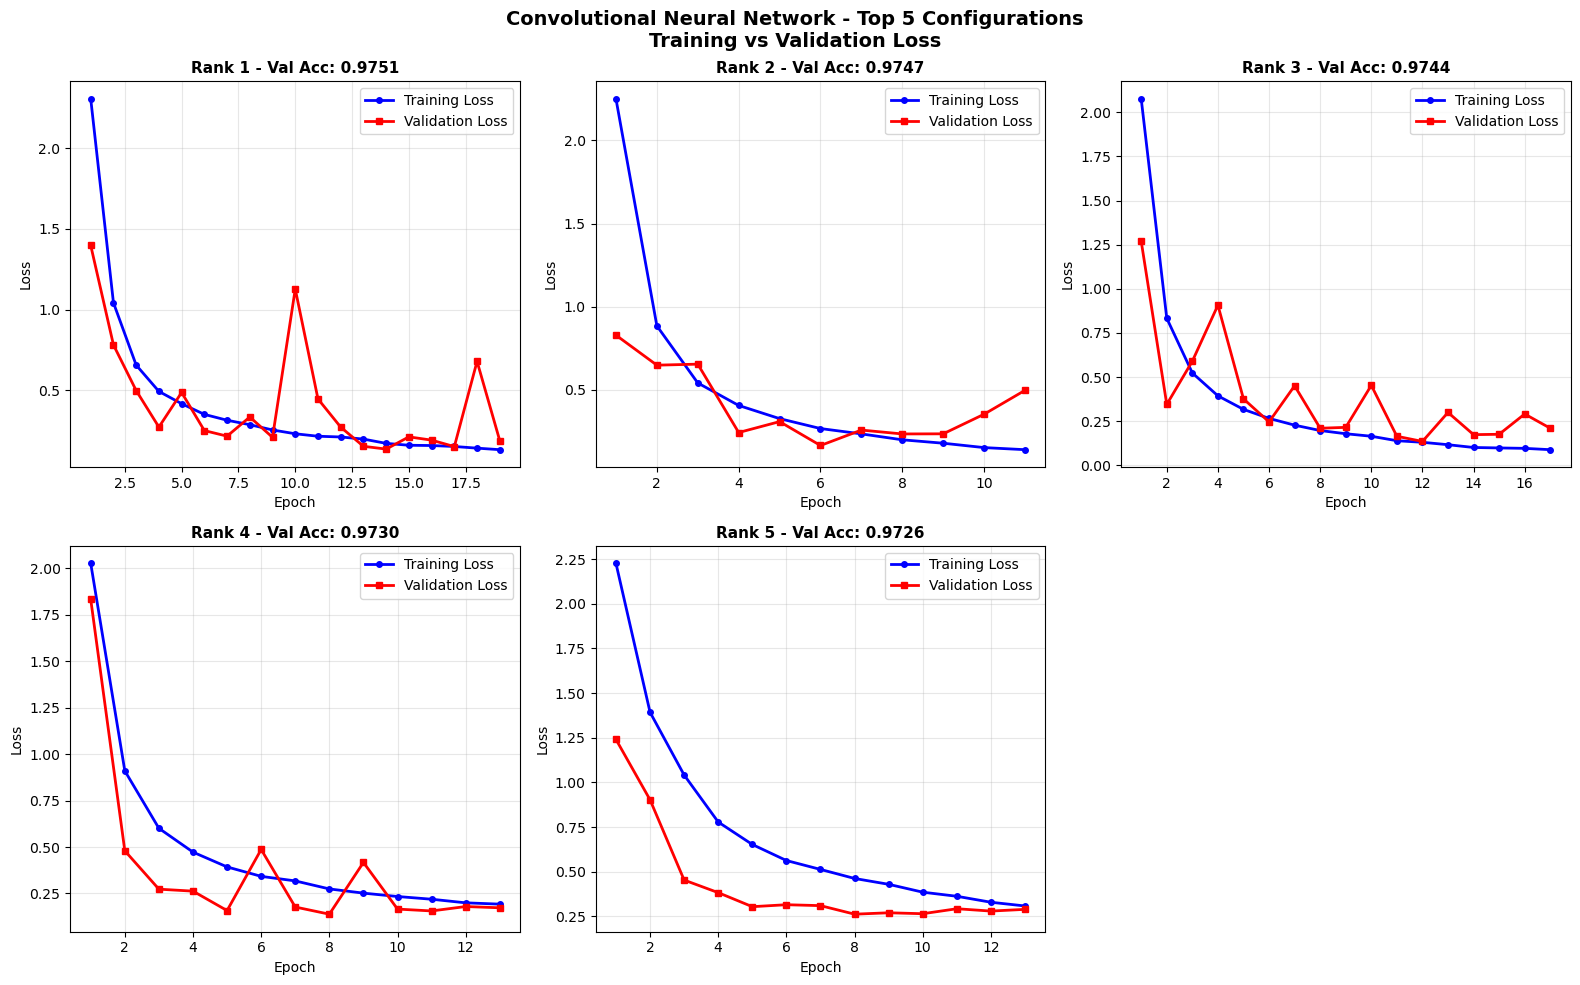

In [10]:
# Plot validation loss curves for top 5
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Convolutional Neural Network - Top 5 Configurations\nTraining vs Validation Loss', 
             fontsize=14, fontweight='bold')

for idx, history in enumerate(top5_histories):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    epochs = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    ax.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    
    rank = idx + 1
    val_acc = cnn_top5.iloc[idx]['Val_Acc']
    ax.set_title(f'Rank {rank} - Val Acc: {val_acc:.4f}', fontweight='bold', fontsize=11)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

# Hide unused subplot
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.savefig('cnn_validation_loss_curves.png', dpi=300, bbox_inches='tight')
print("✓ Loss curves plot saved as 'cnn_validation_loss_curves.png'")
plt.show()

## 5. Save Results

In [11]:
# Create results directory
results_dir = 'cnn_results'
os.makedirs(results_dir, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("\n" + "="*80)
print("SAVING RESULTS".center(80))
print("="*80)

# 1. Save summary CSV with all results
cnn_results['summary_df'].to_csv(f'{results_dir}/all_results_{timestamp}.csv', index=False)
print(f"✓ All results saved to: all_results_{timestamp}.csv")

# 2. Save top 5 CSV
cnn_top5.to_csv(f'{results_dir}/top5_results_{timestamp}.csv', index=False)
print(f"✓ Top 5 results saved to: top5_results_{timestamp}.csv")

# 3. Save best model info
best_model_info = {
    'best_params': cnn_results['best_params'],
    'best_val_acc': float(cnn_results['best_val_acc']),
    'best_test_acc': float(cnn_results['best_test_acc']),
}

with open(f'{results_dir}/best_model_{timestamp}.json', 'w') as f:
    json.dump(best_model_info, f, indent=4, default=str)
print(f"✓ Best model info saved to: best_model_{timestamp}.json")

# 4. Save best model itself
torch.save(cnn_results['best_model'].state_dict(), 
           f'{results_dir}/best_model_weights_{timestamp}.pt')
print(f"✓ Best model weights saved to: best_model_weights_{timestamp}.pt")

# 5. Save training history for best model
with open(f'{results_dir}/best_model_history_{timestamp}.pkl', 'wb') as f:
    pickle.dump(cnn_results['best_history'], f)
print(f"✓ Best model training history saved to: best_model_history_{timestamp}.pkl")

# 6. Save training histories for top 5
for i, history in enumerate(top5_histories, 1):
    with open(f'{results_dir}/rank_{i:02d}_history_{timestamp}.pkl', 'wb') as f:
        pickle.dump(history, f)
print(f"✓ Top 5 training histories saved")

# 7. Save loss curves data as CSV for easy access
for i, history in enumerate(top5_histories, 1):
    loss_df = pd.DataFrame({
        'Epoch': range(1, len(history['train_loss']) + 1),
        'Train_Loss': history['train_loss'],
        'Val_Loss': history['val_loss'],
        'Train_Acc': history['train_acc'],
        'Val_Acc': history['val_acc'],
    })
    loss_df.to_csv(f'{results_dir}/rank_{i:02d}_loss_curves_{timestamp}.csv', index=False)
print(f"✓ Loss curves data saved as CSV for all top 5")

# 8. Save summary report
summary = {
    'model': 'CNN',
    'timestamp': timestamp,
    'total_combinations': int(total_combinations),
    'best_val_accuracy': float(cnn_results['best_val_acc']),
    'best_test_accuracy': float(cnn_results['best_test_acc']),
    'best_hyperparameters': cnn_results['best_params'],
    'top5_accuracies': cnn_top5['Val_Acc'].tolist(),
}

with open(f'{results_dir}/summary_report_{timestamp}.json', 'w') as f:
    json.dump(summary, f, indent=4, default=str)
print(f"✓ Summary report saved to: summary_report_{timestamp}.json")

print("\n" + "="*80)
print(f"All results saved to: {results_dir}/".center(80))
print("="*80)


                                 SAVING RESULTS                                 
✓ All results saved to: all_results_20251126_020748.csv
✓ Top 5 results saved to: top5_results_20251126_020748.csv
✓ Best model info saved to: best_model_20251126_020748.json
✓ Best model weights saved to: best_model_weights_20251126_020748.pt
✓ Best model training history saved to: best_model_history_20251126_020748.pkl
✓ Top 5 training histories saved
✓ Loss curves data saved as CSV for all top 5
✓ Summary report saved to: summary_report_20251126_020748.json

                       All results saved to: cnn_results/                       


## 6. Results Summary

In [12]:
print("\n" + "="*80)
print("CONVOLUTIONAL NEURAL NETWORK - TUNING RESULTS SUMMARY".center(80))
print("="*80)

print(f"\nBest Model Performance:")
print(f"  Validation Accuracy: {cnn_results['best_val_acc']:.4f}")
print(f"  Test Accuracy: {cnn_results['best_test_acc']:.4f}")

print(f"\nBest Hyperparameters:")
for key, value in cnn_results['best_params'].items():
    print(f"  {key}: {value}")

print(f"\nTop 5 Validation Accuracies:")
for rank, acc in enumerate(cnn_top5['Val_Acc'].values, 1):
    print(f"  Rank {rank}: {acc:.4f}")

print(f"\nTotal tuning combinations evaluated: {total_combinations}")
print("\n" + "="*80)


             CONVOLUTIONAL NEURAL NETWORK - TUNING RESULTS SUMMARY              

Best Model Performance:
  Validation Accuracy: 0.9751
  Test Accuracy: 0.9709

Best Hyperparameters:
  learning_rate: 0.001
  batch_size: 128
  kernel_size: 5
  padding: 1
  num_epochs: 30
  optimizer: adam

Top 5 Validation Accuracies:
  Rank 1: 0.9751
  Rank 2: 0.9747
  Rank 3: 0.9744
  Rank 4: 0.9730
  Rank 5: 0.9726

Total tuning combinations evaluated: 288



## 7. Best Model Evaluation - Classification Report & Confusion Matrix

In [13]:
# Load best model and generate predictions on test set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

print("Loading best model and generating predictions...\n")

# Load best model
best_model = cnn_results['best_model']
best_model.eval()

# Generate predictions on test set
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    outputs = best_model(X_test_tensor)
    _, predictions = torch.max(outputs, 1)
    predictions = predictions.cpu().numpy()

test_accuracy = accuracy_score(y_test, predictions)
print(f"✓ Best Model Test Accuracy: {test_accuracy:.4f}\n")

# Generate classification report
class_names = [f'Class_{i:02d}' for i in range(38)]
print("="*100)
print("CLASSIFICATION REPORT - Best CNN Model".center(100))
print("="*100)
report = classification_report(y_test, predictions, target_names=class_names, digits=4)
print(report)

# Save classification report
with open(f'{results_dir}/classification_report_{timestamp}.txt', 'w') as f:
    f.write(f"Classification Report - Best CNN Model\n")
    f.write(f"{'='*100}\n\n")
    f.write(report)
print(f"✓ Classification report saved to: classification_report_{timestamp}.txt\n")

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)
print(f"✓ Confusion matrix computed: shape {cm.shape}")

Loading best model and generating predictions...

✓ Best Model Test Accuracy: 0.9709

                               CLASSIFICATION REPORT - Best CNN Model                               
              precision    recall  f1-score   support

    Class_00     1.0000    1.0000    1.0000       150
    Class_01     0.9615    1.0000    0.9804       150
    Class_02     0.9677    1.0000    0.9836       150
    Class_03     0.9932    0.9800    0.9866       150
    Class_04     0.9490    0.9933    0.9707       150
    Class_05     0.9800    0.9800    0.9800       150
    Class_06     0.8750    0.9130    0.8936        23
    Class_07     0.9739    0.9933    0.9835       150
    Class_08     0.9845    0.9769    0.9807       130
    Class_09     0.9861    0.9467    0.9660       150
    Class_10     0.9551    0.9933    0.9739       150
    Class_11     0.9868    0.9933    0.9900       150
    Class_12     0.9554    1.0000    0.9772       150
    Class_13     0.9669    0.9733    0.9701       150
  

✓ Confusion matrix plot saved to: confusion_matrix_20251126_020748.png



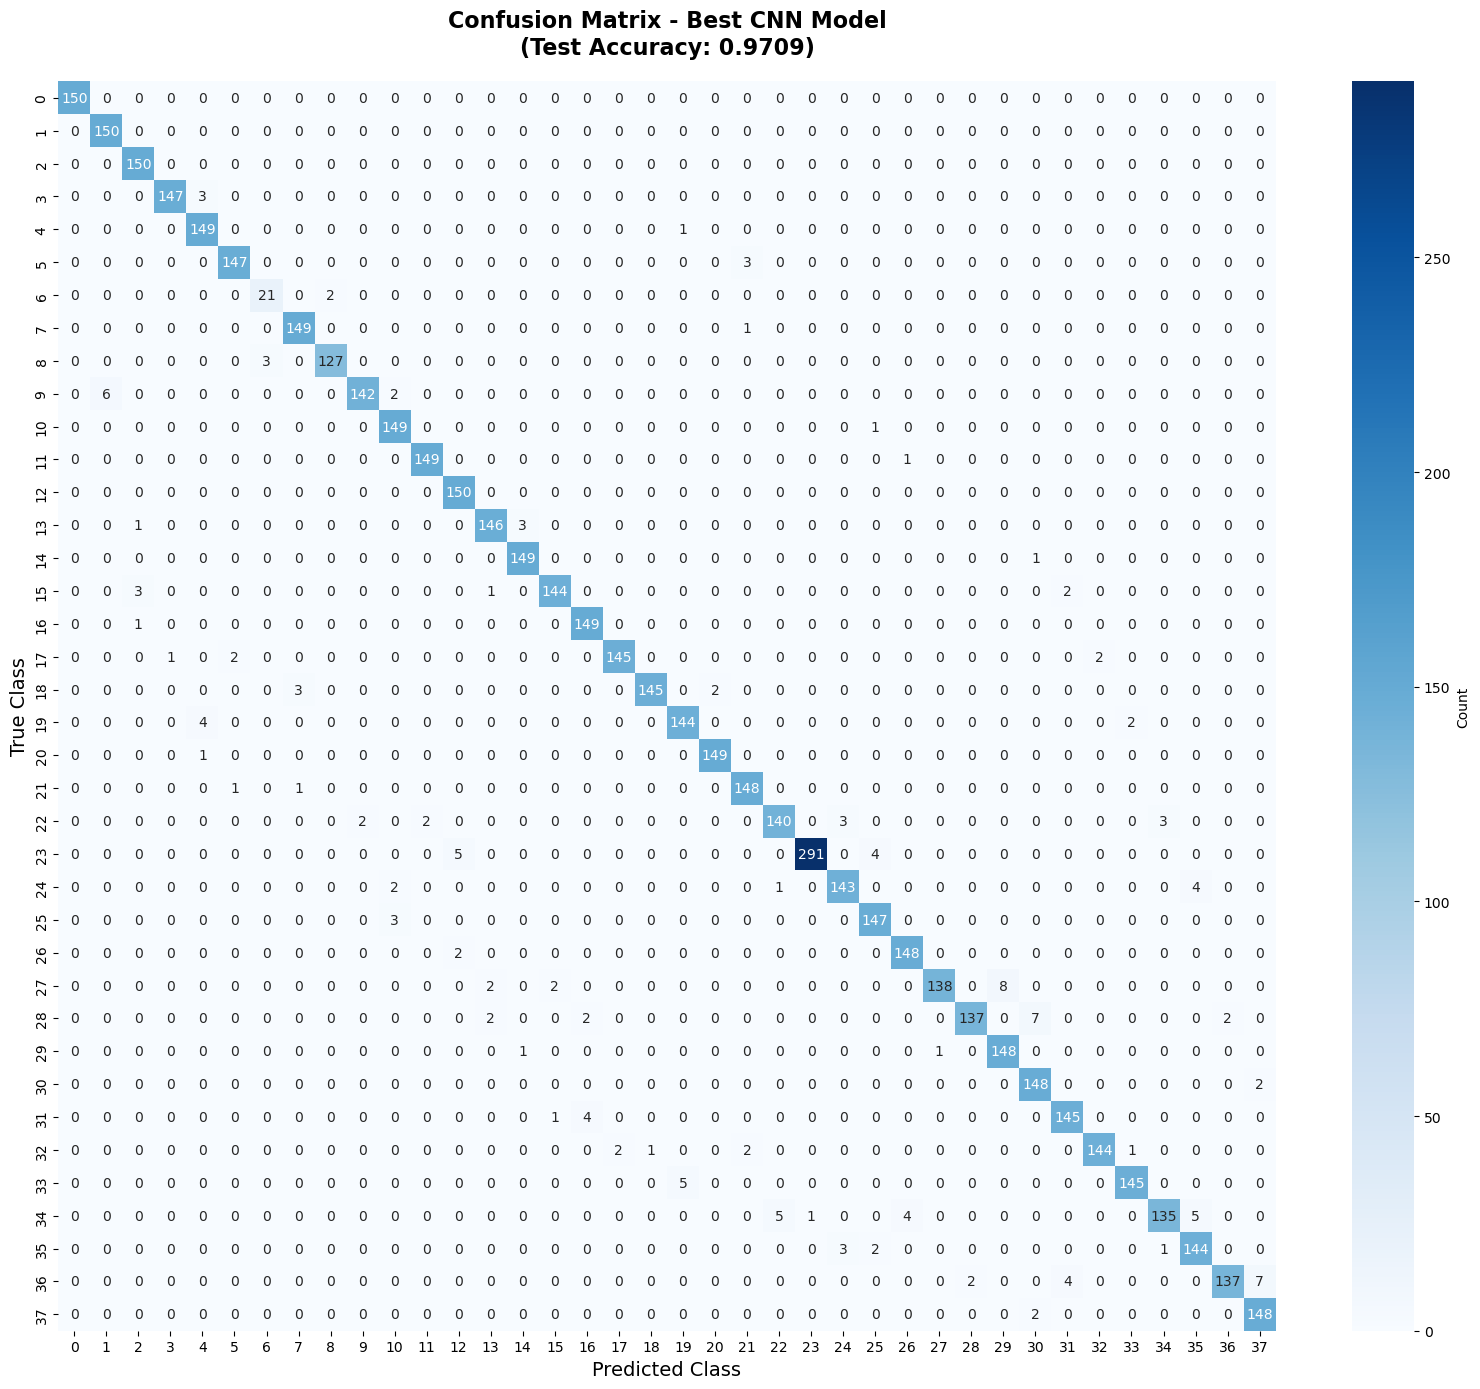

In [14]:
# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax, 
            xticklabels=range(38), yticklabels=range(38),
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Best CNN Model\n(Test Accuracy: {:.4f})'.format(test_accuracy), 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.tight_layout()
plt.savefig(f'{results_dir}/confusion_matrix_{timestamp}.png', dpi=300, bbox_inches='tight')
print(f"✓ Confusion matrix plot saved to: confusion_matrix_{timestamp}.png\n")
plt.show()

In [15]:
# Calculate per-class accuracy metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, predictions, average=None)

# Per-class accuracy (recall)
class_accuracy = recall  # Recall = TP / (TP + FN) = accuracy for that class

# Create comprehensive class-wise metrics dataframe
class_metrics = pd.DataFrame({
    'Class': [f'Class_{i:02d}' for i in range(38)],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support,
    'Accuracy': class_accuracy
})

# Save to CSV
class_metrics.to_csv(f'{results_dir}/class_wise_metrics_{timestamp}.csv', index=False)
print(f"✓ Per-class metrics saved to: class_wise_metrics_{timestamp}.csv\n")

print("CLASS-WISE PERFORMANCE METRICS:")
print("="*100)
print(class_metrics.to_string(index=False))
print("="*100)

✓ Per-class metrics saved to: class_wise_metrics_20251126_020748.csv

CLASS-WISE PERFORMANCE METRICS:
   Class  Precision   Recall  F1-Score  Support  Accuracy
Class_00   1.000000 1.000000  1.000000      150  1.000000
Class_01   0.961538 1.000000  0.980392      150  1.000000
Class_02   0.967742 1.000000  0.983607      150  1.000000
Class_03   0.993243 0.980000  0.986577      150  0.980000
Class_04   0.949045 0.993333  0.970684      150  0.993333
Class_05   0.980000 0.980000  0.980000      150  0.980000
Class_06   0.875000 0.913043  0.893617       23  0.913043
Class_07   0.973856 0.993333  0.983498      150  0.993333
Class_08   0.984496 0.976923  0.980695      130  0.976923
Class_09   0.986111 0.946667  0.965986      150  0.946667
Class_10   0.955128 0.993333  0.973856      150  0.993333
Class_11   0.986755 0.993333  0.990033      150  0.993333
Class_12   0.955414 1.000000  0.977199      150  1.000000
Class_13   0.966887 0.973333  0.970100      150  0.973333
Class_14   0.973856 0.993333

✓ Class-wise accuracy plots saved to: class_wise_accuracy_20251126_020748.png



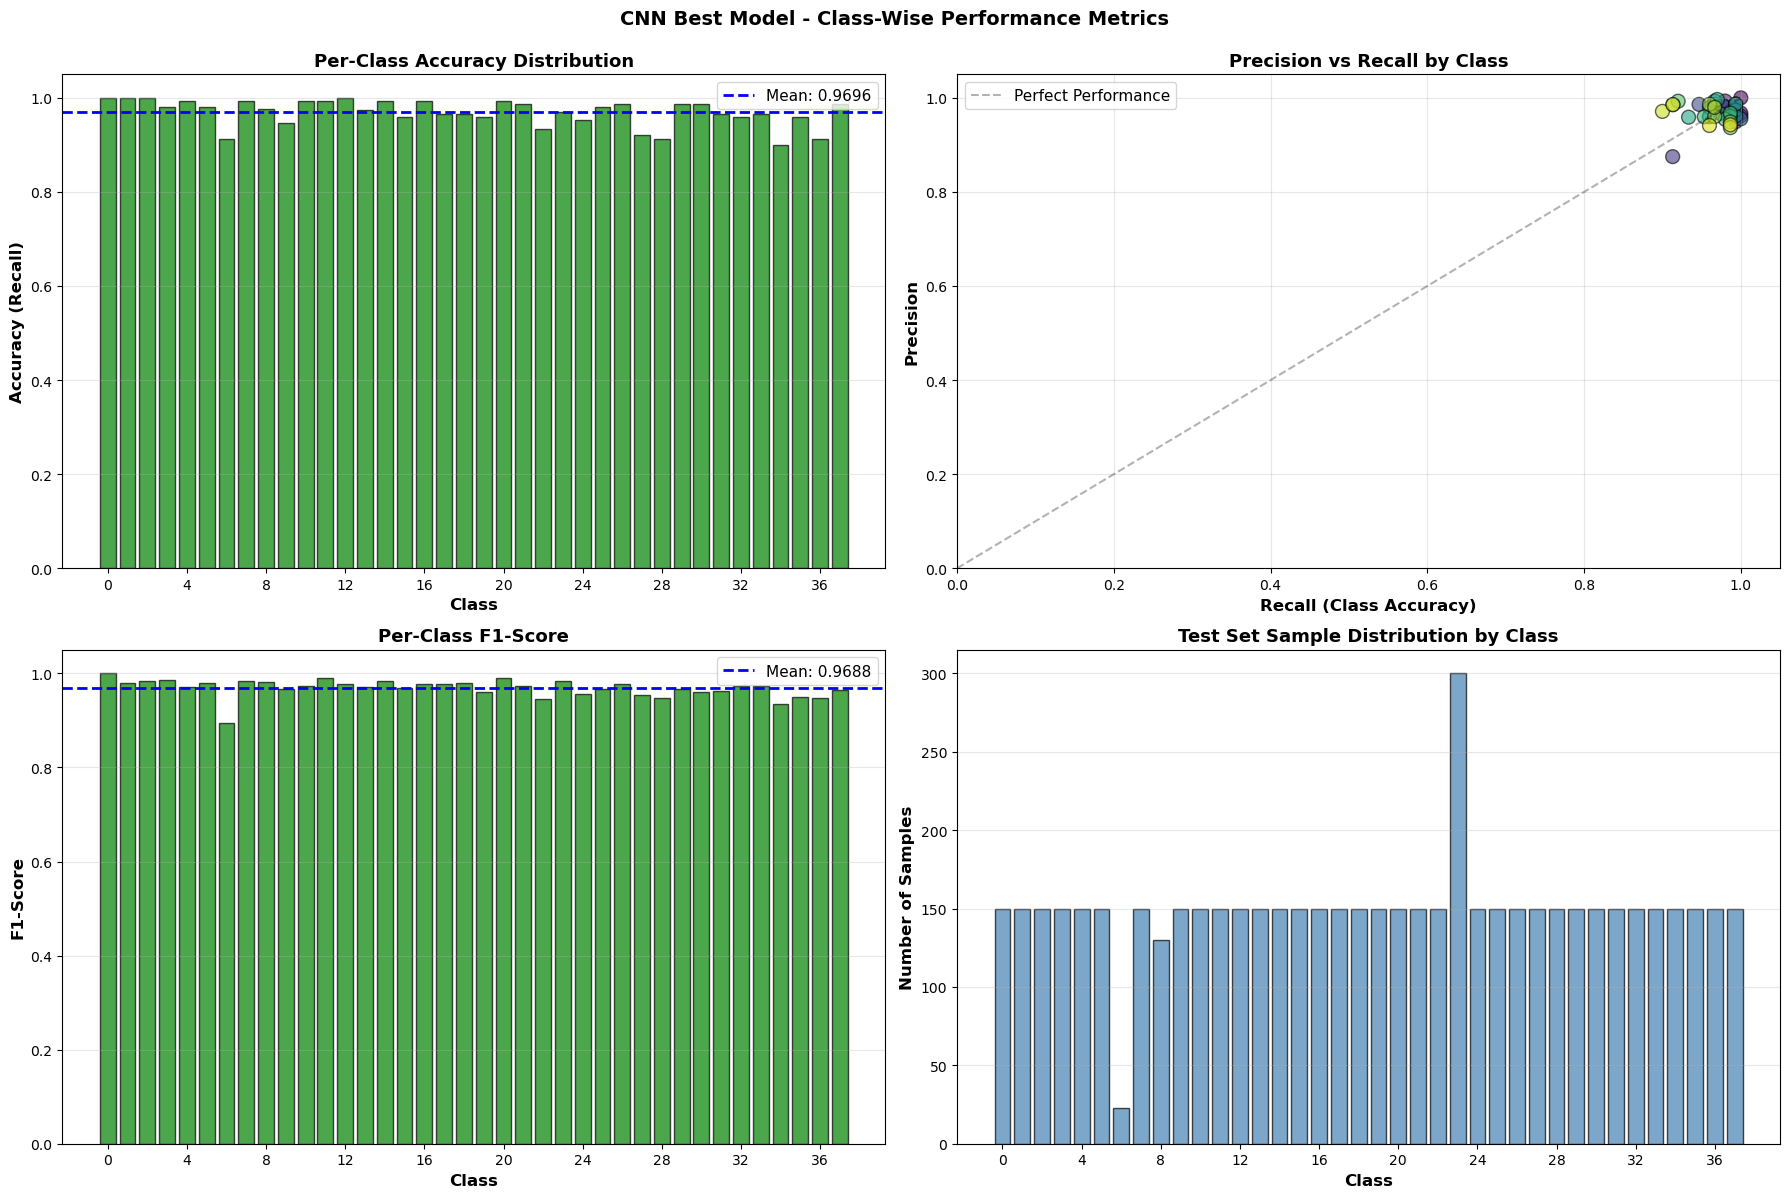


SUMMARY STATISTICS:
Overall Test Accuracy: 0.9709
Macro-averaged Precision: 0.9686
Macro-averaged Recall: 0.9696
Macro-averaged F1-Score: 0.9688

Best performing classes: [(0, np.float64(1.0)), (1, np.float64(1.0)), (2, np.float64(1.0)), (12, np.float64(1.0)), (4, np.float64(0.9933333333333333))]
Worst performing classes: [(34, np.float64(0.9)), (6, np.float64(0.9130434782608695)), (28, np.float64(0.9133333333333333)), (36, np.float64(0.9133333333333333)), (27, np.float64(0.92))]


In [16]:
# Visualize class-wise accuracy (recall)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Class-wise Accuracy (Recall)
ax = axes[0, 0]
colors = ['green' if acc >= 0.8 else 'orange' if acc >= 0.6 else 'red' for acc in class_accuracy]
bars1 = ax.bar(range(38), class_accuracy, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(y=class_accuracy.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {class_accuracy.mean():.4f}')
ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (Recall)', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Accuracy Distribution', fontsize=13, fontweight='bold')
ax.set_xticks(range(0, 38, 4))
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

# Plot 2: Precision vs Recall
ax = axes[0, 1]
ax.scatter(recall, precision, s=100, alpha=0.6, c=range(38), cmap='viridis', edgecolors='black', linewidth=1)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect Performance')
ax.set_xlabel('Recall (Class Accuracy)', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision vs Recall by Class', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1.05])
ax.set_ylim([0, 1.05])

# Plot 3: F1-Score by Class
ax = axes[1, 0]
colors_f1 = ['green' if f >= 0.8 else 'orange' if f >= 0.6 else 'red' for f in f1]
bars3 = ax.bar(range(38), f1, color=colors_f1, alpha=0.7, edgecolor='black')
ax.axhline(y=f1.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {f1.mean():.4f}')
ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class F1-Score', fontsize=13, fontweight='bold')
ax.set_xticks(range(0, 38, 4))
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

# Plot 4: Support (sample count) by class
ax = axes[1, 1]
ax.bar(range(38), support, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_title('Test Set Sample Distribution by Class', fontsize=13, fontweight='bold')
ax.set_xticks(range(0, 38, 4))
ax.grid(axis='y', alpha=0.3)

plt.suptitle('CNN Best Model - Class-Wise Performance Metrics', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{results_dir}/class_wise_accuracy_{timestamp}.png', dpi=300, bbox_inches='tight')
print(f"✓ Class-wise accuracy plots saved to: class_wise_accuracy_{timestamp}.png\n")
plt.show()

# Print summary statistics
print("\nSUMMARY STATISTICS:")
print("="*100)
print(f"Overall Test Accuracy: {test_accuracy:.4f}")
print(f"Macro-averaged Precision: {precision.mean():.4f}")
print(f"Macro-averaged Recall: {recall.mean():.4f}")
print(f"Macro-averaged F1-Score: {f1.mean():.4f}")
print(f"\nBest performing classes: {sorted(enumerate(class_accuracy), key=lambda x: x[1], reverse=True)[:5]}")
print(f"Worst performing classes: {sorted(enumerate(class_accuracy), key=lambda x: x[1])[:5]}")
print("="*100)